### Imports

In [22]:
import sqlite3 as sql
import pandas as pd
import torch.nn as nn
import torch
import numpy as np
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.preprocessing import OneHotEncoder
import tqdm

conn = sql.connect("states.db")
tables_query = "SELECT name FROM sqlite_master WHERE type='table';"
tables_df = pd.read_sql(tables_query, conn)
table_names = tables_df['name'].tolist()[1:]


dataframes = {}
for table_name in table_names:
    dataframes[table_name] = pd.read_sql(f"SELECT * FROM {table_name}", conn)
conn.close()

In [3]:
unemployment_rate = dataframes['unemployment_rate']
state_survival_rates = dataframes['survival_rates']
industry_survival_rates = dataframes['industry_survival_rates']
establishments = dataframes['establishments']

### Data reformatting

Reformat into 1530 samples for state data

In [4]:
state_survival_rates_filtered = state_survival_rates[state_survival_rates["Year Established"] != state_survival_rates["Year"]]
state_survival_rates_filtered.loc[:, "Year"] = state_survival_rates_filtered["Year"].astype('int')
state_survival_rates_filtered.loc[:, "Survival Rates of Previous Year's Survivors"] = state_survival_rates_filtered["Survival Rates of Previous Year's Survivors"].astype('float')
state_survival_rates_filtered.loc[:, 'Surviving Establishments'] = state_survival_rates_filtered['Surviving Establishments'].str.replace(',', '').astype(int)
state_survival_rates_grouped = state_survival_rates_filtered.groupby(["Year", "State"]).apply(lambda x: np.average(x['Survival Rates of Previous Year\'s Survivors'], weights=x['Surviving Establishments']))
#print(state_survival_rates_filtered.head())

Get reformatted industry data

In [5]:
industry_survival_rates_filtered = industry_survival_rates[industry_survival_rates["Year Established"] != industry_survival_rates["Year"]]
industry_survival_rates_filtered.loc[:, "Year"] = industry_survival_rates_filtered["Year"].astype('int')
industry_survival_rates_filtered.loc[:, "Survival Rates of Previous Year's Survivors"] = industry_survival_rates_filtered["Survival Rates of Previous Year's Survivors"].astype('float')
industry_survival_rates_filtered.loc[:, 'Surviving Establishments'] = industry_survival_rates_filtered['Surviving Establishments'].str.replace(',', '').astype(int)
industry_survival_rates_grouped = industry_survival_rates_filtered.groupby(["Year", "Industry"]).apply(lambda x: np.average(x['Survival Rates of Previous Year\'s Survivors'], weights=x['Surviving Establishments']))

print(industry_survival_rates_filtered.head())

  Year Established  Year Surviving Establishments  \
1             1994  1995                     5537   
2             1994  1996                     4826   
3             1994  1997                     4406   
4             1994  1998                     4005   
5             1994  1999                     3729   

  Total Employment of Survivors Survival Rates Since Birth  \
1                        51,066                       82.1   
2                        48,263                       71.6   
3                        47,634                       65.4   
4                        45,444                       59.4   
5                        39,377                       55.3   

  Survival Rates of Previous Year's Survivors Average Employment of Survivors  \
1                                        82.1                             9.2   
2                                        87.2                            10.0   
3                                        91.3                    

In [6]:
total_survival_rate = pd.concat([state_survival_rates_filtered, industry_survival_rates_filtered])
total_survival_rate_grouped = total_survival_rate.groupby(["Year"]).apply(lambda x: np.average(x['Survival Rates of Previous Year\'s Survivors'], weights=x['Surviving Establishments']))
# ^ overall business survival rate by year



In [10]:
conn = sql.connect("states.db")
state_survival_rates_grouped.unstack().to_sql("states_grouped", conn, if_exists="replace", index=False)
industry_survival_rates_grouped.to_sql("industry_grouped", conn, if_exists="replace", index=False)
total_survival_rate_grouped.to_sql("total_grouped", conn, if_exists="replace", index=False)
conn.close()

### Bayesian Approach

In [11]:
import pandas as pd
import numpy as np

def compute_bayesian_survival_probabilities(state_survival_rates_filtered, industry_survival_rates_filtered):
    probabilities = []
    years = state_survival_rates_filtered['Year'].unique() # loop through the unique years in the list

    # P(Survival | State, Sector) = P(Survival) * P(State, Sector | Survival)P(State, Sector)
    
    for year in years:
        df_s = state_survival_rates_filtered[state_survival_rates_filtered['Year'] == year] # data during the current iterated year
        df_i = industry_survival_rates_filtered[industry_survival_rates_filtered['Year'] == year]
        df_state = df_s.copy()
        df_industry = df_i.copy()
       
        df_state.loc[:, 'Total Establishments'] = df_s['Surviving Establishments'].shift(1).fillna(df_s['Surviving Establishments'])
        # total establishments is just the surviving number from the last year
        df_industry.loc[:, 'Total Establishments'] = df_i['Surviving Establishments'].shift(1).fillna(df_i['Surviving Establishments'])
        # making sure the first one has data to shift down also
        
        total_state_survivors = df_state['Surviving Establishments'].sum()
        total_industry_survivors = df_industry['Surviving Establishments'].sum()
        total_survivors = (total_state_survivors + total_industry_survivors) / 2  # still using weighted average for now
        
        total_state_establishments = df_state['Total Establishments'].sum()
        total_industry_establishments = df_industry['Total Establishments'].sum()
        total_establishments = (total_state_establishments + total_industry_establishments) / 2
        
        p_survival = total_survivors / total_establishments if total_establishments > 0 else 0  # P(Survival)
        
        # Compute P(State, Sector) - probability of being in a state-sector
        df_state.loc[:, 'P_State'] = df_state['Total Establishments'] / total_state_establishments
        df_industry.loc[:, 'P_Sector'] = df_industry['Total Establishments'] / total_industry_establishments
        
        # Compute P(State | Survival) and P(Sector | Survival)
        df_state['P_State_given_Survival'] = df_state['Surviving Establishments'] / total_state_survivors
        df_industry['P_Sector_given_Survival'] = df_industry['Surviving Establishments'] / total_industry_survivors
        
        # Merge datasets on state and industry
        df_merged = pd.merge(df_state, df_industry, on='Year', suffixes=('_State', '_Sector'))
        
        # Compute P(Survival | State, Sector) using Bayesian formula
        df_merged['P_Survival_given_State_Sector'] = (
            p_survival * df_merged['P_State_given_Survival'] * df_merged['P_Sector_given_Survival'] /
            (df_merged['P_State'] * df_merged['P_Sector'])
        ).fillna(0)  # Handle divide-by-zero cases
        
        probabilities.append(df_merged[['Year', 'State', 'Industry', 'P_Survival_given_State_Sector']])
    
    return pd.concat(probabilities)

# Example usage

bayesian_survival_probabilities = compute_bayesian_survival_probabilities(state_survival_rates_filtered, industry_survival_rates_filtered)
print(bayesian_survival_probabilities.head())


   Year State                                       Industry  \
0  1995    AL     Agriculture, Forestry, Fishing and Hunting   
1  1995    AL  Mining, Quarrying, and Oil and Gas Extraction   
2  1995    AL                                      Utilities   
3  1995    AL                                   Construction   
4  1995    AL                                  Manufacturing   

   P_Survival_given_State_Sector  
0                       0.976189  
1                       0.254581  
2                       0.319087  
3                     100.164821  
4                       0.442390  


### Non-Bayesian approach

In [12]:
results = []
for (year, state), state_val in state_survival_rates_grouped.items():
    for (ind_year, industry), ind_val in industry_survival_rates_grouped.items():
        if year == ind_year:
            result = (year, state, industry), (state_val * ind_val) / total_survival_rate_grouped[year]
            results.append(result)

result = pd.Series(dict(results))
unemployment_rate["Year"] = unemployment_rate["Year"].astype('int')

In [13]:
state_df = state_survival_rates_grouped.unstack()
industry_df = industry_survival_rates_grouped.unstack()

In [14]:
numerical_state = dict(zip(state_df.columns, range(len(state_df.columns))))
numerical_state_rev = dict(zip(range(len(state_df.columns)), state_df.columns))
numerical_industry = dict(zip(industry_df.columns, range(len(industry_df.columns))))
numerical_industry_rev = dict(zip(range(len(industry_df.columns)), industry_df.columns))

In [15]:
pre_df = []
for year in result.index.get_level_values(0).unique():
    for state in state_df.columns:
        unemployment = unemployment_rate[(unemployment_rate["Year"] == year) & (unemployment_rate["State"] == state)]["Unemployment Rate"]
        for industry in industry_df.columns:
            response = result[year, state, industry]
            pre_df.append((year, numerical_state[state], numerical_industry[industry], float(unemployment.iloc[0]), response))
final_dataset = pd.DataFrame(pre_df, columns=["Year", "State", "Industry", "Unemployment Rate", "Response"])
             

### Model

In [139]:
class EconDataset(Dataset):
    def __init__(self, data, state_col, industry_col, unemployment_col, response_col):
        self.data = data.copy()
        self.state_col = state_col
        self.industry_col = industry_col
        self.unemployment_col = unemployment_col
        self.response_col = response_col
        self.state_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        self.industry_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        self._preprocess_data()

    def _preprocess_data(self):
        self.encoded_states = self.state_encoder.fit_transform(self.data[[self.state_col]]) # Applying one-hot encoding to the state column
        self.encoded_industries = self.industry_encoder.fit_transform(self.data[[self.industry_col]]) # Applying one-hot encoding to the industry
        self.unemployment_stats = self.data[self.unemployment_col].values.reshape(-1, 1) # Turns into column vector
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        state = self.encoded_states[idx]
        industry = self.encoded_industries[idx]
        unemployment = self.unemployment_stats[idx]
        predictor = np.concatenate((unemployment, state, industry), axis=0)
        response = self.data[self.response_col].values[idx]
        return torch.tensor(predictor, dtype=torch.float32), torch.tensor(response, dtype=torch.float32).view(1) #Response is reshaped to a column vector.

In [140]:
class SurvivalRateModel(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size = 1):
        super(SurvivalRateModel, self).__init__()

        # Define layers:
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size1),
            nn.ReLU(),
            nn.Linear(hidden_size1, hidden_size2),
            nn.ReLU(),
            nn.Linear(hidden_size2, output_size)
        )

    def forward(self, x):
        return self.layers(x)

    
    def train_step(self, x, y, criterion, optimizer):
        optimizer.zero_grad()
        outputs = self(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        return loss.item()
    
    def train_loop(self, dataloader, num_epochs=100, learning_rate=0.01, device = "cpu", suppress=False):
        self.to(device)
        criterion = nn.L1Loss()
        loss_cache = []
        optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
        self.train() #set model to train mode.
        for epoch in tqdm.tqdm(range(num_epochs), desc="Training Epochs"):
            total_loss = 0
            for x, y in dataloader:
                x, y = x.to(device), y.to(device)
                loss = self.train_step(x, y, criterion, optimizer)
                loss_cache.append(loss)
                total_loss += loss
            if not suppress:
                print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(dataloader):.4f}')
        return loss_cache
    def evaluate(self, dataloader, device="cpu"):
        self.to(device)
        self.eval()
        predictions = []
        actuals = []
        with torch.no_grad():
            for x, y in dataloader:
                x, y = x.to(device), y.to(device)
                outputs = self(x)
                predictions.append(outputs.cpu().numpy())
                actuals.append(y.cpu().numpy())
        return (np.concatenate(predictions), np.concatenate(actuals))
    
    def predict(self, x, device="cpu"):
        self.to(device)
        self.eval()
        with torch.no_grad():
            x = x.to(device)
            return self(x).cpu().numpy()
    

Train test split:

In [74]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and testing sets
train_data, test_data = train_test_split(final_dataset, test_size=0.2, random_state=42)

# Create DataLoader for training and testing sets
train_dataset = EconDataset(train_data, "State", "Industry", "Unemployment Rate", "Response")
test_dataset = EconDataset(test_data, "State", "Industry", "Unemployment Rate", "Response")

train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=False)

In [98]:
input_size = 1 + len(train_dataset.state_encoder.categories_[0]) + len(train_dataset.industry_encoder.categories_[0])
model = SurvivalRateModel(input_size=input_size, hidden_size1=120, hidden_size2=80)
loss_data = model.train_loop(train_dataloader, num_epochs=20, learning_rate=0.01, device="cpu")

Training Epochs:   5%|▌         | 1/20 [00:00<00:10,  1.73it/s]

Epoch [1/20], Loss: 21.1958


Training Epochs:  10%|█         | 2/20 [00:01<00:10,  1.72it/s]

Epoch [2/20], Loss: 3.0861


Training Epochs:  15%|█▌        | 3/20 [00:01<00:10,  1.58it/s]

Epoch [3/20], Loss: 2.8940


Training Epochs:  20%|██        | 4/20 [00:02<00:09,  1.67it/s]

Epoch [4/20], Loss: 2.7550


Training Epochs:  25%|██▌       | 5/20 [00:02<00:08,  1.74it/s]

Epoch [5/20], Loss: 2.8401


Training Epochs:  30%|███       | 6/20 [00:03<00:07,  1.75it/s]

Epoch [6/20], Loss: 2.8572


Training Epochs:  35%|███▌      | 7/20 [00:04<00:07,  1.77it/s]

Epoch [7/20], Loss: 2.9030


Training Epochs:  40%|████      | 8/20 [00:04<00:06,  1.76it/s]

Epoch [8/20], Loss: 2.8797


Training Epochs:  45%|████▌     | 9/20 [00:05<00:06,  1.76it/s]

Epoch [9/20], Loss: 2.7476


Training Epochs:  50%|█████     | 10/20 [00:05<00:05,  1.72it/s]

Epoch [10/20], Loss: 2.8445


Training Epochs:  55%|█████▌    | 11/20 [00:06<00:05,  1.72it/s]

Epoch [11/20], Loss: 2.7766


Training Epochs:  60%|██████    | 12/20 [00:06<00:04,  1.73it/s]

Epoch [12/20], Loss: 2.8106


Training Epochs:  65%|██████▌   | 13/20 [00:07<00:04,  1.62it/s]

Epoch [13/20], Loss: 2.8734


Training Epochs:  70%|███████   | 14/20 [00:08<00:03,  1.66it/s]

Epoch [14/20], Loss: 2.7914


Training Epochs:  75%|███████▌  | 15/20 [00:09<00:03,  1.46it/s]

Epoch [15/20], Loss: 2.8418


Training Epochs:  80%|████████  | 16/20 [00:09<00:02,  1.54it/s]

Epoch [16/20], Loss: 2.7316


Training Epochs:  85%|████████▌ | 17/20 [00:10<00:01,  1.55it/s]

Epoch [17/20], Loss: 2.7715


Training Epochs:  90%|█████████ | 18/20 [00:10<00:01,  1.55it/s]

Epoch [18/20], Loss: 2.7386


Training Epochs:  95%|█████████▌| 19/20 [00:11<00:00,  1.60it/s]

Epoch [19/20], Loss: 2.7373


Training Epochs: 100%|██████████| 20/20 [00:12<00:00,  1.65it/s]

Epoch [20/20], Loss: 2.8122


In [ ]:
predicted, actual = model.evaluate(test_dataloader, device="cpu")
print(f"Evaluation loss: {np.mean(abs(predicted - actual)):1.4f}")

Evaluation loss: 2.5933


Hyperparameter tuning:

In [ ]:
hidden_size_1 = [70, 105, 140, 175]
hidden_size_2 = [50, 100, 150, 200]
learning_rates = [1e-4, 5e-4, 1e-3, 5e-3]
batch_epoch_size = [(64,20), (128, 10), (256, 5)]
results = {}
for h1 in hidden_size_1:
    for h2 in hidden_size_2:
        for lr in learning_rates:
            for bs, ep in batch_epoch_size:
                model = SurvivalRateModel(input_size=input_size, hidden_size1=h1, hidden_size2=h2)
                train_dataloader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
                test_dataloader = DataLoader(test_dataset, batch_size=bs, shuffle=False)
                loss_data = model.train_loop(train_dataloader, num_epochs=ep, learning_rate=lr, device="cpu")
                predicted, actual = model.evaluate(test_dataloader, device="cpu")
                loss = np.mean(abs(predicted - actual))
                results[(h1, h2, lr, bs, ep)] = (loss, loss_data)
                print(f"Hidden Size 1: {h1}, Hidden Size 2: {h2}, Learning Rate: {lr}, Batch Size: {bs}, Epochs: {ep}, Loss: {loss:1.4f}")

Training Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.47it/s]

Epoch [1/5], Loss: 6.6032


Training Epochs:  40%|████      | 2/5 [00:01<00:01,  1.51it/s]

Epoch [2/5], Loss: 3.8523


Training Epochs:  60%|██████    | 3/5 [00:01<00:01,  1.52it/s]

Epoch [3/5], Loss: 3.6479


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.53it/s]

Epoch [4/5], Loss: 3.4837


Training Epochs: 100%|██████████| 5/5 [00:03<00:00,  1.46it/s]


Epoch [5/5], Loss: 3.4164
Hidden Size 1: 32, Hidden Size 2: 16, Learning Rate: 0.1, Batch Size: 64, Epochs: 5, Loss: 5.7162


Training Epochs:  10%|█         | 1/10 [00:00<00:06,  1.40it/s]

Epoch [1/10], Loss: 6.3174


Training Epochs:  20%|██        | 2/10 [00:01<00:05,  1.42it/s]

Epoch [2/10], Loss: 4.0264


Training Epochs:  30%|███       | 3/10 [00:02<00:05,  1.37it/s]

Epoch [3/10], Loss: 3.6017


Training Epochs:  40%|████      | 4/10 [00:02<00:04,  1.42it/s]

Epoch [4/10], Loss: 3.5340


Training Epochs:  50%|█████     | 5/10 [00:03<00:03,  1.44it/s]

Epoch [5/10], Loss: 3.4149


Training Epochs:  60%|██████    | 6/10 [00:04<00:02,  1.43it/s]

Epoch [6/10], Loss: 3.2094


Training Epochs:  70%|███████   | 7/10 [00:04<00:02,  1.40it/s]

Epoch [7/10], Loss: 3.1075


Training Epochs:  80%|████████  | 8/10 [00:05<00:01,  1.41it/s]

Epoch [8/10], Loss: 3.0050


Training Epochs:  90%|█████████ | 9/10 [00:06<00:00,  1.38it/s]

Epoch [9/10], Loss: 3.0246


Training Epochs: 100%|██████████| 10/10 [00:07<00:00,  1.41it/s]


Epoch [10/10], Loss: 3.0611
Hidden Size 1: 32, Hidden Size 2: 16, Learning Rate: 0.1, Batch Size: 64, Epochs: 10, Loss: 2.7061


Training Epochs:   5%|▌         | 1/20 [00:00<00:12,  1.49it/s]

Epoch [1/20], Loss: 7.0569


Training Epochs:  10%|█         | 2/20 [00:01<00:11,  1.52it/s]

Epoch [2/20], Loss: 4.2091


Training Epochs:  15%|█▌        | 3/20 [00:02<00:11,  1.47it/s]

Epoch [3/20], Loss: 3.5268


Training Epochs:  20%|██        | 4/20 [00:02<00:11,  1.43it/s]

Epoch [4/20], Loss: 3.5055


Training Epochs:  25%|██▌       | 5/20 [00:03<00:10,  1.47it/s]

Epoch [5/20], Loss: 3.2676


Training Epochs:  30%|███       | 6/20 [00:04<00:09,  1.49it/s]

Epoch [6/20], Loss: 3.3152


Training Epochs:  35%|███▌      | 7/20 [00:04<00:08,  1.50it/s]

Epoch [7/20], Loss: 3.2795


Training Epochs:  40%|████      | 8/20 [00:05<00:07,  1.51it/s]

Epoch [8/20], Loss: 3.1470


Training Epochs:  45%|████▌     | 9/20 [00:06<00:07,  1.45it/s]

Epoch [9/20], Loss: 3.1686


Training Epochs:  50%|█████     | 10/20 [00:06<00:06,  1.45it/s]

Epoch [10/20], Loss: 2.9914


Training Epochs:  55%|█████▌    | 11/20 [00:07<00:06,  1.48it/s]

Epoch [11/20], Loss: 3.0145


Training Epochs:  60%|██████    | 12/20 [00:08<00:05,  1.50it/s]

Epoch [12/20], Loss: 2.9693


Training Epochs:  65%|██████▌   | 13/20 [00:08<00:04,  1.51it/s]

Epoch [13/20], Loss: 3.0565


Training Epochs:  70%|███████   | 14/20 [00:09<00:04,  1.45it/s]

Epoch [14/20], Loss: 2.9087


Training Epochs:  75%|███████▌  | 15/20 [00:10<00:03,  1.47it/s]

Epoch [15/20], Loss: 2.9726


Training Epochs:  80%|████████  | 16/20 [00:10<00:02,  1.49it/s]

Epoch [16/20], Loss: 2.9560


Training Epochs:  85%|████████▌ | 17/20 [00:11<00:01,  1.50it/s]

Epoch [17/20], Loss: 2.9975


Training Epochs:  90%|█████████ | 18/20 [00:12<00:01,  1.39it/s]

Epoch [18/20], Loss: 3.0241


Training Epochs:  95%|█████████▌| 19/20 [00:12<00:00,  1.41it/s]

Epoch [19/20], Loss: 2.9198


Training Epochs: 100%|██████████| 20/20 [00:13<00:00,  1.47it/s]


Epoch [20/20], Loss: 2.8214
Hidden Size 1: 32, Hidden Size 2: 16, Learning Rate: 0.1, Batch Size: 64, Epochs: 20, Loss: 3.3941


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.82it/s]

Epoch [1/5], Loss: 8.4692


Training Epochs:  40%|████      | 2/5 [00:01<00:01,  1.83it/s]

Epoch [2/5], Loss: 3.4849


Training Epochs:  60%|██████    | 3/5 [00:01<00:01,  1.83it/s]

Epoch [3/5], Loss: 3.6522


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.71it/s]

Epoch [4/5], Loss: 3.5709


Training Epochs: 100%|██████████| 5/5 [00:02<00:00,  1.76it/s]


Epoch [5/5], Loss: 3.3086
Hidden Size 1: 32, Hidden Size 2: 16, Learning Rate: 0.1, Batch Size: 128, Epochs: 5, Loss: 2.9590


Training Epochs:  10%|█         | 1/10 [00:00<00:04,  1.82it/s]

Epoch [1/10], Loss: 7.7047


Training Epochs:  20%|██        | 2/10 [00:01<00:04,  1.82it/s]

Epoch [2/10], Loss: 3.8270


Training Epochs:  30%|███       | 3/10 [00:01<00:03,  1.82it/s]

Epoch [3/10], Loss: 3.8384


Training Epochs:  40%|████      | 4/10 [00:02<00:03,  1.82it/s]

Epoch [4/10], Loss: 3.4638


Training Epochs:  50%|█████     | 5/10 [00:02<00:02,  1.82it/s]

Epoch [5/10], Loss: 3.4831


Training Epochs:  60%|██████    | 6/10 [00:03<00:02,  1.82it/s]

Epoch [6/10], Loss: 3.4045


Training Epochs:  70%|███████   | 7/10 [00:03<00:01,  1.82it/s]

Epoch [7/10], Loss: 3.2520


Training Epochs:  80%|████████  | 8/10 [00:04<00:01,  1.76it/s]

Epoch [8/10], Loss: 3.3535


Training Epochs:  90%|█████████ | 9/10 [00:05<00:00,  1.78it/s]

Epoch [9/10], Loss: 3.1121


Training Epochs: 100%|██████████| 10/10 [00:05<00:00,  1.80it/s]


Epoch [10/10], Loss: 3.1606
Hidden Size 1: 32, Hidden Size 2: 16, Learning Rate: 0.1, Batch Size: 128, Epochs: 10, Loss: 4.6178


Training Epochs:   5%|▌         | 1/20 [00:00<00:10,  1.80it/s]

Epoch [1/20], Loss: 8.6846


Training Epochs:  10%|█         | 2/20 [00:01<00:09,  1.82it/s]

Epoch [2/20], Loss: 3.6956


Training Epochs:  15%|█▌        | 3/20 [00:01<00:09,  1.82it/s]

Epoch [3/20], Loss: 3.4653


Training Epochs:  20%|██        | 4/20 [00:02<00:08,  1.82it/s]

Epoch [4/20], Loss: 3.2597


Training Epochs:  25%|██▌       | 5/20 [00:02<00:08,  1.80it/s]

Epoch [5/20], Loss: 3.2478


Training Epochs:  30%|███       | 6/20 [00:03<00:07,  1.81it/s]

Epoch [6/20], Loss: 3.2712


Training Epochs:  35%|███▌      | 7/20 [00:03<00:07,  1.81it/s]

Epoch [7/20], Loss: 3.1965


Training Epochs:  40%|████      | 8/20 [00:04<00:06,  1.73it/s]

Epoch [8/20], Loss: 3.3961


Training Epochs:  45%|████▌     | 9/20 [00:05<00:06,  1.75it/s]

Epoch [9/20], Loss: 3.1314


Training Epochs:  50%|█████     | 10/20 [00:05<00:05,  1.77it/s]

Epoch [10/20], Loss: 2.9313


Training Epochs:  55%|█████▌    | 11/20 [00:06<00:05,  1.79it/s]

Epoch [11/20], Loss: 3.1875


Training Epochs:  60%|██████    | 12/20 [00:06<00:04,  1.80it/s]

Epoch [12/20], Loss: 3.1034


Training Epochs:  65%|██████▌   | 13/20 [00:07<00:03,  1.81it/s]

Epoch [13/20], Loss: 2.9475


Training Epochs:  70%|███████   | 14/20 [00:07<00:03,  1.81it/s]

Epoch [14/20], Loss: 3.1698


Training Epochs:  75%|███████▌  | 15/20 [00:08<00:02,  1.82it/s]

Epoch [15/20], Loss: 3.2184


Training Epochs:  80%|████████  | 16/20 [00:08<00:02,  1.82it/s]

Epoch [16/20], Loss: 2.9797


Training Epochs:  85%|████████▌ | 17/20 [00:09<00:01,  1.82it/s]

Epoch [17/20], Loss: 3.0372


Training Epochs:  90%|█████████ | 18/20 [00:10<00:01,  1.77it/s]

Epoch [18/20], Loss: 2.8915


Training Epochs:  95%|█████████▌| 19/20 [00:10<00:00,  1.78it/s]

Epoch [19/20], Loss: 2.8764


Training Epochs: 100%|██████████| 20/20 [00:11<00:00,  1.79it/s]


Epoch [20/20], Loss: 2.9485
Hidden Size 1: 32, Hidden Size 2: 16, Learning Rate: 0.1, Batch Size: 128, Epochs: 20, Loss: 2.7295


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.98it/s]

Epoch [1/5], Loss: 13.2298


Training Epochs:  40%|████      | 2/5 [00:01<00:01,  1.99it/s]

Epoch [2/5], Loss: 3.2727


Training Epochs:  60%|██████    | 3/5 [00:01<00:01,  1.98it/s]

Epoch [3/5], Loss: 3.1879


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.98it/s]

Epoch [4/5], Loss: 3.6161


Training Epochs: 100%|██████████| 5/5 [00:02<00:00,  1.98it/s]


Epoch [5/5], Loss: 3.6323
Hidden Size 1: 32, Hidden Size 2: 16, Learning Rate: 0.1, Batch Size: 256, Epochs: 5, Loss: 3.7223


Training Epochs:  10%|█         | 1/10 [00:00<00:04,  1.99it/s]

Epoch [1/10], Loss: 13.8346


Training Epochs:  20%|██        | 2/10 [00:01<00:04,  1.99it/s]

Epoch [2/10], Loss: 3.1575


Training Epochs:  30%|███       | 3/10 [00:01<00:03,  1.98it/s]

Epoch [3/10], Loss: 3.1397


Training Epochs:  40%|████      | 4/10 [00:02<00:03,  1.89it/s]

Epoch [4/10], Loss: 3.0568


Training Epochs:  50%|█████     | 5/10 [00:02<00:02,  1.92it/s]

Epoch [5/10], Loss: 3.1312


Training Epochs:  60%|██████    | 6/10 [00:03<00:02,  1.93it/s]

Epoch [6/10], Loss: 3.1991


Training Epochs:  70%|███████   | 7/10 [00:03<00:01,  1.95it/s]

Epoch [7/10], Loss: 3.2490


Training Epochs:  80%|████████  | 8/10 [00:04<00:01,  1.69it/s]

Epoch [8/10], Loss: 3.3536


Training Epochs:  90%|█████████ | 9/10 [00:04<00:00,  1.77it/s]

Epoch [9/10], Loss: 3.2919


Training Epochs: 100%|██████████| 10/10 [00:05<00:00,  1.86it/s]


Epoch [10/10], Loss: 2.9801
Hidden Size 1: 32, Hidden Size 2: 16, Learning Rate: 0.1, Batch Size: 256, Epochs: 10, Loss: 2.7119


Training Epochs:   5%|▌         | 1/20 [00:00<00:09,  1.96it/s]

Epoch [1/20], Loss: 12.7012


Training Epochs:  10%|█         | 2/20 [00:01<00:09,  1.96it/s]

Epoch [2/20], Loss: 3.2662


Training Epochs:  15%|█▌        | 3/20 [00:01<00:08,  1.97it/s]

Epoch [3/20], Loss: 3.2296


Training Epochs:  20%|██        | 4/20 [00:02<00:08,  1.87it/s]

Epoch [4/20], Loss: 3.5722


Training Epochs:  25%|██▌       | 5/20 [00:02<00:07,  1.91it/s]

Epoch [5/20], Loss: 3.2025


Training Epochs:  30%|███       | 6/20 [00:03<00:07,  1.93it/s]

Epoch [6/20], Loss: 3.1334


Training Epochs:  35%|███▌      | 7/20 [00:03<00:06,  1.94it/s]

Epoch [7/20], Loss: 3.2155


Training Epochs:  40%|████      | 8/20 [00:04<00:06,  1.78it/s]

Epoch [8/20], Loss: 3.1116


Training Epochs:  45%|████▌     | 9/20 [00:04<00:05,  1.84it/s]

Epoch [9/20], Loss: 3.4459


Training Epochs:  50%|█████     | 10/20 [00:05<00:05,  1.85it/s]

Epoch [10/20], Loss: 2.9924


Training Epochs:  55%|█████▌    | 11/20 [00:05<00:04,  1.88it/s]

Epoch [11/20], Loss: 3.4566


Training Epochs:  60%|██████    | 12/20 [00:06<00:04,  1.91it/s]

Epoch [12/20], Loss: 3.0748


Training Epochs:  65%|██████▌   | 13/20 [00:06<00:03,  1.83it/s]

Epoch [13/20], Loss: 3.1488


Training Epochs:  70%|███████   | 14/20 [00:07<00:03,  1.88it/s]

Epoch [14/20], Loss: 2.9670


Training Epochs:  75%|███████▌  | 15/20 [00:07<00:02,  1.90it/s]

Epoch [15/20], Loss: 2.9855


Training Epochs:  80%|████████  | 16/20 [00:08<00:02,  1.93it/s]

Epoch [16/20], Loss: 3.0104


Training Epochs:  85%|████████▌ | 17/20 [00:08<00:01,  1.94it/s]

Epoch [17/20], Loss: 3.6788


Training Epochs:  90%|█████████ | 18/20 [00:09<00:01,  1.95it/s]

Epoch [18/20], Loss: 2.9850


Training Epochs:  95%|█████████▌| 19/20 [00:10<00:00,  1.71it/s]

Epoch [19/20], Loss: 3.1568


Training Epochs: 100%|██████████| 20/20 [00:10<00:00,  1.86it/s]


Epoch [20/20], Loss: 2.8855
Hidden Size 1: 32, Hidden Size 2: 16, Learning Rate: 0.1, Batch Size: 256, Epochs: 20, Loss: 2.6468


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.52it/s]

Epoch [1/5], Loss: 11.8542


Training Epochs:  40%|████      | 2/5 [00:01<00:01,  1.52it/s]

Epoch [2/5], Loss: 2.8822


Training Epochs:  60%|██████    | 3/5 [00:02<00:01,  1.46it/s]

Epoch [3/5], Loss: 2.8866


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.49it/s]

Epoch [4/5], Loss: 2.8156


Training Epochs: 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]


Epoch [5/5], Loss: 2.8236
Hidden Size 1: 32, Hidden Size 2: 16, Learning Rate: 0.01, Batch Size: 64, Epochs: 5, Loss: 2.6995


Training Epochs:  10%|█         | 1/10 [00:00<00:05,  1.54it/s]

Epoch [1/10], Loss: 13.4128


Training Epochs:  20%|██        | 2/10 [00:01<00:05,  1.53it/s]

Epoch [2/10], Loss: 2.9203


Training Epochs:  30%|███       | 3/10 [00:01<00:04,  1.54it/s]

Epoch [3/10], Loss: 2.8995


Training Epochs:  40%|████      | 4/10 [00:02<00:03,  1.53it/s]

Epoch [4/10], Loss: 2.9362


Training Epochs:  50%|█████     | 5/10 [00:03<00:03,  1.50it/s]

Epoch [5/10], Loss: 2.8762


Training Epochs:  60%|██████    | 6/10 [00:03<00:02,  1.50it/s]

Epoch [6/10], Loss: 2.8710


Training Epochs:  70%|███████   | 7/10 [00:04<00:02,  1.46it/s]

Epoch [7/10], Loss: 2.9123


Training Epochs:  80%|████████  | 8/10 [00:05<00:01,  1.48it/s]

Epoch [8/10], Loss: 2.8506


Training Epochs:  90%|█████████ | 9/10 [00:06<00:00,  1.41it/s]

Epoch [9/10], Loss: 2.8971


Training Epochs: 100%|██████████| 10/10 [00:06<00:00,  1.47it/s]


Epoch [10/10], Loss: 2.8356
Hidden Size 1: 32, Hidden Size 2: 16, Learning Rate: 0.01, Batch Size: 64, Epochs: 10, Loss: 3.4511


Training Epochs:   5%|▌         | 1/20 [00:00<00:12,  1.54it/s]

Epoch [1/20], Loss: 13.3644


Training Epochs:  10%|█         | 2/20 [00:01<00:11,  1.54it/s]

Epoch [2/20], Loss: 2.8752


Training Epochs:  15%|█▌        | 3/20 [00:01<00:11,  1.54it/s]

Epoch [3/20], Loss: 2.9150


Training Epochs:  20%|██        | 4/20 [00:02<00:10,  1.51it/s]

Epoch [4/20], Loss: 2.8867


Training Epochs:  25%|██▌       | 5/20 [00:03<00:09,  1.51it/s]

Epoch [5/20], Loss: 2.8845


Training Epochs:  30%|███       | 6/20 [00:03<00:09,  1.52it/s]

Epoch [6/20], Loss: 2.8482


Training Epochs:  35%|███▌      | 7/20 [00:04<00:08,  1.46it/s]

Epoch [7/20], Loss: 2.8635


Training Epochs:  40%|████      | 8/20 [00:05<00:08,  1.48it/s]

Epoch [8/20], Loss: 2.8584


Training Epochs:  45%|████▌     | 9/20 [00:05<00:07,  1.50it/s]

Epoch [9/20], Loss: 2.8523


Training Epochs:  50%|█████     | 10/20 [00:06<00:06,  1.51it/s]

Epoch [10/20], Loss: 2.8568


Training Epochs:  55%|█████▌    | 11/20 [00:07<00:06,  1.50it/s]

Epoch [11/20], Loss: 2.8266


Training Epochs:  60%|██████    | 12/20 [00:07<00:05,  1.51it/s]

Epoch [12/20], Loss: 2.8407


Training Epochs:  65%|██████▌   | 13/20 [00:08<00:04,  1.48it/s]

Epoch [13/20], Loss: 2.8022


Training Epochs:  70%|███████   | 14/20 [00:09<00:04,  1.37it/s]

Epoch [14/20], Loss: 2.7671


Training Epochs:  75%|███████▌  | 15/20 [00:10<00:03,  1.41it/s]

Epoch [15/20], Loss: 2.7908


Training Epochs:  80%|████████  | 16/20 [00:10<00:02,  1.44it/s]

Epoch [16/20], Loss: 2.7810


Training Epochs:  85%|████████▌ | 17/20 [00:11<00:02,  1.47it/s]

Epoch [17/20], Loss: 2.7856


Training Epochs:  90%|█████████ | 18/20 [00:12<00:01,  1.49it/s]

Epoch [18/20], Loss: 2.7355


Training Epochs:  95%|█████████▌| 19/20 [00:12<00:00,  1.50it/s]

Epoch [19/20], Loss: 2.7803


Training Epochs: 100%|██████████| 20/20 [00:13<00:00,  1.48it/s]


Epoch [20/20], Loss: 2.7620
Hidden Size 1: 32, Hidden Size 2: 16, Learning Rate: 0.01, Batch Size: 64, Epochs: 20, Loss: 2.9213


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.80it/s]

Epoch [1/5], Loss: 20.4339


Training Epochs:  40%|████      | 2/5 [00:01<00:01,  1.82it/s]

Epoch [2/5], Loss: 2.8183


Training Epochs:  60%|██████    | 3/5 [00:01<00:01,  1.68it/s]

Epoch [3/5], Loss: 2.9192


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.73it/s]

Epoch [4/5], Loss: 2.8090


Training Epochs: 100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


Epoch [5/5], Loss: 2.8435
Hidden Size 1: 32, Hidden Size 2: 16, Learning Rate: 0.01, Batch Size: 128, Epochs: 5, Loss: 2.6779


Training Epochs:  10%|█         | 1/10 [00:00<00:05,  1.79it/s]

Epoch [1/10], Loss: 20.8064


Training Epochs:  20%|██        | 2/10 [00:01<00:04,  1.81it/s]

Epoch [2/10], Loss: 2.8413


Training Epochs:  30%|███       | 3/10 [00:01<00:03,  1.78it/s]

Epoch [3/10], Loss: 2.8323


Training Epochs:  40%|████      | 4/10 [00:02<00:03,  1.78it/s]

Epoch [4/10], Loss: 2.8294


Training Epochs:  50%|█████     | 5/10 [00:02<00:02,  1.79it/s]

Epoch [5/10], Loss: 2.8443


Training Epochs:  60%|██████    | 6/10 [00:03<00:02,  1.79it/s]

Epoch [6/10], Loss: 2.8051


Training Epochs:  70%|███████   | 7/10 [00:03<00:01,  1.71it/s]

Epoch [7/10], Loss: 2.8447


Training Epochs:  80%|████████  | 8/10 [00:04<00:01,  1.74it/s]

Epoch [8/10], Loss: 2.8073


Training Epochs:  90%|█████████ | 9/10 [00:05<00:00,  1.75it/s]

Epoch [9/10], Loss: 2.8066


Training Epochs: 100%|██████████| 10/10 [00:05<00:00,  1.76it/s]


Epoch [10/10], Loss: 2.8833
Hidden Size 1: 32, Hidden Size 2: 16, Learning Rate: 0.01, Batch Size: 128, Epochs: 10, Loss: 2.7762


Training Epochs:   5%|▌         | 1/20 [00:00<00:10,  1.84it/s]

Epoch [1/20], Loss: 22.5280


Training Epochs:  10%|█         | 2/20 [00:01<00:09,  1.83it/s]

Epoch [2/20], Loss: 2.8601


Training Epochs:  15%|█▌        | 3/20 [00:01<00:09,  1.82it/s]

Epoch [3/20], Loss: 2.8085


Training Epochs:  20%|██        | 4/20 [00:02<00:08,  1.82it/s]

Epoch [4/20], Loss: 2.8016


Training Epochs:  25%|██▌       | 5/20 [00:02<00:08,  1.81it/s]

Epoch [5/20], Loss: 2.8210


Training Epochs:  30%|███       | 6/20 [00:03<00:07,  1.81it/s]

Epoch [6/20], Loss: 2.7779


Training Epochs:  35%|███▌      | 7/20 [00:03<00:07,  1.72it/s]

Epoch [7/20], Loss: 2.7570


Training Epochs:  40%|████      | 8/20 [00:04<00:06,  1.73it/s]

Epoch [8/20], Loss: 2.7903


Training Epochs:  45%|████▌     | 9/20 [00:05<00:06,  1.75it/s]

Epoch [9/20], Loss: 2.7683


Training Epochs:  50%|█████     | 10/20 [00:05<00:05,  1.77it/s]

Epoch [10/20], Loss: 2.7268


Training Epochs:  55%|█████▌    | 11/20 [00:06<00:05,  1.78it/s]

Epoch [11/20], Loss: 2.7706


Training Epochs:  60%|██████    | 12/20 [00:06<00:04,  1.79it/s]

Epoch [12/20], Loss: 2.7238


Training Epochs:  65%|██████▌   | 13/20 [00:07<00:03,  1.79it/s]

Epoch [13/20], Loss: 2.7152


Training Epochs:  70%|███████   | 14/20 [00:07<00:03,  1.77it/s]

Epoch [14/20], Loss: 2.7339


Training Epochs:  75%|███████▌  | 15/20 [00:08<00:02,  1.77it/s]

Epoch [15/20], Loss: 2.7104


Training Epochs:  80%|████████  | 16/20 [00:09<00:02,  1.68it/s]

Epoch [16/20], Loss: 2.7017


Training Epochs:  85%|████████▌ | 17/20 [00:09<00:01,  1.71it/s]

Epoch [17/20], Loss: 2.7113


Training Epochs:  90%|█████████ | 18/20 [00:10<00:01,  1.74it/s]

Epoch [18/20], Loss: 2.7424


Training Epochs:  95%|█████████▌| 19/20 [00:10<00:00,  1.76it/s]

Epoch [19/20], Loss: 2.7351


Training Epochs: 100%|██████████| 20/20 [00:11<00:00,  1.77it/s]


Epoch [20/20], Loss: 2.7338
Hidden Size 1: 32, Hidden Size 2: 16, Learning Rate: 0.01, Batch Size: 128, Epochs: 20, Loss: 2.5827


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.97it/s]

Epoch [1/5], Loss: 36.4855


Training Epochs:  40%|████      | 2/5 [00:01<00:01,  1.98it/s]

Epoch [2/5], Loss: 6.4041


Training Epochs:  60%|██████    | 3/5 [00:01<00:01,  1.92it/s]

Epoch [3/5], Loss: 2.7751


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.94it/s]

Epoch [4/5], Loss: 2.7648


Training Epochs: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Epoch [5/5], Loss: 2.7723
Hidden Size 1: 32, Hidden Size 2: 16, Learning Rate: 0.01, Batch Size: 256, Epochs: 5, Loss: 2.7694


Training Epochs:  10%|█         | 1/10 [00:00<00:04,  1.99it/s]

Epoch [1/10], Loss: 36.9497


Training Epochs:  20%|██        | 2/10 [00:01<00:04,  1.99it/s]

Epoch [2/10], Loss: 6.0609


Training Epochs:  30%|███       | 3/10 [00:01<00:03,  1.98it/s]

Epoch [3/10], Loss: 2.7874


Training Epochs:  40%|████      | 4/10 [00:02<00:03,  1.97it/s]

Epoch [4/10], Loss: 2.7633


Training Epochs:  50%|█████     | 5/10 [00:02<00:02,  1.93it/s]

Epoch [5/10], Loss: 2.7624


Training Epochs:  60%|██████    | 6/10 [00:03<00:02,  1.95it/s]

Epoch [6/10], Loss: 2.8007


Training Epochs:  70%|███████   | 7/10 [00:03<00:01,  1.96it/s]

Epoch [7/10], Loss: 2.7615


Training Epochs:  80%|████████  | 8/10 [00:04<00:01,  1.96it/s]

Epoch [8/10], Loss: 2.7526


Training Epochs:  90%|█████████ | 9/10 [00:04<00:00,  1.86it/s]

Epoch [9/10], Loss: 2.7464


Training Epochs: 100%|██████████| 10/10 [00:05<00:00,  1.93it/s]


Epoch [10/10], Loss: 2.7957
Hidden Size 1: 32, Hidden Size 2: 16, Learning Rate: 0.01, Batch Size: 256, Epochs: 10, Loss: 2.6853


Training Epochs:   5%|▌         | 1/20 [00:00<00:09,  1.91it/s]

Epoch [1/20], Loss: 40.4232


Training Epochs:  10%|█         | 2/20 [00:01<00:09,  1.96it/s]

Epoch [2/20], Loss: 7.3446


Training Epochs:  15%|█▌        | 3/20 [00:01<00:08,  1.96it/s]

Epoch [3/20], Loss: 2.8248


Training Epochs:  20%|██        | 4/20 [00:02<00:09,  1.64it/s]

Epoch [4/20], Loss: 2.7318


Training Epochs:  25%|██▌       | 5/20 [00:02<00:08,  1.74it/s]

Epoch [5/20], Loss: 2.7360


Training Epochs:  30%|███       | 6/20 [00:03<00:07,  1.80it/s]

Epoch [6/20], Loss: 2.7426


Training Epochs:  35%|███▌      | 7/20 [00:03<00:07,  1.85it/s]

Epoch [7/20], Loss: 2.7321


Training Epochs:  40%|████      | 8/20 [00:04<00:06,  1.74it/s]

Epoch [8/20], Loss: 2.7135


Training Epochs:  45%|████▌     | 9/20 [00:04<00:06,  1.80it/s]

Epoch [9/20], Loss: 2.7068


Training Epochs:  50%|█████     | 10/20 [00:05<00:05,  1.87it/s]

Epoch [10/20], Loss: 2.7228


Training Epochs:  55%|█████▌    | 11/20 [00:06<00:04,  1.89it/s]

Epoch [11/20], Loss: 2.6853


Training Epochs:  60%|██████    | 12/20 [00:06<00:04,  1.90it/s]

Epoch [12/20], Loss: 2.6780


Training Epochs:  65%|██████▌   | 13/20 [00:07<00:03,  1.93it/s]

Epoch [13/20], Loss: 2.6849


Training Epochs:  70%|███████   | 14/20 [00:07<00:03,  1.91it/s]

Epoch [14/20], Loss: 2.6732


Training Epochs:  75%|███████▌  | 15/20 [00:08<00:02,  1.93it/s]

Epoch [15/20], Loss: 2.6914


Training Epochs:  80%|████████  | 16/20 [00:08<00:02,  1.94it/s]

Epoch [16/20], Loss: 2.6802


Training Epochs:  85%|████████▌ | 17/20 [00:09<00:01,  1.89it/s]

Epoch [17/20], Loss: 2.6725


Training Epochs:  90%|█████████ | 18/20 [00:09<00:01,  1.91it/s]

Epoch [18/20], Loss: 2.6579


Training Epochs:  95%|█████████▌| 19/20 [00:10<00:00,  1.93it/s]

Epoch [19/20], Loss: 2.7159


Training Epochs: 100%|██████████| 20/20 [00:10<00:00,  1.87it/s]


Epoch [20/20], Loss: 2.6635
Hidden Size 1: 32, Hidden Size 2: 16, Learning Rate: 0.01, Batch Size: 256, Epochs: 20, Loss: 2.7109


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.53it/s]

Epoch [1/5], Loss: 50.9014


Training Epochs:  40%|████      | 2/5 [00:01<00:01,  1.54it/s]

Epoch [2/5], Loss: 11.1332


Training Epochs:  60%|██████    | 3/5 [00:01<00:01,  1.54it/s]

Epoch [3/5], Loss: 4.5454


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.55it/s]

Epoch [4/5], Loss: 2.7236


Training Epochs: 100%|██████████| 5/5 [00:03<00:00,  1.54it/s]


Epoch [5/5], Loss: 2.7069
Hidden Size 1: 32, Hidden Size 2: 16, Learning Rate: 0.001, Batch Size: 64, Epochs: 5, Loss: 2.6130


Training Epochs:  10%|█         | 1/10 [00:00<00:06,  1.37it/s]

Epoch [1/10], Loss: 48.4146


Training Epochs:  20%|██        | 2/10 [00:01<00:05,  1.40it/s]

Epoch [2/10], Loss: 9.7109


Training Epochs:  30%|███       | 3/10 [00:02<00:04,  1.47it/s]

Epoch [3/10], Loss: 3.5182


Training Epochs:  40%|████      | 4/10 [00:02<00:04,  1.50it/s]

Epoch [4/10], Loss: 2.7055


Training Epochs:  50%|█████     | 5/10 [00:03<00:03,  1.52it/s]

Epoch [5/10], Loss: 2.7080


Training Epochs:  60%|██████    | 6/10 [00:04<00:02,  1.53it/s]

Epoch [6/10], Loss: 2.7029


Training Epochs:  70%|███████   | 7/10 [00:04<00:01,  1.53it/s]

Epoch [7/10], Loss: 2.7002


Training Epochs:  80%|████████  | 8/10 [00:05<00:01,  1.52it/s]

Epoch [8/10], Loss: 2.6993


Training Epochs:  90%|█████████ | 9/10 [00:05<00:00,  1.52it/s]

Epoch [9/10], Loss: 2.7005


Training Epochs: 100%|██████████| 10/10 [00:06<00:00,  1.49it/s]


Epoch [10/10], Loss: 2.6954
Hidden Size 1: 32, Hidden Size 2: 16, Learning Rate: 0.001, Batch Size: 64, Epochs: 10, Loss: 2.5993


Training Epochs:   5%|▌         | 1/20 [00:00<00:12,  1.52it/s]

Epoch [1/20], Loss: 52.2134


Training Epochs:  10%|█         | 2/20 [00:01<00:11,  1.53it/s]

Epoch [2/20], Loss: 11.1954


Training Epochs:  15%|█▌        | 3/20 [00:01<00:11,  1.52it/s]

Epoch [3/20], Loss: 4.3962


Training Epochs:  20%|██        | 4/20 [00:02<00:10,  1.50it/s]

Epoch [4/20], Loss: 2.7174


Training Epochs:  25%|██▌       | 5/20 [00:03<00:09,  1.50it/s]

Epoch [5/20], Loss: 2.6996


Training Epochs:  30%|███       | 6/20 [00:03<00:09,  1.51it/s]

Epoch [6/20], Loss: 2.6953


Training Epochs:  35%|███▌      | 7/20 [00:04<00:08,  1.51it/s]

Epoch [7/20], Loss: 2.7024


Training Epochs:  40%|████      | 8/20 [00:05<00:07,  1.51it/s]

Epoch [8/20], Loss: 2.6990


Training Epochs:  45%|████▌     | 9/20 [00:06<00:08,  1.35it/s]

Epoch [9/20], Loss: 2.6934


Training Epochs:  50%|█████     | 10/20 [00:06<00:07,  1.40it/s]

Epoch [10/20], Loss: 2.6905


Training Epochs:  55%|█████▌    | 11/20 [00:07<00:06,  1.44it/s]

Epoch [11/20], Loss: 2.6959


Training Epochs:  60%|██████    | 12/20 [00:08<00:05,  1.46it/s]

Epoch [12/20], Loss: 2.7041


Training Epochs:  65%|██████▌   | 13/20 [00:08<00:04,  1.49it/s]

Epoch [13/20], Loss: 2.7051


Training Epochs:  70%|███████   | 14/20 [00:09<00:04,  1.47it/s]

Epoch [14/20], Loss: 2.6951


Training Epochs:  75%|███████▌  | 15/20 [00:10<00:03,  1.50it/s]

Epoch [15/20], Loss: 2.7036


Training Epochs:  80%|████████  | 16/20 [00:10<00:02,  1.51it/s]

Epoch [16/20], Loss: 2.6912


Training Epochs:  85%|████████▌ | 17/20 [00:11<00:01,  1.52it/s]

Epoch [17/20], Loss: 2.7056


Training Epochs:  90%|█████████ | 18/20 [00:12<00:01,  1.45it/s]

Epoch [18/20], Loss: 2.6968


Training Epochs:  95%|█████████▌| 19/20 [00:12<00:00,  1.47it/s]

Epoch [19/20], Loss: 2.6956


Training Epochs: 100%|██████████| 20/20 [00:13<00:00,  1.48it/s]


Epoch [20/20], Loss: 2.7030
Hidden Size 1: 32, Hidden Size 2: 16, Learning Rate: 0.001, Batch Size: 64, Epochs: 20, Loss: 2.6073


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.75it/s]

Epoch [1/5], Loss: 75.8351


Training Epochs:  40%|████      | 2/5 [00:01<00:01,  1.80it/s]

Epoch [2/5], Loss: 16.6784


Training Epochs:  60%|██████    | 3/5 [00:01<00:01,  1.81it/s]

Epoch [3/5], Loss: 11.6296


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.81it/s]

Epoch [4/5], Loss: 7.4690


Training Epochs: 100%|██████████| 5/5 [00:02<00:00,  1.81it/s]


Epoch [5/5], Loss: 3.8934
Hidden Size 1: 32, Hidden Size 2: 16, Learning Rate: 0.001, Batch Size: 128, Epochs: 5, Loss: 2.7499


Training Epochs:  10%|█         | 1/10 [00:00<00:04,  1.87it/s]

Epoch [1/10], Loss: 72.6286


Training Epochs:  20%|██        | 2/10 [00:01<00:04,  1.73it/s]

Epoch [2/10], Loss: 15.7825


Training Epochs:  30%|███       | 3/10 [00:01<00:03,  1.79it/s]

Epoch [3/10], Loss: 11.3614


Training Epochs:  40%|████      | 4/10 [00:02<00:03,  1.81it/s]

Epoch [4/10], Loss: 7.2010


Training Epochs:  50%|█████     | 5/10 [00:02<00:02,  1.82it/s]

Epoch [5/10], Loss: 3.8531


Training Epochs:  60%|██████    | 6/10 [00:03<00:02,  1.83it/s]

Epoch [6/10], Loss: 2.7281


Training Epochs:  70%|███████   | 7/10 [00:03<00:01,  1.84it/s]

Epoch [7/10], Loss: 2.6947


Training Epochs:  80%|████████  | 8/10 [00:04<00:01,  1.84it/s]

Epoch [8/10], Loss: 2.6875


Training Epochs:  90%|█████████ | 9/10 [00:04<00:00,  1.84it/s]

Epoch [9/10], Loss: 2.6897


Training Epochs: 100%|██████████| 10/10 [00:05<00:00,  1.83it/s]


Epoch [10/10], Loss: 2.6874
Hidden Size 1: 32, Hidden Size 2: 16, Learning Rate: 0.001, Batch Size: 128, Epochs: 10, Loss: 2.5904


Training Epochs:   5%|▌         | 1/20 [00:00<00:10,  1.88it/s]

Epoch [1/20], Loss: 78.1230


Training Epochs:  10%|█         | 2/20 [00:01<00:09,  1.88it/s]

Epoch [2/20], Loss: 18.2200


Training Epochs:  15%|█▌        | 3/20 [00:01<00:09,  1.86it/s]

Epoch [3/20], Loss: 12.3681


Training Epochs:  20%|██        | 4/20 [00:02<00:09,  1.77it/s]

Epoch [4/20], Loss: 8.3226


Training Epochs:  25%|██▌       | 5/20 [00:02<00:08,  1.80it/s]

Epoch [5/20], Loss: 4.9423


Training Epochs:  30%|███       | 6/20 [00:03<00:07,  1.81it/s]

Epoch [6/20], Loss: 2.9184


Training Epochs:  35%|███▌      | 7/20 [00:03<00:07,  1.82it/s]

Epoch [7/20], Loss: 2.6949


Training Epochs:  40%|████      | 8/20 [00:04<00:06,  1.76it/s]

Epoch [8/20], Loss: 2.6910


Training Epochs:  45%|████▌     | 9/20 [00:05<00:06,  1.77it/s]

Epoch [9/20], Loss: 2.6812


Training Epochs:  50%|█████     | 10/20 [00:05<00:05,  1.79it/s]

Epoch [10/20], Loss: 2.6855


Training Epochs:  55%|█████▌    | 11/20 [00:06<00:04,  1.82it/s]

Epoch [11/20], Loss: 2.6857


Training Epochs:  60%|██████    | 12/20 [00:06<00:04,  1.83it/s]

Epoch [12/20], Loss: 2.6848


Training Epochs:  65%|██████▌   | 13/20 [00:07<00:03,  1.84it/s]

Epoch [13/20], Loss: 2.6805


Training Epochs:  70%|███████   | 14/20 [00:07<00:03,  1.84it/s]

Epoch [14/20], Loss: 2.6945


Training Epochs:  75%|███████▌  | 15/20 [00:08<00:02,  1.85it/s]

Epoch [15/20], Loss: 2.6802


Training Epochs:  80%|████████  | 16/20 [00:08<00:02,  1.85it/s]

Epoch [16/20], Loss: 2.6883


Training Epochs:  85%|████████▌ | 17/20 [00:09<00:01,  1.85it/s]

Epoch [17/20], Loss: 2.6814


Training Epochs:  90%|█████████ | 18/20 [00:09<00:01,  1.85it/s]

Epoch [18/20], Loss: 2.6844


Training Epochs:  95%|█████████▌| 19/20 [00:10<00:00,  1.75it/s]

Epoch [19/20], Loss: 2.6878


Training Epochs: 100%|██████████| 20/20 [00:11<00:00,  1.81it/s]


Epoch [20/20], Loss: 2.6913
Hidden Size 1: 32, Hidden Size 2: 16, Learning Rate: 0.001, Batch Size: 128, Epochs: 20, Loss: 2.5805


Training Epochs:  20%|██        | 1/5 [00:00<00:01,  2.03it/s]

Epoch [1/5], Loss: 87.8455


Training Epochs:  40%|████      | 2/5 [00:00<00:01,  2.04it/s]

Epoch [2/5], Loss: 65.4947


Training Epochs:  60%|██████    | 3/5 [00:01<00:00,  2.03it/s]

Epoch [3/5], Loss: 18.4449


Training Epochs:  80%|████████  | 4/5 [00:01<00:00,  2.04it/s]

Epoch [4/5], Loss: 13.9984


Training Epochs: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Epoch [5/5], Loss: 11.9451
Hidden Size 1: 32, Hidden Size 2: 16, Learning Rate: 0.001, Batch Size: 256, Epochs: 5, Loss: 10.9758


Training Epochs:  10%|█         | 1/10 [00:00<00:04,  2.00it/s]

Epoch [1/10], Loss: 88.7476


Training Epochs:  20%|██        | 2/10 [00:00<00:03,  2.01it/s]

Epoch [2/10], Loss: 73.6968


Training Epochs:  30%|███       | 3/10 [00:01<00:03,  2.00it/s]

Epoch [3/10], Loss: 22.7495


Training Epochs:  40%|████      | 4/10 [00:02<00:03,  1.99it/s]

Epoch [4/10], Loss: 14.6509


Training Epochs:  50%|█████     | 5/10 [00:02<00:02,  1.99it/s]

Epoch [5/10], Loss: 12.5837


Training Epochs:  60%|██████    | 6/10 [00:03<00:01,  2.00it/s]

Epoch [6/10], Loss: 10.4010


Training Epochs:  70%|███████   | 7/10 [00:03<00:01,  2.00it/s]

Epoch [7/10], Loss: 8.3222


Training Epochs:  80%|████████  | 8/10 [00:04<00:01,  1.89it/s]

Epoch [8/10], Loss: 6.4639


Training Epochs:  90%|█████████ | 9/10 [00:04<00:00,  1.92it/s]

Epoch [9/10], Loss: 4.6872


Training Epochs: 100%|██████████| 10/10 [00:05<00:00,  1.96it/s]


Epoch [10/10], Loss: 3.2855
Hidden Size 1: 32, Hidden Size 2: 16, Learning Rate: 0.001, Batch Size: 256, Epochs: 10, Loss: 2.8053


Training Epochs:   5%|▌         | 1/20 [00:00<00:09,  2.02it/s]

Epoch [1/20], Loss: 87.8925


Training Epochs:  10%|█         | 2/20 [00:00<00:08,  2.01it/s]

Epoch [2/20], Loss: 63.1954


Training Epochs:  15%|█▌        | 3/20 [00:01<00:08,  2.00it/s]

Epoch [3/20], Loss: 17.6778


Training Epochs:  20%|██        | 4/20 [00:01<00:07,  2.01it/s]

Epoch [4/20], Loss: 13.7628


Training Epochs:  25%|██▌       | 5/20 [00:02<00:07,  2.00it/s]

Epoch [5/20], Loss: 11.2175


Training Epochs:  30%|███       | 6/20 [00:02<00:06,  2.01it/s]

Epoch [6/20], Loss: 8.6168


Training Epochs:  35%|███▌      | 7/20 [00:03<00:06,  2.01it/s]

Epoch [7/20], Loss: 6.1578


Training Epochs:  40%|████      | 8/20 [00:03<00:05,  2.01it/s]

Epoch [8/20], Loss: 3.9796


Training Epochs:  45%|████▌     | 9/20 [00:04<00:05,  2.01it/s]

Epoch [9/20], Loss: 2.8373


Training Epochs:  50%|█████     | 10/20 [00:05<00:05,  1.77it/s]

Epoch [10/20], Loss: 2.6834


Training Epochs:  55%|█████▌    | 11/20 [00:05<00:04,  1.84it/s]

Epoch [11/20], Loss: 2.6792


Training Epochs:  60%|██████    | 12/20 [00:06<00:04,  1.88it/s]

Epoch [12/20], Loss: 2.6800


Training Epochs:  65%|██████▌   | 13/20 [00:06<00:03,  1.85it/s]

Epoch [13/20], Loss: 2.6762


Training Epochs:  70%|███████   | 14/20 [00:07<00:03,  1.90it/s]

Epoch [14/20], Loss: 2.6787


Training Epochs:  75%|███████▌  | 15/20 [00:07<00:02,  1.93it/s]

Epoch [15/20], Loss: 2.6780


Training Epochs:  80%|████████  | 16/20 [00:08<00:02,  1.94it/s]

Epoch [16/20], Loss: 2.6760


Training Epochs:  85%|████████▌ | 17/20 [00:08<00:01,  1.96it/s]

Epoch [17/20], Loss: 2.6796


Training Epochs:  90%|█████████ | 18/20 [00:09<00:01,  1.98it/s]

Epoch [18/20], Loss: 2.6776


Training Epochs:  95%|█████████▌| 19/20 [00:09<00:00,  1.99it/s]

Epoch [19/20], Loss: 2.6802


Training Epochs: 100%|██████████| 20/20 [00:10<00:00,  1.95it/s]


Epoch [20/20], Loss: 2.6766
Hidden Size 1: 32, Hidden Size 2: 16, Learning Rate: 0.001, Batch Size: 256, Epochs: 20, Loss: 2.5801


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.56it/s]

Epoch [1/5], Loss: 6.7739


Training Epochs:  40%|████      | 2/5 [00:01<00:01,  1.56it/s]

Epoch [2/5], Loss: 3.9813


Training Epochs:  60%|██████    | 3/5 [00:01<00:01,  1.55it/s]

Epoch [3/5], Loss: 3.4695


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.56it/s]

Epoch [4/5], Loss: 3.1451


Training Epochs: 100%|██████████| 5/5 [00:03<00:00,  1.55it/s]


Epoch [5/5], Loss: 2.8441
Hidden Size 1: 32, Hidden Size 2: 32, Learning Rate: 0.1, Batch Size: 64, Epochs: 5, Loss: 2.6144


Training Epochs:  10%|█         | 1/10 [00:00<00:05,  1.55it/s]

Epoch [1/10], Loss: 6.7951


Training Epochs:  20%|██        | 2/10 [00:01<00:05,  1.46it/s]

Epoch [2/10], Loss: 4.1487


Training Epochs:  30%|███       | 3/10 [00:02<00:04,  1.50it/s]

Epoch [3/10], Loss: 3.7468


Training Epochs:  40%|████      | 4/10 [00:02<00:03,  1.52it/s]

Epoch [4/10], Loss: 3.7238


Training Epochs:  50%|█████     | 5/10 [00:03<00:03,  1.53it/s]

Epoch [5/10], Loss: 3.2091


Training Epochs:  60%|██████    | 6/10 [00:03<00:02,  1.54it/s]

Epoch [6/10], Loss: 3.3183


Training Epochs:  70%|███████   | 7/10 [00:04<00:01,  1.55it/s]

Epoch [7/10], Loss: 3.1805


Training Epochs:  80%|████████  | 8/10 [00:05<00:01,  1.55it/s]

Epoch [8/10], Loss: 3.1020


Training Epochs:  90%|█████████ | 9/10 [00:05<00:00,  1.55it/s]

Epoch [9/10], Loss: 3.1222


Training Epochs: 100%|██████████| 10/10 [00:06<00:00,  1.54it/s]


Epoch [10/10], Loss: 3.0798
Hidden Size 1: 32, Hidden Size 2: 32, Learning Rate: 0.1, Batch Size: 64, Epochs: 10, Loss: 2.6621


Training Epochs:   5%|▌         | 1/20 [00:00<00:12,  1.55it/s]

Epoch [1/20], Loss: 6.8097


Training Epochs:  10%|█         | 2/20 [00:01<00:11,  1.56it/s]

Epoch [2/20], Loss: 3.9057


Training Epochs:  15%|█▌        | 3/20 [00:01<00:10,  1.55it/s]

Epoch [3/20], Loss: 3.7259


Training Epochs:  20%|██        | 4/20 [00:02<00:10,  1.55it/s]

Epoch [4/20], Loss: 3.6098


Training Epochs:  25%|██▌       | 5/20 [00:03<00:09,  1.55it/s]

Epoch [5/20], Loss: 3.4496


Training Epochs:  30%|███       | 6/20 [00:03<00:09,  1.55it/s]

Epoch [6/20], Loss: 3.2046


Training Epochs:  35%|███▌      | 7/20 [00:04<00:09,  1.40it/s]

Epoch [7/20], Loss: 3.2018


Training Epochs:  40%|████      | 8/20 [00:05<00:08,  1.38it/s]

Epoch [8/20], Loss: 3.0459


Training Epochs:  45%|████▌     | 9/20 [00:06<00:07,  1.43it/s]

Epoch [9/20], Loss: 3.0101


Training Epochs:  50%|█████     | 10/20 [00:06<00:06,  1.46it/s]

Epoch [10/20], Loss: 3.1053


Training Epochs:  55%|█████▌    | 11/20 [00:07<00:06,  1.49it/s]

Epoch [11/20], Loss: 3.0052


Training Epochs:  60%|██████    | 12/20 [00:08<00:05,  1.51it/s]

Epoch [12/20], Loss: 2.8634


Training Epochs:  65%|██████▌   | 13/20 [00:08<00:04,  1.52it/s]

Epoch [13/20], Loss: 2.7903


Training Epochs:  70%|███████   | 14/20 [00:09<00:03,  1.53it/s]

Epoch [14/20], Loss: 2.8394


Training Epochs:  75%|███████▌  | 15/20 [00:09<00:03,  1.54it/s]

Epoch [15/20], Loss: 2.7715


Training Epochs:  80%|████████  | 16/20 [00:10<00:02,  1.54it/s]

Epoch [16/20], Loss: 2.7556


Training Epochs:  85%|████████▌ | 17/20 [00:11<00:02,  1.47it/s]

Epoch [17/20], Loss: 2.7163


Training Epochs:  90%|█████████ | 18/20 [00:12<00:01,  1.37it/s]

Epoch [18/20], Loss: 2.7508


Training Epochs:  95%|█████████▌| 19/20 [00:12<00:00,  1.40it/s]

Epoch [19/20], Loss: 2.7871


Training Epochs: 100%|██████████| 20/20 [00:13<00:00,  1.47it/s]


Epoch [20/20], Loss: 2.7597
Hidden Size 1: 32, Hidden Size 2: 32, Learning Rate: 0.1, Batch Size: 64, Epochs: 20, Loss: 2.6051


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.70it/s]

Epoch [1/5], Loss: 8.2501


Training Epochs:  40%|████      | 2/5 [00:01<00:01,  1.72it/s]

Epoch [2/5], Loss: 3.8004


Training Epochs:  60%|██████    | 3/5 [00:01<00:01,  1.70it/s]

Epoch [3/5], Loss: 3.6815


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.71it/s]

Epoch [4/5], Loss: 3.4654


Training Epochs: 100%|██████████| 5/5 [00:02<00:00,  1.70it/s]


Epoch [5/5], Loss: 3.6191
Hidden Size 1: 32, Hidden Size 2: 32, Learning Rate: 0.1, Batch Size: 128, Epochs: 5, Loss: 4.3023


Training Epochs:  10%|█         | 1/10 [00:00<00:06,  1.32it/s]

Epoch [1/10], Loss: 7.8577


Training Epochs:  20%|██        | 2/10 [00:01<00:05,  1.54it/s]

Epoch [2/10], Loss: 3.6617


Training Epochs:  30%|███       | 3/10 [00:01<00:04,  1.66it/s]

Epoch [3/10], Loss: 3.3953


Training Epochs:  40%|████      | 4/10 [00:02<00:03,  1.72it/s]

Epoch [4/10], Loss: 3.3388


Training Epochs:  50%|█████     | 5/10 [00:02<00:02,  1.73it/s]

Epoch [5/10], Loss: 3.2518


Training Epochs:  60%|██████    | 6/10 [00:03<00:02,  1.76it/s]

Epoch [6/10], Loss: 3.3196


Training Epochs:  70%|███████   | 7/10 [00:04<00:01,  1.74it/s]

Epoch [7/10], Loss: 4.0043


Training Epochs:  80%|████████  | 8/10 [00:04<00:01,  1.66it/s]

Epoch [8/10], Loss: 3.0367


Training Epochs:  90%|█████████ | 9/10 [00:05<00:00,  1.69it/s]

Epoch [9/10], Loss: 3.0370


Training Epochs: 100%|██████████| 10/10 [00:06<00:00,  1.66it/s]


Epoch [10/10], Loss: 3.0329
Hidden Size 1: 32, Hidden Size 2: 32, Learning Rate: 0.1, Batch Size: 128, Epochs: 10, Loss: 2.7480


Training Epochs:   5%|▌         | 1/20 [00:00<00:10,  1.73it/s]

Epoch [1/20], Loss: 7.8735


Training Epochs:  10%|█         | 2/20 [00:01<00:10,  1.76it/s]

Epoch [2/20], Loss: 4.2697


Training Epochs:  15%|█▌        | 3/20 [00:01<00:09,  1.79it/s]

Epoch [3/20], Loss: 3.9425


Training Epochs:  20%|██        | 4/20 [00:02<00:08,  1.80it/s]

Epoch [4/20], Loss: 3.3581


Training Epochs:  25%|██▌       | 5/20 [00:02<00:08,  1.81it/s]

Epoch [5/20], Loss: 3.6379


Training Epochs:  30%|███       | 6/20 [00:03<00:07,  1.82it/s]

Epoch [6/20], Loss: 3.3136


Training Epochs:  35%|███▌      | 7/20 [00:03<00:07,  1.76it/s]

Epoch [7/20], Loss: 3.2177


Training Epochs:  40%|████      | 8/20 [00:04<00:06,  1.78it/s]

Epoch [8/20], Loss: 3.1107


Training Epochs:  45%|████▌     | 9/20 [00:05<00:06,  1.80it/s]

Epoch [9/20], Loss: 3.1455


Training Epochs:  50%|█████     | 10/20 [00:05<00:05,  1.82it/s]

Epoch [10/20], Loss: 3.1931


Training Epochs:  55%|█████▌    | 11/20 [00:06<00:04,  1.82it/s]

Epoch [11/20], Loss: 3.1019


Training Epochs:  60%|██████    | 12/20 [00:06<00:04,  1.83it/s]

Epoch [12/20], Loss: 2.9679


Training Epochs:  65%|██████▌   | 13/20 [00:07<00:03,  1.83it/s]

Epoch [13/20], Loss: 2.9716


Training Epochs:  70%|███████   | 14/20 [00:07<00:03,  1.84it/s]

Epoch [14/20], Loss: 3.0128


Training Epochs:  75%|███████▌  | 15/20 [00:08<00:02,  1.84it/s]

Epoch [15/20], Loss: 3.0373


Training Epochs:  80%|████████  | 16/20 [00:08<00:02,  1.84it/s]

Epoch [16/20], Loss: 2.9709


Training Epochs:  85%|████████▌ | 17/20 [00:09<00:01,  1.84it/s]

Epoch [17/20], Loss: 2.9958


Training Epochs:  90%|█████████ | 18/20 [00:09<00:01,  1.78it/s]

Epoch [18/20], Loss: 2.9696


Training Epochs:  95%|█████████▌| 19/20 [00:10<00:00,  1.80it/s]

Epoch [19/20], Loss: 2.9040


Training Epochs: 100%|██████████| 20/20 [00:11<00:00,  1.81it/s]


Epoch [20/20], Loss: 2.7869
Hidden Size 1: 32, Hidden Size 2: 32, Learning Rate: 0.1, Batch Size: 128, Epochs: 20, Loss: 2.7392


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.99it/s]

Epoch [1/5], Loss: 12.6916


Training Epochs:  40%|████      | 2/5 [00:01<00:01,  2.00it/s]

Epoch [2/5], Loss: 3.7024


Training Epochs:  60%|██████    | 3/5 [00:01<00:01,  2.00it/s]

Epoch [3/5], Loss: 3.7929


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  2.00it/s]

Epoch [4/5], Loss: 3.3416


Training Epochs: 100%|██████████| 5/5 [00:02<00:00,  2.00it/s]


Epoch [5/5], Loss: 3.3020
Hidden Size 1: 32, Hidden Size 2: 32, Learning Rate: 0.1, Batch Size: 256, Epochs: 5, Loss: 2.7590


Training Epochs:  10%|█         | 1/10 [00:00<00:04,  2.01it/s]

Epoch [1/10], Loss: 10.3247


Training Epochs:  20%|██        | 2/10 [00:00<00:03,  2.01it/s]

Epoch [2/10], Loss: 3.6655


Training Epochs:  30%|███       | 3/10 [00:01<00:03,  1.90it/s]

Epoch [3/10], Loss: 4.4277


Training Epochs:  40%|████      | 4/10 [00:02<00:03,  1.94it/s]

Epoch [4/10], Loss: 3.9615


Training Epochs:  50%|█████     | 5/10 [00:02<00:03,  1.66it/s]

Epoch [5/10], Loss: 3.1680


Training Epochs:  60%|██████    | 6/10 [00:03<00:02,  1.76it/s]

Epoch [6/10], Loss: 3.3549


Training Epochs:  70%|███████   | 7/10 [00:03<00:01,  1.83it/s]

Epoch [7/10], Loss: 3.6470


Training Epochs:  80%|████████  | 8/10 [00:04<00:01,  1.88it/s]

Epoch [8/10], Loss: 3.3879


Training Epochs:  90%|█████████ | 9/10 [00:04<00:00,  1.91it/s]

Epoch [9/10], Loss: 3.0944


Training Epochs: 100%|██████████| 10/10 [00:05<00:00,  1.88it/s]


Epoch [10/10], Loss: 3.1486
Hidden Size 1: 32, Hidden Size 2: 32, Learning Rate: 0.1, Batch Size: 256, Epochs: 10, Loss: 3.9738


Training Epochs:   5%|▌         | 1/20 [00:00<00:09,  2.02it/s]

Epoch [1/20], Loss: 12.5533


Training Epochs:  10%|█         | 2/20 [00:01<00:09,  1.97it/s]

Epoch [2/20], Loss: 3.6716


Training Epochs:  15%|█▌        | 3/20 [00:01<00:08,  1.98it/s]

Epoch [3/20], Loss: 3.8406


Training Epochs:  20%|██        | 4/20 [00:02<00:08,  1.99it/s]

Epoch [4/20], Loss: 3.2480


Training Epochs:  25%|██▌       | 5/20 [00:02<00:07,  1.99it/s]

Epoch [5/20], Loss: 3.2863


Training Epochs:  30%|███       | 6/20 [00:03<00:07,  1.87it/s]

Epoch [6/20], Loss: 3.3117


Training Epochs:  35%|███▌      | 7/20 [00:03<00:06,  1.89it/s]

Epoch [7/20], Loss: 3.3914


Training Epochs:  40%|████      | 8/20 [00:04<00:06,  1.92it/s]

Epoch [8/20], Loss: 3.2232


Training Epochs:  45%|████▌     | 9/20 [00:04<00:05,  1.93it/s]

Epoch [9/20], Loss: 3.0579


Training Epochs:  50%|█████     | 10/20 [00:05<00:05,  1.95it/s]

Epoch [10/20], Loss: 3.1215


Training Epochs:  55%|█████▌    | 11/20 [00:05<00:04,  1.97it/s]

Epoch [11/20], Loss: 3.0557


Training Epochs:  60%|██████    | 12/20 [00:06<00:04,  1.98it/s]

Epoch [12/20], Loss: 3.2955


Training Epochs:  65%|██████▌   | 13/20 [00:06<00:03,  1.99it/s]

Epoch [13/20], Loss: 3.2582


Training Epochs:  70%|███████   | 14/20 [00:07<00:03,  1.99it/s]

Epoch [14/20], Loss: 3.2245


Training Epochs:  75%|███████▌  | 15/20 [00:07<00:02,  2.00it/s]

Epoch [15/20], Loss: 3.0350


Training Epochs:  80%|████████  | 16/20 [00:08<00:02,  1.76it/s]

Epoch [16/20], Loss: 3.0922


Training Epochs:  85%|████████▌ | 17/20 [00:08<00:01,  1.82it/s]

Epoch [17/20], Loss: 3.2714


Training Epochs:  90%|█████████ | 18/20 [00:09<00:01,  1.87it/s]

Epoch [18/20], Loss: 2.8967


Training Epochs:  95%|█████████▌| 19/20 [00:09<00:00,  1.84it/s]

Epoch [19/20], Loss: 3.1597


Training Epochs: 100%|██████████| 20/20 [00:10<00:00,  1.92it/s]


Epoch [20/20], Loss: 2.9767
Hidden Size 1: 32, Hidden Size 2: 32, Learning Rate: 0.1, Batch Size: 256, Epochs: 20, Loss: 4.5298


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.55it/s]

Epoch [1/5], Loss: 11.8278


Training Epochs:  40%|████      | 2/5 [00:01<00:01,  1.55it/s]

Epoch [2/5], Loss: 2.9630


Training Epochs:  60%|██████    | 3/5 [00:01<00:01,  1.55it/s]

Epoch [3/5], Loss: 2.9772


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.55it/s]

Epoch [4/5], Loss: 2.8959


Training Epochs: 100%|██████████| 5/5 [00:03<00:00,  1.55it/s]


Epoch [5/5], Loss: 2.9336
Hidden Size 1: 32, Hidden Size 2: 32, Learning Rate: 0.01, Batch Size: 64, Epochs: 5, Loss: 2.7277


Training Epochs:  10%|█         | 1/10 [00:00<00:05,  1.55it/s]

Epoch [1/10], Loss: 11.3857


Training Epochs:  20%|██        | 2/10 [00:01<00:05,  1.55it/s]

Epoch [2/10], Loss: 2.9830


Training Epochs:  30%|███       | 3/10 [00:01<00:04,  1.55it/s]

Epoch [3/10], Loss: 2.9398


Training Epochs:  40%|████      | 4/10 [00:02<00:03,  1.55it/s]

Epoch [4/10], Loss: 2.9583


Training Epochs:  50%|█████     | 5/10 [00:03<00:03,  1.55it/s]

Epoch [5/10], Loss: 2.9539


Training Epochs:  60%|██████    | 6/10 [00:03<00:02,  1.55it/s]

Epoch [6/10], Loss: 2.9862


Training Epochs:  70%|███████   | 7/10 [00:04<00:01,  1.55it/s]

Epoch [7/10], Loss: 2.8439


Training Epochs:  80%|████████  | 8/10 [00:05<00:01,  1.49it/s]

Epoch [8/10], Loss: 2.8457


Training Epochs:  90%|█████████ | 9/10 [00:05<00:00,  1.51it/s]

Epoch [9/10], Loss: 2.7908


Training Epochs: 100%|██████████| 10/10 [00:06<00:00,  1.53it/s]


Epoch [10/10], Loss: 2.8191
Hidden Size 1: 32, Hidden Size 2: 32, Learning Rate: 0.01, Batch Size: 64, Epochs: 10, Loss: 2.7022


Training Epochs:   5%|▌         | 1/20 [00:00<00:12,  1.55it/s]

Epoch [1/20], Loss: 11.3749


Training Epochs:  10%|█         | 2/20 [00:01<00:11,  1.55it/s]

Epoch [2/20], Loss: 2.9843


Training Epochs:  15%|█▌        | 3/20 [00:02<00:12,  1.41it/s]

Epoch [3/20], Loss: 2.9810


Training Epochs:  20%|██        | 4/20 [00:02<00:10,  1.46it/s]

Epoch [4/20], Loss: 2.9600


Training Epochs:  25%|██▌       | 5/20 [00:03<00:10,  1.49it/s]

Epoch [5/20], Loss: 3.0182


Training Epochs:  30%|███       | 6/20 [00:04<00:09,  1.51it/s]

Epoch [6/20], Loss: 2.8673


Training Epochs:  35%|███▌      | 7/20 [00:04<00:08,  1.52it/s]

Epoch [7/20], Loss: 2.8266


Training Epochs:  40%|████      | 8/20 [00:05<00:07,  1.53it/s]

Epoch [8/20], Loss: 2.8297


Training Epochs:  45%|████▌     | 9/20 [00:05<00:07,  1.54it/s]

Epoch [9/20], Loss: 2.8367


Training Epochs:  50%|█████     | 10/20 [00:06<00:06,  1.54it/s]

Epoch [10/20], Loss: 2.8333


Training Epochs:  55%|█████▌    | 11/20 [00:07<00:06,  1.48it/s]

Epoch [11/20], Loss: 2.8298


Training Epochs:  60%|██████    | 12/20 [00:07<00:05,  1.50it/s]

Epoch [12/20], Loss: 2.8155


Training Epochs:  65%|██████▌   | 13/20 [00:08<00:04,  1.52it/s]

Epoch [13/20], Loss: 2.8474


Training Epochs:  70%|███████   | 14/20 [00:09<00:03,  1.53it/s]

Epoch [14/20], Loss: 2.8611


Training Epochs:  75%|███████▌  | 15/20 [00:09<00:03,  1.53it/s]

Epoch [15/20], Loss: 2.8327


Training Epochs:  80%|████████  | 16/20 [00:10<00:02,  1.49it/s]

Epoch [16/20], Loss: 2.8295


Training Epochs:  85%|████████▌ | 17/20 [00:11<00:01,  1.51it/s]

Epoch [17/20], Loss: 2.8133


Training Epochs:  90%|█████████ | 18/20 [00:11<00:01,  1.52it/s]

Epoch [18/20], Loss: 2.8277


Training Epochs:  95%|█████████▌| 19/20 [00:12<00:00,  1.54it/s]

Epoch [19/20], Loss: 2.8459


Training Epochs: 100%|██████████| 20/20 [00:13<00:00,  1.52it/s]


Epoch [20/20], Loss: 2.8188
Hidden Size 1: 32, Hidden Size 2: 32, Learning Rate: 0.01, Batch Size: 64, Epochs: 20, Loss: 2.6678


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.85it/s]

Epoch [1/5], Loss: 16.8262


Training Epochs:  40%|████      | 2/5 [00:01<00:01,  1.85it/s]

Epoch [2/5], Loss: 2.8953


Training Epochs:  60%|██████    | 3/5 [00:01<00:01,  1.82it/s]

Epoch [3/5], Loss: 2.8828


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.77it/s]

Epoch [4/5], Loss: 2.9978


Training Epochs: 100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


Epoch [5/5], Loss: 2.8519
Hidden Size 1: 32, Hidden Size 2: 32, Learning Rate: 0.01, Batch Size: 128, Epochs: 5, Loss: 2.7347


Training Epochs:  10%|█         | 1/10 [00:00<00:04,  1.85it/s]

Epoch [1/10], Loss: 17.9804


Training Epochs:  20%|██        | 2/10 [00:01<00:04,  1.85it/s]

Epoch [2/10], Loss: 2.8754


Training Epochs:  30%|███       | 3/10 [00:01<00:03,  1.85it/s]

Epoch [3/10], Loss: 2.8497


Training Epochs:  40%|████      | 4/10 [00:02<00:03,  1.85it/s]

Epoch [4/10], Loss: 2.8562


Training Epochs:  50%|█████     | 5/10 [00:02<00:02,  1.85it/s]

Epoch [5/10], Loss: 2.8450


Training Epochs:  60%|██████    | 6/10 [00:03<00:02,  1.83it/s]

Epoch [6/10], Loss: 2.8849


Training Epochs:  70%|███████   | 7/10 [00:03<00:01,  1.84it/s]

Epoch [7/10], Loss: 2.8865


Training Epochs:  80%|████████  | 8/10 [00:04<00:01,  1.85it/s]

Epoch [8/10], Loss: 2.8781


Training Epochs:  90%|█████████ | 9/10 [00:04<00:00,  1.86it/s]

Epoch [9/10], Loss: 2.8693


Training Epochs: 100%|██████████| 10/10 [00:05<00:00,  1.83it/s]


Epoch [10/10], Loss: 2.8602
Hidden Size 1: 32, Hidden Size 2: 32, Learning Rate: 0.01, Batch Size: 128, Epochs: 10, Loss: 2.6355


Training Epochs:   5%|▌         | 1/20 [00:00<00:10,  1.85it/s]

Epoch [1/20], Loss: 18.7390


Training Epochs:  10%|█         | 2/20 [00:01<00:09,  1.85it/s]

Epoch [2/20], Loss: 2.8738


Training Epochs:  15%|█▌        | 3/20 [00:01<00:09,  1.74it/s]

Epoch [3/20], Loss: 2.9488


Training Epochs:  20%|██        | 4/20 [00:02<00:08,  1.78it/s]

Epoch [4/20], Loss: 2.9017


Training Epochs:  25%|██▌       | 5/20 [00:02<00:08,  1.80it/s]

Epoch [5/20], Loss: 2.8579


Training Epochs:  30%|███       | 6/20 [00:03<00:07,  1.82it/s]

Epoch [6/20], Loss: 2.8268


Training Epochs:  35%|███▌      | 7/20 [00:03<00:07,  1.83it/s]

Epoch [7/20], Loss: 2.8267


Training Epochs:  40%|████      | 8/20 [00:04<00:06,  1.83it/s]

Epoch [8/20], Loss: 2.8251


Training Epochs:  45%|████▌     | 9/20 [00:04<00:05,  1.84it/s]

Epoch [9/20], Loss: 2.7735


Training Epochs:  50%|█████     | 10/20 [00:05<00:05,  1.84it/s]

Epoch [10/20], Loss: 2.7955


Training Epochs:  55%|█████▌    | 11/20 [00:06<00:04,  1.84it/s]

Epoch [11/20], Loss: 2.8243


Training Epochs:  60%|██████    | 12/20 [00:06<00:04,  1.85it/s]

Epoch [12/20], Loss: 2.8162


Training Epochs:  65%|██████▌   | 13/20 [00:07<00:03,  1.85it/s]

Epoch [13/20], Loss: 2.7934


Training Epochs:  70%|███████   | 14/20 [00:07<00:03,  1.85it/s]

Epoch [14/20], Loss: 2.8383


Training Epochs:  75%|███████▌  | 15/20 [00:08<00:02,  1.78it/s]

Epoch [15/20], Loss: 2.8286


Training Epochs:  80%|████████  | 16/20 [00:08<00:02,  1.80it/s]

Epoch [16/20], Loss: 2.7727


Training Epochs:  85%|████████▌ | 17/20 [00:09<00:01,  1.81it/s]

Epoch [17/20], Loss: 2.7528


Training Epochs:  90%|█████████ | 18/20 [00:09<00:01,  1.82it/s]

Epoch [18/20], Loss: 2.7945


Training Epochs:  95%|█████████▌| 19/20 [00:10<00:00,  1.83it/s]

Epoch [19/20], Loss: 2.8184


Training Epochs: 100%|██████████| 20/20 [00:10<00:00,  1.82it/s]


Epoch [20/20], Loss: 2.7651
Hidden Size 1: 32, Hidden Size 2: 32, Learning Rate: 0.01, Batch Size: 128, Epochs: 20, Loss: 2.6578


Training Epochs:  20%|██        | 1/5 [00:00<00:01,  2.02it/s]

Epoch [1/5], Loss: 32.0796


Training Epochs:  40%|████      | 2/5 [00:01<00:01,  1.99it/s]

Epoch [2/5], Loss: 4.9092


Training Epochs:  60%|██████    | 3/5 [00:01<00:01,  1.99it/s]

Epoch [3/5], Loss: 2.7620


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  2.00it/s]

Epoch [4/5], Loss: 2.7846


Training Epochs: 100%|██████████| 5/5 [00:02<00:00,  2.00it/s]


Epoch [5/5], Loss: 2.8086
Hidden Size 1: 32, Hidden Size 2: 32, Learning Rate: 0.01, Batch Size: 256, Epochs: 5, Loss: 2.7407


Training Epochs:  10%|█         | 1/10 [00:00<00:04,  1.99it/s]

Epoch [1/10], Loss: 31.8106


Training Epochs:  20%|██        | 2/10 [00:00<00:03,  2.01it/s]

Epoch [2/10], Loss: 4.6702


Training Epochs:  30%|███       | 3/10 [00:01<00:03,  2.01it/s]

Epoch [3/10], Loss: 2.8053


Training Epochs:  40%|████      | 4/10 [00:01<00:02,  2.01it/s]

Epoch [4/10], Loss: 2.7773


Training Epochs:  50%|█████     | 5/10 [00:02<00:02,  2.01it/s]

Epoch [5/10], Loss: 2.7209


Training Epochs:  60%|██████    | 6/10 [00:02<00:01,  2.01it/s]

Epoch [6/10], Loss: 2.7140


Training Epochs:  70%|███████   | 7/10 [00:03<00:01,  2.01it/s]

Epoch [7/10], Loss: 2.6979


Training Epochs:  80%|████████  | 8/10 [00:03<00:00,  2.01it/s]

Epoch [8/10], Loss: 2.7381


Training Epochs:  90%|█████████ | 9/10 [00:04<00:00,  2.01it/s]

Epoch [9/10], Loss: 2.6932


Training Epochs: 100%|██████████| 10/10 [00:04<00:00,  2.01it/s]


Epoch [10/10], Loss: 2.7399
Hidden Size 1: 32, Hidden Size 2: 32, Learning Rate: 0.01, Batch Size: 256, Epochs: 10, Loss: 2.5971


Training Epochs:   5%|▌         | 1/20 [00:00<00:13,  1.43it/s]

Epoch [1/20], Loss: 31.4597


Training Epochs:  10%|█         | 2/20 [00:01<00:10,  1.73it/s]

Epoch [2/20], Loss: 4.8552


Training Epochs:  15%|█▌        | 3/20 [00:01<00:09,  1.84it/s]

Epoch [3/20], Loss: 2.7962


Training Epochs:  20%|██        | 4/20 [00:02<00:08,  1.78it/s]

Epoch [4/20], Loss: 2.7696


Training Epochs:  25%|██▌       | 5/20 [00:02<00:08,  1.85it/s]

Epoch [5/20], Loss: 2.7900


Training Epochs:  30%|███       | 6/20 [00:03<00:07,  1.90it/s]

Epoch [6/20], Loss: 2.8078


Training Epochs:  35%|███▌      | 7/20 [00:03<00:06,  1.93it/s]

Epoch [7/20], Loss: 2.7710


Training Epochs:  40%|████      | 8/20 [00:04<00:06,  1.95it/s]

Epoch [8/20], Loss: 2.7808


Training Epochs:  45%|████▌     | 9/20 [00:04<00:05,  1.97it/s]

Epoch [9/20], Loss: 2.8242


Training Epochs:  50%|█████     | 10/20 [00:05<00:05,  1.98it/s]

Epoch [10/20], Loss: 2.8225


Training Epochs:  55%|█████▌    | 11/20 [00:05<00:04,  1.98it/s]

Epoch [11/20], Loss: 2.7770


Training Epochs:  60%|██████    | 12/20 [00:06<00:04,  1.98it/s]

Epoch [12/20], Loss: 2.8342


Training Epochs:  65%|██████▌   | 13/20 [00:06<00:03,  1.99it/s]

Epoch [13/20], Loss: 2.7775


Training Epochs:  70%|███████   | 14/20 [00:07<00:03,  1.99it/s]

Epoch [14/20], Loss: 2.7925


Training Epochs:  75%|███████▌  | 15/20 [00:07<00:02,  1.99it/s]

Epoch [15/20], Loss: 2.7771


Training Epochs:  80%|████████  | 16/20 [00:08<00:02,  1.92it/s]

Epoch [16/20], Loss: 2.8517


Training Epochs:  85%|████████▌ | 17/20 [00:08<00:01,  1.94it/s]

Epoch [17/20], Loss: 2.7841


Training Epochs:  90%|█████████ | 18/20 [00:09<00:01,  1.95it/s]

Epoch [18/20], Loss: 2.7691


Training Epochs:  95%|█████████▌| 19/20 [00:09<00:00,  1.96it/s]

Epoch [19/20], Loss: 2.8049


Training Epochs: 100%|██████████| 20/20 [00:10<00:00,  1.93it/s]


Epoch [20/20], Loss: 2.7731
Hidden Size 1: 32, Hidden Size 2: 32, Learning Rate: 0.01, Batch Size: 256, Epochs: 20, Loss: 2.7274


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.56it/s]

Epoch [1/5], Loss: 44.9127


Training Epochs:  40%|████      | 2/5 [00:01<00:01,  1.56it/s]

Epoch [2/5], Loss: 9.5005


Training Epochs:  60%|██████    | 3/5 [00:01<00:01,  1.56it/s]

Epoch [3/5], Loss: 3.4758


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.56it/s]

Epoch [4/5], Loss: 2.7119


Training Epochs: 100%|██████████| 5/5 [00:03<00:00,  1.56it/s]


Epoch [5/5], Loss: 2.7028
Hidden Size 1: 32, Hidden Size 2: 32, Learning Rate: 0.001, Batch Size: 64, Epochs: 5, Loss: 2.6625


Training Epochs:  10%|█         | 1/10 [00:00<00:05,  1.55it/s]

Epoch [1/10], Loss: 42.5129


Training Epochs:  20%|██        | 2/10 [00:01<00:05,  1.56it/s]

Epoch [2/10], Loss: 8.1101


Training Epochs:  30%|███       | 3/10 [00:01<00:04,  1.56it/s]

Epoch [3/10], Loss: 2.9696


Training Epochs:  40%|████      | 4/10 [00:02<00:04,  1.50it/s]

Epoch [4/10], Loss: 2.7146


Training Epochs:  50%|█████     | 5/10 [00:03<00:03,  1.51it/s]

Epoch [5/10], Loss: 2.7118


Training Epochs:  60%|██████    | 6/10 [00:03<00:02,  1.53it/s]

Epoch [6/10], Loss: 2.7012


Training Epochs:  70%|███████   | 7/10 [00:04<00:01,  1.54it/s]

Epoch [7/10], Loss: 2.7024


Training Epochs:  80%|████████  | 8/10 [00:05<00:01,  1.54it/s]

Epoch [8/10], Loss: 2.7052


Training Epochs:  90%|█████████ | 9/10 [00:05<00:00,  1.55it/s]

Epoch [9/10], Loss: 2.7068


Training Epochs: 100%|██████████| 10/10 [00:06<00:00,  1.54it/s]


Epoch [10/10], Loss: 2.7046
Hidden Size 1: 32, Hidden Size 2: 32, Learning Rate: 0.001, Batch Size: 64, Epochs: 10, Loss: 2.6260


Training Epochs:   5%|▌         | 1/20 [00:01<00:20,  1.08s/it]

Epoch [1/20], Loss: 41.2696


Training Epochs:  10%|█         | 2/20 [00:01<00:15,  1.14it/s]

Epoch [2/20], Loss: 7.6747


Training Epochs:  15%|█▌        | 3/20 [00:02<00:13,  1.30it/s]

Epoch [3/20], Loss: 2.8686


Training Epochs:  20%|██        | 4/20 [00:03<00:11,  1.39it/s]

Epoch [4/20], Loss: 2.7059


Training Epochs:  25%|██▌       | 5/20 [00:03<00:10,  1.37it/s]

Epoch [5/20], Loss: 2.7044


Training Epochs:  30%|███       | 6/20 [00:04<00:09,  1.42it/s]

Epoch [6/20], Loss: 2.7064


Training Epochs:  35%|███▌      | 7/20 [00:05<00:08,  1.46it/s]

Epoch [7/20], Loss: 2.7205


Training Epochs:  40%|████      | 8/20 [00:05<00:08,  1.49it/s]

Epoch [8/20], Loss: 2.7083


Training Epochs:  45%|████▌     | 9/20 [00:06<00:07,  1.51it/s]

Epoch [9/20], Loss: 2.7044


Training Epochs:  50%|█████     | 10/20 [00:07<00:06,  1.52it/s]

Epoch [10/20], Loss: 2.7014


Training Epochs:  55%|█████▌    | 11/20 [00:07<00:05,  1.53it/s]

Epoch [11/20], Loss: 2.7157


Training Epochs:  60%|██████    | 12/20 [00:08<00:05,  1.54it/s]

Epoch [12/20], Loss: 2.7089


Training Epochs:  65%|██████▌   | 13/20 [00:09<00:04,  1.55it/s]

Epoch [13/20], Loss: 2.7068


Training Epochs:  70%|███████   | 14/20 [00:09<00:03,  1.55it/s]

Epoch [14/20], Loss: 2.7048


Training Epochs:  75%|███████▌  | 15/20 [00:10<00:03,  1.55it/s]

Epoch [15/20], Loss: 2.6999


Training Epochs:  80%|████████  | 16/20 [00:10<00:02,  1.55it/s]

Epoch [16/20], Loss: 2.7068


Training Epochs:  85%|████████▌ | 17/20 [00:11<00:01,  1.50it/s]

Epoch [17/20], Loss: 2.6957


Training Epochs:  90%|█████████ | 18/20 [00:12<00:01,  1.52it/s]

Epoch [18/20], Loss: 2.7090


Training Epochs:  95%|█████████▌| 19/20 [00:12<00:00,  1.53it/s]

Epoch [19/20], Loss: 2.7037


Training Epochs: 100%|██████████| 20/20 [00:13<00:00,  1.47it/s]


Epoch [20/20], Loss: 2.7057
Hidden Size 1: 32, Hidden Size 2: 32, Learning Rate: 0.001, Batch Size: 64, Epochs: 20, Loss: 2.6140


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.84it/s]

Epoch [1/5], Loss: 67.7216


Training Epochs:  40%|████      | 2/5 [00:01<00:01,  1.85it/s]

Epoch [2/5], Loss: 13.5635


Training Epochs:  60%|██████    | 3/5 [00:01<00:01,  1.85it/s]

Epoch [3/5], Loss: 7.6140


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.84it/s]

Epoch [4/5], Loss: 3.5695


Training Epochs: 100%|██████████| 5/5 [00:02<00:00,  1.84it/s]


Epoch [5/5], Loss: 2.7255
Hidden Size 1: 32, Hidden Size 2: 32, Learning Rate: 0.001, Batch Size: 128, Epochs: 5, Loss: 2.6499


Training Epochs:  10%|█         | 1/10 [00:00<00:04,  1.85it/s]

Epoch [1/10], Loss: 70.5373


Training Epochs:  20%|██        | 2/10 [00:01<00:04,  1.85it/s]

Epoch [2/10], Loss: 14.5325


Training Epochs:  30%|███       | 3/10 [00:01<00:03,  1.84it/s]

Epoch [3/10], Loss: 8.6714


Training Epochs:  40%|████      | 4/10 [00:02<00:03,  1.73it/s]

Epoch [4/10], Loss: 3.7293


Training Epochs:  50%|█████     | 5/10 [00:02<00:02,  1.77it/s]

Epoch [5/10], Loss: 2.7033


Training Epochs:  60%|██████    | 6/10 [00:03<00:02,  1.79it/s]

Epoch [6/10], Loss: 2.7012


Training Epochs:  70%|███████   | 7/10 [00:03<00:01,  1.81it/s]

Epoch [7/10], Loss: 2.6951


Training Epochs:  80%|████████  | 8/10 [00:04<00:01,  1.81it/s]

Epoch [8/10], Loss: 2.6970


Training Epochs:  90%|█████████ | 9/10 [00:04<00:00,  1.82it/s]

Epoch [9/10], Loss: 2.7048


Training Epochs: 100%|██████████| 10/10 [00:05<00:00,  1.81it/s]


Epoch [10/10], Loss: 2.6970
Hidden Size 1: 32, Hidden Size 2: 32, Learning Rate: 0.001, Batch Size: 128, Epochs: 10, Loss: 2.6328


Training Epochs:   5%|▌         | 1/20 [00:00<00:10,  1.85it/s]

Epoch [1/20], Loss: 71.8990


Training Epochs:  10%|█         | 2/20 [00:01<00:09,  1.85it/s]

Epoch [2/20], Loss: 14.9940


Training Epochs:  15%|█▌        | 3/20 [00:01<00:09,  1.85it/s]

Epoch [3/20], Loss: 9.9303


Training Epochs:  20%|██        | 4/20 [00:02<00:08,  1.85it/s]

Epoch [4/20], Loss: 5.5045


Training Epochs:  25%|██▌       | 5/20 [00:02<00:08,  1.78it/s]

Epoch [5/20], Loss: 2.9359


Training Epochs:  30%|███       | 6/20 [00:03<00:07,  1.80it/s]

Epoch [6/20], Loss: 2.7011


Training Epochs:  35%|███▌      | 7/20 [00:03<00:07,  1.81it/s]

Epoch [7/20], Loss: 2.7009


Training Epochs:  40%|████      | 8/20 [00:04<00:06,  1.83it/s]

Epoch [8/20], Loss: 2.6918


Training Epochs:  45%|████▌     | 9/20 [00:04<00:06,  1.83it/s]

Epoch [9/20], Loss: 2.6889


Training Epochs:  50%|█████     | 10/20 [00:05<00:05,  1.84it/s]

Epoch [10/20], Loss: 2.6931


Training Epochs:  55%|█████▌    | 11/20 [00:06<00:04,  1.84it/s]

Epoch [11/20], Loss: 2.6933


Training Epochs:  60%|██████    | 12/20 [00:06<00:04,  1.84it/s]

Epoch [12/20], Loss: 2.6897


Training Epochs:  65%|██████▌   | 13/20 [00:07<00:03,  1.85it/s]

Epoch [13/20], Loss: 2.6868


Training Epochs:  70%|███████   | 14/20 [00:07<00:03,  1.85it/s]

Epoch [14/20], Loss: 2.7049


Training Epochs:  75%|███████▌  | 15/20 [00:08<00:02,  1.85it/s]

Epoch [15/20], Loss: 2.6952


Training Epochs:  80%|████████  | 16/20 [00:08<00:02,  1.78it/s]

Epoch [16/20], Loss: 2.6963


Training Epochs:  85%|████████▌ | 17/20 [00:09<00:01,  1.80it/s]

Epoch [17/20], Loss: 2.6901


Training Epochs:  90%|█████████ | 18/20 [00:09<00:01,  1.82it/s]

Epoch [18/20], Loss: 2.6883


Training Epochs:  95%|█████████▌| 19/20 [00:10<00:00,  1.83it/s]

Epoch [19/20], Loss: 2.6932


Training Epochs: 100%|██████████| 20/20 [00:10<00:00,  1.83it/s]


Epoch [20/20], Loss: 2.6912
Hidden Size 1: 32, Hidden Size 2: 32, Learning Rate: 0.001, Batch Size: 128, Epochs: 20, Loss: 2.5929


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.37it/s]

Epoch [1/5], Loss: 87.0871


Training Epochs:  40%|████      | 2/5 [00:01<00:01,  1.65it/s]

Epoch [2/5], Loss: 48.4751


Training Epochs:  60%|██████    | 3/5 [00:01<00:01,  1.78it/s]

Epoch [3/5], Loss: 15.8656


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.79it/s]

Epoch [4/5], Loss: 13.0737


Training Epochs: 100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


Epoch [5/5], Loss: 10.2383
Hidden Size 1: 32, Hidden Size 2: 32, Learning Rate: 0.001, Batch Size: 256, Epochs: 5, Loss: 8.8863


Training Epochs:  10%|█         | 1/10 [00:00<00:04,  2.01it/s]

Epoch [1/10], Loss: 86.4282


Training Epochs:  20%|██        | 2/10 [00:00<00:03,  2.01it/s]

Epoch [2/10], Loss: 44.8601


Training Epochs:  30%|███       | 3/10 [00:01<00:03,  1.83it/s]

Epoch [3/10], Loss: 14.6429


Training Epochs:  40%|████      | 4/10 [00:02<00:03,  1.90it/s]

Epoch [4/10], Loss: 11.1085


Training Epochs:  50%|█████     | 5/10 [00:02<00:02,  1.94it/s]

Epoch [5/10], Loss: 7.7985


Training Epochs:  60%|██████    | 6/10 [00:03<00:02,  1.96it/s]

Epoch [6/10], Loss: 4.8408


Training Epochs:  70%|███████   | 7/10 [00:03<00:01,  1.98it/s]

Epoch [7/10], Loss: 2.9793


Training Epochs:  80%|████████  | 8/10 [00:04<00:01,  1.99it/s]

Epoch [8/10], Loss: 2.6957


Training Epochs:  90%|█████████ | 9/10 [00:04<00:00,  1.99it/s]

Epoch [9/10], Loss: 2.6931


Training Epochs: 100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


Epoch [10/10], Loss: 2.6835
Hidden Size 1: 32, Hidden Size 2: 32, Learning Rate: 0.001, Batch Size: 256, Epochs: 10, Loss: 2.5906


Training Epochs:   5%|▌         | 1/20 [00:00<00:09,  2.01it/s]

Epoch [1/20], Loss: 87.4677


Training Epochs:  10%|█         | 2/20 [00:00<00:08,  2.02it/s]

Epoch [2/20], Loss: 55.6463


Training Epochs:  15%|█▌        | 3/20 [00:01<00:08,  1.99it/s]

Epoch [3/20], Loss: 16.3891


Training Epochs:  20%|██        | 4/20 [00:01<00:08,  2.00it/s]

Epoch [4/20], Loss: 13.7946


Training Epochs:  25%|██▌       | 5/20 [00:02<00:07,  1.93it/s]

Epoch [5/20], Loss: 11.0109


Training Epochs:  30%|███       | 6/20 [00:03<00:07,  1.96it/s]

Epoch [6/20], Loss: 8.3726


Training Epochs:  35%|███▌      | 7/20 [00:03<00:07,  1.73it/s]

Epoch [7/20], Loss: 6.0583


Training Epochs:  40%|████      | 8/20 [00:04<00:06,  1.81it/s]

Epoch [8/20], Loss: 3.9648


Training Epochs:  45%|████▌     | 9/20 [00:04<00:05,  1.86it/s]

Epoch [9/20], Loss: 2.8567


Training Epochs:  50%|█████     | 10/20 [00:05<00:05,  1.91it/s]

Epoch [10/20], Loss: 2.6867


Training Epochs:  55%|█████▌    | 11/20 [00:05<00:04,  1.93it/s]

Epoch [11/20], Loss: 2.6813


Training Epochs:  60%|██████    | 12/20 [00:06<00:04,  1.95it/s]

Epoch [12/20], Loss: 2.6794


Training Epochs:  65%|██████▌   | 13/20 [00:06<00:03,  1.97it/s]

Epoch [13/20], Loss: 2.6828


Training Epochs:  70%|███████   | 14/20 [00:07<00:03,  1.98it/s]

Epoch [14/20], Loss: 2.6795


Training Epochs:  75%|███████▌  | 15/20 [00:07<00:02,  1.99it/s]

Epoch [15/20], Loss: 2.6768


Training Epochs:  80%|████████  | 16/20 [00:08<00:02,  1.88it/s]

Epoch [16/20], Loss: 2.6827


Training Epochs:  85%|████████▌ | 17/20 [00:08<00:01,  1.92it/s]

Epoch [17/20], Loss: 2.6768


Training Epochs:  90%|█████████ | 18/20 [00:09<00:01,  1.94it/s]

Epoch [18/20], Loss: 2.6750


Training Epochs:  95%|█████████▌| 19/20 [00:09<00:00,  1.96it/s]

Epoch [19/20], Loss: 2.6776


Training Epochs: 100%|██████████| 20/20 [00:10<00:00,  1.93it/s]


Epoch [20/20], Loss: 2.6896
Hidden Size 1: 32, Hidden Size 2: 32, Learning Rate: 0.001, Batch Size: 256, Epochs: 20, Loss: 2.5813


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.54it/s]

Epoch [1/5], Loss: 6.4770


Training Epochs:  40%|████      | 2/5 [00:01<00:01,  1.55it/s]

Epoch [2/5], Loss: 3.9569


Training Epochs:  60%|██████    | 3/5 [00:01<00:01,  1.55it/s]

Epoch [3/5], Loss: 3.2859


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.55it/s]

Epoch [4/5], Loss: 2.9023


Training Epochs: 100%|██████████| 5/5 [00:03<00:00,  1.51it/s]


Epoch [5/5], Loss: 2.9139
Hidden Size 1: 32, Hidden Size 2: 64, Learning Rate: 0.1, Batch Size: 64, Epochs: 5, Loss: 2.5566


Training Epochs:  10%|█         | 1/10 [00:00<00:05,  1.55it/s]

Epoch [1/10], Loss: 6.7647


Training Epochs:  20%|██        | 2/10 [00:01<00:05,  1.55it/s]

Epoch [2/10], Loss: 3.9064


Training Epochs:  30%|███       | 3/10 [00:01<00:04,  1.55it/s]

Epoch [3/10], Loss: 3.5559


Training Epochs:  40%|████      | 4/10 [00:02<00:03,  1.55it/s]

Epoch [4/10], Loss: 3.2464


Training Epochs:  50%|█████     | 5/10 [00:03<00:03,  1.55it/s]

Epoch [5/10], Loss: 2.8587


Training Epochs:  60%|██████    | 6/10 [00:03<00:02,  1.55it/s]

Epoch [6/10], Loss: 2.8017


Training Epochs:  70%|███████   | 7/10 [00:04<00:01,  1.55it/s]

Epoch [7/10], Loss: 2.7896


Training Epochs:  80%|████████  | 8/10 [00:05<00:01,  1.55it/s]

Epoch [8/10], Loss: 2.8423


Training Epochs:  90%|█████████ | 9/10 [00:05<00:00,  1.44it/s]

Epoch [9/10], Loss: 2.8452


Training Epochs: 100%|██████████| 10/10 [00:06<00:00,  1.51it/s]


Epoch [10/10], Loss: 2.8080
Hidden Size 1: 32, Hidden Size 2: 64, Learning Rate: 0.1, Batch Size: 64, Epochs: 10, Loss: 2.8183


Training Epochs:   5%|▌         | 1/20 [00:00<00:14,  1.33it/s]

Epoch [1/20], Loss: 6.8455


Training Epochs:  10%|█         | 2/20 [00:01<00:12,  1.45it/s]

Epoch [2/20], Loss: 3.7768


Training Epochs:  15%|█▌        | 3/20 [00:02<00:11,  1.50it/s]

Epoch [3/20], Loss: 3.0733


Training Epochs:  20%|██        | 4/20 [00:02<00:10,  1.52it/s]

Epoch [4/20], Loss: 2.9493


Training Epochs:  25%|██▌       | 5/20 [00:03<00:09,  1.52it/s]

Epoch [5/20], Loss: 2.8084


Training Epochs:  30%|███       | 6/20 [00:03<00:09,  1.53it/s]

Epoch [6/20], Loss: 2.8053


Training Epochs:  35%|███▌      | 7/20 [00:04<00:08,  1.54it/s]

Epoch [7/20], Loss: 2.8273


Training Epochs:  40%|████      | 8/20 [00:05<00:07,  1.54it/s]

Epoch [8/20], Loss: 2.8625


Training Epochs:  45%|████▌     | 9/20 [00:05<00:07,  1.54it/s]

Epoch [9/20], Loss: 2.8326


Training Epochs:  50%|█████     | 10/20 [00:06<00:06,  1.55it/s]

Epoch [10/20], Loss: 2.8598


Training Epochs:  55%|█████▌    | 11/20 [00:07<00:05,  1.55it/s]

Epoch [11/20], Loss: 2.8855


Training Epochs:  60%|██████    | 12/20 [00:07<00:05,  1.51it/s]

Epoch [12/20], Loss: 2.8712


Training Epochs:  65%|██████▌   | 13/20 [00:08<00:04,  1.52it/s]

Epoch [13/20], Loss: 2.9460


Training Epochs:  70%|███████   | 14/20 [00:09<00:03,  1.53it/s]

Epoch [14/20], Loss: 2.8842


Training Epochs:  75%|███████▌  | 15/20 [00:09<00:03,  1.53it/s]

Epoch [15/20], Loss: 2.8830


Training Epochs:  80%|████████  | 16/20 [00:10<00:02,  1.54it/s]

Epoch [16/20], Loss: 2.9912


Training Epochs:  85%|████████▌ | 17/20 [00:11<00:01,  1.54it/s]

Epoch [17/20], Loss: 2.9681


Training Epochs:  90%|█████████ | 18/20 [00:11<00:01,  1.54it/s]

Epoch [18/20], Loss: 2.9466


Training Epochs:  95%|█████████▌| 19/20 [00:12<00:00,  1.54it/s]

Epoch [19/20], Loss: 3.0090


Training Epochs: 100%|██████████| 20/20 [00:13<00:00,  1.53it/s]


Epoch [20/20], Loss: 3.0054
Hidden Size 1: 32, Hidden Size 2: 64, Learning Rate: 0.1, Batch Size: 64, Epochs: 20, Loss: 2.9921


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.84it/s]

Epoch [1/5], Loss: 8.9110


Training Epochs:  40%|████      | 2/5 [00:01<00:01,  1.85it/s]

Epoch [2/5], Loss: 4.1421


Training Epochs:  60%|██████    | 3/5 [00:01<00:01,  1.69it/s]

Epoch [3/5], Loss: 3.5609


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.75it/s]

Epoch [4/5], Loss: 3.8853


Training Epochs: 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]


Epoch [5/5], Loss: 3.3372
Hidden Size 1: 32, Hidden Size 2: 64, Learning Rate: 0.1, Batch Size: 128, Epochs: 5, Loss: 3.0762


Training Epochs:  10%|█         | 1/10 [00:00<00:04,  1.84it/s]

Epoch [1/10], Loss: 7.8884


Training Epochs:  20%|██        | 2/10 [00:01<00:04,  1.85it/s]

Epoch [2/10], Loss: 3.8445


Training Epochs:  30%|███       | 3/10 [00:01<00:03,  1.85it/s]

Epoch [3/10], Loss: 4.0362


Training Epochs:  40%|████      | 4/10 [00:02<00:03,  1.84it/s]

Epoch [4/10], Loss: 3.4450


Training Epochs:  50%|█████     | 5/10 [00:02<00:02,  1.84it/s]

Epoch [5/10], Loss: 3.3515


Training Epochs:  60%|██████    | 6/10 [00:03<00:02,  1.84it/s]

Epoch [6/10], Loss: 3.3355


Training Epochs:  70%|███████   | 7/10 [00:03<00:01,  1.84it/s]

Epoch [7/10], Loss: 3.0984


Training Epochs:  80%|████████  | 8/10 [00:04<00:01,  1.78it/s]

Epoch [8/10], Loss: 2.9347


Training Epochs:  90%|█████████ | 9/10 [00:04<00:00,  1.80it/s]

Epoch [9/10], Loss: 2.8688


Training Epochs: 100%|██████████| 10/10 [00:05<00:00,  1.82it/s]


Epoch [10/10], Loss: 2.7619
Hidden Size 1: 32, Hidden Size 2: 64, Learning Rate: 0.1, Batch Size: 128, Epochs: 10, Loss: 2.5430


Training Epochs:   5%|▌         | 1/20 [00:00<00:10,  1.85it/s]

Epoch [1/20], Loss: 8.7180


Training Epochs:  10%|█         | 2/20 [00:01<00:09,  1.84it/s]

Epoch [2/20], Loss: 4.1631


Training Epochs:  15%|█▌        | 3/20 [00:01<00:09,  1.85it/s]

Epoch [3/20], Loss: 3.5916


Training Epochs:  20%|██        | 4/20 [00:02<00:08,  1.85it/s]

Epoch [4/20], Loss: 3.6277


Training Epochs:  25%|██▌       | 5/20 [00:02<00:08,  1.85it/s]

Epoch [5/20], Loss: 3.3873


Training Epochs:  30%|███       | 6/20 [00:03<00:07,  1.84it/s]

Epoch [6/20], Loss: 3.2920


Training Epochs:  35%|███▌      | 7/20 [00:03<00:07,  1.84it/s]

Epoch [7/20], Loss: 3.3854


Training Epochs:  40%|████      | 8/20 [00:04<00:06,  1.76it/s]

Epoch [8/20], Loss: 3.0250


Training Epochs:  45%|████▌     | 9/20 [00:04<00:06,  1.79it/s]

Epoch [9/20], Loss: 2.9547


Training Epochs:  50%|█████     | 10/20 [00:05<00:05,  1.80it/s]

Epoch [10/20], Loss: 2.7901


Training Epochs:  55%|█████▌    | 11/20 [00:06<00:04,  1.81it/s]

Epoch [11/20], Loss: 2.8517


Training Epochs:  60%|██████    | 12/20 [00:06<00:04,  1.82it/s]

Epoch [12/20], Loss: 2.7874


Training Epochs:  65%|██████▌   | 13/20 [00:07<00:03,  1.83it/s]

Epoch [13/20], Loss: 2.6969


Training Epochs:  70%|███████   | 14/20 [00:07<00:03,  1.83it/s]

Epoch [14/20], Loss: 2.6577


Training Epochs:  75%|███████▌  | 15/20 [00:08<00:02,  1.83it/s]

Epoch [15/20], Loss: 2.7448


Training Epochs:  80%|████████  | 16/20 [00:08<00:02,  1.83it/s]

Epoch [16/20], Loss: 2.6934


Training Epochs:  85%|████████▌ | 17/20 [00:09<00:01,  1.76it/s]

Epoch [17/20], Loss: 2.7905


Training Epochs:  90%|█████████ | 18/20 [00:09<00:01,  1.78it/s]

Epoch [18/20], Loss: 2.7301


Training Epochs:  95%|█████████▌| 19/20 [00:10<00:00,  1.80it/s]

Epoch [19/20], Loss: 2.7248


Training Epochs: 100%|██████████| 20/20 [00:11<00:00,  1.82it/s]


Epoch [20/20], Loss: 2.7498
Hidden Size 1: 32, Hidden Size 2: 64, Learning Rate: 0.1, Batch Size: 128, Epochs: 20, Loss: 2.9189


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.99it/s]

Epoch [1/5], Loss: 11.0442


Training Epochs:  40%|████      | 2/5 [00:01<00:01,  2.00it/s]

Epoch [2/5], Loss: 3.9774


Training Epochs:  60%|██████    | 3/5 [00:01<00:01,  2.00it/s]

Epoch [3/5], Loss: 3.3728


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  2.00it/s]

Epoch [4/5], Loss: 3.9575


Training Epochs: 100%|██████████| 5/5 [00:02<00:00,  2.00it/s]


Epoch [5/5], Loss: 3.1928
Hidden Size 1: 32, Hidden Size 2: 64, Learning Rate: 0.1, Batch Size: 256, Epochs: 5, Loss: 2.8502


Training Epochs:  10%|█         | 1/10 [00:00<00:04,  2.01it/s]

Epoch [1/10], Loss: 12.7853


Training Epochs:  20%|██        | 2/10 [00:01<00:05,  1.58it/s]

Epoch [2/10], Loss: 3.8018


Training Epochs:  30%|███       | 3/10 [00:01<00:04,  1.65it/s]

Epoch [3/10], Loss: 3.9296


Training Epochs:  40%|████      | 4/10 [00:02<00:03,  1.77it/s]

Epoch [4/10], Loss: 4.1792


Training Epochs:  50%|█████     | 5/10 [00:02<00:02,  1.85it/s]

Epoch [5/10], Loss: 4.3247


Training Epochs:  60%|██████    | 6/10 [00:03<00:02,  1.89it/s]

Epoch [6/10], Loss: 3.2020


Training Epochs:  70%|███████   | 7/10 [00:03<00:01,  1.94it/s]

Epoch [7/10], Loss: 3.5810


Training Epochs:  80%|████████  | 8/10 [00:04<00:01,  1.96it/s]

Epoch [8/10], Loss: 3.0663


Training Epochs:  90%|█████████ | 9/10 [00:04<00:00,  1.97it/s]

Epoch [9/10], Loss: 3.0967


Training Epochs: 100%|██████████| 10/10 [00:05<00:00,  1.89it/s]


Epoch [10/10], Loss: 2.9595
Hidden Size 1: 32, Hidden Size 2: 64, Learning Rate: 0.1, Batch Size: 256, Epochs: 10, Loss: 2.6438


Training Epochs:   5%|▌         | 1/20 [00:00<00:09,  2.00it/s]

Epoch [1/20], Loss: 13.6772


Training Epochs:  10%|█         | 2/20 [00:01<00:08,  2.00it/s]

Epoch [2/20], Loss: 5.5370


Training Epochs:  15%|█▌        | 3/20 [00:01<00:08,  2.00it/s]

Epoch [3/20], Loss: 3.8486


Training Epochs:  20%|██        | 4/20 [00:02<00:08,  1.87it/s]

Epoch [4/20], Loss: 3.4000


Training Epochs:  25%|██▌       | 5/20 [00:02<00:07,  1.92it/s]

Epoch [5/20], Loss: 3.3316


Training Epochs:  30%|███       | 6/20 [00:03<00:07,  1.95it/s]

Epoch [6/20], Loss: 3.4167


Training Epochs:  35%|███▌      | 7/20 [00:03<00:06,  1.96it/s]

Epoch [7/20], Loss: 3.5073


Training Epochs:  40%|████      | 8/20 [00:04<00:06,  1.97it/s]

Epoch [8/20], Loss: 3.2890


Training Epochs:  45%|████▌     | 9/20 [00:04<00:05,  1.98it/s]

Epoch [9/20], Loss: 3.1386


Training Epochs:  50%|█████     | 10/20 [00:05<00:05,  1.99it/s]

Epoch [10/20], Loss: 3.7552


Training Epochs:  55%|█████▌    | 11/20 [00:05<00:04,  1.99it/s]

Epoch [11/20], Loss: 3.1948


Training Epochs:  60%|██████    | 12/20 [00:06<00:04,  2.00it/s]

Epoch [12/20], Loss: 3.1167


Training Epochs:  65%|██████▌   | 13/20 [00:06<00:03,  1.79it/s]

Epoch [13/20], Loss: 3.1773


Training Epochs:  70%|███████   | 14/20 [00:07<00:03,  1.77it/s]

Epoch [14/20], Loss: 3.0960


Training Epochs:  75%|███████▌  | 15/20 [00:07<00:02,  1.83it/s]

Epoch [15/20], Loss: 3.4139


Training Epochs:  80%|████████  | 16/20 [00:08<00:02,  1.88it/s]

Epoch [16/20], Loss: 3.0807


Training Epochs:  85%|████████▌ | 17/20 [00:08<00:01,  1.91it/s]

Epoch [17/20], Loss: 3.0610


Training Epochs:  90%|█████████ | 18/20 [00:09<00:01,  1.93it/s]

Epoch [18/20], Loss: 3.0219


Training Epochs:  95%|█████████▌| 19/20 [00:09<00:00,  1.95it/s]

Epoch [19/20], Loss: 3.0161


Training Epochs: 100%|██████████| 20/20 [00:10<00:00,  1.93it/s]


Epoch [20/20], Loss: 2.8668
Hidden Size 1: 32, Hidden Size 2: 64, Learning Rate: 0.1, Batch Size: 256, Epochs: 20, Loss: 2.5985


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.55it/s]

Epoch [1/5], Loss: 10.1965


Training Epochs:  40%|████      | 2/5 [00:01<00:01,  1.55it/s]

Epoch [2/5], Loss: 3.1451


Training Epochs:  60%|██████    | 3/5 [00:01<00:01,  1.54it/s]

Epoch [3/5], Loss: 3.0027


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.50it/s]

Epoch [4/5], Loss: 2.9678


Training Epochs: 100%|██████████| 5/5 [00:03<00:00,  1.52it/s]


Epoch [5/5], Loss: 2.9638
Hidden Size 1: 32, Hidden Size 2: 64, Learning Rate: 0.01, Batch Size: 64, Epochs: 5, Loss: 2.6626


Training Epochs:  10%|█         | 1/10 [00:00<00:05,  1.54it/s]

Epoch [1/10], Loss: 10.3038


Training Epochs:  20%|██        | 2/10 [00:01<00:05,  1.55it/s]

Epoch [2/10], Loss: 2.9888


Training Epochs:  30%|███       | 3/10 [00:01<00:04,  1.54it/s]

Epoch [3/10], Loss: 2.8705


Training Epochs:  40%|████      | 4/10 [00:02<00:03,  1.54it/s]

Epoch [4/10], Loss: 2.9058


Training Epochs:  50%|█████     | 5/10 [00:03<00:03,  1.56it/s]

Epoch [5/10], Loss: 2.8814


Training Epochs:  60%|██████    | 6/10 [00:03<00:02,  1.48it/s]

Epoch [6/10], Loss: 2.8619


Training Epochs:  70%|███████   | 7/10 [00:04<00:02,  1.46it/s]

Epoch [7/10], Loss: 2.9965


Training Epochs:  80%|████████  | 8/10 [00:05<00:01,  1.48it/s]

Epoch [8/10], Loss: 2.8796


Training Epochs:  90%|█████████ | 9/10 [00:05<00:00,  1.50it/s]

Epoch [9/10], Loss: 2.8360


Training Epochs: 100%|██████████| 10/10 [00:06<00:00,  1.49it/s]


Epoch [10/10], Loss: 2.8758
Hidden Size 1: 32, Hidden Size 2: 64, Learning Rate: 0.01, Batch Size: 64, Epochs: 10, Loss: 2.7707


Training Epochs:   5%|▌         | 1/20 [00:00<00:12,  1.56it/s]

Epoch [1/20], Loss: 10.1787


Training Epochs:  10%|█         | 2/20 [00:01<00:11,  1.56it/s]

Epoch [2/20], Loss: 2.9669


Training Epochs:  15%|█▌        | 3/20 [00:01<00:10,  1.55it/s]

Epoch [3/20], Loss: 2.9335


Training Epochs:  20%|██        | 4/20 [00:02<00:10,  1.55it/s]

Epoch [4/20], Loss: 2.9124


Training Epochs:  25%|██▌       | 5/20 [00:03<00:09,  1.55it/s]

Epoch [5/20], Loss: 2.9495


Training Epochs:  30%|███       | 6/20 [00:03<00:09,  1.55it/s]

Epoch [6/20], Loss: 2.9214


Training Epochs:  35%|███▌      | 7/20 [00:04<00:08,  1.55it/s]

Epoch [7/20], Loss: 2.8331


Training Epochs:  40%|████      | 8/20 [00:05<00:07,  1.55it/s]

Epoch [8/20], Loss: 2.9658


Training Epochs:  45%|████▌     | 9/20 [00:05<00:07,  1.55it/s]

Epoch [9/20], Loss: 2.8082


Training Epochs:  50%|█████     | 10/20 [00:06<00:06,  1.51it/s]

Epoch [10/20], Loss: 2.9008


Training Epochs:  55%|█████▌    | 11/20 [00:07<00:05,  1.52it/s]

Epoch [11/20], Loss: 2.8691


Training Epochs:  60%|██████    | 12/20 [00:07<00:05,  1.53it/s]

Epoch [12/20], Loss: 2.9069


Training Epochs:  65%|██████▌   | 13/20 [00:08<00:04,  1.54it/s]

Epoch [13/20], Loss: 2.8285


Training Epochs:  70%|███████   | 14/20 [00:09<00:03,  1.54it/s]

Epoch [14/20], Loss: 2.8780


Training Epochs:  75%|███████▌  | 15/20 [00:09<00:03,  1.54it/s]

Epoch [15/20], Loss: 2.8450


Training Epochs:  80%|████████  | 16/20 [00:10<00:02,  1.54it/s]

Epoch [16/20], Loss: 2.8174


Training Epochs:  85%|████████▌ | 17/20 [00:11<00:01,  1.54it/s]

Epoch [17/20], Loss: 2.8289


Training Epochs:  90%|█████████ | 18/20 [00:11<00:01,  1.54it/s]

Epoch [18/20], Loss: 2.8303


Training Epochs:  95%|█████████▌| 19/20 [00:12<00:00,  1.50it/s]

Epoch [19/20], Loss: 2.8639


Training Epochs: 100%|██████████| 20/20 [00:13<00:00,  1.54it/s]


Epoch [20/20], Loss: 2.7959
Hidden Size 1: 32, Hidden Size 2: 64, Learning Rate: 0.01, Batch Size: 64, Epochs: 20, Loss: 2.6792


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.83it/s]

Epoch [1/5], Loss: 16.8174


Training Epochs:  40%|████      | 2/5 [00:01<00:01,  1.84it/s]

Epoch [2/5], Loss: 2.8975


Training Epochs:  60%|██████    | 3/5 [00:01<00:01,  1.83it/s]

Epoch [3/5], Loss: 2.9451


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.84it/s]

Epoch [4/5], Loss: 2.8475


Training Epochs: 100%|██████████| 5/5 [00:02<00:00,  1.83it/s]


Epoch [5/5], Loss: 2.8726
Hidden Size 1: 32, Hidden Size 2: 64, Learning Rate: 0.01, Batch Size: 128, Epochs: 5, Loss: 2.7032


Training Epochs:  10%|█         | 1/10 [00:00<00:04,  1.84it/s]

Epoch [1/10], Loss: 15.2006


Training Epochs:  20%|██        | 2/10 [00:01<00:04,  1.84it/s]

Epoch [2/10], Loss: 2.9148


Training Epochs:  30%|███       | 3/10 [00:01<00:03,  1.84it/s]

Epoch [3/10], Loss: 2.9063


Training Epochs:  40%|████      | 4/10 [00:02<00:03,  1.84it/s]

Epoch [4/10], Loss: 2.8399


Training Epochs:  50%|█████     | 5/10 [00:02<00:02,  1.84it/s]

Epoch [5/10], Loss: 2.8363


Training Epochs:  60%|██████    | 6/10 [00:03<00:02,  1.76it/s]

Epoch [6/10], Loss: 2.8150


Training Epochs:  70%|███████   | 7/10 [00:03<00:01,  1.78it/s]

Epoch [7/10], Loss: 2.7981


Training Epochs:  80%|████████  | 8/10 [00:04<00:01,  1.80it/s]

Epoch [8/10], Loss: 2.7469


Training Epochs:  90%|█████████ | 9/10 [00:04<00:00,  1.81it/s]

Epoch [9/10], Loss: 2.8176


Training Epochs: 100%|██████████| 10/10 [00:05<00:00,  1.81it/s]


Epoch [10/10], Loss: 2.8325
Hidden Size 1: 32, Hidden Size 2: 64, Learning Rate: 0.01, Batch Size: 128, Epochs: 10, Loss: 2.9310


Training Epochs:   5%|▌         | 1/20 [00:00<00:10,  1.85it/s]

Epoch [1/20], Loss: 15.8032


Training Epochs:  10%|█         | 2/20 [00:01<00:09,  1.84it/s]

Epoch [2/20], Loss: 2.9542


Training Epochs:  15%|█▌        | 3/20 [00:01<00:09,  1.84it/s]

Epoch [3/20], Loss: 2.8730


Training Epochs:  20%|██        | 4/20 [00:02<00:08,  1.84it/s]

Epoch [4/20], Loss: 2.9042


Training Epochs:  25%|██▌       | 5/20 [00:02<00:08,  1.83it/s]

Epoch [5/20], Loss: 2.9101


Training Epochs:  30%|███       | 6/20 [00:03<00:07,  1.77it/s]

Epoch [6/20], Loss: 2.8679


Training Epochs:  35%|███▌      | 7/20 [00:03<00:07,  1.79it/s]

Epoch [7/20], Loss: 2.8985


Training Epochs:  40%|████      | 8/20 [00:04<00:06,  1.81it/s]

Epoch [8/20], Loss: 2.8660


Training Epochs:  45%|████▌     | 9/20 [00:04<00:06,  1.82it/s]

Epoch [9/20], Loss: 2.8565


Training Epochs:  50%|█████     | 10/20 [00:05<00:05,  1.82it/s]

Epoch [10/20], Loss: 2.8890


Training Epochs:  55%|█████▌    | 11/20 [00:06<00:04,  1.82it/s]

Epoch [11/20], Loss: 2.9512


Training Epochs:  60%|██████    | 12/20 [00:06<00:04,  1.82it/s]

Epoch [12/20], Loss: 2.8673


Training Epochs:  65%|██████▌   | 13/20 [00:07<00:03,  1.83it/s]

Epoch [13/20], Loss: 2.8326


Training Epochs:  70%|███████   | 14/20 [00:07<00:03,  1.83it/s]

Epoch [14/20], Loss: 2.8763


Training Epochs:  75%|███████▌  | 15/20 [00:08<00:02,  1.78it/s]

Epoch [15/20], Loss: 2.8390


Training Epochs:  80%|████████  | 16/20 [00:08<00:02,  1.78it/s]

Epoch [16/20], Loss: 2.8282


Training Epochs:  85%|████████▌ | 17/20 [00:09<00:01,  1.80it/s]

Epoch [17/20], Loss: 2.9447


Training Epochs:  90%|█████████ | 18/20 [00:09<00:01,  1.81it/s]

Epoch [18/20], Loss: 2.8412


Training Epochs:  95%|█████████▌| 19/20 [00:10<00:00,  1.81it/s]

Epoch [19/20], Loss: 2.8452


Training Epochs: 100%|██████████| 20/20 [00:11<00:00,  1.81it/s]


Epoch [20/20], Loss: 2.8552
Hidden Size 1: 32, Hidden Size 2: 64, Learning Rate: 0.01, Batch Size: 128, Epochs: 20, Loss: 2.7160


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.99it/s]

Epoch [1/5], Loss: 26.7666


Training Epochs:  40%|████      | 2/5 [00:01<00:01,  2.00it/s]

Epoch [2/5], Loss: 3.1679


Training Epochs:  60%|██████    | 3/5 [00:01<00:01,  2.00it/s]

Epoch [3/5], Loss: 2.8124


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  2.00it/s]

Epoch [4/5], Loss: 2.8137


Training Epochs: 100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


Epoch [5/5], Loss: 2.8489
Hidden Size 1: 32, Hidden Size 2: 64, Learning Rate: 0.01, Batch Size: 256, Epochs: 5, Loss: 2.6882


Training Epochs:  10%|█         | 1/10 [00:00<00:04,  2.01it/s]

Epoch [1/10], Loss: 28.3003


Training Epochs:  20%|██        | 2/10 [00:00<00:03,  2.00it/s]

Epoch [2/10], Loss: 3.4427


Training Epochs:  30%|███       | 3/10 [00:01<00:03,  2.00it/s]

Epoch [3/10], Loss: 2.8770


Training Epochs:  40%|████      | 4/10 [00:01<00:03,  2.00it/s]

Epoch [4/10], Loss: 2.7676


Training Epochs:  50%|█████     | 5/10 [00:02<00:02,  2.00it/s]

Epoch [5/10], Loss: 2.7736


Training Epochs:  60%|██████    | 6/10 [00:03<00:02,  2.00it/s]

Epoch [6/10], Loss: 2.7632


Training Epochs:  70%|███████   | 7/10 [00:03<00:01,  2.00it/s]

Epoch [7/10], Loss: 2.7911


Training Epochs:  80%|████████  | 8/10 [00:04<00:01,  1.76it/s]

Epoch [8/10], Loss: 2.8244


Training Epochs:  90%|█████████ | 9/10 [00:04<00:00,  1.83it/s]

Epoch [9/10], Loss: 2.7088


Training Epochs: 100%|██████████| 10/10 [00:05<00:00,  1.90it/s]


Epoch [10/10], Loss: 2.7300
Hidden Size 1: 32, Hidden Size 2: 64, Learning Rate: 0.01, Batch Size: 256, Epochs: 10, Loss: 2.5849


Training Epochs:   5%|▌         | 1/20 [00:00<00:09,  2.01it/s]

Epoch [1/20], Loss: 26.4953


Training Epochs:  10%|█         | 2/20 [00:01<00:09,  1.99it/s]

Epoch [2/20], Loss: 3.0652


Training Epochs:  15%|█▌        | 3/20 [00:01<00:08,  1.99it/s]

Epoch [3/20], Loss: 2.8631


Training Epochs:  20%|██        | 4/20 [00:02<00:08,  1.99it/s]

Epoch [4/20], Loss: 2.8487


Training Epochs:  25%|██▌       | 5/20 [00:02<00:07,  1.99it/s]

Epoch [5/20], Loss: 2.8285


Training Epochs:  30%|███       | 6/20 [00:03<00:07,  2.00it/s]

Epoch [6/20], Loss: 2.8102


Training Epochs:  35%|███▌      | 7/20 [00:03<00:06,  1.99it/s]

Epoch [7/20], Loss: 2.7870


Training Epochs:  40%|████      | 8/20 [00:04<00:06,  1.99it/s]

Epoch [8/20], Loss: 2.8559


Training Epochs:  45%|████▌     | 9/20 [00:04<00:05,  1.99it/s]

Epoch [9/20], Loss: 2.8717


Training Epochs:  50%|█████     | 10/20 [00:05<00:05,  1.90it/s]

Epoch [10/20], Loss: 2.8121


Training Epochs:  55%|█████▌    | 11/20 [00:05<00:04,  1.93it/s]

Epoch [11/20], Loss: 2.8745


Training Epochs:  60%|██████    | 12/20 [00:06<00:04,  1.95it/s]

Epoch [12/20], Loss: 2.7998


Training Epochs:  65%|██████▌   | 13/20 [00:06<00:03,  1.96it/s]

Epoch [13/20], Loss: 2.7813


Training Epochs:  70%|███████   | 14/20 [00:07<00:03,  1.97it/s]

Epoch [14/20], Loss: 2.8500


Training Epochs:  75%|███████▌  | 15/20 [00:07<00:02,  1.98it/s]

Epoch [15/20], Loss: 2.7931


Training Epochs:  80%|████████  | 16/20 [00:08<00:02,  1.99it/s]

Epoch [16/20], Loss: 2.7673


Training Epochs:  85%|████████▌ | 17/20 [00:08<00:01,  1.99it/s]

Epoch [17/20], Loss: 2.7867


Training Epochs:  90%|█████████ | 18/20 [00:09<00:01,  1.99it/s]

Epoch [18/20], Loss: 2.8412


Training Epochs:  95%|█████████▌| 19/20 [00:09<00:00,  1.76it/s]

Epoch [19/20], Loss: 2.8097


Training Epochs: 100%|██████████| 20/20 [00:10<00:00,  1.94it/s]


Epoch [20/20], Loss: 2.7961
Hidden Size 1: 32, Hidden Size 2: 64, Learning Rate: 0.01, Batch Size: 256, Epochs: 20, Loss: 2.8541


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.54it/s]

Epoch [1/5], Loss: 33.6428


Training Epochs:  40%|████      | 2/5 [00:01<00:01,  1.54it/s]

Epoch [2/5], Loss: 4.7684


Training Epochs:  60%|██████    | 3/5 [00:01<00:01,  1.54it/s]

Epoch [3/5], Loss: 2.7413


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.54it/s]

Epoch [4/5], Loss: 2.7340


Training Epochs: 100%|██████████| 5/5 [00:03<00:00,  1.54it/s]


Epoch [5/5], Loss: 2.7239
Hidden Size 1: 32, Hidden Size 2: 64, Learning Rate: 0.001, Batch Size: 64, Epochs: 5, Loss: 2.6350


Training Epochs:  10%|█         | 1/10 [00:00<00:05,  1.55it/s]

Epoch [1/10], Loss: 36.2463


Training Epochs:  20%|██        | 2/10 [00:01<00:05,  1.55it/s]

Epoch [2/10], Loss: 5.1768


Training Epochs:  30%|███       | 3/10 [00:01<00:04,  1.54it/s]

Epoch [3/10], Loss: 2.7215


Training Epochs:  40%|████      | 4/10 [00:02<00:04,  1.39it/s]

Epoch [4/10], Loss: 2.7180


Training Epochs:  50%|█████     | 5/10 [00:03<00:03,  1.36it/s]

Epoch [5/10], Loss: 2.7183


Training Epochs:  60%|██████    | 6/10 [00:04<00:02,  1.42it/s]

Epoch [6/10], Loss: 2.7288


Training Epochs:  70%|███████   | 7/10 [00:04<00:02,  1.45it/s]

Epoch [7/10], Loss: 2.7130


Training Epochs:  80%|████████  | 8/10 [00:05<00:01,  1.48it/s]

Epoch [8/10], Loss: 2.7162


Training Epochs:  90%|█████████ | 9/10 [00:06<00:00,  1.49it/s]

Epoch [9/10], Loss: 2.7243


Training Epochs: 100%|██████████| 10/10 [00:06<00:00,  1.47it/s]


Epoch [10/10], Loss: 2.7444
Hidden Size 1: 32, Hidden Size 2: 64, Learning Rate: 0.001, Batch Size: 64, Epochs: 10, Loss: 2.6179


Training Epochs:   5%|▌         | 1/20 [00:00<00:12,  1.54it/s]

Epoch [1/20], Loss: 36.2589


Training Epochs:  10%|█         | 2/20 [00:01<00:11,  1.54it/s]

Epoch [2/20], Loss: 5.0014


Training Epochs:  15%|█▌        | 3/20 [00:01<00:11,  1.54it/s]

Epoch [3/20], Loss: 2.7432


Training Epochs:  20%|██        | 4/20 [00:02<00:10,  1.49it/s]

Epoch [4/20], Loss: 2.7212


Training Epochs:  25%|██▌       | 5/20 [00:03<00:09,  1.50it/s]

Epoch [5/20], Loss: 2.7297


Training Epochs:  30%|███       | 6/20 [00:03<00:09,  1.52it/s]

Epoch [6/20], Loss: 2.7217


Training Epochs:  35%|███▌      | 7/20 [00:04<00:08,  1.52it/s]

Epoch [7/20], Loss: 2.7164


Training Epochs:  40%|████      | 8/20 [00:05<00:07,  1.53it/s]

Epoch [8/20], Loss: 2.7188


Training Epochs:  45%|████▌     | 9/20 [00:05<00:07,  1.53it/s]

Epoch [9/20], Loss: 2.7139


Training Epochs:  50%|█████     | 10/20 [00:06<00:06,  1.53it/s]

Epoch [10/20], Loss: 2.7264


Training Epochs:  55%|█████▌    | 11/20 [00:07<00:05,  1.53it/s]

Epoch [11/20], Loss: 2.7321


Training Epochs:  60%|██████    | 12/20 [00:07<00:05,  1.53it/s]

Epoch [12/20], Loss: 2.7132


Training Epochs:  65%|██████▌   | 13/20 [00:08<00:04,  1.47it/s]

Epoch [13/20], Loss: 2.7167


Training Epochs:  70%|███████   | 14/20 [00:09<00:04,  1.48it/s]

Epoch [14/20], Loss: 2.7130


Training Epochs:  75%|███████▌  | 15/20 [00:09<00:03,  1.50it/s]

Epoch [15/20], Loss: 2.7201


Training Epochs:  80%|████████  | 16/20 [00:10<00:02,  1.51it/s]

Epoch [16/20], Loss: 2.7194


Training Epochs:  85%|████████▌ | 17/20 [00:11<00:01,  1.52it/s]

Epoch [17/20], Loss: 2.7203


Training Epochs:  90%|█████████ | 18/20 [00:11<00:01,  1.52it/s]

Epoch [18/20], Loss: 2.7164


Training Epochs:  95%|█████████▌| 19/20 [00:12<00:00,  1.53it/s]

Epoch [19/20], Loss: 2.7152


Training Epochs: 100%|██████████| 20/20 [00:13<00:00,  1.52it/s]


Epoch [20/20], Loss: 2.7100
Hidden Size 1: 32, Hidden Size 2: 64, Learning Rate: 0.001, Batch Size: 64, Epochs: 20, Loss: 2.5958


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.82it/s]

Epoch [1/5], Loss: 59.5386


Training Epochs:  40%|████      | 2/5 [00:01<00:01,  1.83it/s]

Epoch [2/5], Loss: 12.2652


Training Epochs:  60%|██████    | 3/5 [00:01<00:01,  1.72it/s]

Epoch [3/5], Loss: 5.6796


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.76it/s]

Epoch [4/5], Loss: 2.7823


Training Epochs: 100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


Epoch [5/5], Loss: 2.7129
Hidden Size 1: 32, Hidden Size 2: 64, Learning Rate: 0.001, Batch Size: 128, Epochs: 5, Loss: 2.5922


Training Epochs:  10%|█         | 1/10 [00:00<00:04,  1.83it/s]

Epoch [1/10], Loss: 57.3751


Training Epochs:  20%|██        | 2/10 [00:01<00:04,  1.82it/s]

Epoch [2/10], Loss: 12.7828


Training Epochs:  30%|███       | 3/10 [00:01<00:03,  1.83it/s]

Epoch [3/10], Loss: 6.5583


Training Epochs:  40%|████      | 4/10 [00:02<00:03,  1.82it/s]

Epoch [4/10], Loss: 2.9528


Training Epochs:  50%|█████     | 5/10 [00:02<00:02,  1.82it/s]

Epoch [5/10], Loss: 2.6981


Training Epochs:  60%|██████    | 6/10 [00:03<00:02,  1.82it/s]

Epoch [6/10], Loss: 2.7037


Training Epochs:  70%|███████   | 7/10 [00:03<00:01,  1.76it/s]

Epoch [7/10], Loss: 2.7000


Training Epochs:  80%|████████  | 8/10 [00:04<00:01,  1.78it/s]

Epoch [8/10], Loss: 2.6999


Training Epochs:  90%|█████████ | 9/10 [00:04<00:00,  1.80it/s]

Epoch [9/10], Loss: 2.6990


Training Epochs: 100%|██████████| 10/10 [00:05<00:00,  1.81it/s]


Epoch [10/10], Loss: 2.7060
Hidden Size 1: 32, Hidden Size 2: 64, Learning Rate: 0.001, Batch Size: 128, Epochs: 10, Loss: 2.6190


Training Epochs:   5%|▌         | 1/20 [00:00<00:10,  1.84it/s]

Epoch [1/20], Loss: 57.3993


Training Epochs:  10%|█         | 2/20 [00:01<00:09,  1.83it/s]

Epoch [2/20], Loss: 12.3787


Training Epochs:  15%|█▌        | 3/20 [00:01<00:09,  1.83it/s]

Epoch [3/20], Loss: 5.8389


Training Epochs:  20%|██        | 4/20 [00:02<00:08,  1.82it/s]

Epoch [4/20], Loss: 2.8137


Training Epochs:  25%|██▌       | 5/20 [00:02<00:08,  1.83it/s]

Epoch [5/20], Loss: 2.7044


Training Epochs:  30%|███       | 6/20 [00:03<00:07,  1.82it/s]

Epoch [6/20], Loss: 2.7048


Training Epochs:  35%|███▌      | 7/20 [00:03<00:07,  1.76it/s]

Epoch [7/20], Loss: 2.7140


Training Epochs:  40%|████      | 8/20 [00:04<00:06,  1.78it/s]

Epoch [8/20], Loss: 2.6999


Training Epochs:  45%|████▌     | 9/20 [00:04<00:06,  1.79it/s]

Epoch [9/20], Loss: 2.7131


Training Epochs:  50%|█████     | 10/20 [00:05<00:05,  1.79it/s]

Epoch [10/20], Loss: 2.7071


Training Epochs:  55%|█████▌    | 11/20 [00:06<00:04,  1.80it/s]

Epoch [11/20], Loss: 2.7060


Training Epochs:  60%|██████    | 12/20 [00:06<00:04,  1.81it/s]

Epoch [12/20], Loss: 2.7022


Training Epochs:  65%|██████▌   | 13/20 [00:07<00:03,  1.81it/s]

Epoch [13/20], Loss: 2.6919


Training Epochs:  70%|███████   | 14/20 [00:07<00:03,  1.81it/s]

Epoch [14/20], Loss: 2.7102


Training Epochs:  75%|███████▌  | 15/20 [00:08<00:02,  1.81it/s]

Epoch [15/20], Loss: 2.7047


Training Epochs:  80%|████████  | 16/20 [00:08<00:02,  1.76it/s]

Epoch [16/20], Loss: 2.6987


Training Epochs:  85%|████████▌ | 17/20 [00:09<00:01,  1.78it/s]

Epoch [17/20], Loss: 2.7071


Training Epochs:  90%|█████████ | 18/20 [00:10<00:01,  1.79it/s]

Epoch [18/20], Loss: 2.7092


Training Epochs:  95%|█████████▌| 19/20 [00:10<00:00,  1.80it/s]

Epoch [19/20], Loss: 2.6980


Training Epochs: 100%|██████████| 20/20 [00:11<00:00,  1.80it/s]


Epoch [20/20], Loss: 2.6925
Hidden Size 1: 32, Hidden Size 2: 64, Learning Rate: 0.001, Batch Size: 128, Epochs: 20, Loss: 2.5903


Training Epochs:  20%|██        | 1/5 [00:00<00:01,  2.01it/s]

Epoch [1/5], Loss: 84.0491


Training Epochs:  40%|████      | 2/5 [00:00<00:01,  2.02it/s]

Epoch [2/5], Loss: 29.9688


Training Epochs:  60%|██████    | 3/5 [00:01<00:00,  2.01it/s]

Epoch [3/5], Loss: 13.8882


Training Epochs:  80%|████████  | 4/5 [00:01<00:00,  1.99it/s]

Epoch [4/5], Loss: 10.2094


Training Epochs: 100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


Epoch [5/5], Loss: 6.7540
Hidden Size 1: 32, Hidden Size 2: 64, Learning Rate: 0.001, Batch Size: 256, Epochs: 5, Loss: 5.0807


Training Epochs:  10%|█         | 1/10 [00:00<00:04,  1.99it/s]

Epoch [1/10], Loss: 84.4500


Training Epochs:  20%|██        | 2/10 [00:01<00:04,  1.98it/s]

Epoch [2/10], Loss: 32.8310


Training Epochs:  30%|███       | 3/10 [00:01<00:03,  1.98it/s]

Epoch [3/10], Loss: 14.1350


Training Epochs:  40%|████      | 4/10 [00:02<00:03,  1.98it/s]

Epoch [4/10], Loss: 11.1191


Training Epochs:  50%|█████     | 5/10 [00:02<00:02,  1.98it/s]

Epoch [5/10], Loss: 8.1639


Training Epochs:  60%|██████    | 6/10 [00:03<00:02,  1.97it/s]

Epoch [6/10], Loss: 5.4564


Training Epochs:  70%|███████   | 7/10 [00:03<00:01,  1.97it/s]

Epoch [7/10], Loss: 3.2750


Training Epochs:  80%|████████  | 8/10 [00:04<00:01,  1.89it/s]

Epoch [8/10], Loss: 2.6994


Training Epochs:  90%|█████████ | 9/10 [00:04<00:00,  1.91it/s]

Epoch [9/10], Loss: 2.6909


Training Epochs: 100%|██████████| 10/10 [00:05<00:00,  1.95it/s]


Epoch [10/10], Loss: 2.6831
Hidden Size 1: 32, Hidden Size 2: 64, Learning Rate: 0.001, Batch Size: 256, Epochs: 10, Loss: 2.5813


Training Epochs:   5%|▌         | 1/20 [00:00<00:09,  1.99it/s]

Epoch [1/20], Loss: 84.9869


Training Epochs:  10%|█         | 2/20 [00:01<00:09,  1.98it/s]

Epoch [2/20], Loss: 31.3101


Training Epochs:  15%|█▌        | 3/20 [00:01<00:08,  1.97it/s]

Epoch [3/20], Loss: 13.4245


Training Epochs:  20%|██        | 4/20 [00:02<00:09,  1.68it/s]

Epoch [4/20], Loss: 9.8215


Training Epochs:  25%|██▌       | 5/20 [00:02<00:08,  1.78it/s]

Epoch [5/20], Loss: 6.5775


Training Epochs:  30%|███       | 6/20 [00:03<00:08,  1.73it/s]

Epoch [6/20], Loss: 3.7984


Training Epochs:  35%|███▌      | 7/20 [00:03<00:07,  1.80it/s]

Epoch [7/20], Loss: 2.7439


Training Epochs:  40%|████      | 8/20 [00:04<00:06,  1.85it/s]

Epoch [8/20], Loss: 2.6906


Training Epochs:  45%|████▌     | 9/20 [00:04<00:05,  1.89it/s]

Epoch [9/20], Loss: 2.7027


Training Epochs:  50%|█████     | 10/20 [00:05<00:05,  1.91it/s]

Epoch [10/20], Loss: 2.6922


Training Epochs:  55%|█████▌    | 11/20 [00:05<00:04,  1.93it/s]

Epoch [11/20], Loss: 2.6852


Training Epochs:  60%|██████    | 12/20 [00:06<00:04,  1.94it/s]

Epoch [12/20], Loss: 2.6827


Training Epochs:  65%|██████▌   | 13/20 [00:06<00:03,  1.95it/s]

Epoch [13/20], Loss: 2.6785


Training Epochs:  70%|███████   | 14/20 [00:07<00:03,  1.90it/s]

Epoch [14/20], Loss: 2.6635


Training Epochs:  75%|███████▌  | 15/20 [00:07<00:02,  1.93it/s]

Epoch [15/20], Loss: 2.6508


Training Epochs:  80%|████████  | 16/20 [00:08<00:02,  1.94it/s]

Epoch [16/20], Loss: 2.6340


Training Epochs:  85%|████████▌ | 17/20 [00:08<00:01,  1.95it/s]

Epoch [17/20], Loss: 2.6209


Training Epochs:  90%|█████████ | 18/20 [00:09<00:01,  1.96it/s]

Epoch [18/20], Loss: 2.6359


Training Epochs:  95%|█████████▌| 19/20 [00:09<00:00,  1.96it/s]

Epoch [19/20], Loss: 2.6123


Training Epochs: 100%|██████████| 20/20 [00:10<00:00,  1.90it/s]


Epoch [20/20], Loss: 2.6035
Hidden Size 1: 32, Hidden Size 2: 64, Learning Rate: 0.001, Batch Size: 256, Epochs: 20, Loss: 2.5215


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.49it/s]

Epoch [1/5], Loss: 6.4090


Training Epochs:  40%|████      | 2/5 [00:01<00:02,  1.43it/s]

Epoch [2/5], Loss: 3.2655


Training Epochs:  60%|██████    | 3/5 [00:02<00:01,  1.46it/s]

Epoch [3/5], Loss: 2.9244


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.47it/s]

Epoch [4/5], Loss: 2.8606


Training Epochs: 100%|██████████| 5/5 [00:03<00:00,  1.47it/s]


Epoch [5/5], Loss: 2.9644
Hidden Size 1: 32, Hidden Size 2: 128, Learning Rate: 0.1, Batch Size: 64, Epochs: 5, Loss: 4.0299


Training Epochs:  10%|█         | 1/10 [00:00<00:07,  1.26it/s]

Epoch [1/10], Loss: 6.9877


Training Epochs:  20%|██        | 2/10 [00:01<00:05,  1.38it/s]

Epoch [2/10], Loss: 3.3343


Training Epochs:  30%|███       | 3/10 [00:02<00:04,  1.43it/s]

Epoch [3/10], Loss: 2.8460


Training Epochs:  40%|████      | 4/10 [00:02<00:04,  1.45it/s]

Epoch [4/10], Loss: 2.8356


Training Epochs:  50%|█████     | 5/10 [00:03<00:03,  1.40it/s]

Epoch [5/10], Loss: 2.8740


Training Epochs:  60%|██████    | 6/10 [00:04<00:02,  1.42it/s]

Epoch [6/10], Loss: 2.9071


Training Epochs:  70%|███████   | 7/10 [00:04<00:02,  1.44it/s]

Epoch [7/10], Loss: 2.9694


Training Epochs:  80%|████████  | 8/10 [00:05<00:01,  1.46it/s]

Epoch [8/10], Loss: 2.9973


Training Epochs:  90%|█████████ | 9/10 [00:06<00:00,  1.46it/s]

Epoch [9/10], Loss: 2.9595


Training Epochs: 100%|██████████| 10/10 [00:06<00:00,  1.44it/s]


Epoch [10/10], Loss: 3.0223
Hidden Size 1: 32, Hidden Size 2: 128, Learning Rate: 0.1, Batch Size: 64, Epochs: 10, Loss: 2.9447


Training Epochs:   5%|▌         | 1/20 [00:00<00:12,  1.50it/s]

Epoch [1/20], Loss: 7.3496


Training Epochs:  10%|█         | 2/20 [00:01<00:12,  1.47it/s]

Epoch [2/20], Loss: 3.3085


Training Epochs:  15%|█▌        | 3/20 [00:02<00:12,  1.37it/s]

Epoch [3/20], Loss: 2.8752


Training Epochs:  20%|██        | 4/20 [00:02<00:11,  1.40it/s]

Epoch [4/20], Loss: 2.8953


Training Epochs:  25%|██▌       | 5/20 [00:03<00:10,  1.40it/s]

Epoch [5/20], Loss: 2.8856


Training Epochs:  30%|███       | 6/20 [00:04<00:09,  1.41it/s]

Epoch [6/20], Loss: 2.9073


Training Epochs:  35%|███▌      | 7/20 [00:04<00:09,  1.44it/s]

Epoch [7/20], Loss: 2.9490


Training Epochs:  40%|████      | 8/20 [00:05<00:08,  1.45it/s]

Epoch [8/20], Loss: 2.9866


Training Epochs:  45%|████▌     | 9/20 [00:06<00:07,  1.46it/s]

Epoch [9/20], Loss: 3.0541


Training Epochs:  50%|█████     | 10/20 [00:06<00:06,  1.47it/s]

Epoch [10/20], Loss: 3.0556


Training Epochs:  55%|█████▌    | 11/20 [00:07<00:06,  1.41it/s]

Epoch [11/20], Loss: 3.0592


Training Epochs:  60%|██████    | 12/20 [00:08<00:05,  1.43it/s]

Epoch [12/20], Loss: 3.0017


Training Epochs:  65%|██████▌   | 13/20 [00:09<00:04,  1.45it/s]

Epoch [13/20], Loss: 3.0739


Training Epochs:  70%|███████   | 14/20 [00:09<00:04,  1.46it/s]

Epoch [14/20], Loss: 3.0655


Training Epochs:  75%|███████▌  | 15/20 [00:10<00:03,  1.47it/s]

Epoch [15/20], Loss: 3.1166


Training Epochs:  80%|████████  | 16/20 [00:11<00:02,  1.48it/s]

Epoch [16/20], Loss: 3.1677


Training Epochs:  85%|████████▌ | 17/20 [00:11<00:02,  1.48it/s]

Epoch [17/20], Loss: 3.1675


Training Epochs:  90%|█████████ | 18/20 [00:12<00:01,  1.45it/s]

Epoch [18/20], Loss: 3.1797


Training Epochs:  95%|█████████▌| 19/20 [00:13<00:00,  1.47it/s]

Epoch [19/20], Loss: 3.1685


Training Epochs: 100%|██████████| 20/20 [00:13<00:00,  1.45it/s]


Epoch [20/20], Loss: 3.1676
Hidden Size 1: 32, Hidden Size 2: 128, Learning Rate: 0.1, Batch Size: 64, Epochs: 20, Loss: 3.2601


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.78it/s]

Epoch [1/5], Loss: 7.2403


Training Epochs:  40%|████      | 2/5 [00:01<00:01,  1.79it/s]

Epoch [2/5], Loss: 4.1549


Training Epochs:  60%|██████    | 3/5 [00:01<00:01,  1.78it/s]

Epoch [3/5], Loss: 3.6612


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.79it/s]

Epoch [4/5], Loss: 3.7031


Training Epochs: 100%|██████████| 5/5 [00:02<00:00,  1.79it/s]


Epoch [5/5], Loss: 3.3981
Hidden Size 1: 32, Hidden Size 2: 128, Learning Rate: 0.1, Batch Size: 128, Epochs: 5, Loss: 2.7431


Training Epochs:  10%|█         | 1/10 [00:00<00:05,  1.74it/s]

Epoch [1/10], Loss: 9.0790


Training Epochs:  20%|██        | 2/10 [00:01<00:04,  1.78it/s]

Epoch [2/10], Loss: 4.0440


Training Epochs:  30%|███       | 3/10 [00:01<00:03,  1.78it/s]

Epoch [3/10], Loss: 3.3987


Training Epochs:  40%|████      | 4/10 [00:02<00:03,  1.79it/s]

Epoch [4/10], Loss: 3.2072


Training Epochs:  50%|█████     | 5/10 [00:02<00:02,  1.79it/s]

Epoch [5/10], Loss: 2.9016


Training Epochs:  60%|██████    | 6/10 [00:03<00:02,  1.79it/s]

Epoch [6/10], Loss: 2.7741


Training Epochs:  70%|███████   | 7/10 [00:03<00:01,  1.79it/s]

Epoch [7/10], Loss: 2.8571


Training Epochs:  80%|████████  | 8/10 [00:04<00:01,  1.74it/s]

Epoch [8/10], Loss: 2.7802


Training Epochs:  90%|█████████ | 9/10 [00:05<00:00,  1.75it/s]

Epoch [9/10], Loss: 2.7773


Training Epochs: 100%|██████████| 10/10 [00:05<00:00,  1.77it/s]


Epoch [10/10], Loss: 2.7067
Hidden Size 1: 32, Hidden Size 2: 128, Learning Rate: 0.1, Batch Size: 128, Epochs: 10, Loss: 2.6201


Training Epochs:   5%|▌         | 1/20 [00:00<00:10,  1.80it/s]

Epoch [1/20], Loss: 8.3927


Training Epochs:  10%|█         | 2/20 [00:01<00:10,  1.80it/s]

Epoch [2/20], Loss: 3.8538


Training Epochs:  15%|█▌        | 3/20 [00:01<00:09,  1.80it/s]

Epoch [3/20], Loss: 4.1694


Training Epochs:  20%|██        | 4/20 [00:02<00:08,  1.79it/s]

Epoch [4/20], Loss: 3.1602


Training Epochs:  25%|██▌       | 5/20 [00:02<00:08,  1.79it/s]

Epoch [5/20], Loss: 2.8363


Training Epochs:  30%|███       | 6/20 [00:03<00:08,  1.72it/s]

Epoch [6/20], Loss: 2.8010


Training Epochs:  35%|███▌      | 7/20 [00:03<00:07,  1.74it/s]

Epoch [7/20], Loss: 2.7820


Training Epochs:  40%|████      | 8/20 [00:04<00:06,  1.76it/s]

Epoch [8/20], Loss: 2.8402


Training Epochs:  45%|████▌     | 9/20 [00:05<00:06,  1.77it/s]

Epoch [9/20], Loss: 2.7821


Training Epochs:  50%|█████     | 10/20 [00:05<00:05,  1.77it/s]

Epoch [10/20], Loss: 2.7618


Training Epochs:  55%|█████▌    | 11/20 [00:06<00:05,  1.78it/s]

Epoch [11/20], Loss: 2.7817


Training Epochs:  60%|██████    | 12/20 [00:06<00:04,  1.78it/s]

Epoch [12/20], Loss: 2.7879


Training Epochs:  65%|██████▌   | 13/20 [00:07<00:04,  1.73it/s]

Epoch [13/20], Loss: 2.7917


Training Epochs:  70%|███████   | 14/20 [00:07<00:03,  1.75it/s]

Epoch [14/20], Loss: 2.8577


Training Epochs:  75%|███████▌  | 15/20 [00:08<00:02,  1.76it/s]

Epoch [15/20], Loss: 2.8354


Training Epochs:  80%|████████  | 16/20 [00:09<00:02,  1.77it/s]

Epoch [16/20], Loss: 2.7834


Training Epochs:  85%|████████▌ | 17/20 [00:09<00:01,  1.78it/s]

Epoch [17/20], Loss: 2.7949


Training Epochs:  90%|█████████ | 18/20 [00:10<00:01,  1.78it/s]

Epoch [18/20], Loss: 2.9683


Training Epochs:  95%|█████████▌| 19/20 [00:10<00:00,  1.78it/s]

Epoch [19/20], Loss: 2.8036


Training Epochs: 100%|██████████| 20/20 [00:11<00:00,  1.76it/s]


Epoch [20/20], Loss: 2.8480
Hidden Size 1: 32, Hidden Size 2: 128, Learning Rate: 0.1, Batch Size: 128, Epochs: 20, Loss: 2.6253


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.95it/s]

Epoch [1/5], Loss: 12.9405


Training Epochs:  40%|████      | 2/5 [00:01<00:01,  1.95it/s]

Epoch [2/5], Loss: 5.5424


Training Epochs:  60%|██████    | 3/5 [00:01<00:01,  1.95it/s]

Epoch [3/5], Loss: 3.4564


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.65it/s]

Epoch [4/5], Loss: 3.6359


Training Epochs: 100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


Epoch [5/5], Loss: 3.5981
Hidden Size 1: 32, Hidden Size 2: 128, Learning Rate: 0.1, Batch Size: 256, Epochs: 5, Loss: 3.2970


Training Epochs:  10%|█         | 1/10 [00:00<00:04,  1.95it/s]

Epoch [1/10], Loss: 9.7188


Training Epochs:  20%|██        | 2/10 [00:01<00:04,  1.95it/s]

Epoch [2/10], Loss: 4.2544


Training Epochs:  30%|███       | 3/10 [00:01<00:03,  1.85it/s]

Epoch [3/10], Loss: 4.5943


Training Epochs:  40%|████      | 4/10 [00:02<00:03,  1.88it/s]

Epoch [4/10], Loss: 3.2340


Training Epochs:  50%|█████     | 5/10 [00:02<00:02,  1.91it/s]

Epoch [5/10], Loss: 3.3215


Training Epochs:  60%|██████    | 6/10 [00:03<00:02,  1.92it/s]

Epoch [6/10], Loss: 3.7383


Training Epochs:  70%|███████   | 7/10 [00:03<00:01,  1.90it/s]

Epoch [7/10], Loss: 3.2213


Training Epochs:  80%|████████  | 8/10 [00:04<00:01,  1.91it/s]

Epoch [8/10], Loss: 3.4175


Training Epochs:  90%|█████████ | 9/10 [00:04<00:00,  1.92it/s]

Epoch [9/10], Loss: 3.0524


Training Epochs: 100%|██████████| 10/10 [00:05<00:00,  1.89it/s]


Epoch [10/10], Loss: 2.9657
Hidden Size 1: 32, Hidden Size 2: 128, Learning Rate: 0.1, Batch Size: 256, Epochs: 10, Loss: 2.6645


Training Epochs:   5%|▌         | 1/20 [00:00<00:10,  1.78it/s]

Epoch [1/20], Loss: 14.6165


Training Epochs:  10%|█         | 2/20 [00:01<00:09,  1.84it/s]

Epoch [2/20], Loss: 4.3019


Training Epochs:  15%|█▌        | 3/20 [00:01<00:09,  1.88it/s]

Epoch [3/20], Loss: 3.2310


Training Epochs:  20%|██        | 4/20 [00:02<00:08,  1.87it/s]

Epoch [4/20], Loss: 3.1997


Training Epochs:  25%|██▌       | 5/20 [00:02<00:07,  1.89it/s]

Epoch [5/20], Loss: 2.9861


Training Epochs:  30%|███       | 6/20 [00:03<00:07,  1.91it/s]

Epoch [6/20], Loss: 3.3137


Training Epochs:  35%|███▌      | 7/20 [00:03<00:06,  1.92it/s]

Epoch [7/20], Loss: 2.9535


Training Epochs:  40%|████      | 8/20 [00:04<00:06,  1.84it/s]

Epoch [8/20], Loss: 2.8805


Training Epochs:  45%|████▌     | 9/20 [00:04<00:05,  1.87it/s]

Epoch [9/20], Loss: 2.9106


Training Epochs:  50%|█████     | 10/20 [00:05<00:06,  1.54it/s]

Epoch [10/20], Loss: 3.0720


Training Epochs:  55%|█████▌    | 11/20 [00:06<00:05,  1.61it/s]

Epoch [11/20], Loss: 2.9060


Training Epochs:  60%|██████    | 12/20 [00:06<00:04,  1.69it/s]

Epoch [12/20], Loss: 2.8106


Training Epochs:  65%|██████▌   | 13/20 [00:07<00:03,  1.76it/s]

Epoch [13/20], Loss: 2.7306


Training Epochs:  70%|███████   | 14/20 [00:07<00:03,  1.81it/s]

Epoch [14/20], Loss: 2.7383


Training Epochs:  75%|███████▌  | 15/20 [00:08<00:02,  1.75it/s]

Epoch [15/20], Loss: 2.6791


Training Epochs:  80%|████████  | 16/20 [00:08<00:02,  1.81it/s]

Epoch [16/20], Loss: 2.6901


Training Epochs:  85%|████████▌ | 17/20 [00:09<00:01,  1.84it/s]

Epoch [17/20], Loss: 2.7171


Training Epochs:  90%|█████████ | 18/20 [00:09<00:01,  1.88it/s]

Epoch [18/20], Loss: 2.7083


Training Epochs:  95%|█████████▌| 19/20 [00:10<00:00,  1.89it/s]

Epoch [19/20], Loss: 2.8820


Training Epochs: 100%|██████████| 20/20 [00:11<00:00,  1.78it/s]


Epoch [20/20], Loss: 2.7177
Hidden Size 1: 32, Hidden Size 2: 128, Learning Rate: 0.1, Batch Size: 256, Epochs: 20, Loss: 2.7169


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.47it/s]

Epoch [1/5], Loss: 8.8443


Training Epochs:  40%|████      | 2/5 [00:01<00:02,  1.48it/s]

Epoch [2/5], Loss: 3.0626


Training Epochs:  60%|██████    | 3/5 [00:02<00:01,  1.37it/s]

Epoch [3/5], Loss: 3.0323


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.32it/s]

Epoch [4/5], Loss: 3.0723


Training Epochs: 100%|██████████| 5/5 [00:03<00:00,  1.36it/s]


Epoch [5/5], Loss: 3.1243
Hidden Size 1: 32, Hidden Size 2: 128, Learning Rate: 0.01, Batch Size: 64, Epochs: 5, Loss: 2.6846


Training Epochs:  10%|█         | 1/10 [00:00<00:05,  1.51it/s]

Epoch [1/10], Loss: 8.6610


Training Epochs:  20%|██        | 2/10 [00:01<00:05,  1.51it/s]

Epoch [2/10], Loss: 3.0754


Training Epochs:  30%|███       | 3/10 [00:02<00:04,  1.50it/s]

Epoch [3/10], Loss: 2.9903


Training Epochs:  40%|████      | 4/10 [00:02<00:04,  1.50it/s]

Epoch [4/10], Loss: 2.9752


Training Epochs:  50%|█████     | 5/10 [00:03<00:03,  1.49it/s]

Epoch [5/10], Loss: 3.0611


Training Epochs:  60%|██████    | 6/10 [00:04<00:02,  1.44it/s]

Epoch [6/10], Loss: 2.9754


Training Epochs:  70%|███████   | 7/10 [00:04<00:02,  1.46it/s]

Epoch [7/10], Loss: 3.0062


Training Epochs:  80%|████████  | 8/10 [00:05<00:01,  1.47it/s]

Epoch [8/10], Loss: 2.8793


Training Epochs:  90%|█████████ | 9/10 [00:06<00:00,  1.48it/s]

Epoch [9/10], Loss: 2.9020


Training Epochs: 100%|██████████| 10/10 [00:06<00:00,  1.48it/s]


Epoch [10/10], Loss: 2.8688
Hidden Size 1: 32, Hidden Size 2: 128, Learning Rate: 0.01, Batch Size: 64, Epochs: 10, Loss: 2.7847


Training Epochs:   5%|▌         | 1/20 [00:00<00:14,  1.35it/s]

Epoch [1/20], Loss: 8.7100


Training Epochs:  10%|█         | 2/20 [00:01<00:12,  1.44it/s]

Epoch [2/20], Loss: 3.2214


Training Epochs:  15%|█▌        | 3/20 [00:02<00:11,  1.46it/s]

Epoch [3/20], Loss: 3.0119


Training Epochs:  20%|██        | 4/20 [00:02<00:10,  1.47it/s]

Epoch [4/20], Loss: 2.9864


Training Epochs:  25%|██▌       | 5/20 [00:03<00:10,  1.48it/s]

Epoch [5/20], Loss: 3.0581


Training Epochs:  30%|███       | 6/20 [00:04<00:09,  1.48it/s]

Epoch [6/20], Loss: 2.9768


Training Epochs:  35%|███▌      | 7/20 [00:04<00:09,  1.43it/s]

Epoch [7/20], Loss: 3.0854


Training Epochs:  40%|████      | 8/20 [00:05<00:08,  1.45it/s]

Epoch [8/20], Loss: 3.0132


Training Epochs:  45%|████▌     | 9/20 [00:06<00:07,  1.46it/s]

Epoch [9/20], Loss: 2.9624


Training Epochs:  50%|█████     | 10/20 [00:06<00:06,  1.47it/s]

Epoch [10/20], Loss: 2.8874


Training Epochs:  55%|█████▌    | 11/20 [00:07<00:06,  1.48it/s]

Epoch [11/20], Loss: 2.8613


Training Epochs:  60%|██████    | 12/20 [00:08<00:05,  1.43it/s]

Epoch [12/20], Loss: 2.8610


Training Epochs:  65%|██████▌   | 13/20 [00:08<00:04,  1.44it/s]

Epoch [13/20], Loss: 2.9639


Training Epochs:  70%|███████   | 14/20 [00:09<00:04,  1.46it/s]

Epoch [14/20], Loss: 2.9079


Training Epochs:  75%|███████▌  | 15/20 [00:10<00:03,  1.47it/s]

Epoch [15/20], Loss: 2.8297


Training Epochs:  80%|████████  | 16/20 [00:10<00:02,  1.47it/s]

Epoch [16/20], Loss: 2.9375


Training Epochs:  85%|████████▌ | 17/20 [00:11<00:02,  1.44it/s]

Epoch [17/20], Loss: 2.8415


Training Epochs:  90%|█████████ | 18/20 [00:12<00:01,  1.45it/s]

Epoch [18/20], Loss: 2.8842


Training Epochs:  95%|█████████▌| 19/20 [00:13<00:00,  1.47it/s]

Epoch [19/20], Loss: 2.8412


Training Epochs: 100%|██████████| 20/20 [00:13<00:00,  1.46it/s]


Epoch [20/20], Loss: 2.8244
Hidden Size 1: 32, Hidden Size 2: 128, Learning Rate: 0.01, Batch Size: 64, Epochs: 20, Loss: 2.6551


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.79it/s]

Epoch [1/5], Loss: 13.7469


Training Epochs:  40%|████      | 2/5 [00:01<00:01,  1.80it/s]

Epoch [2/5], Loss: 2.9482


Training Epochs:  60%|██████    | 3/5 [00:01<00:01,  1.69it/s]

Epoch [3/5], Loss: 2.9416


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.73it/s]

Epoch [4/5], Loss: 2.8737


Training Epochs: 100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Epoch [5/5], Loss: 2.8883
Hidden Size 1: 32, Hidden Size 2: 128, Learning Rate: 0.01, Batch Size: 128, Epochs: 5, Loss: 2.8640


Training Epochs:  10%|█         | 1/10 [00:00<00:05,  1.79it/s]

Epoch [1/10], Loss: 13.3010


Training Epochs:  20%|██        | 2/10 [00:01<00:04,  1.79it/s]

Epoch [2/10], Loss: 2.9732


Training Epochs:  30%|███       | 3/10 [00:01<00:04,  1.71it/s]

Epoch [3/10], Loss: 3.1071


Training Epochs:  40%|████      | 4/10 [00:02<00:03,  1.73it/s]

Epoch [4/10], Loss: 2.8747


Training Epochs:  50%|█████     | 5/10 [00:02<00:02,  1.75it/s]

Epoch [5/10], Loss: 2.8798


Training Epochs:  60%|██████    | 6/10 [00:03<00:02,  1.76it/s]

Epoch [6/10], Loss: 2.8908


Training Epochs:  70%|███████   | 7/10 [00:03<00:01,  1.76it/s]

Epoch [7/10], Loss: 2.8870


Training Epochs:  80%|████████  | 8/10 [00:04<00:01,  1.71it/s]

Epoch [8/10], Loss: 2.8645


Training Epochs:  90%|█████████ | 9/10 [00:05<00:00,  1.73it/s]

Epoch [9/10], Loss: 2.8499


Training Epochs: 100%|██████████| 10/10 [00:05<00:00,  1.74it/s]


Epoch [10/10], Loss: 2.8075
Hidden Size 1: 32, Hidden Size 2: 128, Learning Rate: 0.01, Batch Size: 128, Epochs: 10, Loss: 2.6536


Training Epochs:   5%|▌         | 1/20 [00:00<00:10,  1.79it/s]

Epoch [1/20], Loss: 14.3561


Training Epochs:  10%|█         | 2/20 [00:01<00:09,  1.80it/s]

Epoch [2/20], Loss: 2.9258


Training Epochs:  15%|█▌        | 3/20 [00:01<00:09,  1.79it/s]

Epoch [3/20], Loss: 2.8732


Training Epochs:  20%|██        | 4/20 [00:02<00:09,  1.71it/s]

Epoch [4/20], Loss: 2.8913


Training Epochs:  25%|██▌       | 5/20 [00:02<00:08,  1.74it/s]

Epoch [5/20], Loss: 2.8797


Training Epochs:  30%|███       | 6/20 [00:03<00:08,  1.74it/s]

Epoch [6/20], Loss: 2.8375


Training Epochs:  35%|███▌      | 7/20 [00:03<00:07,  1.75it/s]

Epoch [7/20], Loss: 2.8250


Training Epochs:  40%|████      | 8/20 [00:04<00:06,  1.76it/s]

Epoch [8/20], Loss: 2.8508


Training Epochs:  45%|████▌     | 9/20 [00:05<00:06,  1.72it/s]

Epoch [9/20], Loss: 2.8431


Training Epochs:  50%|█████     | 10/20 [00:05<00:05,  1.75it/s]

Epoch [10/20], Loss: 2.7789


Training Epochs:  55%|█████▌    | 11/20 [00:06<00:05,  1.76it/s]

Epoch [11/20], Loss: 2.8729


Training Epochs:  60%|██████    | 12/20 [00:06<00:04,  1.77it/s]

Epoch [12/20], Loss: 2.7763


Training Epochs:  65%|██████▌   | 13/20 [00:07<00:03,  1.77it/s]

Epoch [13/20], Loss: 2.8114


Training Epochs:  70%|███████   | 14/20 [00:08<00:03,  1.73it/s]

Epoch [14/20], Loss: 2.9470


Training Epochs:  75%|███████▌  | 15/20 [00:08<00:02,  1.75it/s]

Epoch [15/20], Loss: 2.8311


Training Epochs:  80%|████████  | 16/20 [00:09<00:02,  1.75it/s]

Epoch [16/20], Loss: 2.8374


Training Epochs:  85%|████████▌ | 17/20 [00:09<00:01,  1.77it/s]

Epoch [17/20], Loss: 2.8052


Training Epochs:  90%|█████████ | 18/20 [00:10<00:01,  1.77it/s]

Epoch [18/20], Loss: 2.7779


Training Epochs:  95%|█████████▌| 19/20 [00:10<00:00,  1.72it/s]

Epoch [19/20], Loss: 2.8458


Training Epochs: 100%|██████████| 20/20 [00:11<00:00,  1.75it/s]


Epoch [20/20], Loss: 2.7902
Hidden Size 1: 32, Hidden Size 2: 128, Learning Rate: 0.01, Batch Size: 128, Epochs: 20, Loss: 2.6223


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.96it/s]

Epoch [1/5], Loss: 25.1170


Training Epochs:  40%|████      | 2/5 [00:01<00:01,  1.96it/s]

Epoch [2/5], Loss: 3.1639


Training Epochs:  60%|██████    | 3/5 [00:01<00:01,  1.95it/s]

Epoch [3/5], Loss: 2.8475


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.87it/s]

Epoch [4/5], Loss: 2.8076


Training Epochs: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Epoch [5/5], Loss: 2.8004
Hidden Size 1: 32, Hidden Size 2: 128, Learning Rate: 0.01, Batch Size: 256, Epochs: 5, Loss: 2.6344


Training Epochs:  10%|█         | 1/10 [00:00<00:04,  1.95it/s]

Epoch [1/10], Loss: 25.0358


Training Epochs:  20%|██        | 2/10 [00:01<00:04,  1.95it/s]

Epoch [2/10], Loss: 2.9403


Training Epochs:  30%|███       | 3/10 [00:01<00:03,  1.94it/s]

Epoch [3/10], Loss: 2.9265


Training Epochs:  40%|████      | 4/10 [00:02<00:03,  1.94it/s]

Epoch [4/10], Loss: 2.8424


Training Epochs:  50%|█████     | 5/10 [00:02<00:03,  1.62it/s]

Epoch [5/10], Loss: 2.8771


Training Epochs:  60%|██████    | 6/10 [00:03<00:02,  1.71it/s]

Epoch [6/10], Loss: 2.8621


Training Epochs:  70%|███████   | 7/10 [00:03<00:01,  1.78it/s]

Epoch [7/10], Loss: 2.8672


Training Epochs:  80%|████████  | 8/10 [00:04<00:01,  1.83it/s]

Epoch [8/10], Loss: 2.8256


Training Epochs:  90%|█████████ | 9/10 [00:04<00:00,  1.86it/s]

Epoch [9/10], Loss: 2.8475


Training Epochs: 100%|██████████| 10/10 [00:05<00:00,  1.81it/s]


Epoch [10/10], Loss: 2.8468
Hidden Size 1: 32, Hidden Size 2: 128, Learning Rate: 0.01, Batch Size: 256, Epochs: 10, Loss: 3.1759


Training Epochs:   5%|▌         | 1/20 [00:00<00:09,  1.95it/s]

Epoch [1/20], Loss: 25.0240


Training Epochs:  10%|█         | 2/20 [00:01<00:09,  1.95it/s]

Epoch [2/20], Loss: 3.0769


Training Epochs:  15%|█▌        | 3/20 [00:01<00:08,  1.94it/s]

Epoch [3/20], Loss: 2.9007


Training Epochs:  20%|██        | 4/20 [00:02<00:08,  1.94it/s]

Epoch [4/20], Loss: 2.8311


Training Epochs:  25%|██▌       | 5/20 [00:02<00:08,  1.87it/s]

Epoch [5/20], Loss: 2.8128


Training Epochs:  30%|███       | 6/20 [00:03<00:07,  1.89it/s]

Epoch [6/20], Loss: 2.7780


Training Epochs:  35%|███▌      | 7/20 [00:03<00:06,  1.91it/s]

Epoch [7/20], Loss: 2.7196


Training Epochs:  40%|████      | 8/20 [00:04<00:06,  1.92it/s]

Epoch [8/20], Loss: 2.7687


Training Epochs:  45%|████▌     | 9/20 [00:04<00:05,  1.93it/s]

Epoch [9/20], Loss: 2.7623


Training Epochs:  50%|█████     | 10/20 [00:05<00:05,  1.86it/s]

Epoch [10/20], Loss: 2.7441


Training Epochs:  55%|█████▌    | 11/20 [00:05<00:04,  1.88it/s]

Epoch [11/20], Loss: 2.7626


Training Epochs:  60%|██████    | 12/20 [00:06<00:04,  1.77it/s]

Epoch [12/20], Loss: 2.8433


Training Epochs:  65%|██████▌   | 13/20 [00:06<00:03,  1.82it/s]

Epoch [13/20], Loss: 2.8022


Training Epochs:  70%|███████   | 14/20 [00:07<00:03,  1.85it/s]

Epoch [14/20], Loss: 2.7707


Training Epochs:  75%|███████▌  | 15/20 [00:08<00:02,  1.79it/s]

Epoch [15/20], Loss: 2.7616


Training Epochs:  80%|████████  | 16/20 [00:08<00:02,  1.64it/s]

Epoch [16/20], Loss: 2.7567


Training Epochs:  85%|████████▌ | 17/20 [00:09<00:01,  1.72it/s]

Epoch [17/20], Loss: 2.7122


Training Epochs:  90%|█████████ | 18/20 [00:09<00:01,  1.78it/s]

Epoch [18/20], Loss: 2.7513


Training Epochs:  95%|█████████▌| 19/20 [00:10<00:00,  1.82it/s]

Epoch [19/20], Loss: 2.7373


Training Epochs: 100%|██████████| 20/20 [00:10<00:00,  1.83it/s]


Epoch [20/20], Loss: 2.8354
Hidden Size 1: 32, Hidden Size 2: 128, Learning Rate: 0.01, Batch Size: 256, Epochs: 20, Loss: 2.5904


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.49it/s]

Epoch [1/5], Loss: 32.3389


Training Epochs:  40%|████      | 2/5 [00:01<00:02,  1.49it/s]

Epoch [2/5], Loss: 3.7673


Training Epochs:  60%|██████    | 3/5 [00:02<00:01,  1.49it/s]

Epoch [3/5], Loss: 2.7232


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.49it/s]

Epoch [4/5], Loss: 2.7264


Training Epochs: 100%|██████████| 5/5 [00:03<00:00,  1.47it/s]


Epoch [5/5], Loss: 2.7376
Hidden Size 1: 32, Hidden Size 2: 128, Learning Rate: 0.001, Batch Size: 64, Epochs: 5, Loss: 2.6558


Training Epochs:  10%|█         | 1/10 [00:00<00:06,  1.50it/s]

Epoch [1/10], Loss: 32.3634


Training Epochs:  20%|██        | 2/10 [00:01<00:05,  1.50it/s]

Epoch [2/10], Loss: 3.8780


Training Epochs:  30%|███       | 3/10 [00:02<00:04,  1.49it/s]

Epoch [3/10], Loss: 2.7584


Training Epochs:  40%|████      | 4/10 [00:02<00:04,  1.49it/s]

Epoch [4/10], Loss: 2.7299


Training Epochs:  50%|█████     | 5/10 [00:03<00:03,  1.45it/s]

Epoch [5/10], Loss: 2.7204


Training Epochs:  60%|██████    | 6/10 [00:04<00:02,  1.46it/s]

Epoch [6/10], Loss: 2.7323


Training Epochs:  70%|███████   | 7/10 [00:04<00:02,  1.47it/s]

Epoch [7/10], Loss: 2.7210


Training Epochs:  80%|████████  | 8/10 [00:05<00:01,  1.47it/s]

Epoch [8/10], Loss: 2.7195


Training Epochs:  90%|█████████ | 9/10 [00:06<00:00,  1.48it/s]

Epoch [9/10], Loss: 2.7035


Training Epochs: 100%|██████████| 10/10 [00:06<00:00,  1.47it/s]


Epoch [10/10], Loss: 2.6834
Hidden Size 1: 32, Hidden Size 2: 128, Learning Rate: 0.001, Batch Size: 64, Epochs: 10, Loss: 2.5638


Training Epochs:   5%|▌         | 1/20 [00:00<00:12,  1.52it/s]

Epoch [1/20], Loss: 31.7991


Training Epochs:  10%|█         | 2/20 [00:01<00:11,  1.51it/s]

Epoch [2/20], Loss: 3.9487


Training Epochs:  15%|█▌        | 3/20 [00:01<00:11,  1.50it/s]

Epoch [3/20], Loss: 2.7328


Training Epochs:  20%|██        | 4/20 [00:02<00:10,  1.50it/s]

Epoch [4/20], Loss: 2.7410


Training Epochs:  25%|██▌       | 5/20 [00:03<00:10,  1.46it/s]

Epoch [5/20], Loss: 2.7258


Training Epochs:  30%|███       | 6/20 [00:04<00:09,  1.47it/s]

Epoch [6/20], Loss: 2.7198


Training Epochs:  35%|███▌      | 7/20 [00:04<00:08,  1.48it/s]

Epoch [7/20], Loss: 2.7230


Training Epochs:  40%|████      | 8/20 [00:05<00:08,  1.49it/s]

Epoch [8/20], Loss: 2.7275


Training Epochs:  45%|████▌     | 9/20 [00:06<00:07,  1.49it/s]

Epoch [9/20], Loss: 2.7261


Training Epochs:  50%|█████     | 10/20 [00:06<00:06,  1.45it/s]

Epoch [10/20], Loss: 2.7197


Training Epochs:  55%|█████▌    | 11/20 [00:07<00:06,  1.46it/s]

Epoch [11/20], Loss: 2.7313


Training Epochs:  60%|██████    | 12/20 [00:08<00:05,  1.47it/s]

Epoch [12/20], Loss: 2.7518


Training Epochs:  65%|██████▌   | 13/20 [00:08<00:04,  1.48it/s]

Epoch [13/20], Loss: 2.7255


Training Epochs:  70%|███████   | 14/20 [00:09<00:04,  1.49it/s]

Epoch [14/20], Loss: 2.7201


Training Epochs:  75%|███████▌  | 15/20 [00:10<00:03,  1.45it/s]

Epoch [15/20], Loss: 2.7329


Training Epochs:  80%|████████  | 16/20 [00:10<00:02,  1.47it/s]

Epoch [16/20], Loss: 2.7200


Training Epochs:  85%|████████▌ | 17/20 [00:11<00:02,  1.48it/s]

Epoch [17/20], Loss: 2.7326


Training Epochs:  90%|█████████ | 18/20 [00:12<00:01,  1.49it/s]

Epoch [18/20], Loss: 2.7235


Training Epochs:  95%|█████████▌| 19/20 [00:12<00:00,  1.45it/s]

Epoch [19/20], Loss: 2.7202


Training Epochs: 100%|██████████| 20/20 [00:13<00:00,  1.48it/s]


Epoch [20/20], Loss: 2.7370
Hidden Size 1: 32, Hidden Size 2: 128, Learning Rate: 0.001, Batch Size: 64, Epochs: 20, Loss: 2.6020


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.80it/s]

Epoch [1/5], Loss: 54.9538


Training Epochs:  40%|████      | 2/5 [00:01<00:01,  1.79it/s]

Epoch [2/5], Loss: 10.9264


Training Epochs:  60%|██████    | 3/5 [00:01<00:01,  1.79it/s]

Epoch [3/5], Loss: 4.2262


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.73it/s]

Epoch [4/5], Loss: 2.7214


Training Epochs: 100%|██████████| 5/5 [00:02<00:00,  1.76it/s]


Epoch [5/5], Loss: 2.7256
Hidden Size 1: 32, Hidden Size 2: 128, Learning Rate: 0.001, Batch Size: 128, Epochs: 5, Loss: 2.6032


Training Epochs:  10%|█         | 1/10 [00:00<00:05,  1.80it/s]

Epoch [1/10], Loss: 50.0566


Training Epochs:  20%|██        | 2/10 [00:01<00:04,  1.79it/s]

Epoch [2/10], Loss: 9.2149


Training Epochs:  30%|███       | 3/10 [00:01<00:03,  1.79it/s]

Epoch [3/10], Loss: 3.2639


Training Epochs:  40%|████      | 4/10 [00:02<00:03,  1.73it/s]

Epoch [4/10], Loss: 2.7148


Training Epochs:  50%|█████     | 5/10 [00:02<00:02,  1.74it/s]

Epoch [5/10], Loss: 2.7255


Training Epochs:  60%|██████    | 6/10 [00:03<00:02,  1.76it/s]

Epoch [6/10], Loss: 2.7111


Training Epochs:  70%|███████   | 7/10 [00:03<00:01,  1.77it/s]

Epoch [7/10], Loss: 2.7027


Training Epochs:  80%|████████  | 8/10 [00:04<00:01,  1.78it/s]

Epoch [8/10], Loss: 2.7150


Training Epochs:  90%|█████████ | 9/10 [00:05<00:00,  1.72it/s]

Epoch [9/10], Loss: 2.7047


Training Epochs: 100%|██████████| 10/10 [00:05<00:00,  1.75it/s]


Epoch [10/10], Loss: 2.7079
Hidden Size 1: 32, Hidden Size 2: 128, Learning Rate: 0.001, Batch Size: 128, Epochs: 10, Loss: 2.6132


Training Epochs:   5%|▌         | 1/20 [00:00<00:10,  1.82it/s]

Epoch [1/20], Loss: 51.5080


Training Epochs:  10%|█         | 2/20 [00:01<00:09,  1.80it/s]

Epoch [2/20], Loss: 10.1032


Training Epochs:  15%|█▌        | 3/20 [00:01<00:09,  1.80it/s]

Epoch [3/20], Loss: 3.9076


Training Epochs:  20%|██        | 4/20 [00:02<00:09,  1.73it/s]

Epoch [4/20], Loss: 2.7143


Training Epochs:  25%|██▌       | 5/20 [00:02<00:08,  1.75it/s]

Epoch [5/20], Loss: 2.7102


Training Epochs:  30%|███       | 6/20 [00:03<00:07,  1.76it/s]

Epoch [6/20], Loss: 2.7250


Training Epochs:  35%|███▌      | 7/20 [00:03<00:07,  1.77it/s]

Epoch [7/20], Loss: 2.7154


Training Epochs:  40%|████      | 8/20 [00:04<00:06,  1.73it/s]

Epoch [8/20], Loss: 2.7073


Training Epochs:  45%|████▌     | 9/20 [00:05<00:06,  1.74it/s]

Epoch [9/20], Loss: 2.7095


Training Epochs:  50%|█████     | 10/20 [00:05<00:05,  1.76it/s]

Epoch [10/20], Loss: 2.7064


Training Epochs:  55%|█████▌    | 11/20 [00:06<00:05,  1.77it/s]

Epoch [11/20], Loss: 2.7173


Training Epochs:  60%|██████    | 12/20 [00:06<00:04,  1.77it/s]

Epoch [12/20], Loss: 2.7010


Training Epochs:  65%|██████▌   | 13/20 [00:07<00:04,  1.72it/s]

Epoch [13/20], Loss: 2.7175


Training Epochs:  70%|███████   | 14/20 [00:07<00:03,  1.74it/s]

Epoch [14/20], Loss: 2.7009


Training Epochs:  75%|███████▌  | 15/20 [00:08<00:02,  1.76it/s]

Epoch [15/20], Loss: 2.6972


Training Epochs:  80%|████████  | 16/20 [00:09<00:02,  1.77it/s]

Epoch [16/20], Loss: 2.7266


Training Epochs:  85%|████████▌ | 17/20 [00:09<00:01,  1.77it/s]

Epoch [17/20], Loss: 2.7040


Training Epochs:  90%|█████████ | 18/20 [00:10<00:01,  1.73it/s]

Epoch [18/20], Loss: 2.7099


Training Epochs:  95%|█████████▌| 19/20 [00:10<00:00,  1.75it/s]

Epoch [19/20], Loss: 2.7020


Training Epochs: 100%|██████████| 20/20 [00:11<00:00,  1.76it/s]


Epoch [20/20], Loss: 2.7121
Hidden Size 1: 32, Hidden Size 2: 128, Learning Rate: 0.001, Batch Size: 128, Epochs: 20, Loss: 2.5953


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.95it/s]

Epoch [1/5], Loss: 80.4010


Training Epochs:  40%|████      | 2/5 [00:01<00:01,  1.96it/s]

Epoch [2/5], Loss: 20.2199


Training Epochs:  60%|██████    | 3/5 [00:01<00:01,  1.64it/s]

Epoch [3/5], Loss: 10.7788


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.74it/s]

Epoch [4/5], Loss: 5.9617


Training Epochs: 100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


Epoch [5/5], Loss: 3.0483
Hidden Size 1: 32, Hidden Size 2: 128, Learning Rate: 0.001, Batch Size: 256, Epochs: 5, Loss: 2.6267


Training Epochs:  10%|█         | 1/10 [00:00<00:04,  1.96it/s]

Epoch [1/10], Loss: 81.9086


Training Epochs:  20%|██        | 2/10 [00:01<00:04,  1.96it/s]

Epoch [2/10], Loss: 20.8923


Training Epochs:  30%|███       | 3/10 [00:01<00:03,  1.87it/s]

Epoch [3/10], Loss: 11.4956


Training Epochs:  40%|████      | 4/10 [00:02<00:03,  1.90it/s]

Epoch [4/10], Loss: 7.6130


Training Epochs:  50%|█████     | 5/10 [00:02<00:02,  1.92it/s]

Epoch [5/10], Loss: 4.2925


Training Epochs:  60%|██████    | 6/10 [00:03<00:02,  1.93it/s]

Epoch [6/10], Loss: 2.7574


Training Epochs:  70%|███████   | 7/10 [00:03<00:01,  1.94it/s]

Epoch [7/10], Loss: 2.6917


Training Epochs:  80%|████████  | 8/10 [00:04<00:01,  1.88it/s]

Epoch [8/10], Loss: 2.6865


Training Epochs:  90%|█████████ | 9/10 [00:04<00:00,  1.90it/s]

Epoch [9/10], Loss: 2.6896


Training Epochs: 100%|██████████| 10/10 [00:05<00:00,  1.91it/s]


Epoch [10/10], Loss: 2.6897
Hidden Size 1: 32, Hidden Size 2: 128, Learning Rate: 0.001, Batch Size: 256, Epochs: 10, Loss: 2.5984


Training Epochs:   5%|▌         | 1/20 [00:00<00:14,  1.32it/s]

Epoch [1/20], Loss: 82.5759


Training Epochs:  10%|█         | 2/20 [00:01<00:11,  1.63it/s]

Epoch [2/20], Loss: 22.3106


Training Epochs:  15%|█▌        | 3/20 [00:01<00:10,  1.68it/s]

Epoch [3/20], Loss: 12.0720


Training Epochs:  20%|██        | 4/20 [00:02<00:09,  1.60it/s]

Epoch [4/20], Loss: 8.2592


Training Epochs:  25%|██▌       | 5/20 [00:03<00:08,  1.69it/s]

Epoch [5/20], Loss: 4.9328


Training Epochs:  30%|███       | 6/20 [00:03<00:07,  1.77it/s]

Epoch [6/20], Loss: 2.8755


Training Epochs:  35%|███▌      | 7/20 [00:04<00:07,  1.76it/s]

Epoch [7/20], Loss: 2.6892


Training Epochs:  40%|████      | 8/20 [00:04<00:06,  1.81it/s]

Epoch [8/20], Loss: 2.6858


Training Epochs:  45%|████▌     | 9/20 [00:05<00:05,  1.85it/s]

Epoch [9/20], Loss: 2.6896


Training Epochs:  50%|█████     | 10/20 [00:05<00:05,  1.88it/s]

Epoch [10/20], Loss: 2.6818


Training Epochs:  55%|█████▌    | 11/20 [00:06<00:04,  1.90it/s]

Epoch [11/20], Loss: 2.6931


Training Epochs:  60%|██████    | 12/20 [00:06<00:04,  1.86it/s]

Epoch [12/20], Loss: 2.6908


Training Epochs:  65%|██████▌   | 13/20 [00:07<00:03,  1.88it/s]

Epoch [13/20], Loss: 2.6954


Training Epochs:  70%|███████   | 14/20 [00:07<00:03,  1.89it/s]

Epoch [14/20], Loss: 2.6887


Training Epochs:  75%|███████▌  | 15/20 [00:08<00:02,  1.91it/s]

Epoch [15/20], Loss: 2.7047


Training Epochs:  80%|████████  | 16/20 [00:08<00:02,  1.92it/s]

Epoch [16/20], Loss: 2.6957


Training Epochs:  85%|████████▌ | 17/20 [00:09<00:01,  1.87it/s]

Epoch [17/20], Loss: 2.6908


Training Epochs:  90%|█████████ | 18/20 [00:09<00:01,  1.89it/s]

Epoch [18/20], Loss: 2.6921


Training Epochs:  95%|█████████▌| 19/20 [00:10<00:00,  1.90it/s]

Epoch [19/20], Loss: 2.6959


Training Epochs: 100%|██████████| 20/20 [00:10<00:00,  1.83it/s]


Epoch [20/20], Loss: 2.6861
Hidden Size 1: 32, Hidden Size 2: 128, Learning Rate: 0.001, Batch Size: 256, Epochs: 20, Loss: 2.6032


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.57it/s]

Epoch [1/5], Loss: 6.4196


Training Epochs:  40%|████      | 2/5 [00:01<00:01,  1.51it/s]

Epoch [2/5], Loss: 3.7466


Training Epochs:  60%|██████    | 3/5 [00:01<00:01,  1.54it/s]

Epoch [3/5], Loss: 3.7317


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.54it/s]

Epoch [4/5], Loss: 3.5070


Training Epochs: 100%|██████████| 5/5 [00:03<00:00,  1.54it/s]


Epoch [5/5], Loss: 3.5411
Hidden Size 1: 64, Hidden Size 2: 16, Learning Rate: 0.1, Batch Size: 64, Epochs: 5, Loss: 3.5597


Training Epochs:  10%|█         | 1/10 [00:00<00:05,  1.55it/s]

Epoch [1/10], Loss: 6.3510


Training Epochs:  20%|██        | 2/10 [00:01<00:05,  1.42it/s]

Epoch [2/10], Loss: 3.8391


Training Epochs:  30%|███       | 3/10 [00:02<00:04,  1.47it/s]

Epoch [3/10], Loss: 3.7053


Training Epochs:  40%|████      | 4/10 [00:02<00:04,  1.50it/s]

Epoch [4/10], Loss: 3.4546


Training Epochs:  50%|█████     | 5/10 [00:03<00:03,  1.51it/s]

Epoch [5/10], Loss: 3.4780


Training Epochs:  60%|██████    | 6/10 [00:03<00:02,  1.52it/s]

Epoch [6/10], Loss: 3.5176


Training Epochs:  70%|███████   | 7/10 [00:04<00:02,  1.48it/s]

Epoch [7/10], Loss: 3.4603


Training Epochs:  80%|████████  | 8/10 [00:05<00:01,  1.50it/s]

Epoch [8/10], Loss: 3.3543


Training Epochs:  90%|█████████ | 9/10 [00:05<00:00,  1.51it/s]

Epoch [9/10], Loss: 3.3068


Training Epochs: 100%|██████████| 10/10 [00:06<00:00,  1.51it/s]


Epoch [10/10], Loss: 3.3096
Hidden Size 1: 64, Hidden Size 2: 16, Learning Rate: 0.1, Batch Size: 64, Epochs: 10, Loss: 2.8408


Training Epochs:   5%|▌         | 1/20 [00:00<00:12,  1.53it/s]

Epoch [1/20], Loss: 6.5002


Training Epochs:  10%|█         | 2/20 [00:01<00:12,  1.47it/s]

Epoch [2/20], Loss: 4.0699


Training Epochs:  15%|█▌        | 3/20 [00:02<00:11,  1.50it/s]

Epoch [3/20], Loss: 3.6240


Training Epochs:  20%|██        | 4/20 [00:02<00:10,  1.52it/s]

Epoch [4/20], Loss: 3.4822


Training Epochs:  25%|██▌       | 5/20 [00:03<00:09,  1.53it/s]

Epoch [5/20], Loss: 3.4475


Training Epochs:  30%|███       | 6/20 [00:03<00:09,  1.53it/s]

Epoch [6/20], Loss: 3.2436


Training Epochs:  35%|███▌      | 7/20 [00:04<00:08,  1.49it/s]

Epoch [7/20], Loss: 3.2022


Training Epochs:  40%|████      | 8/20 [00:05<00:07,  1.51it/s]

Epoch [8/20], Loss: 3.3093


Training Epochs:  45%|████▌     | 9/20 [00:05<00:07,  1.52it/s]

Epoch [9/20], Loss: 3.2323


Training Epochs:  50%|█████     | 10/20 [00:06<00:06,  1.53it/s]

Epoch [10/20], Loss: 3.2099


Training Epochs:  55%|█████▌    | 11/20 [00:07<00:06,  1.50it/s]

Epoch [11/20], Loss: 3.1098


Training Epochs:  60%|██████    | 12/20 [00:07<00:05,  1.51it/s]

Epoch [12/20], Loss: 3.1200


Training Epochs:  65%|██████▌   | 13/20 [00:08<00:04,  1.52it/s]

Epoch [13/20], Loss: 3.0070


Training Epochs:  70%|███████   | 14/20 [00:09<00:03,  1.53it/s]

Epoch [14/20], Loss: 3.1063


Training Epochs:  75%|███████▌  | 15/20 [00:09<00:03,  1.53it/s]

Epoch [15/20], Loss: 3.0480


Training Epochs:  80%|████████  | 16/20 [00:10<00:02,  1.50it/s]

Epoch [16/20], Loss: 3.1057


Training Epochs:  85%|████████▌ | 17/20 [00:11<00:01,  1.51it/s]

Epoch [17/20], Loss: 2.9856


Training Epochs:  90%|█████████ | 18/20 [00:11<00:01,  1.52it/s]

Epoch [18/20], Loss: 2.9272


Training Epochs:  95%|█████████▌| 19/20 [00:12<00:00,  1.53it/s]

Epoch [19/20], Loss: 2.9615


Training Epochs: 100%|██████████| 20/20 [00:13<00:00,  1.52it/s]


Epoch [20/20], Loss: 3.0235
Hidden Size 1: 64, Hidden Size 2: 16, Learning Rate: 0.1, Batch Size: 64, Epochs: 20, Loss: 2.6187


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.77it/s]

Epoch [1/5], Loss: 8.6115


Training Epochs:  40%|████      | 2/5 [00:01<00:01,  1.80it/s]

Epoch [2/5], Loss: 4.2494


Training Epochs:  60%|██████    | 3/5 [00:01<00:01,  1.82it/s]

Epoch [3/5], Loss: 3.5619


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.82it/s]

Epoch [4/5], Loss: 3.4900


Training Epochs: 100%|██████████| 5/5 [00:02<00:00,  1.81it/s]


Epoch [5/5], Loss: 3.3458
Hidden Size 1: 64, Hidden Size 2: 16, Learning Rate: 0.1, Batch Size: 128, Epochs: 5, Loss: 3.5977


Training Epochs:  10%|█         | 1/10 [00:00<00:05,  1.68it/s]

Epoch [1/10], Loss: 8.0817


Training Epochs:  20%|██        | 2/10 [00:01<00:04,  1.77it/s]

Epoch [2/10], Loss: 3.8250


Training Epochs:  30%|███       | 3/10 [00:01<00:03,  1.79it/s]

Epoch [3/10], Loss: 3.6906


Training Epochs:  40%|████      | 4/10 [00:02<00:03,  1.81it/s]

Epoch [4/10], Loss: 3.5883


Training Epochs:  50%|█████     | 5/10 [00:02<00:02,  1.82it/s]

Epoch [5/10], Loss: 3.5307


Training Epochs:  60%|██████    | 6/10 [00:03<00:02,  1.77it/s]

Epoch [6/10], Loss: 3.1907


Training Epochs:  70%|███████   | 7/10 [00:03<00:01,  1.79it/s]

Epoch [7/10], Loss: 3.0976


Training Epochs:  80%|████████  | 8/10 [00:04<00:01,  1.80it/s]

Epoch [8/10], Loss: 3.5156


Training Epochs:  90%|█████████ | 9/10 [00:05<00:00,  1.81it/s]

Epoch [9/10], Loss: 3.1001


Training Epochs: 100%|██████████| 10/10 [00:05<00:00,  1.80it/s]


Epoch [10/10], Loss: 3.1474
Hidden Size 1: 64, Hidden Size 2: 16, Learning Rate: 0.1, Batch Size: 128, Epochs: 10, Loss: 2.9257


Training Epochs:   5%|▌         | 1/20 [00:00<00:10,  1.84it/s]

Epoch [1/20], Loss: 7.6959


Training Epochs:  10%|█         | 2/20 [00:01<00:09,  1.84it/s]

Epoch [2/20], Loss: 3.6789


Training Epochs:  15%|█▌        | 3/20 [00:01<00:09,  1.83it/s]

Epoch [3/20], Loss: 3.6545


Training Epochs:  20%|██        | 4/20 [00:02<00:08,  1.83it/s]

Epoch [4/20], Loss: 3.9592


Training Epochs:  25%|██▌       | 5/20 [00:02<00:08,  1.83it/s]

Epoch [5/20], Loss: 3.1997


Training Epochs:  30%|███       | 6/20 [00:03<00:07,  1.77it/s]

Epoch [6/20], Loss: 3.2676


Training Epochs:  35%|███▌      | 7/20 [00:03<00:07,  1.79it/s]

Epoch [7/20], Loss: 3.7814


Training Epochs:  40%|████      | 8/20 [00:04<00:06,  1.80it/s]

Epoch [8/20], Loss: 3.1764


Training Epochs:  45%|████▌     | 9/20 [00:04<00:06,  1.81it/s]

Epoch [9/20], Loss: 3.2464


Training Epochs:  50%|█████     | 10/20 [00:05<00:05,  1.77it/s]

Epoch [10/20], Loss: 3.3008


Training Epochs:  55%|█████▌    | 11/20 [00:06<00:05,  1.79it/s]

Epoch [11/20], Loss: 3.1021


Training Epochs:  60%|██████    | 12/20 [00:06<00:04,  1.80it/s]

Epoch [12/20], Loss: 3.1095


Training Epochs:  65%|██████▌   | 13/20 [00:07<00:03,  1.81it/s]

Epoch [13/20], Loss: 3.2189


Training Epochs:  70%|███████   | 14/20 [00:07<00:03,  1.81it/s]

Epoch [14/20], Loss: 2.9964


Training Epochs:  75%|███████▌  | 15/20 [00:08<00:02,  1.77it/s]

Epoch [15/20], Loss: 2.9628


Training Epochs:  80%|████████  | 16/20 [00:08<00:02,  1.79it/s]

Epoch [16/20], Loss: 3.1865


Training Epochs:  85%|████████▌ | 17/20 [00:09<00:01,  1.80it/s]

Epoch [17/20], Loss: 3.1127


Training Epochs:  90%|█████████ | 18/20 [00:09<00:01,  1.81it/s]

Epoch [18/20], Loss: 3.0212


Training Epochs:  95%|█████████▌| 19/20 [00:10<00:00,  1.76it/s]

Epoch [19/20], Loss: 2.9243


Training Epochs: 100%|██████████| 20/20 [00:11<00:00,  1.80it/s]


Epoch [20/20], Loss: 3.0632
Hidden Size 1: 64, Hidden Size 2: 16, Learning Rate: 0.1, Batch Size: 128, Epochs: 20, Loss: 3.0053


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.38it/s]

Epoch [1/5], Loss: 12.5313


Training Epochs:  40%|████      | 2/5 [00:01<00:01,  1.68it/s]

Epoch [2/5], Loss: 3.4956


Training Epochs:  60%|██████    | 3/5 [00:01<00:01,  1.80it/s]

Epoch [3/5], Loss: 3.5623


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.76it/s]

Epoch [4/5], Loss: 3.4097


Training Epochs: 100%|██████████| 5/5 [00:02<00:00,  1.76it/s]


Epoch [5/5], Loss: 3.1015
Hidden Size 1: 64, Hidden Size 2: 16, Learning Rate: 0.1, Batch Size: 256, Epochs: 5, Loss: 3.5765


Training Epochs:  10%|█         | 1/10 [00:00<00:04,  1.98it/s]

Epoch [1/10], Loss: 10.4513


Training Epochs:  20%|██        | 2/10 [00:01<00:04,  1.98it/s]

Epoch [2/10], Loss: 3.3947


Training Epochs:  30%|███       | 3/10 [00:01<00:03,  1.98it/s]

Epoch [3/10], Loss: 3.5406


Training Epochs:  40%|████      | 4/10 [00:02<00:03,  1.90it/s]

Epoch [4/10], Loss: 3.7117


Training Epochs:  50%|█████     | 5/10 [00:02<00:02,  1.93it/s]

Epoch [5/10], Loss: 3.7125


Training Epochs:  60%|██████    | 6/10 [00:03<00:02,  1.94it/s]

Epoch [6/10], Loss: 4.4496


Training Epochs:  70%|███████   | 7/10 [00:03<00:01,  1.95it/s]

Epoch [7/10], Loss: 4.6683


Training Epochs:  80%|████████  | 8/10 [00:04<00:01,  1.90it/s]

Epoch [8/10], Loss: 3.1428


Training Epochs:  90%|█████████ | 9/10 [00:04<00:00,  1.92it/s]

Epoch [9/10], Loss: 3.1591


Training Epochs: 100%|██████████| 10/10 [00:05<00:00,  1.89it/s]


Epoch [10/10], Loss: 2.9987
Hidden Size 1: 64, Hidden Size 2: 16, Learning Rate: 0.1, Batch Size: 256, Epochs: 10, Loss: 2.9870


Training Epochs:   5%|▌         | 1/20 [00:00<00:09,  1.99it/s]

Epoch [1/20], Loss: 13.1177


Training Epochs:  10%|█         | 2/20 [00:01<00:09,  1.99it/s]

Epoch [2/20], Loss: 3.2029


Training Epochs:  15%|█▌        | 3/20 [00:01<00:09,  1.83it/s]

Epoch [3/20], Loss: 3.8641


Training Epochs:  20%|██        | 4/20 [00:02<00:08,  1.88it/s]

Epoch [4/20], Loss: 3.2611


Training Epochs:  25%|██▌       | 5/20 [00:02<00:07,  1.92it/s]

Epoch [5/20], Loss: 3.4741


Training Epochs:  30%|███       | 6/20 [00:03<00:07,  1.94it/s]

Epoch [6/20], Loss: 3.1059


Training Epochs:  35%|███▌      | 7/20 [00:03<00:07,  1.68it/s]

Epoch [7/20], Loss: 3.2753


Training Epochs:  40%|████      | 8/20 [00:04<00:06,  1.72it/s]

Epoch [8/20], Loss: 2.9640


Training Epochs:  45%|████▌     | 9/20 [00:04<00:06,  1.79it/s]

Epoch [9/20], Loss: 3.0597


Training Epochs:  50%|█████     | 10/20 [00:05<00:05,  1.85it/s]

Epoch [10/20], Loss: 3.1524


Training Epochs:  55%|█████▌    | 11/20 [00:05<00:04,  1.89it/s]

Epoch [11/20], Loss: 3.0610


Training Epochs:  60%|██████    | 12/20 [00:06<00:04,  1.86it/s]

Epoch [12/20], Loss: 3.0105


Training Epochs:  65%|██████▌   | 13/20 [00:07<00:03,  1.90it/s]

Epoch [13/20], Loss: 3.1987


Training Epochs:  70%|███████   | 14/20 [00:07<00:03,  1.92it/s]

Epoch [14/20], Loss: 3.2487


Training Epochs:  75%|███████▌  | 15/20 [00:08<00:02,  1.94it/s]

Epoch [15/20], Loss: 2.9083


Training Epochs:  80%|████████  | 16/20 [00:08<00:02,  1.89it/s]

Epoch [16/20], Loss: 3.0441


Training Epochs:  85%|████████▌ | 17/20 [00:09<00:01,  1.91it/s]

Epoch [17/20], Loss: 3.0235


Training Epochs:  90%|█████████ | 18/20 [00:09<00:01,  1.93it/s]

Epoch [18/20], Loss: 3.0175


Training Epochs:  95%|█████████▌| 19/20 [00:10<00:00,  1.95it/s]

Epoch [19/20], Loss: 2.9946


Training Epochs: 100%|██████████| 20/20 [00:10<00:00,  1.88it/s]


Epoch [20/20], Loss: 3.0364
Hidden Size 1: 64, Hidden Size 2: 16, Learning Rate: 0.1, Batch Size: 256, Epochs: 20, Loss: 2.7853


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.54it/s]

Epoch [1/5], Loss: 10.9695


Training Epochs:  40%|████      | 2/5 [00:01<00:01,  1.54it/s]

Epoch [2/5], Loss: 2.9349


Training Epochs:  60%|██████    | 3/5 [00:01<00:01,  1.54it/s]

Epoch [3/5], Loss: 2.9002


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.49it/s]

Epoch [4/5], Loss: 2.9132


Training Epochs: 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]


Epoch [5/5], Loss: 2.9740
Hidden Size 1: 64, Hidden Size 2: 16, Learning Rate: 0.01, Batch Size: 64, Epochs: 5, Loss: 2.7010


Training Epochs:  10%|█         | 1/10 [00:00<00:05,  1.55it/s]

Epoch [1/10], Loss: 11.2510


Training Epochs:  20%|██        | 2/10 [00:01<00:05,  1.54it/s]

Epoch [2/10], Loss: 2.9437


Training Epochs:  30%|███       | 3/10 [00:01<00:04,  1.54it/s]

Epoch [3/10], Loss: 2.8785


Training Epochs:  40%|████      | 4/10 [00:02<00:04,  1.48it/s]

Epoch [4/10], Loss: 2.8774


Training Epochs:  50%|█████     | 5/10 [00:03<00:03,  1.50it/s]

Epoch [5/10], Loss: 2.8770


Training Epochs:  60%|██████    | 6/10 [00:03<00:02,  1.51it/s]

Epoch [6/10], Loss: 2.8437


Training Epochs:  70%|███████   | 7/10 [00:04<00:01,  1.53it/s]

Epoch [7/10], Loss: 2.8777


Training Epochs:  80%|████████  | 8/10 [00:05<00:01,  1.49it/s]

Epoch [8/10], Loss: 2.8457


Training Epochs:  90%|█████████ | 9/10 [00:05<00:00,  1.51it/s]

Epoch [9/10], Loss: 2.8885


Training Epochs: 100%|██████████| 10/10 [00:06<00:00,  1.51it/s]


Epoch [10/10], Loss: 2.8011
Hidden Size 1: 64, Hidden Size 2: 16, Learning Rate: 0.01, Batch Size: 64, Epochs: 10, Loss: 2.8669


Training Epochs:   5%|▌         | 1/20 [00:00<00:12,  1.55it/s]

Epoch [1/20], Loss: 11.8691


Training Epochs:  10%|█         | 2/20 [00:01<00:11,  1.54it/s]

Epoch [2/20], Loss: 2.9355


Training Epochs:  15%|█▌        | 3/20 [00:02<00:11,  1.48it/s]

Epoch [3/20], Loss: 2.9279


Training Epochs:  20%|██        | 4/20 [00:02<00:10,  1.50it/s]

Epoch [4/20], Loss: 2.8845


Training Epochs:  25%|██▌       | 5/20 [00:03<00:09,  1.51it/s]

Epoch [5/20], Loss: 2.8818


Training Epochs:  30%|███       | 6/20 [00:03<00:09,  1.52it/s]

Epoch [6/20], Loss: 2.8376


Training Epochs:  35%|███▌      | 7/20 [00:04<00:08,  1.49it/s]

Epoch [7/20], Loss: 2.8413


Training Epochs:  40%|████      | 8/20 [00:05<00:07,  1.50it/s]

Epoch [8/20], Loss: 2.8280


Training Epochs:  45%|████▌     | 9/20 [00:05<00:07,  1.51it/s]

Epoch [9/20], Loss: 2.8246


Training Epochs:  50%|█████     | 10/20 [00:06<00:06,  1.52it/s]

Epoch [10/20], Loss: 2.8462


Training Epochs:  55%|█████▌    | 11/20 [00:07<00:06,  1.49it/s]

Epoch [11/20], Loss: 2.8042


Training Epochs:  60%|██████    | 12/20 [00:07<00:05,  1.50it/s]

Epoch [12/20], Loss: 2.7814


Training Epochs:  65%|██████▌   | 13/20 [00:08<00:04,  1.51it/s]

Epoch [13/20], Loss: 2.8324


Training Epochs:  70%|███████   | 14/20 [00:09<00:03,  1.52it/s]

Epoch [14/20], Loss: 2.7951


Training Epochs:  75%|███████▌  | 15/20 [00:09<00:03,  1.49it/s]

Epoch [15/20], Loss: 2.7920


Training Epochs:  80%|████████  | 16/20 [00:10<00:02,  1.50it/s]

Epoch [16/20], Loss: 2.7951


Training Epochs:  85%|████████▌ | 17/20 [00:11<00:01,  1.51it/s]

Epoch [17/20], Loss: 2.7755


Training Epochs:  90%|█████████ | 18/20 [00:11<00:01,  1.52it/s]

Epoch [18/20], Loss: 2.7845


Training Epochs:  95%|█████████▌| 19/20 [00:12<00:00,  1.48it/s]

Epoch [19/20], Loss: 2.8399


Training Epochs: 100%|██████████| 20/20 [00:13<00:00,  1.50it/s]


Epoch [20/20], Loss: 2.8137
Hidden Size 1: 64, Hidden Size 2: 16, Learning Rate: 0.01, Batch Size: 64, Epochs: 20, Loss: 2.7575


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.81it/s]

Epoch [1/5], Loss: 18.2404


Training Epochs:  40%|████      | 2/5 [00:01<00:01,  1.82it/s]

Epoch [2/5], Loss: 2.8805


Training Epochs:  60%|██████    | 3/5 [00:01<00:01,  1.81it/s]

Epoch [3/5], Loss: 2.8711


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.74it/s]

Epoch [4/5], Loss: 2.8307


Training Epochs: 100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


Epoch [5/5], Loss: 2.7985
Hidden Size 1: 64, Hidden Size 2: 16, Learning Rate: 0.01, Batch Size: 128, Epochs: 5, Loss: 2.6859


Training Epochs:  10%|█         | 1/10 [00:00<00:04,  1.84it/s]

Epoch [1/10], Loss: 23.1357


Training Epochs:  20%|██        | 2/10 [00:01<00:04,  1.83it/s]

Epoch [2/10], Loss: 2.8477


Training Epochs:  30%|███       | 3/10 [00:01<00:03,  1.82it/s]

Epoch [3/10], Loss: 2.8120


Training Epochs:  40%|████      | 4/10 [00:02<00:03,  1.75it/s]

Epoch [4/10], Loss: 2.8243


Training Epochs:  50%|█████     | 5/10 [00:02<00:02,  1.78it/s]

Epoch [5/10], Loss: 2.8473


Training Epochs:  60%|██████    | 6/10 [00:03<00:02,  1.79it/s]

Epoch [6/10], Loss: 2.8224


Training Epochs:  70%|███████   | 7/10 [00:03<00:01,  1.80it/s]

Epoch [7/10], Loss: 2.8106


Training Epochs:  80%|████████  | 8/10 [00:04<00:01,  1.81it/s]

Epoch [8/10], Loss: 2.8224


Training Epochs:  90%|█████████ | 9/10 [00:05<00:00,  1.75it/s]

Epoch [9/10], Loss: 2.8322


Training Epochs: 100%|██████████| 10/10 [00:05<00:00,  1.78it/s]


Epoch [10/10], Loss: 2.7919
Hidden Size 1: 64, Hidden Size 2: 16, Learning Rate: 0.01, Batch Size: 128, Epochs: 10, Loss: 2.8770


Training Epochs:   5%|▌         | 1/20 [00:00<00:10,  1.83it/s]

Epoch [1/20], Loss: 16.8352


Training Epochs:  10%|█         | 2/20 [00:01<00:09,  1.82it/s]

Epoch [2/20], Loss: 2.8872


Training Epochs:  15%|█▌        | 3/20 [00:01<00:09,  1.75it/s]

Epoch [3/20], Loss: 2.8546


Training Epochs:  20%|██        | 4/20 [00:02<00:09,  1.77it/s]

Epoch [4/20], Loss: 2.8604


Training Epochs:  25%|██▌       | 5/20 [00:02<00:08,  1.79it/s]

Epoch [5/20], Loss: 2.8594


Training Epochs:  30%|███       | 6/20 [00:03<00:07,  1.80it/s]

Epoch [6/20], Loss: 2.8091


Training Epochs:  35%|███▌      | 7/20 [00:03<00:07,  1.75it/s]

Epoch [7/20], Loss: 2.8125


Training Epochs:  40%|████      | 8/20 [00:04<00:06,  1.77it/s]

Epoch [8/20], Loss: 2.7793


Training Epochs:  45%|████▌     | 9/20 [00:05<00:06,  1.79it/s]

Epoch [9/20], Loss: 2.7777


Training Epochs:  50%|█████     | 10/20 [00:05<00:05,  1.79it/s]

Epoch [10/20], Loss: 2.7733


Training Epochs:  55%|█████▌    | 11/20 [00:06<00:05,  1.75it/s]

Epoch [11/20], Loss: 2.7630


Training Epochs:  60%|██████    | 12/20 [00:06<00:04,  1.77it/s]

Epoch [12/20], Loss: 2.7841


Training Epochs:  65%|██████▌   | 13/20 [00:07<00:03,  1.78it/s]

Epoch [13/20], Loss: 2.7683


Training Epochs:  70%|███████   | 14/20 [00:07<00:03,  1.79it/s]

Epoch [14/20], Loss: 2.7888


Training Epochs:  75%|███████▌  | 15/20 [00:08<00:02,  1.75it/s]

Epoch [15/20], Loss: 2.8119


Training Epochs:  80%|████████  | 16/20 [00:09<00:02,  1.77it/s]

Epoch [16/20], Loss: 2.7424


Training Epochs:  85%|████████▌ | 17/20 [00:09<00:01,  1.78it/s]

Epoch [17/20], Loss: 2.7500


Training Epochs:  90%|█████████ | 18/20 [00:10<00:01,  1.80it/s]

Epoch [18/20], Loss: 2.7891


Training Epochs:  95%|█████████▌| 19/20 [00:10<00:00,  1.74it/s]

Epoch [19/20], Loss: 2.7322


Training Epochs: 100%|██████████| 20/20 [00:11<00:00,  1.76it/s]


Epoch [20/20], Loss: 2.7609
Hidden Size 1: 64, Hidden Size 2: 16, Learning Rate: 0.01, Batch Size: 128, Epochs: 20, Loss: 2.6299


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.99it/s]

Epoch [1/5], Loss: 31.3252


Training Epochs:  40%|████      | 2/5 [00:01<00:01,  1.99it/s]

Epoch [2/5], Loss: 4.4377


Training Epochs:  60%|██████    | 3/5 [00:01<00:01,  1.98it/s]

Epoch [3/5], Loss: 2.8006


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.90it/s]

Epoch [4/5], Loss: 2.8072


Training Epochs: 100%|██████████| 5/5 [00:02<00:00,  1.94it/s]


Epoch [5/5], Loss: 2.7982
Hidden Size 1: 64, Hidden Size 2: 16, Learning Rate: 0.01, Batch Size: 256, Epochs: 5, Loss: 2.6826


Training Epochs:  10%|█         | 1/10 [00:00<00:04,  2.00it/s]

Epoch [1/10], Loss: 33.6773


Training Epochs:  20%|██        | 2/10 [00:01<00:05,  1.56it/s]

Epoch [2/10], Loss: 4.8229


Training Epochs:  30%|███       | 3/10 [00:01<00:04,  1.73it/s]

Epoch [3/10], Loss: 2.7818


Training Epochs:  40%|████      | 4/10 [00:02<00:03,  1.74it/s]

Epoch [4/10], Loss: 2.7854


Training Epochs:  50%|█████     | 5/10 [00:02<00:03,  1.66it/s]

Epoch [5/10], Loss: 2.7491


Training Epochs:  60%|██████    | 6/10 [00:03<00:02,  1.75it/s]

Epoch [6/10], Loss: 2.7491


Training Epochs:  70%|███████   | 7/10 [00:03<00:01,  1.82it/s]

Epoch [7/10], Loss: 2.7136


Training Epochs:  80%|████████  | 8/10 [00:04<00:01,  1.80it/s]

Epoch [8/10], Loss: 2.7520


Training Epochs:  90%|█████████ | 9/10 [00:05<00:00,  1.85it/s]

Epoch [9/10], Loss: 2.7083


Training Epochs: 100%|██████████| 10/10 [00:05<00:00,  1.80it/s]


Epoch [10/10], Loss: 2.7758
Hidden Size 1: 64, Hidden Size 2: 16, Learning Rate: 0.01, Batch Size: 256, Epochs: 10, Loss: 2.9028


Training Epochs:   5%|▌         | 1/20 [00:00<00:09,  2.00it/s]

Epoch [1/20], Loss: 33.5302


Training Epochs:  10%|█         | 2/20 [00:01<00:09,  1.88it/s]

Epoch [2/20], Loss: 5.0972


Training Epochs:  15%|█▌        | 3/20 [00:01<00:09,  1.86it/s]

Epoch [3/20], Loss: 2.8211


Training Epochs:  20%|██        | 4/20 [00:02<00:08,  1.90it/s]

Epoch [4/20], Loss: 2.7822


Training Epochs:  25%|██▌       | 5/20 [00:02<00:07,  1.93it/s]

Epoch [5/20], Loss: 2.8314


Training Epochs:  30%|███       | 6/20 [00:03<00:07,  1.95it/s]

Epoch [6/20], Loss: 2.8015


Training Epochs:  35%|███▌      | 7/20 [00:03<00:06,  1.90it/s]

Epoch [7/20], Loss: 2.7811


Training Epochs:  40%|████      | 8/20 [00:04<00:06,  1.92it/s]

Epoch [8/20], Loss: 2.7636


Training Epochs:  45%|████▌     | 9/20 [00:04<00:05,  1.92it/s]

Epoch [9/20], Loss: 2.7562


Training Epochs:  50%|█████     | 10/20 [00:05<00:05,  1.91it/s]

Epoch [10/20], Loss: 2.7655


Training Epochs:  55%|█████▌    | 11/20 [00:05<00:04,  1.83it/s]

Epoch [11/20], Loss: 2.7762


Training Epochs:  60%|██████    | 12/20 [00:06<00:04,  1.87it/s]

Epoch [12/20], Loss: 2.7871


Training Epochs:  65%|██████▌   | 13/20 [00:07<00:04,  1.67it/s]

Epoch [13/20], Loss: 2.7970


Training Epochs:  70%|███████   | 14/20 [00:07<00:03,  1.69it/s]

Epoch [14/20], Loss: 2.7948


Training Epochs:  75%|███████▌  | 15/20 [00:08<00:02,  1.69it/s]

Epoch [15/20], Loss: 2.7726


Training Epochs:  80%|████████  | 16/20 [00:08<00:02,  1.76it/s]

Epoch [16/20], Loss: 2.7641


Training Epochs:  85%|████████▌ | 17/20 [00:09<00:01,  1.82it/s]

Epoch [17/20], Loss: 2.7958


Training Epochs:  90%|█████████ | 18/20 [00:09<00:01,  1.86it/s]

Epoch [18/20], Loss: 2.7769


Training Epochs:  95%|█████████▌| 19/20 [00:10<00:00,  1.83it/s]

Epoch [19/20], Loss: 2.7653


Training Epochs: 100%|██████████| 20/20 [00:10<00:00,  1.84it/s]


Epoch [20/20], Loss: 2.7811
Hidden Size 1: 64, Hidden Size 2: 16, Learning Rate: 0.01, Batch Size: 256, Epochs: 20, Loss: 2.6616


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.50it/s]

Epoch [1/5], Loss: 38.8804


Training Epochs:  40%|████      | 2/5 [00:01<00:01,  1.52it/s]

Epoch [2/5], Loss: 6.2944


Training Epochs:  60%|██████    | 3/5 [00:02<00:01,  1.47it/s]

Epoch [3/5], Loss: 2.7476


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.49it/s]

Epoch [4/5], Loss: 2.7150


Training Epochs: 100%|██████████| 5/5 [00:03<00:00,  1.50it/s]


Epoch [5/5], Loss: 2.7117
Hidden Size 1: 64, Hidden Size 2: 16, Learning Rate: 0.001, Batch Size: 64, Epochs: 5, Loss: 2.6087


Training Epochs:  10%|█         | 1/10 [00:00<00:05,  1.55it/s]

Epoch [1/10], Loss: 42.2631


Training Epochs:  20%|██        | 2/10 [00:01<00:05,  1.55it/s]

Epoch [2/10], Loss: 7.9284


Training Epochs:  30%|███       | 3/10 [00:02<00:04,  1.48it/s]

Epoch [3/10], Loss: 2.8713


Training Epochs:  40%|████      | 4/10 [00:02<00:03,  1.50it/s]

Epoch [4/10], Loss: 2.7153


Training Epochs:  50%|█████     | 5/10 [00:03<00:03,  1.51it/s]

Epoch [5/10], Loss: 2.7004


Training Epochs:  60%|██████    | 6/10 [00:03<00:02,  1.52it/s]

Epoch [6/10], Loss: 2.7197


Training Epochs:  70%|███████   | 7/10 [00:04<00:02,  1.49it/s]

Epoch [7/10], Loss: 2.7117


Training Epochs:  80%|████████  | 8/10 [00:05<00:01,  1.50it/s]

Epoch [8/10], Loss: 2.7105


Training Epochs:  90%|█████████ | 9/10 [00:06<00:00,  1.48it/s]

Epoch [9/10], Loss: 2.7092


Training Epochs: 100%|██████████| 10/10 [00:06<00:00,  1.50it/s]


Epoch [10/10], Loss: 2.7194
Hidden Size 1: 64, Hidden Size 2: 16, Learning Rate: 0.001, Batch Size: 64, Epochs: 10, Loss: 2.6125


Training Epochs:   5%|▌         | 1/20 [00:00<00:13,  1.40it/s]

Epoch [1/20], Loss: 41.2078


Training Epochs:  10%|█         | 2/20 [00:01<00:12,  1.48it/s]

Epoch [2/20], Loss: 7.5671


Training Epochs:  15%|█▌        | 3/20 [00:02<00:11,  1.50it/s]

Epoch [3/20], Loss: 2.7997


Training Epochs:  20%|██        | 4/20 [00:02<00:10,  1.51it/s]

Epoch [4/20], Loss: 2.7170


Training Epochs:  25%|██▌       | 5/20 [00:03<00:09,  1.52it/s]

Epoch [5/20], Loss: 2.7076


Training Epochs:  30%|███       | 6/20 [00:04<00:09,  1.48it/s]

Epoch [6/20], Loss: 2.7063


Training Epochs:  35%|███▌      | 7/20 [00:04<00:08,  1.50it/s]

Epoch [7/20], Loss: 2.7063


Training Epochs:  40%|████      | 8/20 [00:05<00:07,  1.51it/s]

Epoch [8/20], Loss: 2.7101


Training Epochs:  45%|████▌     | 9/20 [00:06<00:07,  1.50it/s]

Epoch [9/20], Loss: 2.7032


Training Epochs:  50%|█████     | 10/20 [00:06<00:06,  1.47it/s]

Epoch [10/20], Loss: 2.7120


Training Epochs:  55%|█████▌    | 11/20 [00:07<00:06,  1.49it/s]

Epoch [11/20], Loss: 2.7085


Training Epochs:  60%|██████    | 12/20 [00:08<00:05,  1.49it/s]

Epoch [12/20], Loss: 2.7193


Training Epochs:  65%|██████▌   | 13/20 [00:08<00:04,  1.50it/s]

Epoch [13/20], Loss: 2.7209


Training Epochs:  70%|███████   | 14/20 [00:09<00:04,  1.48it/s]

Epoch [14/20], Loss: 2.7001


Training Epochs:  75%|███████▌  | 15/20 [00:10<00:03,  1.49it/s]

Epoch [15/20], Loss: 2.7100


Training Epochs:  80%|████████  | 16/20 [00:10<00:02,  1.50it/s]

Epoch [16/20], Loss: 2.7045


Training Epochs:  85%|████████▌ | 17/20 [00:11<00:01,  1.51it/s]

Epoch [17/20], Loss: 2.7087


Training Epochs:  90%|█████████ | 18/20 [00:12<00:01,  1.48it/s]

Epoch [18/20], Loss: 2.7023


Training Epochs:  95%|█████████▌| 19/20 [00:12<00:00,  1.49it/s]

Epoch [19/20], Loss: 2.7024


Training Epochs: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Epoch [20/20], Loss: 2.7158
Hidden Size 1: 64, Hidden Size 2: 16, Learning Rate: 0.001, Batch Size: 64, Epochs: 20, Loss: 2.5894


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.84it/s]

Epoch [1/5], Loss: 68.9257


Training Epochs:  40%|████      | 2/5 [00:01<00:01,  1.83it/s]

Epoch [2/5], Loss: 15.1840


Training Epochs:  60%|██████    | 3/5 [00:01<00:01,  1.75it/s]

Epoch [3/5], Loss: 9.3084


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.77it/s]

Epoch [4/5], Loss: 4.3371


Training Epochs: 100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


Epoch [5/5], Loss: 2.7223
Hidden Size 1: 64, Hidden Size 2: 16, Learning Rate: 0.001, Batch Size: 128, Epochs: 5, Loss: 2.5892


Training Epochs:  10%|█         | 1/10 [00:00<00:04,  1.83it/s]

Epoch [1/10], Loss: 64.2224


Training Epochs:  20%|██        | 2/10 [00:01<00:04,  1.83it/s]

Epoch [2/10], Loss: 14.0393


Training Epochs:  30%|███       | 3/10 [00:01<00:04,  1.70it/s]

Epoch [3/10], Loss: 8.0814


Training Epochs:  40%|████      | 4/10 [00:02<00:03,  1.69it/s]

Epoch [4/10], Loss: 3.6634


Training Epochs:  50%|█████     | 5/10 [00:02<00:02,  1.73it/s]

Epoch [5/10], Loss: 2.7013


Training Epochs:  60%|██████    | 6/10 [00:03<00:02,  1.76it/s]

Epoch [6/10], Loss: 2.7117


Training Epochs:  70%|███████   | 7/10 [00:04<00:01,  1.71it/s]

Epoch [7/10], Loss: 2.6946


Training Epochs:  80%|████████  | 8/10 [00:04<00:01,  1.74it/s]

Epoch [8/10], Loss: 2.6907


Training Epochs:  90%|█████████ | 9/10 [00:05<00:00,  1.77it/s]

Epoch [9/10], Loss: 2.6960


Training Epochs: 100%|██████████| 10/10 [00:05<00:00,  1.75it/s]


Epoch [10/10], Loss: 2.6970
Hidden Size 1: 64, Hidden Size 2: 16, Learning Rate: 0.001, Batch Size: 128, Epochs: 10, Loss: 2.6247


Training Epochs:   5%|▌         | 1/20 [00:00<00:10,  1.84it/s]

Epoch [1/20], Loss: 69.7011


Training Epochs:  10%|█         | 2/20 [00:01<00:10,  1.79it/s]

Epoch [2/20], Loss: 14.3248


Training Epochs:  15%|█▌        | 3/20 [00:01<00:09,  1.80it/s]

Epoch [3/20], Loss: 8.4811


Training Epochs:  20%|██        | 4/20 [00:02<00:08,  1.81it/s]

Epoch [4/20], Loss: 3.9406


Training Epochs:  25%|██▌       | 5/20 [00:02<00:08,  1.81it/s]

Epoch [5/20], Loss: 2.7229


Training Epochs:  30%|███       | 6/20 [00:03<00:08,  1.61it/s]

Epoch [6/20], Loss: 2.6975


Training Epochs:  35%|███▌      | 7/20 [00:04<00:07,  1.67it/s]

Epoch [7/20], Loss: 2.6974


Training Epochs:  40%|████      | 8/20 [00:04<00:07,  1.71it/s]

Epoch [8/20], Loss: 2.6955


Training Epochs:  45%|████▌     | 9/20 [00:05<00:06,  1.74it/s]

Epoch [9/20], Loss: 2.6928


Training Epochs:  50%|█████     | 10/20 [00:05<00:05,  1.71it/s]

Epoch [10/20], Loss: 2.6919


Training Epochs:  55%|█████▌    | 11/20 [00:06<00:05,  1.74it/s]

Epoch [11/20], Loss: 2.6867


Training Epochs:  60%|██████    | 12/20 [00:06<00:04,  1.76it/s]

Epoch [12/20], Loss: 2.6899


Training Epochs:  65%|██████▌   | 13/20 [00:07<00:03,  1.78it/s]

Epoch [13/20], Loss: 2.6923


Training Epochs:  70%|███████   | 14/20 [00:08<00:03,  1.74it/s]

Epoch [14/20], Loss: 2.6918


Training Epochs:  75%|███████▌  | 15/20 [00:08<00:02,  1.76it/s]

Epoch [15/20], Loss: 2.6957


Training Epochs:  80%|████████  | 16/20 [00:09<00:02,  1.77it/s]

Epoch [16/20], Loss: 2.6945


Training Epochs:  85%|████████▌ | 17/20 [00:09<00:01,  1.79it/s]

Epoch [17/20], Loss: 2.7060


Training Epochs:  90%|█████████ | 18/20 [00:10<00:01,  1.75it/s]

Epoch [18/20], Loss: 2.6902


Training Epochs:  95%|█████████▌| 19/20 [00:10<00:00,  1.76it/s]

Epoch [19/20], Loss: 2.6966


Training Epochs: 100%|██████████| 20/20 [00:11<00:00,  1.74it/s]


Epoch [20/20], Loss: 2.6915
Hidden Size 1: 64, Hidden Size 2: 16, Learning Rate: 0.001, Batch Size: 128, Epochs: 20, Loss: 2.6022


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.99it/s]

Epoch [1/5], Loss: 86.0499


Training Epochs:  40%|████      | 2/5 [00:01<00:01,  1.99it/s]

Epoch [2/5], Loss: 47.2999


Training Epochs:  60%|██████    | 3/5 [00:01<00:01,  1.73it/s]

Epoch [3/5], Loss: 15.9592


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.73it/s]

Epoch [4/5], Loss: 13.1100


Training Epochs: 100%|██████████| 5/5 [00:02<00:00,  1.81it/s]


Epoch [5/5], Loss: 10.2554
Hidden Size 1: 64, Hidden Size 2: 16, Learning Rate: 0.001, Batch Size: 256, Epochs: 5, Loss: 8.9339


Training Epochs:  10%|█         | 1/10 [00:00<00:04,  2.00it/s]

Epoch [1/10], Loss: 85.4648


Training Epochs:  20%|██        | 2/10 [00:01<00:04,  1.99it/s]

Epoch [2/10], Loss: 36.7615


Training Epochs:  30%|███       | 3/10 [00:01<00:03,  1.82it/s]

Epoch [3/10], Loss: 14.6742


Training Epochs:  40%|████      | 4/10 [00:02<00:03,  1.88it/s]

Epoch [4/10], Loss: 11.5574


Training Epochs:  50%|█████     | 5/10 [00:02<00:02,  1.92it/s]

Epoch [5/10], Loss: 8.5876


Training Epochs:  60%|██████    | 6/10 [00:03<00:02,  1.93it/s]

Epoch [6/10], Loss: 5.9448


Training Epochs:  70%|███████   | 7/10 [00:03<00:01,  1.88it/s]

Epoch [7/10], Loss: 3.5956


Training Epochs:  80%|████████  | 8/10 [00:04<00:01,  1.69it/s]

Epoch [8/10], Loss: 2.7347


Training Epochs:  90%|█████████ | 9/10 [00:04<00:00,  1.76it/s]

Epoch [9/10], Loss: 2.6824


Training Epochs: 100%|██████████| 10/10 [00:05<00:00,  1.84it/s]


Epoch [10/10], Loss: 2.6854
Hidden Size 1: 64, Hidden Size 2: 16, Learning Rate: 0.001, Batch Size: 256, Epochs: 10, Loss: 2.5878


Training Epochs:   5%|▌         | 1/20 [00:00<00:09,  1.97it/s]

Epoch [1/20], Loss: 87.2658


Training Epochs:  10%|█         | 2/20 [00:01<00:09,  1.98it/s]

Epoch [2/20], Loss: 57.8358


Training Epochs:  15%|█▌        | 3/20 [00:01<00:08,  1.98it/s]

Epoch [3/20], Loss: 16.5960


Training Epochs:  20%|██        | 4/20 [00:02<00:08,  1.98it/s]

Epoch [4/20], Loss: 14.0617


Training Epochs:  25%|██▌       | 5/20 [00:02<00:07,  1.89it/s]

Epoch [5/20], Loss: 11.5935


Training Epochs:  30%|███       | 6/20 [00:03<00:07,  1.91it/s]

Epoch [6/20], Loss: 8.9660


Training Epochs:  35%|███▌      | 7/20 [00:03<00:06,  1.93it/s]

Epoch [7/20], Loss: 6.5485


Training Epochs:  40%|████      | 8/20 [00:04<00:06,  1.93it/s]

Epoch [8/20], Loss: 4.3150


Training Epochs:  45%|████▌     | 9/20 [00:04<00:06,  1.73it/s]

Epoch [9/20], Loss: 2.9450


Training Epochs:  50%|█████     | 10/20 [00:05<00:05,  1.79it/s]

Epoch [10/20], Loss: 2.6901


Training Epochs:  55%|█████▌    | 11/20 [00:05<00:04,  1.84it/s]

Epoch [11/20], Loss: 2.6810


Training Epochs:  60%|██████    | 12/20 [00:06<00:04,  1.88it/s]

Epoch [12/20], Loss: 2.6757


Training Epochs:  65%|██████▌   | 13/20 [00:06<00:03,  1.81it/s]

Epoch [13/20], Loss: 2.6798


Training Epochs:  70%|███████   | 14/20 [00:07<00:03,  1.84it/s]

Epoch [14/20], Loss: 2.6783


Training Epochs:  75%|███████▌  | 15/20 [00:08<00:02,  1.70it/s]

Epoch [15/20], Loss: 2.6889


Training Epochs:  80%|████████  | 16/20 [00:08<00:02,  1.73it/s]

Epoch [16/20], Loss: 2.6791


Training Epochs:  85%|████████▌ | 17/20 [00:09<00:01,  1.65it/s]

Epoch [17/20], Loss: 2.6769


Training Epochs:  90%|█████████ | 18/20 [00:09<00:01,  1.69it/s]

Epoch [18/20], Loss: 2.6787


Training Epochs:  95%|█████████▌| 19/20 [00:10<00:00,  1.53it/s]

Epoch [19/20], Loss: 2.6762


Training Epochs: 100%|██████████| 20/20 [00:11<00:00,  1.76it/s]


Epoch [20/20], Loss: 2.6745
Hidden Size 1: 64, Hidden Size 2: 16, Learning Rate: 0.001, Batch Size: 256, Epochs: 20, Loss: 2.5955


Training Epochs:  20%|██        | 1/5 [00:00<00:03,  1.29it/s]

Epoch [1/5], Loss: 7.1316


Training Epochs:  40%|████      | 2/5 [00:01<00:02,  1.32it/s]

Epoch [2/5], Loss: 3.9132


Training Epochs:  60%|██████    | 3/5 [00:02<00:01,  1.41it/s]

Epoch [3/5], Loss: 3.6674


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.46it/s]

Epoch [4/5], Loss: 3.7083


Training Epochs: 100%|██████████| 5/5 [00:03<00:00,  1.42it/s]


Epoch [5/5], Loss: 3.2935
Hidden Size 1: 64, Hidden Size 2: 32, Learning Rate: 0.1, Batch Size: 64, Epochs: 5, Loss: 3.1230


Training Epochs:  10%|█         | 1/10 [00:00<00:06,  1.41it/s]

Epoch [1/10], Loss: 6.8841


Training Epochs:  20%|██        | 2/10 [00:01<00:05,  1.35it/s]

Epoch [2/10], Loss: 4.1871


Training Epochs:  30%|███       | 3/10 [00:02<00:05,  1.30it/s]

Epoch [3/10], Loss: 3.8257


Training Epochs:  40%|████      | 4/10 [00:03<00:05,  1.19it/s]

Epoch [4/10], Loss: 3.6316


Training Epochs:  50%|█████     | 5/10 [00:04<00:04,  1.16it/s]

Epoch [5/10], Loss: 3.1931


Training Epochs:  60%|██████    | 6/10 [00:04<00:03,  1.21it/s]

Epoch [6/10], Loss: 3.3229


Training Epochs:  70%|███████   | 7/10 [00:05<00:02,  1.29it/s]

Epoch [7/10], Loss: 3.1916


Training Epochs:  80%|████████  | 8/10 [00:06<00:01,  1.36it/s]

Epoch [8/10], Loss: 3.1510


Training Epochs:  90%|█████████ | 9/10 [00:06<00:00,  1.41it/s]

Epoch [9/10], Loss: 3.0814


Training Epochs: 100%|██████████| 10/10 [00:07<00:00,  1.31it/s]


Epoch [10/10], Loss: 3.1102
Hidden Size 1: 64, Hidden Size 2: 32, Learning Rate: 0.1, Batch Size: 64, Epochs: 10, Loss: 2.7694


Training Epochs:   5%|▌         | 1/20 [00:00<00:12,  1.48it/s]

Epoch [1/20], Loss: 6.8362


Training Epochs:  10%|█         | 2/20 [00:01<00:11,  1.51it/s]

Epoch [2/20], Loss: 3.9909


Training Epochs:  15%|█▌        | 3/20 [00:01<00:11,  1.51it/s]

Epoch [3/20], Loss: 3.7437


Training Epochs:  20%|██        | 4/20 [00:02<00:10,  1.50it/s]

Epoch [4/20], Loss: 3.5317


Training Epochs:  25%|██▌       | 5/20 [00:03<00:09,  1.51it/s]

Epoch [5/20], Loss: 3.2241


Training Epochs:  30%|███       | 6/20 [00:03<00:09,  1.52it/s]

Epoch [6/20], Loss: 3.2641


Training Epochs:  35%|███▌      | 7/20 [00:04<00:08,  1.52it/s]

Epoch [7/20], Loss: 3.0563


Training Epochs:  40%|████      | 8/20 [00:05<00:09,  1.27it/s]

Epoch [8/20], Loss: 3.1606


Training Epochs:  45%|████▌     | 9/20 [00:06<00:08,  1.31it/s]

Epoch [9/20], Loss: 2.9825


Training Epochs:  50%|█████     | 10/20 [00:07<00:07,  1.37it/s]

Epoch [10/20], Loss: 2.9794


Training Epochs:  55%|█████▌    | 11/20 [00:07<00:06,  1.37it/s]

Epoch [11/20], Loss: 2.9279


Training Epochs:  60%|██████    | 12/20 [00:08<00:05,  1.37it/s]

Epoch [12/20], Loss: 2.9191


Training Epochs:  65%|██████▌   | 13/20 [00:09<00:05,  1.39it/s]

Epoch [13/20], Loss: 2.7758


Training Epochs:  70%|███████   | 14/20 [00:09<00:04,  1.37it/s]

Epoch [14/20], Loss: 2.7540


Training Epochs:  75%|███████▌  | 15/20 [00:10<00:03,  1.38it/s]

Epoch [15/20], Loss: 2.7364


Training Epochs:  80%|████████  | 16/20 [00:11<00:02,  1.42it/s]

Epoch [16/20], Loss: 2.7926


Training Epochs:  85%|████████▌ | 17/20 [00:12<00:02,  1.43it/s]

Epoch [17/20], Loss: 2.7676


Training Epochs:  90%|█████████ | 18/20 [00:12<00:01,  1.40it/s]

Epoch [18/20], Loss: 2.7950


Training Epochs:  95%|█████████▌| 19/20 [00:13<00:00,  1.43it/s]

Epoch [19/20], Loss: 2.7990


Training Epochs: 100%|██████████| 20/20 [00:14<00:00,  1.42it/s]


Epoch [20/20], Loss: 2.7722
Hidden Size 1: 64, Hidden Size 2: 32, Learning Rate: 0.1, Batch Size: 64, Epochs: 20, Loss: 2.6419


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.77it/s]

Epoch [1/5], Loss: 8.9288


Training Epochs:  40%|████      | 2/5 [00:01<00:01,  1.80it/s]

Epoch [2/5], Loss: 4.0645


Training Epochs:  60%|██████    | 3/5 [00:01<00:01,  1.70it/s]

Epoch [3/5], Loss: 3.4644


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.69it/s]

Epoch [4/5], Loss: 3.8680


Training Epochs: 100%|██████████| 5/5 [00:03<00:00,  1.55it/s]


Epoch [5/5], Loss: 3.4340
Hidden Size 1: 64, Hidden Size 2: 32, Learning Rate: 0.1, Batch Size: 128, Epochs: 5, Loss: 5.1913


Training Epochs:  10%|█         | 1/10 [00:00<00:04,  1.83it/s]

Epoch [1/10], Loss: 8.9534


Training Epochs:  20%|██        | 2/10 [00:01<00:04,  1.84it/s]

Epoch [2/10], Loss: 4.6468


Training Epochs:  30%|███       | 3/10 [00:01<00:04,  1.63it/s]

Epoch [3/10], Loss: 3.6049


Training Epochs:  40%|████      | 4/10 [00:02<00:03,  1.69it/s]

Epoch [4/10], Loss: 3.7755


Training Epochs:  50%|█████     | 5/10 [00:02<00:02,  1.72it/s]

Epoch [5/10], Loss: 3.2265


Training Epochs:  60%|██████    | 6/10 [00:03<00:02,  1.75it/s]

Epoch [6/10], Loss: 3.3716


Training Epochs:  70%|███████   | 7/10 [00:04<00:01,  1.78it/s]

Epoch [7/10], Loss: 3.1426


Training Epochs:  80%|████████  | 8/10 [00:04<00:01,  1.80it/s]

Epoch [8/10], Loss: 3.2007


Training Epochs:  90%|█████████ | 9/10 [00:05<00:00,  1.80it/s]

Epoch [9/10], Loss: 3.0598


Training Epochs: 100%|██████████| 10/10 [00:05<00:00,  1.75it/s]


Epoch [10/10], Loss: 3.0520
Hidden Size 1: 64, Hidden Size 2: 32, Learning Rate: 0.1, Batch Size: 128, Epochs: 10, Loss: 2.9777


Training Epochs:   5%|▌         | 1/20 [00:00<00:10,  1.83it/s]

Epoch [1/20], Loss: 7.9293


Training Epochs:  10%|█         | 2/20 [00:01<00:09,  1.82it/s]

Epoch [2/20], Loss: 4.1094


Training Epochs:  15%|█▌        | 3/20 [00:01<00:09,  1.82it/s]

Epoch [3/20], Loss: 3.6465


Training Epochs:  20%|██        | 4/20 [00:02<00:08,  1.81it/s]

Epoch [4/20], Loss: 3.7043


Training Epochs:  25%|██▌       | 5/20 [00:02<00:08,  1.80it/s]

Epoch [5/20], Loss: 3.5059


Training Epochs:  30%|███       | 6/20 [00:03<00:07,  1.81it/s]

Epoch [6/20], Loss: 3.5072


Training Epochs:  35%|███▌      | 7/20 [00:03<00:07,  1.81it/s]

Epoch [7/20], Loss: 3.3703


Training Epochs:  40%|████      | 8/20 [00:04<00:06,  1.75it/s]

Epoch [8/20], Loss: 3.3294


Training Epochs:  45%|████▌     | 9/20 [00:05<00:06,  1.77it/s]

Epoch [9/20], Loss: 3.3469


Training Epochs:  50%|█████     | 10/20 [00:05<00:05,  1.78it/s]

Epoch [10/20], Loss: 3.1394


Training Epochs:  55%|█████▌    | 11/20 [00:06<00:05,  1.77it/s]

Epoch [11/20], Loss: 3.3323


Training Epochs:  60%|██████    | 12/20 [00:06<00:04,  1.69it/s]

Epoch [12/20], Loss: 3.0470


Training Epochs:  65%|██████▌   | 13/20 [00:07<00:04,  1.71it/s]

Epoch [13/20], Loss: 2.9653


Training Epochs:  70%|███████   | 14/20 [00:07<00:03,  1.74it/s]

Epoch [14/20], Loss: 2.9679


Training Epochs:  75%|███████▌  | 15/20 [00:08<00:02,  1.67it/s]

Epoch [15/20], Loss: 3.0495


Training Epochs:  80%|████████  | 16/20 [00:09<00:02,  1.71it/s]

Epoch [16/20], Loss: 2.9809


Training Epochs:  85%|████████▌ | 17/20 [00:09<00:01,  1.73it/s]

Epoch [17/20], Loss: 3.0384


Training Epochs:  90%|█████████ | 18/20 [00:10<00:01,  1.76it/s]

Epoch [18/20], Loss: 2.9260


Training Epochs:  95%|█████████▌| 19/20 [00:10<00:00,  1.77it/s]

Epoch [19/20], Loss: 3.0329


Training Epochs: 100%|██████████| 20/20 [00:11<00:00,  1.76it/s]


Epoch [20/20], Loss: 3.1230
Hidden Size 1: 64, Hidden Size 2: 32, Learning Rate: 0.1, Batch Size: 128, Epochs: 20, Loss: 3.1673


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.95it/s]

Epoch [1/5], Loss: 13.1120


Training Epochs:  40%|████      | 2/5 [00:01<00:01,  1.85it/s]

Epoch [2/5], Loss: 3.4998


Training Epochs:  60%|██████    | 3/5 [00:01<00:01,  1.89it/s]

Epoch [3/5], Loss: 3.4212


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.92it/s]

Epoch [4/5], Loss: 3.5093


Training Epochs: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Epoch [5/5], Loss: 4.2024
Hidden Size 1: 64, Hidden Size 2: 32, Learning Rate: 0.1, Batch Size: 256, Epochs: 5, Loss: 2.9364


Training Epochs:  10%|█         | 1/10 [00:00<00:04,  1.96it/s]

Epoch [1/10], Loss: 10.7406


Training Epochs:  20%|██        | 2/10 [00:01<00:04,  1.98it/s]

Epoch [2/10], Loss: 4.7301


Training Epochs:  30%|███       | 3/10 [00:01<00:03,  1.97it/s]

Epoch [3/10], Loss: 3.8916


Training Epochs:  40%|████      | 4/10 [00:02<00:03,  1.97it/s]

Epoch [4/10], Loss: 3.4369


Training Epochs:  50%|█████     | 5/10 [00:02<00:02,  1.86it/s]

Epoch [5/10], Loss: 3.6487


Training Epochs:  60%|██████    | 6/10 [00:03<00:02,  1.87it/s]

Epoch [6/10], Loss: 3.3876


Training Epochs:  70%|███████   | 7/10 [00:03<00:01,  1.91it/s]

Epoch [7/10], Loss: 3.7211


Training Epochs:  80%|████████  | 8/10 [00:04<00:01,  1.92it/s]

Epoch [8/10], Loss: 4.2310


Training Epochs:  90%|█████████ | 9/10 [00:04<00:00,  1.93it/s]

Epoch [9/10], Loss: 3.1975


Training Epochs: 100%|██████████| 10/10 [00:05<00:00,  1.93it/s]


Epoch [10/10], Loss: 3.1813
Hidden Size 1: 64, Hidden Size 2: 32, Learning Rate: 0.1, Batch Size: 256, Epochs: 10, Loss: 2.8024


Training Epochs:   5%|▌         | 1/20 [00:00<00:09,  1.97it/s]

Epoch [1/20], Loss: 10.3680


Training Epochs:  10%|█         | 2/20 [00:01<00:09,  1.83it/s]

Epoch [2/20], Loss: 3.6914


Training Epochs:  15%|█▌        | 3/20 [00:01<00:09,  1.89it/s]

Epoch [3/20], Loss: 4.2093


Training Epochs:  20%|██        | 4/20 [00:02<00:09,  1.63it/s]

Epoch [4/20], Loss: 4.3075


Training Epochs:  25%|██▌       | 5/20 [00:02<00:08,  1.74it/s]

Epoch [5/20], Loss: 4.0348


Training Epochs:  30%|███       | 6/20 [00:03<00:07,  1.81it/s]

Epoch [6/20], Loss: 3.9281


Training Epochs:  35%|███▌      | 7/20 [00:03<00:07,  1.86it/s]

Epoch [7/20], Loss: 2.9967


Training Epochs:  40%|████      | 8/20 [00:04<00:06,  1.89it/s]

Epoch [8/20], Loss: 3.3675


Training Epochs:  45%|████▌     | 9/20 [00:04<00:06,  1.82it/s]

Epoch [9/20], Loss: 3.0457


Training Epochs:  50%|█████     | 10/20 [00:05<00:05,  1.86it/s]

Epoch [10/20], Loss: 3.1424


Training Epochs:  55%|█████▌    | 11/20 [00:05<00:04,  1.89it/s]

Epoch [11/20], Loss: 3.6069


Training Epochs:  60%|██████    | 12/20 [00:06<00:04,  1.91it/s]

Epoch [12/20], Loss: 3.6421


Training Epochs:  65%|██████▌   | 13/20 [00:07<00:03,  1.92it/s]

Epoch [13/20], Loss: 3.0788


Training Epochs:  70%|███████   | 14/20 [00:07<00:03,  1.93it/s]

Epoch [14/20], Loss: 2.9343


Training Epochs:  75%|███████▌  | 15/20 [00:08<00:02,  1.92it/s]

Epoch [15/20], Loss: 3.0191


Training Epochs:  80%|████████  | 16/20 [00:08<00:02,  1.86it/s]

Epoch [16/20], Loss: 2.9246


Training Epochs:  85%|████████▌ | 17/20 [00:09<00:01,  1.89it/s]

Epoch [17/20], Loss: 2.8721


Training Epochs:  90%|█████████ | 18/20 [00:09<00:01,  1.91it/s]

Epoch [18/20], Loss: 3.1691


Training Epochs:  95%|█████████▌| 19/20 [00:10<00:00,  1.93it/s]

Epoch [19/20], Loss: 3.1171


Training Epochs: 100%|██████████| 20/20 [00:10<00:00,  1.87it/s]


Epoch [20/20], Loss: 3.0637
Hidden Size 1: 64, Hidden Size 2: 32, Learning Rate: 0.1, Batch Size: 256, Epochs: 20, Loss: 3.0399


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.50it/s]

Epoch [1/5], Loss: 9.2291


Training Epochs:  40%|████      | 2/5 [00:01<00:01,  1.51it/s]

Epoch [2/5], Loss: 3.0679


Training Epochs:  60%|██████    | 3/5 [00:01<00:01,  1.53it/s]

Epoch [3/5], Loss: 3.0134


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.47it/s]

Epoch [4/5], Loss: 2.9717


Training Epochs: 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]


Epoch [5/5], Loss: 2.9772
Hidden Size 1: 64, Hidden Size 2: 32, Learning Rate: 0.01, Batch Size: 64, Epochs: 5, Loss: 2.7481


Training Epochs:  10%|█         | 1/10 [00:00<00:05,  1.52it/s]

Epoch [1/10], Loss: 9.9655


Training Epochs:  20%|██        | 2/10 [00:01<00:05,  1.52it/s]

Epoch [2/10], Loss: 3.1387


Training Epochs:  30%|███       | 3/10 [00:01<00:04,  1.51it/s]

Epoch [3/10], Loss: 2.9797


Training Epochs:  40%|████      | 4/10 [00:02<00:03,  1.51it/s]

Epoch [4/10], Loss: 2.9082


Training Epochs:  50%|█████     | 5/10 [00:03<00:03,  1.51it/s]

Epoch [5/10], Loss: 2.9444


Training Epochs:  60%|██████    | 6/10 [00:04<00:02,  1.46it/s]

Epoch [6/10], Loss: 2.8674


Training Epochs:  70%|███████   | 7/10 [00:04<00:02,  1.48it/s]

Epoch [7/10], Loss: 2.9423


Training Epochs:  80%|████████  | 8/10 [00:05<00:01,  1.49it/s]

Epoch [8/10], Loss: 2.9130


Training Epochs:  90%|█████████ | 9/10 [00:06<00:00,  1.45it/s]

Epoch [9/10], Loss: 2.8864


Training Epochs: 100%|██████████| 10/10 [00:06<00:00,  1.48it/s]


Epoch [10/10], Loss: 2.8751
Hidden Size 1: 64, Hidden Size 2: 32, Learning Rate: 0.01, Batch Size: 64, Epochs: 10, Loss: 3.1034


Training Epochs:   5%|▌         | 1/20 [00:00<00:12,  1.55it/s]

Epoch [1/20], Loss: 9.6857


Training Epochs:  10%|█         | 2/20 [00:01<00:14,  1.21it/s]

Epoch [2/20], Loss: 3.0794


Training Epochs:  15%|█▌        | 3/20 [00:02<00:12,  1.34it/s]

Epoch [3/20], Loss: 3.0746


Training Epochs:  20%|██        | 4/20 [00:02<00:11,  1.34it/s]

Epoch [4/20], Loss: 2.9590


Training Epochs:  25%|██▌       | 5/20 [00:03<00:10,  1.40it/s]

Epoch [5/20], Loss: 2.9820


Training Epochs:  30%|███       | 6/20 [00:04<00:10,  1.37it/s]

Epoch [6/20], Loss: 2.9576


Training Epochs:  35%|███▌      | 7/20 [00:05<00:09,  1.42it/s]

Epoch [7/20], Loss: 2.8848


Training Epochs:  40%|████      | 8/20 [00:05<00:08,  1.44it/s]

Epoch [8/20], Loss: 2.9081


Training Epochs:  45%|████▌     | 9/20 [00:06<00:07,  1.46it/s]

Epoch [9/20], Loss: 2.8741


Training Epochs:  50%|█████     | 10/20 [00:07<00:06,  1.48it/s]

Epoch [10/20], Loss: 2.8554


Training Epochs:  55%|█████▌    | 11/20 [00:07<00:06,  1.44it/s]

Epoch [11/20], Loss: 2.8707


Training Epochs:  60%|██████    | 12/20 [00:08<00:05,  1.46it/s]

Epoch [12/20], Loss: 2.8530


Training Epochs:  65%|██████▌   | 13/20 [00:09<00:04,  1.49it/s]

Epoch [13/20], Loss: 2.8326


Training Epochs:  70%|███████   | 14/20 [00:09<00:04,  1.50it/s]

Epoch [14/20], Loss: 2.9400


Training Epochs:  75%|███████▌  | 15/20 [00:10<00:03,  1.48it/s]

Epoch [15/20], Loss: 2.8560


Training Epochs:  80%|████████  | 16/20 [00:11<00:02,  1.49it/s]

Epoch [16/20], Loss: 2.8805


Training Epochs:  85%|████████▌ | 17/20 [00:11<00:01,  1.50it/s]

Epoch [17/20], Loss: 2.7983


Training Epochs:  90%|█████████ | 18/20 [00:12<00:01,  1.47it/s]

Epoch [18/20], Loss: 2.8810


Training Epochs:  95%|█████████▌| 19/20 [00:13<00:00,  1.49it/s]

Epoch [19/20], Loss: 2.8840


Training Epochs: 100%|██████████| 20/20 [00:13<00:00,  1.45it/s]


Epoch [20/20], Loss: 2.8000
Hidden Size 1: 64, Hidden Size 2: 32, Learning Rate: 0.01, Batch Size: 64, Epochs: 20, Loss: 2.8940


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.83it/s]

Epoch [1/5], Loss: 15.7153


Training Epochs:  40%|████      | 2/5 [00:01<00:01,  1.83it/s]

Epoch [2/5], Loss: 2.9215


Training Epochs:  60%|██████    | 3/5 [00:01<00:01,  1.83it/s]

Epoch [3/5], Loss: 2.8461


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.83it/s]

Epoch [4/5], Loss: 2.8695


Training Epochs: 100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


Epoch [5/5], Loss: 2.8386
Hidden Size 1: 64, Hidden Size 2: 32, Learning Rate: 0.01, Batch Size: 128, Epochs: 5, Loss: 2.6800


Training Epochs:  10%|█         | 1/10 [00:00<00:04,  1.81it/s]

Epoch [1/10], Loss: 16.6051


Training Epochs:  20%|██        | 2/10 [00:01<00:04,  1.82it/s]

Epoch [2/10], Loss: 2.9070


Training Epochs:  30%|███       | 3/10 [00:01<00:03,  1.83it/s]

Epoch [3/10], Loss: 2.8751


Training Epochs:  40%|████      | 4/10 [00:02<00:03,  1.83it/s]

Epoch [4/10], Loss: 2.8556


Training Epochs:  50%|█████     | 5/10 [00:02<00:02,  1.83it/s]

Epoch [5/10], Loss: 2.8628


Training Epochs:  60%|██████    | 6/10 [00:03<00:02,  1.83it/s]

Epoch [6/10], Loss: 2.7632


Training Epochs:  70%|███████   | 7/10 [00:03<00:01,  1.82it/s]

Epoch [7/10], Loss: 2.8004


Training Epochs:  80%|████████  | 8/10 [00:04<00:01,  1.73it/s]

Epoch [8/10], Loss: 2.8374


Training Epochs:  90%|█████████ | 9/10 [00:05<00:00,  1.75it/s]

Epoch [9/10], Loss: 2.7825


Training Epochs: 100%|██████████| 10/10 [00:05<00:00,  1.78it/s]


Epoch [10/10], Loss: 2.7702
Hidden Size 1: 64, Hidden Size 2: 32, Learning Rate: 0.01, Batch Size: 128, Epochs: 10, Loss: 2.6591


Training Epochs:   5%|▌         | 1/20 [00:00<00:10,  1.78it/s]

Epoch [1/20], Loss: 15.6550


Training Epochs:  10%|█         | 2/20 [00:01<00:10,  1.79it/s]

Epoch [2/20], Loss: 2.8836


Training Epochs:  15%|█▌        | 3/20 [00:01<00:09,  1.78it/s]

Epoch [3/20], Loss: 2.8686


Training Epochs:  20%|██        | 4/20 [00:02<00:09,  1.72it/s]

Epoch [4/20], Loss: 2.8976


Training Epochs:  25%|██▌       | 5/20 [00:03<00:10,  1.44it/s]

Epoch [5/20], Loss: 2.8225


Training Epochs:  30%|███       | 6/20 [00:04<00:10,  1.31it/s]

Epoch [6/20], Loss: 2.8463


Training Epochs:  35%|███▌      | 7/20 [00:04<00:10,  1.29it/s]

Epoch [7/20], Loss: 2.7549


Training Epochs:  40%|████      | 8/20 [00:05<00:08,  1.33it/s]

Epoch [8/20], Loss: 2.8503


Training Epochs:  45%|████▌     | 9/20 [00:06<00:07,  1.44it/s]

Epoch [9/20], Loss: 2.8226


Training Epochs:  50%|█████     | 10/20 [00:06<00:06,  1.50it/s]

Epoch [10/20], Loss: 2.7859


Training Epochs:  55%|█████▌    | 11/20 [00:07<00:05,  1.56it/s]

Epoch [11/20], Loss: 2.7514


Training Epochs:  60%|██████    | 12/20 [00:08<00:05,  1.45it/s]

Epoch [12/20], Loss: 2.7733


Training Epochs:  65%|██████▌   | 13/20 [00:08<00:04,  1.53it/s]

Epoch [13/20], Loss: 2.8639


Training Epochs:  70%|███████   | 14/20 [00:09<00:03,  1.60it/s]

Epoch [14/20], Loss: 2.7619


Training Epochs:  75%|███████▌  | 15/20 [00:09<00:03,  1.65it/s]

Epoch [15/20], Loss: 2.8318


Training Epochs:  80%|████████  | 16/20 [00:10<00:02,  1.42it/s]

Epoch [16/20], Loss: 2.7600


Training Epochs:  85%|████████▌ | 17/20 [00:11<00:02,  1.34it/s]

Epoch [17/20], Loss: 2.7623


Training Epochs:  90%|█████████ | 18/20 [00:12<00:01,  1.38it/s]

Epoch [18/20], Loss: 2.8012


Training Epochs:  95%|█████████▌| 19/20 [00:12<00:00,  1.48it/s]

Epoch [19/20], Loss: 2.7439


Training Epochs: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Epoch [20/20], Loss: 2.8363
Hidden Size 1: 64, Hidden Size 2: 32, Learning Rate: 0.01, Batch Size: 128, Epochs: 20, Loss: 2.6636


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.77it/s]

Epoch [1/5], Loss: 27.8279


Training Epochs:  40%|████      | 2/5 [00:01<00:02,  1.40it/s]

Epoch [2/5], Loss: 3.1385


Training Epochs:  60%|██████    | 3/5 [00:01<00:01,  1.51it/s]

Epoch [3/5], Loss: 2.8285


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.50it/s]

Epoch [4/5], Loss: 2.7752


Training Epochs: 100%|██████████| 5/5 [00:03<00:00,  1.39it/s]

Epoch [5/5], Loss: 2.8654


Hidden Size 1: 64, Hidden Size 2: 32, Learning Rate: 0.01, Batch Size: 256, Epochs: 5, Loss: 2.9913


Training Epochs:  10%|█         | 1/10 [00:00<00:05,  1.75it/s]

Epoch [1/10], Loss: 27.4824


Training Epochs:  20%|██        | 2/10 [00:01<00:04,  1.76it/s]

Epoch [2/10], Loss: 3.3482


Training Epochs:  30%|███       | 3/10 [00:01<00:03,  1.84it/s]

Epoch [3/10], Loss: 2.7939


Training Epochs:  40%|████      | 4/10 [00:02<00:03,  1.88it/s]

Epoch [4/10], Loss: 2.7957


Training Epochs:  50%|█████     | 5/10 [00:02<00:02,  1.92it/s]

Epoch [5/10], Loss: 2.7751


Training Epochs:  60%|██████    | 6/10 [00:03<00:02,  1.81it/s]

Epoch [6/10], Loss: 2.7573


Training Epochs:  70%|███████   | 7/10 [00:03<00:01,  1.86it/s]

Epoch [7/10], Loss: 2.7530


Training Epochs:  80%|████████  | 8/10 [00:04<00:01,  1.90it/s]

Epoch [8/10], Loss: 2.7568


Training Epochs:  90%|█████████ | 9/10 [00:04<00:00,  1.93it/s]

Epoch [9/10], Loss: 2.7325


Training Epochs: 100%|██████████| 10/10 [00:05<00:00,  1.89it/s]

Epoch [10/10], Loss: 2.7495


Hidden Size 1: 64, Hidden Size 2: 32, Learning Rate: 0.01, Batch Size: 256, Epochs: 10, Loss: 2.5898


Training Epochs:   5%|▌         | 1/20 [00:00<00:10,  1.75it/s]

Epoch [1/20], Loss: 30.5587


Training Epochs:  10%|█         | 2/20 [00:01<00:09,  1.87it/s]

Epoch [2/20], Loss: 3.6420


Training Epochs:  15%|█▌        | 3/20 [00:01<00:09,  1.75it/s]

Epoch [3/20], Loss: 2.8034


Training Epochs:  20%|██        | 4/20 [00:02<00:08,  1.83it/s]

Epoch [4/20], Loss: 2.8247


Training Epochs:  25%|██▌       | 5/20 [00:02<00:08,  1.87it/s]

Epoch [5/20], Loss: 2.7707


Training Epochs:  30%|███       | 6/20 [00:03<00:07,  1.90it/s]

Epoch [6/20], Loss: 2.7423


Training Epochs:  35%|███▌      | 7/20 [00:03<00:06,  1.88it/s]

Epoch [7/20], Loss: 2.7745


Training Epochs:  40%|████      | 8/20 [00:04<00:08,  1.46it/s]

Epoch [8/20], Loss: 2.7774


Training Epochs:  45%|████▌     | 9/20 [00:05<00:07,  1.48it/s]

Epoch [9/20], Loss: 2.7579


Training Epochs:  50%|█████     | 10/20 [00:06<00:07,  1.33it/s]

Epoch [10/20], Loss: 2.7174


Training Epochs:  55%|█████▌    | 11/20 [00:06<00:06,  1.44it/s]

Epoch [11/20], Loss: 2.7543


Training Epochs:  60%|██████    | 12/20 [00:07<00:05,  1.57it/s]

Epoch [12/20], Loss: 2.7449


Training Epochs:  65%|██████▌   | 13/20 [00:07<00:04,  1.64it/s]

Epoch [13/20], Loss: 2.7151


Training Epochs:  70%|███████   | 14/20 [00:08<00:03,  1.73it/s]

Epoch [14/20], Loss: 2.7352


Training Epochs:  75%|███████▌  | 15/20 [00:08<00:02,  1.79it/s]

Epoch [15/20], Loss: 2.7625


Training Epochs:  80%|████████  | 16/20 [00:09<00:02,  1.84it/s]

Epoch [16/20], Loss: 2.7290


Training Epochs:  85%|████████▌ | 17/20 [00:10<00:01,  1.78it/s]

Epoch [17/20], Loss: 2.7201


Training Epochs:  90%|█████████ | 18/20 [00:10<00:01,  1.83it/s]

Epoch [18/20], Loss: 2.6921


Training Epochs:  95%|█████████▌| 19/20 [00:11<00:00,  1.87it/s]

Epoch [19/20], Loss: 2.7165


Training Epochs: 100%|██████████| 20/20 [00:11<00:00,  1.72it/s]


Epoch [20/20], Loss: 2.6855
Hidden Size 1: 64, Hidden Size 2: 32, Learning Rate: 0.01, Batch Size: 256, Epochs: 20, Loss: 2.6523


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.52it/s]

Epoch [1/5], Loss: 34.9533


Training Epochs:  40%|████      | 2/5 [00:01<00:01,  1.51it/s]

Epoch [2/5], Loss: 5.0988


Training Epochs:  60%|██████    | 3/5 [00:01<00:01,  1.52it/s]

Epoch [3/5], Loss: 2.7182


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.47it/s]

Epoch [4/5], Loss: 2.7197


Training Epochs: 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]


Epoch [5/5], Loss: 2.7150
Hidden Size 1: 64, Hidden Size 2: 32, Learning Rate: 0.001, Batch Size: 64, Epochs: 5, Loss: 2.6223


Training Epochs:  10%|█         | 1/10 [00:00<00:05,  1.50it/s]

Epoch [1/10], Loss: 34.4294


Training Epochs:  20%|██        | 2/10 [00:01<00:05,  1.51it/s]

Epoch [2/10], Loss: 5.0470


Training Epochs:  30%|███       | 3/10 [00:01<00:04,  1.51it/s]

Epoch [3/10], Loss: 2.7277


Training Epochs:  40%|████      | 4/10 [00:02<00:03,  1.53it/s]

Epoch [4/10], Loss: 2.7357


Training Epochs:  50%|█████     | 5/10 [00:03<00:03,  1.54it/s]

Epoch [5/10], Loss: 2.7294


Training Epochs:  60%|██████    | 6/10 [00:03<00:02,  1.49it/s]

Epoch [6/10], Loss: 2.7231


Training Epochs:  70%|███████   | 7/10 [00:04<00:02,  1.49it/s]

Epoch [7/10], Loss: 2.7204


Training Epochs:  80%|████████  | 8/10 [00:05<00:01,  1.50it/s]

Epoch [8/10], Loss: 2.7257


Training Epochs:  90%|█████████ | 9/10 [00:05<00:00,  1.50it/s]

Epoch [9/10], Loss: 2.7195


Training Epochs: 100%|██████████| 10/10 [00:06<00:00,  1.51it/s]


Epoch [10/10], Loss: 2.7166
Hidden Size 1: 64, Hidden Size 2: 32, Learning Rate: 0.001, Batch Size: 64, Epochs: 10, Loss: 2.6047


Training Epochs:   5%|▌         | 1/20 [00:00<00:12,  1.53it/s]

Epoch [1/20], Loss: 39.1718


Training Epochs:  10%|█         | 2/20 [00:01<00:11,  1.52it/s]

Epoch [2/20], Loss: 6.6104


Training Epochs:  15%|█▌        | 3/20 [00:02<00:11,  1.47it/s]

Epoch [3/20], Loss: 2.7408


Training Epochs:  20%|██        | 4/20 [00:02<00:10,  1.49it/s]

Epoch [4/20], Loss: 2.7096


Training Epochs:  25%|██▌       | 5/20 [00:03<00:09,  1.51it/s]

Epoch [5/20], Loss: 2.6900


Training Epochs:  30%|███       | 6/20 [00:03<00:09,  1.51it/s]

Epoch [6/20], Loss: 2.6896


Training Epochs:  35%|███▌      | 7/20 [00:04<00:08,  1.52it/s]

Epoch [7/20], Loss: 2.6661


Training Epochs:  40%|████      | 8/20 [00:05<00:07,  1.51it/s]

Epoch [8/20], Loss: 2.6573


Training Epochs:  45%|████▌     | 9/20 [00:05<00:07,  1.53it/s]

Epoch [9/20], Loss: 2.6481


Training Epochs:  50%|█████     | 10/20 [00:06<00:06,  1.49it/s]

Epoch [10/20], Loss: 2.6390


Training Epochs:  55%|█████▌    | 11/20 [00:07<00:06,  1.49it/s]

Epoch [11/20], Loss: 2.6398


Training Epochs:  60%|██████    | 12/20 [00:07<00:05,  1.50it/s]

Epoch [12/20], Loss: 2.6486


Training Epochs:  65%|██████▌   | 13/20 [00:08<00:04,  1.51it/s]

Epoch [13/20], Loss: 2.6416


Training Epochs:  70%|███████   | 14/20 [00:09<00:03,  1.51it/s]

Epoch [14/20], Loss: 2.6464


Training Epochs:  75%|███████▌  | 15/20 [00:09<00:03,  1.51it/s]

Epoch [15/20], Loss: 2.6391


Training Epochs:  80%|████████  | 16/20 [00:10<00:02,  1.51it/s]

Epoch [16/20], Loss: 2.6337


Training Epochs:  85%|████████▌ | 17/20 [00:11<00:02,  1.47it/s]

Epoch [17/20], Loss: 2.6337


Training Epochs:  90%|█████████ | 18/20 [00:11<00:01,  1.49it/s]

Epoch [18/20], Loss: 2.6336


Training Epochs:  95%|█████████▌| 19/20 [00:12<00:00,  1.49it/s]

Epoch [19/20], Loss: 2.6345


Training Epochs: 100%|██████████| 20/20 [00:13<00:00,  1.50it/s]


Epoch [20/20], Loss: 2.6305
Hidden Size 1: 64, Hidden Size 2: 32, Learning Rate: 0.001, Batch Size: 64, Epochs: 20, Loss: 2.6540


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.77it/s]

Epoch [1/5], Loss: 58.9969


Training Epochs:  40%|████      | 2/5 [00:01<00:01,  1.78it/s]

Epoch [2/5], Loss: 12.6495


Training Epochs:  60%|██████    | 3/5 [00:01<00:01,  1.79it/s]

Epoch [3/5], Loss: 5.5987


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.72it/s]

Epoch [4/5], Loss: 2.7680


Training Epochs: 100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Epoch [5/5], Loss: 2.7041
Hidden Size 1: 64, Hidden Size 2: 32, Learning Rate: 0.001, Batch Size: 128, Epochs: 5, Loss: 2.5930


Training Epochs:  10%|█         | 1/10 [00:00<00:05,  1.79it/s]

Epoch [1/10], Loss: 71.8137


Training Epochs:  20%|██        | 2/10 [00:01<00:04,  1.78it/s]

Epoch [2/10], Loss: 15.0029


Training Epochs:  30%|███       | 3/10 [00:01<00:03,  1.79it/s]

Epoch [3/10], Loss: 9.8147


Training Epochs:  40%|████      | 4/10 [00:02<00:03,  1.77it/s]

Epoch [4/10], Loss: 5.3715


Training Epochs:  50%|█████     | 5/10 [00:02<00:02,  1.77it/s]

Epoch [5/10], Loss: 2.8915


Training Epochs:  60%|██████    | 6/10 [00:03<00:02,  1.71it/s]

Epoch [6/10], Loss: 2.7050


Training Epochs:  70%|███████   | 7/10 [00:03<00:01,  1.74it/s]

Epoch [7/10], Loss: 2.6913


Training Epochs:  80%|████████  | 8/10 [00:04<00:01,  1.76it/s]

Epoch [8/10], Loss: 2.6956


Training Epochs:  90%|█████████ | 9/10 [00:05<00:00,  1.77it/s]

Epoch [9/10], Loss: 2.6936


Training Epochs: 100%|██████████| 10/10 [00:05<00:00,  1.76it/s]


Epoch [10/10], Loss: 2.6955
Hidden Size 1: 64, Hidden Size 2: 32, Learning Rate: 0.001, Batch Size: 128, Epochs: 10, Loss: 2.5839


Training Epochs:   5%|▌         | 1/20 [00:00<00:11,  1.63it/s]

Epoch [1/20], Loss: 57.9125


Training Epochs:  10%|█         | 2/20 [00:01<00:10,  1.74it/s]

Epoch [2/20], Loss: 13.1004


Training Epochs:  15%|█▌        | 3/20 [00:01<00:09,  1.76it/s]

Epoch [3/20], Loss: 6.9771


Training Epochs:  20%|██        | 4/20 [00:02<00:09,  1.77it/s]

Epoch [4/20], Loss: 3.1298


Training Epochs:  25%|██▌       | 5/20 [00:02<00:08,  1.78it/s]

Epoch [5/20], Loss: 2.7010


Training Epochs:  30%|███       | 6/20 [00:03<00:07,  1.78it/s]

Epoch [6/20], Loss: 2.6985


Training Epochs:  35%|███▌      | 7/20 [00:03<00:07,  1.79it/s]

Epoch [7/20], Loss: 2.6962


Training Epochs:  40%|████      | 8/20 [00:04<00:06,  1.74it/s]

Epoch [8/20], Loss: 2.7021


Training Epochs:  45%|████▌     | 9/20 [00:05<00:06,  1.75it/s]

Epoch [9/20], Loss: 2.6933


Training Epochs:  50%|█████     | 10/20 [00:05<00:05,  1.76it/s]

Epoch [10/20], Loss: 2.6993


Training Epochs:  55%|█████▌    | 11/20 [00:06<00:05,  1.77it/s]

Epoch [11/20], Loss: 2.6992


Training Epochs:  60%|██████    | 12/20 [00:06<00:04,  1.77it/s]

Epoch [12/20], Loss: 2.7030


Training Epochs:  65%|██████▌   | 13/20 [00:07<00:03,  1.78it/s]

Epoch [13/20], Loss: 2.6970


Training Epochs:  70%|███████   | 14/20 [00:07<00:03,  1.74it/s]

Epoch [14/20], Loss: 2.6951


Training Epochs:  75%|███████▌  | 15/20 [00:08<00:02,  1.75it/s]

Epoch [15/20], Loss: 2.6989


Training Epochs:  80%|████████  | 16/20 [00:09<00:02,  1.76it/s]

Epoch [16/20], Loss: 2.7055


Training Epochs:  85%|████████▌ | 17/20 [00:09<00:01,  1.77it/s]

Epoch [17/20], Loss: 2.6893


Training Epochs:  90%|█████████ | 18/20 [00:10<00:01,  1.78it/s]

Epoch [18/20], Loss: 2.6982


Training Epochs:  95%|█████████▌| 19/20 [00:10<00:00,  1.78it/s]

Epoch [19/20], Loss: 2.6967


Training Epochs: 100%|██████████| 20/20 [00:11<00:00,  1.77it/s]


Epoch [20/20], Loss: 2.7005
Hidden Size 1: 64, Hidden Size 2: 32, Learning Rate: 0.001, Batch Size: 128, Epochs: 20, Loss: 2.5871


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.95it/s]

Epoch [1/5], Loss: 84.8021


Training Epochs:  40%|████      | 2/5 [00:01<00:01,  1.95it/s]

Epoch [2/5], Loss: 31.6512


Training Epochs:  60%|██████    | 3/5 [00:01<00:01,  1.95it/s]

Epoch [3/5], Loss: 14.3891


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.95it/s]

Epoch [4/5], Loss: 10.8985


Training Epochs: 100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


Epoch [5/5], Loss: 7.6859
Hidden Size 1: 64, Hidden Size 2: 32, Learning Rate: 0.001, Batch Size: 256, Epochs: 5, Loss: 6.2116


Training Epochs:  10%|█         | 1/10 [00:00<00:04,  1.93it/s]

Epoch [1/10], Loss: 85.8472


Training Epochs:  20%|██        | 2/10 [00:01<00:04,  1.82it/s]

Epoch [2/10], Loss: 35.8046


Training Epochs:  30%|███       | 3/10 [00:01<00:03,  1.79it/s]

Epoch [3/10], Loss: 14.4623


Training Epochs:  40%|████      | 4/10 [00:02<00:03,  1.85it/s]

Epoch [4/10], Loss: 11.2735


Training Epochs:  50%|█████     | 5/10 [00:02<00:03,  1.63it/s]

Epoch [5/10], Loss: 8.0319


Training Epochs:  60%|██████    | 6/10 [00:03<00:02,  1.73it/s]

Epoch [6/10], Loss: 5.0277


Training Epochs:  70%|███████   | 7/10 [00:03<00:01,  1.80it/s]

Epoch [7/10], Loss: 2.9747


Training Epochs:  80%|████████  | 8/10 [00:04<00:01,  1.79it/s]

Epoch [8/10], Loss: 2.6848


Training Epochs:  90%|█████████ | 9/10 [00:05<00:00,  1.83it/s]

Epoch [9/10], Loss: 2.6809


Training Epochs: 100%|██████████| 10/10 [00:05<00:00,  1.81it/s]


Epoch [10/10], Loss: 2.6894
Hidden Size 1: 64, Hidden Size 2: 32, Learning Rate: 0.001, Batch Size: 256, Epochs: 10, Loss: 2.5865


Training Epochs:   5%|▌         | 1/20 [00:00<00:09,  1.95it/s]

Epoch [1/20], Loss: 84.5254


Training Epochs:  10%|█         | 2/20 [00:01<00:09,  1.97it/s]

Epoch [2/20], Loss: 29.6714


Training Epochs:  15%|█▌        | 3/20 [00:01<00:08,  1.96it/s]

Epoch [3/20], Loss: 13.6190


Training Epochs:  20%|██        | 4/20 [00:02<00:08,  1.96it/s]

Epoch [4/20], Loss: 9.8360


Training Epochs:  25%|██▌       | 5/20 [00:02<00:08,  1.84it/s]

Epoch [5/20], Loss: 6.5257


Training Epochs:  30%|███       | 6/20 [00:03<00:07,  1.86it/s]

Epoch [6/20], Loss: 3.6951


Training Epochs:  35%|███▌      | 7/20 [00:03<00:06,  1.90it/s]

Epoch [7/20], Loss: 2.7269


Training Epochs:  40%|████      | 8/20 [00:04<00:06,  1.92it/s]

Epoch [8/20], Loss: 2.6847


Training Epochs:  45%|████▌     | 9/20 [00:04<00:05,  1.93it/s]

Epoch [9/20], Loss: 2.6840


Training Epochs:  50%|█████     | 10/20 [00:05<00:05,  1.88it/s]

Epoch [10/20], Loss: 2.6907


Training Epochs:  55%|█████▌    | 11/20 [00:05<00:04,  1.90it/s]

Epoch [11/20], Loss: 2.6852


Training Epochs:  60%|██████    | 12/20 [00:06<00:04,  1.91it/s]

Epoch [12/20], Loss: 2.6856


Training Epochs:  65%|██████▌   | 13/20 [00:06<00:03,  1.93it/s]

Epoch [13/20], Loss: 2.6834


Training Epochs:  70%|███████   | 14/20 [00:07<00:03,  1.93it/s]

Epoch [14/20], Loss: 2.6898


Training Epochs:  75%|███████▌  | 15/20 [00:07<00:02,  1.94it/s]

Epoch [15/20], Loss: 2.6824


Training Epochs:  80%|████████  | 16/20 [00:08<00:02,  1.69it/s]

Epoch [16/20], Loss: 2.6900


Training Epochs:  85%|████████▌ | 17/20 [00:09<00:01,  1.76it/s]

Epoch [17/20], Loss: 2.6856


Training Epochs:  90%|█████████ | 18/20 [00:09<00:01,  1.81it/s]

Epoch [18/20], Loss: 2.6815


Training Epochs:  95%|█████████▌| 19/20 [00:10<00:00,  1.85it/s]

Epoch [19/20], Loss: 2.6921


Training Epochs: 100%|██████████| 20/20 [00:10<00:00,  1.88it/s]


Epoch [20/20], Loss: 2.6881
Hidden Size 1: 64, Hidden Size 2: 32, Learning Rate: 0.001, Batch Size: 256, Epochs: 20, Loss: 2.5859


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.46it/s]

Epoch [1/5], Loss: 7.2519


Training Epochs:  40%|████      | 2/5 [00:01<00:02,  1.39it/s]

Epoch [2/5], Loss: 4.3077


Training Epochs:  60%|██████    | 3/5 [00:02<00:01,  1.42it/s]

Epoch [3/5], Loss: 3.5821


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.44it/s]

Epoch [4/5], Loss: 3.1230


Training Epochs: 100%|██████████| 5/5 [00:03<00:00,  1.44it/s]


Epoch [5/5], Loss: 2.8006
Hidden Size 1: 64, Hidden Size 2: 64, Learning Rate: 0.1, Batch Size: 64, Epochs: 5, Loss: 2.5799


Training Epochs:  10%|█         | 1/10 [00:00<00:06,  1.49it/s]

Epoch [1/10], Loss: 7.0212


Training Epochs:  20%|██        | 2/10 [00:01<00:05,  1.47it/s]

Epoch [2/10], Loss: 4.3690


Training Epochs:  30%|███       | 3/10 [00:02<00:04,  1.46it/s]

Epoch [3/10], Loss: 3.4635


Training Epochs:  40%|████      | 4/10 [00:02<00:04,  1.32it/s]

Epoch [4/10], Loss: 3.4315


Training Epochs:  50%|█████     | 5/10 [00:03<00:03,  1.38it/s]

Epoch [5/10], Loss: 3.3345


Training Epochs:  60%|██████    | 6/10 [00:04<00:02,  1.41it/s]

Epoch [6/10], Loss: 3.0080


Training Epochs:  70%|███████   | 7/10 [00:04<00:02,  1.44it/s]

Epoch [7/10], Loss: 2.8975


Training Epochs:  80%|████████  | 8/10 [00:05<00:01,  1.45it/s]

Epoch [8/10], Loss: 2.7835


Training Epochs:  90%|█████████ | 9/10 [00:06<00:00,  1.42it/s]

Epoch [9/10], Loss: 2.7655


Training Epochs: 100%|██████████| 10/10 [00:07<00:00,  1.42it/s]


Epoch [10/10], Loss: 2.7830
Hidden Size 1: 64, Hidden Size 2: 64, Learning Rate: 0.1, Batch Size: 64, Epochs: 10, Loss: 2.7313


Training Epochs:   5%|▌         | 1/20 [00:00<00:13,  1.46it/s]

Epoch [1/20], Loss: 6.7871


Training Epochs:  10%|█         | 2/20 [00:01<00:12,  1.48it/s]

Epoch [2/20], Loss: 3.9031


Training Epochs:  15%|█▌        | 3/20 [00:02<00:11,  1.47it/s]

Epoch [3/20], Loss: 3.7019


Training Epochs:  20%|██        | 4/20 [00:02<00:10,  1.46it/s]

Epoch [4/20], Loss: 3.5020


Training Epochs:  25%|██▌       | 5/20 [00:03<00:10,  1.46it/s]

Epoch [5/20], Loss: 3.4216


Training Epochs:  30%|███       | 6/20 [00:04<00:09,  1.40it/s]

Epoch [6/20], Loss: 3.1762


Training Epochs:  35%|███▌      | 7/20 [00:04<00:09,  1.43it/s]

Epoch [7/20], Loss: 3.0169


Training Epochs:  40%|████      | 8/20 [00:05<00:08,  1.44it/s]

Epoch [8/20], Loss: 2.8815


Training Epochs:  45%|████▌     | 9/20 [00:06<00:07,  1.45it/s]

Epoch [9/20], Loss: 2.8508


Training Epochs:  50%|█████     | 10/20 [00:06<00:06,  1.47it/s]

Epoch [10/20], Loss: 2.8120


Training Epochs:  55%|█████▌    | 11/20 [00:07<00:06,  1.39it/s]

Epoch [11/20], Loss: 2.7124


Training Epochs:  60%|██████    | 12/20 [00:08<00:06,  1.30it/s]

Epoch [12/20], Loss: 2.7874


Training Epochs:  65%|██████▌   | 13/20 [00:09<00:05,  1.35it/s]

Epoch [13/20], Loss: 2.7849


Training Epochs:  70%|███████   | 14/20 [00:09<00:04,  1.37it/s]

Epoch [14/20], Loss: 2.8243


Training Epochs:  75%|███████▌  | 15/20 [00:10<00:03,  1.40it/s]

Epoch [15/20], Loss: 2.7831


Training Epochs:  80%|████████  | 16/20 [00:11<00:02,  1.42it/s]

Epoch [16/20], Loss: 2.8212


Training Epochs:  85%|████████▌ | 17/20 [00:11<00:02,  1.43it/s]

Epoch [17/20], Loss: 2.8216


Training Epochs:  90%|█████████ | 18/20 [00:12<00:01,  1.38it/s]

Epoch [18/20], Loss: 2.7811


Training Epochs:  95%|█████████▌| 19/20 [00:13<00:00,  1.41it/s]

Epoch [19/20], Loss: 2.7958


Training Epochs: 100%|██████████| 20/20 [00:14<00:00,  1.42it/s]


Epoch [20/20], Loss: 2.8206
Hidden Size 1: 64, Hidden Size 2: 64, Learning Rate: 0.1, Batch Size: 64, Epochs: 20, Loss: 3.2662


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.64it/s]

Epoch [1/5], Loss: 9.0883


Training Epochs:  40%|████      | 2/5 [00:01<00:02,  1.39it/s]

Epoch [2/5], Loss: 3.9019


Training Epochs:  60%|██████    | 3/5 [00:02<00:01,  1.31it/s]

Epoch [3/5], Loss: 3.7746


Training Epochs:  80%|████████  | 4/5 [00:03<00:00,  1.28it/s]

Epoch [4/5], Loss: 3.8987


Training Epochs: 100%|██████████| 5/5 [00:03<00:00,  1.26it/s]


Epoch [5/5], Loss: 4.0268
Hidden Size 1: 64, Hidden Size 2: 64, Learning Rate: 0.1, Batch Size: 128, Epochs: 5, Loss: 3.0527


Training Epochs:  10%|█         | 1/10 [00:00<00:05,  1.55it/s]

Epoch [1/10], Loss: 9.3895


Training Epochs:  20%|██        | 2/10 [00:01<00:04,  1.68it/s]

Epoch [2/10], Loss: 4.1145


Training Epochs:  30%|███       | 3/10 [00:01<00:04,  1.66it/s]

Epoch [3/10], Loss: 3.9917


Training Epochs:  40%|████      | 4/10 [00:02<00:03,  1.71it/s]

Epoch [4/10], Loss: 3.5697


Training Epochs:  50%|█████     | 5/10 [00:02<00:02,  1.70it/s]

Epoch [5/10], Loss: 3.7864


Training Epochs:  60%|██████    | 6/10 [00:03<00:02,  1.60it/s]

Epoch [6/10], Loss: 3.4620


Training Epochs:  70%|███████   | 7/10 [00:04<00:01,  1.65it/s]

Epoch [7/10], Loss: 3.2655


Training Epochs:  80%|████████  | 8/10 [00:04<00:01,  1.67it/s]

Epoch [8/10], Loss: 3.2962


Training Epochs:  90%|█████████ | 9/10 [00:05<00:00,  1.69it/s]

Epoch [9/10], Loss: 3.0234


Training Epochs: 100%|██████████| 10/10 [00:05<00:00,  1.68it/s]


Epoch [10/10], Loss: 3.0204
Hidden Size 1: 64, Hidden Size 2: 64, Learning Rate: 0.1, Batch Size: 128, Epochs: 10, Loss: 2.7392


Training Epochs:   5%|▌         | 1/20 [00:00<00:11,  1.71it/s]

Epoch [1/20], Loss: 8.5686


Training Epochs:  10%|█         | 2/20 [00:01<00:12,  1.41it/s]

Epoch [2/20], Loss: 5.1842


Training Epochs:  15%|█▌        | 3/20 [00:02<00:12,  1.38it/s]

Epoch [3/20], Loss: 3.4568


Training Epochs:  20%|██        | 4/20 [00:02<00:11,  1.37it/s]

Epoch [4/20], Loss: 3.9266


Training Epochs:  25%|██▌       | 5/20 [00:03<00:10,  1.49it/s]

Epoch [5/20], Loss: 4.1989


Training Epochs:  30%|███       | 6/20 [00:04<00:09,  1.51it/s]

Epoch [6/20], Loss: 3.3199


Training Epochs:  35%|███▌      | 7/20 [00:04<00:08,  1.59it/s]

Epoch [7/20], Loss: 3.1687


Training Epochs:  40%|████      | 8/20 [00:05<00:07,  1.53it/s]

Epoch [8/20], Loss: 3.0855


Training Epochs:  45%|████▌     | 9/20 [00:05<00:06,  1.60it/s]

Epoch [9/20], Loss: 3.2513


Training Epochs:  50%|█████     | 10/20 [00:06<00:06,  1.65it/s]

Epoch [10/20], Loss: 3.0567


Training Epochs:  55%|█████▌    | 11/20 [00:07<00:05,  1.69it/s]

Epoch [11/20], Loss: 3.1558


Training Epochs:  60%|██████    | 12/20 [00:07<00:04,  1.71it/s]

Epoch [12/20], Loss: 3.0150


Training Epochs:  65%|██████▌   | 13/20 [00:08<00:04,  1.73it/s]

Epoch [13/20], Loss: 3.0196


Training Epochs:  70%|███████   | 14/20 [00:08<00:03,  1.68it/s]

Epoch [14/20], Loss: 2.8956


Training Epochs:  75%|███████▌  | 15/20 [00:09<00:03,  1.62it/s]

Epoch [15/20], Loss: 2.9265


Training Epochs:  80%|████████  | 16/20 [00:10<00:02,  1.65it/s]

Epoch [16/20], Loss: 2.8600


Training Epochs:  85%|████████▌ | 17/20 [00:10<00:01,  1.66it/s]

Epoch [17/20], Loss: 2.7599


Training Epochs:  90%|█████████ | 18/20 [00:11<00:01,  1.63it/s]

Epoch [18/20], Loss: 2.7508


Training Epochs:  95%|█████████▌| 19/20 [00:11<00:00,  1.65it/s]

Epoch [19/20], Loss: 2.7052


Training Epochs: 100%|██████████| 20/20 [00:12<00:00,  1.59it/s]


Epoch [20/20], Loss: 2.7238
Hidden Size 1: 64, Hidden Size 2: 64, Learning Rate: 0.1, Batch Size: 128, Epochs: 20, Loss: 2.6973


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.94it/s]

Epoch [1/5], Loss: 10.7373


Training Epochs:  40%|████      | 2/5 [00:01<00:01,  1.97it/s]

Epoch [2/5], Loss: 4.6123


Training Epochs:  60%|██████    | 3/5 [00:01<00:01,  1.95it/s]

Epoch [3/5], Loss: 3.6051


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.96it/s]

Epoch [4/5], Loss: 3.6134


Training Epochs: 100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


Epoch [5/5], Loss: 3.7147
Hidden Size 1: 64, Hidden Size 2: 64, Learning Rate: 0.1, Batch Size: 256, Epochs: 5, Loss: 2.8527


Training Epochs:  10%|█         | 1/10 [00:00<00:04,  1.93it/s]

Epoch [1/10], Loss: 12.2015


Training Epochs:  20%|██        | 2/10 [00:01<00:04,  1.81it/s]

Epoch [2/10], Loss: 4.0428


Training Epochs:  30%|███       | 3/10 [00:01<00:03,  1.86it/s]

Epoch [3/10], Loss: 3.7456


Training Epochs:  40%|████      | 4/10 [00:02<00:03,  1.89it/s]

Epoch [4/10], Loss: 4.6790


Training Epochs:  50%|█████     | 5/10 [00:02<00:02,  1.91it/s]

Epoch [5/10], Loss: 3.5441


Training Epochs:  60%|██████    | 6/10 [00:03<00:02,  1.93it/s]

Epoch [6/10], Loss: 3.3079


Training Epochs:  70%|███████   | 7/10 [00:03<00:01,  1.74it/s]

Epoch [7/10], Loss: 4.1666


Training Epochs:  80%|████████  | 8/10 [00:04<00:01,  1.63it/s]

Epoch [8/10], Loss: 4.8530


Training Epochs:  90%|█████████ | 9/10 [00:05<00:00,  1.71it/s]

Epoch [9/10], Loss: 2.9426


Training Epochs: 100%|██████████| 10/10 [00:05<00:00,  1.76it/s]


Epoch [10/10], Loss: 3.0956
Hidden Size 1: 64, Hidden Size 2: 64, Learning Rate: 0.1, Batch Size: 256, Epochs: 10, Loss: 2.7981


Training Epochs:   5%|▌         | 1/20 [00:00<00:14,  1.29it/s]

Epoch [1/20], Loss: 12.6938


Training Epochs:  10%|█         | 2/20 [00:01<00:11,  1.59it/s]

Epoch [2/20], Loss: 4.8321


Training Epochs:  15%|█▌        | 3/20 [00:01<00:10,  1.56it/s]

Epoch [3/20], Loss: 3.6522


Training Epochs:  20%|██        | 4/20 [00:02<00:09,  1.69it/s]

Epoch [4/20], Loss: 3.6931


Training Epochs:  25%|██▌       | 5/20 [00:02<00:08,  1.77it/s]

Epoch [5/20], Loss: 4.1342


Training Epochs:  30%|███       | 6/20 [00:03<00:07,  1.83it/s]

Epoch [6/20], Loss: 3.2795


Training Epochs:  35%|███▌      | 7/20 [00:04<00:07,  1.80it/s]

Epoch [7/20], Loss: 3.3273


Training Epochs:  40%|████      | 8/20 [00:04<00:06,  1.83it/s]

Epoch [8/20], Loss: 5.1879


Training Epochs:  45%|████▌     | 9/20 [00:05<00:05,  1.87it/s]

Epoch [9/20], Loss: 3.0716


Training Epochs:  50%|█████     | 10/20 [00:05<00:05,  1.89it/s]

Epoch [10/20], Loss: 2.9838


Training Epochs:  55%|█████▌    | 11/20 [00:06<00:04,  1.91it/s]

Epoch [11/20], Loss: 3.2149


Training Epochs:  60%|██████    | 12/20 [00:06<00:04,  1.92it/s]

Epoch [12/20], Loss: 3.9535


Training Epochs:  65%|██████▌   | 13/20 [00:07<00:03,  1.88it/s]

Epoch [13/20], Loss: 3.2133


Training Epochs:  70%|███████   | 14/20 [00:07<00:03,  1.90it/s]

Epoch [14/20], Loss: 3.0598


Training Epochs:  75%|███████▌  | 15/20 [00:08<00:02,  1.91it/s]

Epoch [15/20], Loss: 3.0179


Training Epochs:  80%|████████  | 16/20 [00:08<00:02,  1.91it/s]

Epoch [16/20], Loss: 3.0230


Training Epochs:  85%|████████▌ | 17/20 [00:09<00:01,  1.91it/s]

Epoch [17/20], Loss: 3.1078


Training Epochs:  90%|█████████ | 18/20 [00:09<00:01,  1.92it/s]

Epoch [18/20], Loss: 3.1035


Training Epochs:  95%|█████████▌| 19/20 [00:10<00:00,  1.86it/s]

Epoch [19/20], Loss: 2.9409


Training Epochs: 100%|██████████| 20/20 [00:10<00:00,  1.83it/s]


Epoch [20/20], Loss: 3.0315
Hidden Size 1: 64, Hidden Size 2: 64, Learning Rate: 0.1, Batch Size: 256, Epochs: 20, Loss: 2.7533


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.46it/s]

Epoch [1/5], Loss: 10.1114


Training Epochs:  40%|████      | 2/5 [00:01<00:02,  1.46it/s]

Epoch [2/5], Loss: 3.0135


Training Epochs:  60%|██████    | 3/5 [00:02<00:01,  1.47it/s]

Epoch [3/5], Loss: 3.0442


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.47it/s]

Epoch [4/5], Loss: 2.8893


Training Epochs: 100%|██████████| 5/5 [00:03<00:00,  1.45it/s]


Epoch [5/5], Loss: 3.0370
Hidden Size 1: 64, Hidden Size 2: 64, Learning Rate: 0.01, Batch Size: 64, Epochs: 5, Loss: 3.5599


Training Epochs:  10%|█         | 1/10 [00:00<00:06,  1.47it/s]

Epoch [1/10], Loss: 9.2333


Training Epochs:  20%|██        | 2/10 [00:01<00:05,  1.47it/s]

Epoch [2/10], Loss: 3.1086


Training Epochs:  30%|███       | 3/10 [00:02<00:04,  1.49it/s]

Epoch [3/10], Loss: 3.0412


Training Epochs:  40%|████      | 4/10 [00:02<00:04,  1.48it/s]

Epoch [4/10], Loss: 3.0304


Training Epochs:  50%|█████     | 5/10 [00:03<00:03,  1.47it/s]

Epoch [5/10], Loss: 3.0138


Training Epochs:  60%|██████    | 6/10 [00:04<00:02,  1.47it/s]

Epoch [6/10], Loss: 2.9411


Training Epochs:  70%|███████   | 7/10 [00:04<00:02,  1.38it/s]

Epoch [7/10], Loss: 2.9877


Training Epochs:  80%|████████  | 8/10 [00:05<00:01,  1.41it/s]

Epoch [8/10], Loss: 2.8554


Training Epochs:  90%|█████████ | 9/10 [00:06<00:00,  1.42it/s]

Epoch [9/10], Loss: 2.9095


Training Epochs: 100%|██████████| 10/10 [00:06<00:00,  1.44it/s]


Epoch [10/10], Loss: 2.9815
Hidden Size 1: 64, Hidden Size 2: 64, Learning Rate: 0.01, Batch Size: 64, Epochs: 10, Loss: 3.0376


Training Epochs:   5%|▌         | 1/20 [00:00<00:12,  1.50it/s]

Epoch [1/20], Loss: 9.3665


Training Epochs:  10%|█         | 2/20 [00:01<00:11,  1.50it/s]

Epoch [2/20], Loss: 3.1364


Training Epochs:  15%|█▌        | 3/20 [00:02<00:11,  1.49it/s]

Epoch [3/20], Loss: 2.9391


Training Epochs:  20%|██        | 4/20 [00:02<00:11,  1.43it/s]

Epoch [4/20], Loss: 2.9839


Training Epochs:  25%|██▌       | 5/20 [00:03<00:10,  1.45it/s]

Epoch [5/20], Loss: 2.9778


Training Epochs:  30%|███       | 6/20 [00:04<00:09,  1.47it/s]

Epoch [6/20], Loss: 2.8997


Training Epochs:  35%|███▌      | 7/20 [00:04<00:08,  1.47it/s]

Epoch [7/20], Loss: 2.9680


Training Epochs:  40%|████      | 8/20 [00:05<00:08,  1.47it/s]

Epoch [8/20], Loss: 2.8876


Training Epochs:  45%|████▌     | 9/20 [00:06<00:07,  1.48it/s]

Epoch [9/20], Loss: 2.8788


Training Epochs:  50%|█████     | 10/20 [00:06<00:07,  1.41it/s]

Epoch [10/20], Loss: 2.8340


Training Epochs:  55%|█████▌    | 11/20 [00:07<00:06,  1.39it/s]

Epoch [11/20], Loss: 2.9234


Training Epochs:  60%|██████    | 12/20 [00:08<00:06,  1.27it/s]

Epoch [12/20], Loss: 2.9351


Training Epochs:  65%|██████▌   | 13/20 [00:09<00:05,  1.33it/s]

Epoch [13/20], Loss: 2.8418


Training Epochs:  70%|███████   | 14/20 [00:09<00:04,  1.35it/s]

Epoch [14/20], Loss: 2.9261


Training Epochs:  75%|███████▌  | 15/20 [00:10<00:03,  1.39it/s]

Epoch [15/20], Loss: 2.8764


Training Epochs:  80%|████████  | 16/20 [00:11<00:03,  1.33it/s]

Epoch [16/20], Loss: 2.8423


Training Epochs:  85%|████████▌ | 17/20 [00:12<00:02,  1.38it/s]

Epoch [17/20], Loss: 2.8781


Training Epochs:  90%|█████████ | 18/20 [00:12<00:01,  1.40it/s]

Epoch [18/20], Loss: 2.7959


Training Epochs:  95%|█████████▌| 19/20 [00:13<00:00,  1.43it/s]

Epoch [19/20], Loss: 2.8729


Training Epochs: 100%|██████████| 20/20 [00:14<00:00,  1.41it/s]


Epoch [20/20], Loss: 2.8261
Hidden Size 1: 64, Hidden Size 2: 64, Learning Rate: 0.01, Batch Size: 64, Epochs: 20, Loss: 2.6724


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.79it/s]

Epoch [1/5], Loss: 13.5764


Training Epochs:  40%|████      | 2/5 [00:01<00:01,  1.61it/s]

Epoch [2/5], Loss: 3.1131


Training Epochs:  60%|██████    | 3/5 [00:01<00:01,  1.69it/s]

Epoch [3/5], Loss: 3.0171


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.71it/s]

Epoch [4/5], Loss: 2.9663


Training Epochs: 100%|██████████| 5/5 [00:02<00:00,  1.71it/s]


Epoch [5/5], Loss: 2.9299
Hidden Size 1: 64, Hidden Size 2: 64, Learning Rate: 0.01, Batch Size: 128, Epochs: 5, Loss: 2.6964


Training Epochs:  10%|█         | 1/10 [00:00<00:04,  1.80it/s]

Epoch [1/10], Loss: 14.6669


Training Epochs:  20%|██        | 2/10 [00:01<00:04,  1.65it/s]

Epoch [2/10], Loss: 2.9747


Training Epochs:  30%|███       | 3/10 [00:01<00:04,  1.69it/s]

Epoch [3/10], Loss: 2.8931


Training Epochs:  40%|████      | 4/10 [00:02<00:03,  1.54it/s]

Epoch [4/10], Loss: 2.8752


Training Epochs:  50%|█████     | 5/10 [00:03<00:03,  1.61it/s]

Epoch [5/10], Loss: 2.9120


Training Epochs:  60%|██████    | 6/10 [00:03<00:02,  1.66it/s]

Epoch [6/10], Loss: 2.8160


Training Epochs:  70%|███████   | 7/10 [00:04<00:01,  1.69it/s]

Epoch [7/10], Loss: 2.8113


Training Epochs:  80%|████████  | 8/10 [00:04<00:01,  1.71it/s]

Epoch [8/10], Loss: 2.8538


Training Epochs:  90%|█████████ | 9/10 [00:05<00:00,  1.73it/s]

Epoch [9/10], Loss: 2.7984


Training Epochs: 100%|██████████| 10/10 [00:05<00:00,  1.67it/s]


Epoch [10/10], Loss: 2.8459
Hidden Size 1: 64, Hidden Size 2: 64, Learning Rate: 0.01, Batch Size: 128, Epochs: 10, Loss: 2.6157


Training Epochs:   5%|▌         | 1/20 [00:00<00:10,  1.75it/s]

Epoch [1/20], Loss: 14.0510


Training Epochs:  10%|█         | 2/20 [00:01<00:10,  1.75it/s]

Epoch [2/20], Loss: 2.9883


Training Epochs:  15%|█▌        | 3/20 [00:01<00:09,  1.75it/s]

Epoch [3/20], Loss: 2.9410


Training Epochs:  20%|██        | 4/20 [00:02<00:09,  1.76it/s]

Epoch [4/20], Loss: 2.9600


Training Epochs:  25%|██▌       | 5/20 [00:02<00:08,  1.76it/s]

Epoch [5/20], Loss: 2.8332


Training Epochs:  30%|███       | 6/20 [00:03<00:08,  1.63it/s]

Epoch [6/20], Loss: 2.9451


Training Epochs:  35%|███▌      | 7/20 [00:04<00:08,  1.55it/s]

Epoch [7/20], Loss: 2.8284


Training Epochs:  40%|████      | 8/20 [00:04<00:07,  1.58it/s]

Epoch [8/20], Loss: 2.8556


Training Epochs:  45%|████▌     | 9/20 [00:05<00:06,  1.59it/s]

Epoch [9/20], Loss: 2.7910


Training Epochs:  50%|█████     | 10/20 [00:06<00:06,  1.65it/s]

Epoch [10/20], Loss: 2.9571


Training Epochs:  55%|█████▌    | 11/20 [00:06<00:05,  1.69it/s]

Epoch [11/20], Loss: 2.7715


Training Epochs:  60%|██████    | 12/20 [00:07<00:04,  1.63it/s]

Epoch [12/20], Loss: 2.8009


Training Epochs:  65%|██████▌   | 13/20 [00:07<00:04,  1.68it/s]

Epoch [13/20], Loss: 2.7852


Training Epochs:  70%|███████   | 14/20 [00:08<00:03,  1.69it/s]

Epoch [14/20], Loss: 2.8639


Training Epochs:  75%|███████▌  | 15/20 [00:09<00:03,  1.66it/s]

Epoch [15/20], Loss: 2.7975


Training Epochs:  80%|████████  | 16/20 [00:09<00:02,  1.58it/s]

Epoch [16/20], Loss: 2.8269


Training Epochs:  85%|████████▌ | 17/20 [00:10<00:01,  1.62it/s]

Epoch [17/20], Loss: 2.8201


Training Epochs:  90%|█████████ | 18/20 [00:10<00:01,  1.57it/s]

Epoch [18/20], Loss: 2.7965


Training Epochs:  95%|█████████▌| 19/20 [00:11<00:00,  1.63it/s]

Epoch [19/20], Loss: 2.7568


Training Epochs: 100%|██████████| 20/20 [00:12<00:00,  1.65it/s]


Epoch [20/20], Loss: 2.9124
Hidden Size 1: 64, Hidden Size 2: 64, Learning Rate: 0.01, Batch Size: 128, Epochs: 20, Loss: 3.2465


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.84it/s]

Epoch [1/5], Loss: 24.6871


Training Epochs:  40%|████      | 2/5 [00:01<00:01,  1.50it/s]

Epoch [2/5], Loss: 2.9591


Training Epochs:  60%|██████    | 3/5 [00:01<00:01,  1.67it/s]

Epoch [3/5], Loss: 2.8604


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.77it/s]

Epoch [4/5], Loss: 2.8306


Training Epochs: 100%|██████████| 5/5 [00:02<00:00,  1.70it/s]


Epoch [5/5], Loss: 2.8191
Hidden Size 1: 64, Hidden Size 2: 64, Learning Rate: 0.01, Batch Size: 256, Epochs: 5, Loss: 2.7709


Training Epochs:  10%|█         | 1/10 [00:00<00:04,  1.89it/s]

Epoch [1/10], Loss: 25.5512


Training Epochs:  20%|██        | 2/10 [00:01<00:04,  1.87it/s]

Epoch [2/10], Loss: 3.1636


Training Epochs:  30%|███       | 3/10 [00:01<00:03,  1.85it/s]

Epoch [3/10], Loss: 2.8206


Training Epochs:  40%|████      | 4/10 [00:02<00:03,  1.88it/s]

Epoch [4/10], Loss: 2.8192


Training Epochs:  50%|█████     | 5/10 [00:02<00:02,  1.91it/s]

Epoch [5/10], Loss: 2.8466


Training Epochs:  60%|██████    | 6/10 [00:03<00:02,  1.85it/s]

Epoch [6/10], Loss: 2.8132


Training Epochs:  70%|███████   | 7/10 [00:03<00:01,  1.88it/s]

Epoch [7/10], Loss: 2.7627


Training Epochs:  80%|████████  | 8/10 [00:04<00:01,  1.91it/s]

Epoch [8/10], Loss: 2.7749


Training Epochs:  90%|█████████ | 9/10 [00:04<00:00,  1.92it/s]

Epoch [9/10], Loss: 2.7933


Training Epochs: 100%|██████████| 10/10 [00:05<00:00,  1.90it/s]


Epoch [10/10], Loss: 2.7898
Hidden Size 1: 64, Hidden Size 2: 64, Learning Rate: 0.01, Batch Size: 256, Epochs: 10, Loss: 2.6319


Training Epochs:   5%|▌         | 1/20 [00:00<00:09,  1.98it/s]

Epoch [1/20], Loss: 23.5819


Training Epochs:  10%|█         | 2/20 [00:01<00:09,  1.97it/s]

Epoch [2/20], Loss: 3.0012


Training Epochs:  15%|█▌        | 3/20 [00:01<00:09,  1.76it/s]

Epoch [3/20], Loss: 2.8525


Training Epochs:  20%|██        | 4/20 [00:02<00:08,  1.84it/s]

Epoch [4/20], Loss: 2.8362


Training Epochs:  25%|██▌       | 5/20 [00:02<00:07,  1.88it/s]

Epoch [5/20], Loss: 2.8975


Training Epochs:  30%|███       | 6/20 [00:03<00:07,  1.91it/s]

Epoch [6/20], Loss: 2.8445


Training Epochs:  35%|███▌      | 7/20 [00:03<00:07,  1.70it/s]

Epoch [7/20], Loss: 2.7629


Training Epochs:  40%|████      | 8/20 [00:04<00:06,  1.77it/s]

Epoch [8/20], Loss: 2.7642


Training Epochs:  45%|████▌     | 9/20 [00:05<00:06,  1.73it/s]

Epoch [9/20], Loss: 2.7457


Training Epochs:  50%|█████     | 10/20 [00:05<00:05,  1.79it/s]

Epoch [10/20], Loss: 2.7012


Training Epochs:  55%|█████▌    | 11/20 [00:06<00:04,  1.83it/s]

Epoch [11/20], Loss: 2.7452


Training Epochs:  60%|██████    | 12/20 [00:06<00:04,  1.86it/s]

Epoch [12/20], Loss: 2.8658


Training Epochs:  65%|██████▌   | 13/20 [00:07<00:03,  1.88it/s]

Epoch [13/20], Loss: 2.8829


Training Epochs:  70%|███████   | 14/20 [00:07<00:03,  1.89it/s]

Epoch [14/20], Loss: 2.7820


Training Epochs:  75%|███████▌  | 15/20 [00:08<00:02,  1.83it/s]

Epoch [15/20], Loss: 2.7230


Training Epochs:  80%|████████  | 16/20 [00:08<00:02,  1.85it/s]

Epoch [16/20], Loss: 2.6846


Training Epochs:  85%|████████▌ | 17/20 [00:09<00:01,  1.87it/s]

Epoch [17/20], Loss: 2.7286


Training Epochs:  90%|█████████ | 18/20 [00:09<00:01,  1.89it/s]

Epoch [18/20], Loss: 2.7342


Training Epochs:  95%|█████████▌| 19/20 [00:10<00:00,  1.90it/s]

Epoch [19/20], Loss: 2.7947


Training Epochs: 100%|██████████| 20/20 [00:10<00:00,  1.85it/s]


Epoch [20/20], Loss: 2.7195
Hidden Size 1: 64, Hidden Size 2: 64, Learning Rate: 0.01, Batch Size: 256, Epochs: 20, Loss: 2.6413


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.47it/s]

Epoch [1/5], Loss: 32.0943


Training Epochs:  40%|████      | 2/5 [00:01<00:02,  1.48it/s]

Epoch [2/5], Loss: 3.6942


Training Epochs:  60%|██████    | 3/5 [00:02<00:01,  1.48it/s]

Epoch [3/5], Loss: 2.7401


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.48it/s]

Epoch [4/5], Loss: 2.7338


Training Epochs: 100%|██████████| 5/5 [00:03<00:00,  1.48it/s]


Epoch [5/5], Loss: 2.7275
Hidden Size 1: 64, Hidden Size 2: 64, Learning Rate: 0.001, Batch Size: 64, Epochs: 5, Loss: 2.5984


Training Epochs:  10%|█         | 1/10 [00:00<00:06,  1.47it/s]

Epoch [1/10], Loss: 29.7846


Training Epochs:  20%|██        | 2/10 [00:01<00:05,  1.49it/s]

Epoch [2/10], Loss: 3.3114


Training Epochs:  30%|███       | 3/10 [00:02<00:04,  1.42it/s]

Epoch [3/10], Loss: 2.7431


Training Epochs:  40%|████      | 4/10 [00:02<00:04,  1.44it/s]

Epoch [4/10], Loss: 2.7381


Training Epochs:  50%|█████     | 5/10 [00:03<00:03,  1.45it/s]

Epoch [5/10], Loss: 2.7403


Training Epochs:  60%|██████    | 6/10 [00:04<00:02,  1.46it/s]

Epoch [6/10], Loss: 2.7412


Training Epochs:  70%|███████   | 7/10 [00:04<00:02,  1.46it/s]

Epoch [7/10], Loss: 2.7356


Training Epochs:  80%|████████  | 8/10 [00:05<00:01,  1.47it/s]

Epoch [8/10], Loss: 2.7298


Training Epochs:  90%|█████████ | 9/10 [00:06<00:00,  1.42it/s]

Epoch [9/10], Loss: 2.7243


Training Epochs: 100%|██████████| 10/10 [00:06<00:00,  1.45it/s]


Epoch [10/10], Loss: 2.7305
Hidden Size 1: 64, Hidden Size 2: 64, Learning Rate: 0.001, Batch Size: 64, Epochs: 10, Loss: 2.5959


Training Epochs:   5%|▌         | 1/20 [00:00<00:12,  1.47it/s]

Epoch [1/20], Loss: 30.3526


Training Epochs:  10%|█         | 2/20 [00:01<00:12,  1.47it/s]

Epoch [2/20], Loss: 3.7397


Training Epochs:  15%|█▌        | 3/20 [00:02<00:12,  1.41it/s]

Epoch [3/20], Loss: 2.7511


Training Epochs:  20%|██        | 4/20 [00:02<00:11,  1.43it/s]

Epoch [4/20], Loss: 2.7369


Training Epochs:  25%|██▌       | 5/20 [00:03<00:10,  1.37it/s]

Epoch [5/20], Loss: 2.7312


Training Epochs:  30%|███       | 6/20 [00:04<00:10,  1.34it/s]

Epoch [6/20], Loss: 2.7189


Training Epochs:  35%|███▌      | 7/20 [00:05<00:09,  1.37it/s]

Epoch [7/20], Loss: 2.7225


Training Epochs:  40%|████      | 8/20 [00:05<00:08,  1.40it/s]

Epoch [8/20], Loss: 2.7119


Training Epochs:  45%|████▌     | 9/20 [00:06<00:07,  1.43it/s]

Epoch [9/20], Loss: 2.7153


Training Epochs:  50%|█████     | 10/20 [00:07<00:06,  1.44it/s]

Epoch [10/20], Loss: 2.7144


Training Epochs:  55%|█████▌    | 11/20 [00:08<00:07,  1.27it/s]

Epoch [11/20], Loss: 2.6913


Training Epochs:  60%|██████    | 12/20 [00:08<00:06,  1.32it/s]

Epoch [12/20], Loss: 2.6826


Training Epochs:  65%|██████▌   | 13/20 [00:09<00:05,  1.37it/s]

Epoch [13/20], Loss: 2.6783


Training Epochs:  70%|███████   | 14/20 [00:10<00:04,  1.41it/s]

Epoch [14/20], Loss: 2.6723


Training Epochs:  75%|███████▌  | 15/20 [00:10<00:03,  1.43it/s]

Epoch [15/20], Loss: 2.6750


Training Epochs:  80%|████████  | 16/20 [00:11<00:02,  1.44it/s]

Epoch [16/20], Loss: 2.6741


Training Epochs:  85%|████████▌ | 17/20 [00:12<00:02,  1.42it/s]

Epoch [17/20], Loss: 2.6611


Training Epochs:  90%|█████████ | 18/20 [00:12<00:01,  1.43it/s]

Epoch [18/20], Loss: 2.6457


Training Epochs:  95%|█████████▌| 19/20 [00:13<00:00,  1.45it/s]

Epoch [19/20], Loss: 2.6585


Training Epochs: 100%|██████████| 20/20 [00:14<00:00,  1.41it/s]


Epoch [20/20], Loss: 2.6465
Hidden Size 1: 64, Hidden Size 2: 64, Learning Rate: 0.001, Batch Size: 64, Epochs: 20, Loss: 2.5720


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.76it/s]

Epoch [1/5], Loss: 49.8148


Training Epochs:  40%|████      | 2/5 [00:01<00:01,  1.76it/s]

Epoch [2/5], Loss: 9.7836


Training Epochs:  60%|██████    | 3/5 [00:01<00:01,  1.76it/s]

Epoch [3/5], Loss: 3.3729


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.69it/s]

Epoch [4/5], Loss: 2.7321


Training Epochs: 100%|██████████| 5/5 [00:02<00:00,  1.72it/s]


Epoch [5/5], Loss: 2.7094
Hidden Size 1: 64, Hidden Size 2: 64, Learning Rate: 0.001, Batch Size: 128, Epochs: 5, Loss: 2.6036


Training Epochs:  10%|█         | 1/10 [00:00<00:05,  1.77it/s]

Epoch [1/10], Loss: 53.6605


Training Epochs:  20%|██        | 2/10 [00:01<00:04,  1.78it/s]

Epoch [2/10], Loss: 10.3783


Training Epochs:  30%|███       | 3/10 [00:01<00:03,  1.78it/s]

Epoch [3/10], Loss: 3.7067


Training Epochs:  40%|████      | 4/10 [00:02<00:03,  1.77it/s]

Epoch [4/10], Loss: 2.7192


Training Epochs:  50%|█████     | 5/10 [00:02<00:03,  1.64it/s]

Epoch [5/10], Loss: 2.7145


Training Epochs:  60%|██████    | 6/10 [00:03<00:02,  1.68it/s]

Epoch [6/10], Loss: 2.7077


Training Epochs:  70%|███████   | 7/10 [00:04<00:01,  1.70it/s]

Epoch [7/10], Loss: 2.7056


Training Epochs:  80%|████████  | 8/10 [00:04<00:01,  1.72it/s]

Epoch [8/10], Loss: 2.7113


Training Epochs:  90%|█████████ | 9/10 [00:05<00:00,  1.73it/s]

Epoch [9/10], Loss: 2.7013


Training Epochs: 100%|██████████| 10/10 [00:05<00:00,  1.73it/s]


Epoch [10/10], Loss: 2.6957
Hidden Size 1: 64, Hidden Size 2: 64, Learning Rate: 0.001, Batch Size: 128, Epochs: 10, Loss: 2.5940


Training Epochs:   5%|▌         | 1/20 [00:00<00:11,  1.60it/s]

Epoch [1/20], Loss: 51.6992


Training Epochs:  10%|█         | 2/20 [00:01<00:10,  1.69it/s]

Epoch [2/20], Loss: 9.6493


Training Epochs:  15%|█▌        | 3/20 [00:01<00:09,  1.72it/s]

Epoch [3/20], Loss: 3.3890


Training Epochs:  20%|██        | 4/20 [00:02<00:09,  1.73it/s]

Epoch [4/20], Loss: 2.7343


Training Epochs:  25%|██▌       | 5/20 [00:02<00:08,  1.74it/s]

Epoch [5/20], Loss: 2.7051


Training Epochs:  30%|███       | 6/20 [00:03<00:08,  1.75it/s]

Epoch [6/20], Loss: 2.7175


Training Epochs:  35%|███▌      | 7/20 [00:04<00:07,  1.76it/s]

Epoch [7/20], Loss: 2.7165


Training Epochs:  40%|████      | 8/20 [00:04<00:08,  1.49it/s]

Epoch [8/20], Loss: 2.7098


Training Epochs:  45%|████▌     | 9/20 [00:05<00:07,  1.57it/s]

Epoch [9/20], Loss: 2.7235


Training Epochs:  50%|█████     | 10/20 [00:06<00:06,  1.56it/s]

Epoch [10/20], Loss: 2.7060


Training Epochs:  55%|█████▌    | 11/20 [00:06<00:05,  1.61it/s]

Epoch [11/20], Loss: 2.7000


Training Epochs:  60%|██████    | 12/20 [00:07<00:04,  1.60it/s]

Epoch [12/20], Loss: 2.7134


Training Epochs:  65%|██████▌   | 13/20 [00:08<00:04,  1.56it/s]

Epoch [13/20], Loss: 2.7050


Training Epochs:  70%|███████   | 14/20 [00:08<00:03,  1.54it/s]

Epoch [14/20], Loss: 2.7141


Training Epochs:  75%|███████▌  | 15/20 [00:09<00:03,  1.59it/s]

Epoch [15/20], Loss: 2.7209


Training Epochs:  80%|████████  | 16/20 [00:09<00:02,  1.64it/s]

Epoch [16/20], Loss: 2.7040


Training Epochs:  85%|████████▌ | 17/20 [00:10<00:01,  1.68it/s]

Epoch [17/20], Loss: 2.7079


Training Epochs:  90%|█████████ | 18/20 [00:10<00:01,  1.71it/s]

Epoch [18/20], Loss: 2.7102


Training Epochs:  95%|█████████▌| 19/20 [00:11<00:00,  1.73it/s]

Epoch [19/20], Loss: 2.7104


Training Epochs: 100%|██████████| 20/20 [00:12<00:00,  1.63it/s]


Epoch [20/20], Loss: 2.7011
Hidden Size 1: 64, Hidden Size 2: 64, Learning Rate: 0.001, Batch Size: 128, Epochs: 20, Loss: 2.6203


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.83it/s]

Epoch [1/5], Loss: 79.1888


Training Epochs:  40%|████      | 2/5 [00:01<00:01,  1.89it/s]

Epoch [2/5], Loss: 20.2135


Training Epochs:  60%|██████    | 3/5 [00:01<00:01,  1.91it/s]

Epoch [3/5], Loss: 12.6641


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.73it/s]

Epoch [4/5], Loss: 8.4570


Training Epochs: 100%|██████████| 5/5 [00:02<00:00,  1.79it/s]


Epoch [5/5], Loss: 4.8251
Hidden Size 1: 64, Hidden Size 2: 64, Learning Rate: 0.001, Batch Size: 256, Epochs: 5, Loss: 3.2290


Training Epochs:  10%|█         | 1/10 [00:00<00:07,  1.20it/s]

Epoch [1/10], Loss: 83.6968


Training Epochs:  20%|██        | 2/10 [00:01<00:05,  1.44it/s]

Epoch [2/10], Loss: 27.7407


Training Epochs:  30%|███       | 3/10 [00:02<00:05,  1.30it/s]

Epoch [3/10], Loss: 13.1341


Training Epochs:  40%|████      | 4/10 [00:02<00:04,  1.43it/s]

Epoch [4/10], Loss: 8.7276


Training Epochs:  50%|█████     | 5/10 [00:03<00:03,  1.56it/s]

Epoch [5/10], Loss: 5.0820


Training Epochs:  60%|██████    | 6/10 [00:03<00:02,  1.66it/s]

Epoch [6/10], Loss: 2.9211


Training Epochs:  70%|███████   | 7/10 [00:04<00:01,  1.74it/s]

Epoch [7/10], Loss: 2.6997


Training Epochs:  80%|████████  | 8/10 [00:05<00:01,  1.58it/s]

Epoch [8/10], Loss: 2.6881


Training Epochs:  90%|█████████ | 9/10 [00:05<00:00,  1.67it/s]

Epoch [9/10], Loss: 2.6945


Training Epochs: 100%|██████████| 10/10 [00:06<00:00,  1.59it/s]


Epoch [10/10], Loss: 2.7058
Hidden Size 1: 64, Hidden Size 2: 64, Learning Rate: 0.001, Batch Size: 256, Epochs: 10, Loss: 2.5890


Training Epochs:   5%|▌         | 1/20 [00:00<00:09,  1.97it/s]

Epoch [1/20], Loss: 82.2545


Training Epochs:  10%|█         | 2/20 [00:01<00:09,  1.95it/s]

Epoch [2/20], Loss: 22.7712


Training Epochs:  15%|█▌        | 3/20 [00:01<00:10,  1.55it/s]

Epoch [3/20], Loss: 12.8649


Training Epochs:  20%|██        | 4/20 [00:02<00:11,  1.40it/s]

Epoch [4/20], Loss: 8.8562


Training Epochs:  25%|██▌       | 5/20 [00:03<00:09,  1.53it/s]

Epoch [5/20], Loss: 5.2739


Training Epochs:  30%|███       | 6/20 [00:03<00:08,  1.64it/s]

Epoch [6/20], Loss: 2.9413


Training Epochs:  35%|███▌      | 7/20 [00:04<00:07,  1.65it/s]

Epoch [7/20], Loss: 2.7136


Training Epochs:  40%|████      | 8/20 [00:04<00:06,  1.72it/s]

Epoch [8/20], Loss: 2.6899


Training Epochs:  45%|████▌     | 9/20 [00:05<00:06,  1.68it/s]

Epoch [9/20], Loss: 2.6859


Training Epochs:  50%|█████     | 10/20 [00:06<00:06,  1.57it/s]

Epoch [10/20], Loss: 2.6930


Training Epochs:  55%|█████▌    | 11/20 [00:06<00:05,  1.54it/s]

Epoch [11/20], Loss: 2.6882


Training Epochs:  60%|██████    | 12/20 [00:07<00:04,  1.62it/s]

Epoch [12/20], Loss: 2.6891


Training Epochs:  65%|██████▌   | 13/20 [00:08<00:04,  1.53it/s]

Epoch [13/20], Loss: 2.6917


Training Epochs:  70%|███████   | 14/20 [00:08<00:03,  1.63it/s]

Epoch [14/20], Loss: 2.7011


Training Epochs:  75%|███████▌  | 15/20 [00:09<00:02,  1.72it/s]

Epoch [15/20], Loss: 2.6879


Training Epochs:  80%|████████  | 16/20 [00:09<00:02,  1.68it/s]

Epoch [16/20], Loss: 2.6874


Training Epochs:  85%|████████▌ | 17/20 [00:10<00:01,  1.73it/s]

Epoch [17/20], Loss: 2.6974


Training Epochs:  90%|█████████ | 18/20 [00:10<00:01,  1.78it/s]

Epoch [18/20], Loss: 2.6948


Training Epochs:  95%|█████████▌| 19/20 [00:11<00:00,  1.81it/s]

Epoch [19/20], Loss: 2.7076


Training Epochs: 100%|██████████| 20/20 [00:11<00:00,  1.67it/s]


Epoch [20/20], Loss: 2.6923
Hidden Size 1: 64, Hidden Size 2: 64, Learning Rate: 0.001, Batch Size: 256, Epochs: 20, Loss: 2.5865


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.38it/s]

Epoch [1/5], Loss: 7.2204


Training Epochs:  40%|████      | 2/5 [00:01<00:02,  1.44it/s]

Epoch [2/5], Loss: 3.9484


Training Epochs:  60%|██████    | 3/5 [00:02<00:01,  1.22it/s]

Epoch [3/5], Loss: 3.3085


Training Epochs:  80%|████████  | 4/5 [00:03<00:00,  1.30it/s]

Epoch [4/5], Loss: 2.8094


Training Epochs: 100%|██████████| 5/5 [00:03<00:00,  1.34it/s]


Epoch [5/5], Loss: 2.7869
Hidden Size 1: 64, Hidden Size 2: 128, Learning Rate: 0.1, Batch Size: 64, Epochs: 5, Loss: 2.7099


Training Epochs:  10%|█         | 1/10 [00:00<00:06,  1.44it/s]

Epoch [1/10], Loss: 7.2804


Training Epochs:  20%|██        | 2/10 [00:01<00:06,  1.29it/s]

Epoch [2/10], Loss: 4.0727


Training Epochs:  30%|███       | 3/10 [00:02<00:05,  1.35it/s]

Epoch [3/10], Loss: 3.2050


Training Epochs:  40%|████      | 4/10 [00:03<00:04,  1.30it/s]

Epoch [4/10], Loss: 2.8852


Training Epochs:  50%|█████     | 5/10 [00:03<00:03,  1.35it/s]

Epoch [5/10], Loss: 2.8640


Training Epochs:  60%|██████    | 6/10 [00:04<00:02,  1.38it/s]

Epoch [6/10], Loss: 2.8186


Training Epochs:  70%|███████   | 7/10 [00:05<00:02,  1.41it/s]

Epoch [7/10], Loss: 2.8644


Training Epochs:  80%|████████  | 8/10 [00:05<00:01,  1.42it/s]

Epoch [8/10], Loss: 2.8790


Training Epochs:  90%|█████████ | 9/10 [00:06<00:00,  1.44it/s]

Epoch [9/10], Loss: 2.8544


Training Epochs: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


Epoch [10/10], Loss: 2.9590
Hidden Size 1: 64, Hidden Size 2: 128, Learning Rate: 0.1, Batch Size: 64, Epochs: 10, Loss: 2.7613


Training Epochs:   5%|▌         | 1/20 [00:00<00:12,  1.46it/s]

Epoch [1/20], Loss: 8.3362


Training Epochs:  10%|█         | 2/20 [00:01<00:12,  1.47it/s]

Epoch [2/20], Loss: 3.3470


Training Epochs:  15%|█▌        | 3/20 [00:02<00:11,  1.45it/s]

Epoch [3/20], Loss: 2.9263


Training Epochs:  20%|██        | 4/20 [00:02<00:10,  1.46it/s]

Epoch [4/20], Loss: 2.8766


Training Epochs:  25%|██▌       | 5/20 [00:03<00:10,  1.46it/s]

Epoch [5/20], Loss: 2.8679


Training Epochs:  30%|███       | 6/20 [00:04<00:09,  1.47it/s]

Epoch [6/20], Loss: 2.8738


Training Epochs:  35%|███▌      | 7/20 [00:04<00:09,  1.39it/s]

Epoch [7/20], Loss: 2.8852


Training Epochs:  40%|████      | 8/20 [00:05<00:08,  1.41it/s]

Epoch [8/20], Loss: 2.8781


Training Epochs:  45%|████▌     | 9/20 [00:06<00:07,  1.43it/s]

Epoch [9/20], Loss: 2.9209


Training Epochs:  50%|█████     | 10/20 [00:06<00:06,  1.44it/s]

Epoch [10/20], Loss: 2.9817


Training Epochs:  55%|█████▌    | 11/20 [00:07<00:06,  1.45it/s]

Epoch [11/20], Loss: 2.8955


Training Epochs:  60%|██████    | 12/20 [00:08<00:05,  1.46it/s]

Epoch [12/20], Loss: 2.9184


Training Epochs:  65%|██████▌   | 13/20 [00:09<00:05,  1.36it/s]

Epoch [13/20], Loss: 2.9334


Training Epochs:  70%|███████   | 14/20 [00:09<00:04,  1.38it/s]

Epoch [14/20], Loss: 2.9711


Training Epochs:  75%|███████▌  | 15/20 [00:10<00:03,  1.41it/s]

Epoch [15/20], Loss: 2.9547


Training Epochs:  80%|████████  | 16/20 [00:11<00:02,  1.43it/s]

Epoch [16/20], Loss: 2.9812


Training Epochs:  85%|████████▌ | 17/20 [00:11<00:02,  1.45it/s]

Epoch [17/20], Loss: 2.9716


Training Epochs:  90%|█████████ | 18/20 [00:12<00:01,  1.45it/s]

Epoch [18/20], Loss: 3.0015


Training Epochs:  95%|█████████▌| 19/20 [00:13<00:00,  1.36it/s]

Epoch [19/20], Loss: 2.9797


Training Epochs: 100%|██████████| 20/20 [00:14<00:00,  1.42it/s]


Epoch [20/20], Loss: 3.0334
Hidden Size 1: 64, Hidden Size 2: 128, Learning Rate: 0.1, Batch Size: 64, Epochs: 20, Loss: 3.0849


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.73it/s]

Epoch [1/5], Loss: 11.0169


Training Epochs:  40%|████      | 2/5 [00:01<00:01,  1.74it/s]

Epoch [2/5], Loss: 4.0956


Training Epochs:  60%|██████    | 3/5 [00:01<00:01,  1.74it/s]

Epoch [3/5], Loss: 3.8510


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.75it/s]

Epoch [4/5], Loss: 3.2015


Training Epochs: 100%|██████████| 5/5 [00:02<00:00,  1.69it/s]


Epoch [5/5], Loss: 3.0164
Hidden Size 1: 64, Hidden Size 2: 128, Learning Rate: 0.1, Batch Size: 128, Epochs: 5, Loss: 2.8937


Training Epochs:  10%|█         | 1/10 [00:00<00:05,  1.78it/s]

Epoch [1/10], Loss: 10.4614


Training Epochs:  20%|██        | 2/10 [00:01<00:04,  1.71it/s]

Epoch [2/10], Loss: 5.0030


Training Epochs:  30%|███       | 3/10 [00:01<00:04,  1.73it/s]

Epoch [3/10], Loss: 3.4877


Training Epochs:  40%|████      | 4/10 [00:02<00:03,  1.74it/s]

Epoch [4/10], Loss: 3.7177


Training Epochs:  50%|█████     | 5/10 [00:02<00:02,  1.74it/s]

Epoch [5/10], Loss: 3.1473


Training Epochs:  60%|██████    | 6/10 [00:03<00:02,  1.75it/s]

Epoch [6/10], Loss: 3.3737


Training Epochs:  70%|███████   | 7/10 [00:04<00:01,  1.65it/s]

Epoch [7/10], Loss: 2.9748


Training Epochs:  80%|████████  | 8/10 [00:04<00:01,  1.68it/s]

Epoch [8/10], Loss: 2.8750


Training Epochs:  90%|█████████ | 9/10 [00:05<00:00,  1.71it/s]

Epoch [9/10], Loss: 2.9206


Training Epochs: 100%|██████████| 10/10 [00:05<00:00,  1.71it/s]


Epoch [10/10], Loss: 2.8127
Hidden Size 1: 64, Hidden Size 2: 128, Learning Rate: 0.1, Batch Size: 128, Epochs: 10, Loss: 2.5341


Training Epochs:   5%|▌         | 1/20 [00:00<00:10,  1.76it/s]

Epoch [1/20], Loss: 7.8431


Training Epochs:  10%|█         | 2/20 [00:01<00:10,  1.77it/s]

Epoch [2/20], Loss: 4.3392


Training Epochs:  15%|█▌        | 3/20 [00:01<00:10,  1.65it/s]

Epoch [3/20], Loss: 3.7899


Training Epochs:  20%|██        | 4/20 [00:02<00:09,  1.70it/s]

Epoch [4/20], Loss: 3.4315


Training Epochs:  25%|██▌       | 5/20 [00:02<00:08,  1.72it/s]

Epoch [5/20], Loss: 3.5641


Training Epochs:  30%|███       | 6/20 [00:03<00:08,  1.73it/s]

Epoch [6/20], Loss: 3.1846


Training Epochs:  35%|███▌      | 7/20 [00:04<00:07,  1.74it/s]

Epoch [7/20], Loss: 3.1525


Training Epochs:  40%|████      | 8/20 [00:04<00:06,  1.75it/s]

Epoch [8/20], Loss: 2.9461


Training Epochs:  45%|████▌     | 9/20 [00:05<00:06,  1.62it/s]

Epoch [9/20], Loss: 2.9578


Training Epochs:  50%|█████     | 10/20 [00:05<00:06,  1.61it/s]

Epoch [10/20], Loss: 2.7705


Training Epochs:  55%|█████▌    | 11/20 [00:06<00:05,  1.64it/s]

Epoch [11/20], Loss: 2.6881


Training Epochs:  60%|██████    | 12/20 [00:07<00:04,  1.63it/s]

Epoch [12/20], Loss: 2.7089


Training Epochs:  65%|██████▌   | 13/20 [00:07<00:04,  1.67it/s]

Epoch [13/20], Loss: 2.7311


Training Epochs:  70%|███████   | 14/20 [00:08<00:03,  1.69it/s]

Epoch [14/20], Loss: 2.8128


Training Epochs:  75%|███████▌  | 15/20 [00:08<00:03,  1.64it/s]

Epoch [15/20], Loss: 2.7390


Training Epochs:  80%|████████  | 16/20 [00:09<00:02,  1.66it/s]

Epoch [16/20], Loss: 2.6633


Training Epochs:  85%|████████▌ | 17/20 [00:10<00:01,  1.68it/s]

Epoch [17/20], Loss: 2.7325


Training Epochs:  90%|█████████ | 18/20 [00:10<00:01,  1.70it/s]

Epoch [18/20], Loss: 2.6959


Training Epochs:  95%|█████████▌| 19/20 [00:11<00:00,  1.71it/s]

Epoch [19/20], Loss: 2.7734


Training Epochs: 100%|██████████| 20/20 [00:11<00:00,  1.69it/s]


Epoch [20/20], Loss: 2.6943
Hidden Size 1: 64, Hidden Size 2: 128, Learning Rate: 0.1, Batch Size: 128, Epochs: 20, Loss: 2.7009


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.56it/s]

Epoch [1/5], Loss: 10.3802


Training Epochs:  40%|████      | 2/5 [00:01<00:01,  1.76it/s]

Epoch [2/5], Loss: 4.6865


Training Epochs:  60%|██████    | 3/5 [00:01<00:01,  1.81it/s]

Epoch [3/5], Loss: 4.9252


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.86it/s]

Epoch [4/5], Loss: 4.1402


Training Epochs: 100%|██████████| 5/5 [00:02<00:00,  1.83it/s]


Epoch [5/5], Loss: 4.4117
Hidden Size 1: 64, Hidden Size 2: 128, Learning Rate: 0.1, Batch Size: 256, Epochs: 5, Loss: 3.9795


Training Epochs:  10%|█         | 1/10 [00:00<00:04,  1.93it/s]

Epoch [1/10], Loss: 10.9133


Training Epochs:  20%|██        | 2/10 [00:01<00:04,  1.93it/s]

Epoch [2/10], Loss: 5.4652


Training Epochs:  30%|███       | 3/10 [00:01<00:03,  1.78it/s]

Epoch [3/10], Loss: 5.0196


Training Epochs:  40%|████      | 4/10 [00:02<00:03,  1.83it/s]

Epoch [4/10], Loss: 4.0682


Training Epochs:  50%|█████     | 5/10 [00:02<00:02,  1.86it/s]

Epoch [5/10], Loss: 3.6955


Training Epochs:  60%|██████    | 6/10 [00:03<00:02,  1.88it/s]

Epoch [6/10], Loss: 3.2001


Training Epochs:  70%|███████   | 7/10 [00:03<00:01,  1.89it/s]

Epoch [7/10], Loss: 3.6758


Training Epochs:  80%|████████  | 8/10 [00:04<00:01,  1.90it/s]

Epoch [8/10], Loss: 3.3395


Training Epochs:  90%|█████████ | 9/10 [00:05<00:00,  1.60it/s]

Epoch [9/10], Loss: 3.0467


Training Epochs: 100%|██████████| 10/10 [00:05<00:00,  1.78it/s]


Epoch [10/10], Loss: 3.0544
Hidden Size 1: 64, Hidden Size 2: 128, Learning Rate: 0.1, Batch Size: 256, Epochs: 10, Loss: 3.7521


Training Epochs:   5%|▌         | 1/20 [00:00<00:10,  1.89it/s]

Epoch [1/20], Loss: 11.7709


Training Epochs:  10%|█         | 2/20 [00:01<00:09,  1.91it/s]

Epoch [2/20], Loss: 4.1496


Training Epochs:  15%|█▌        | 3/20 [00:01<00:08,  1.89it/s]

Epoch [3/20], Loss: 5.0155


Training Epochs:  20%|██        | 4/20 [00:02<00:08,  1.84it/s]

Epoch [4/20], Loss: 3.2574


Training Epochs:  25%|██▌       | 5/20 [00:02<00:08,  1.87it/s]

Epoch [5/20], Loss: 4.4241


Training Epochs:  30%|███       | 6/20 [00:03<00:07,  1.76it/s]

Epoch [6/20], Loss: 2.9160


Training Epochs:  35%|███▌      | 7/20 [00:03<00:07,  1.80it/s]

Epoch [7/20], Loss: 3.0235


Training Epochs:  40%|████      | 8/20 [00:04<00:06,  1.80it/s]

Epoch [8/20], Loss: 3.0674


Training Epochs:  45%|████▌     | 9/20 [00:04<00:05,  1.84it/s]

Epoch [9/20], Loss: 3.1346


Training Epochs:  50%|█████     | 10/20 [00:05<00:05,  1.87it/s]

Epoch [10/20], Loss: 2.9366


Training Epochs:  55%|█████▌    | 11/20 [00:05<00:04,  1.88it/s]

Epoch [11/20], Loss: 2.9764


Training Epochs:  60%|██████    | 12/20 [00:06<00:04,  1.79it/s]

Epoch [12/20], Loss: 2.8518


Training Epochs:  65%|██████▌   | 13/20 [00:07<00:03,  1.82it/s]

Epoch [13/20], Loss: 2.8896


Training Epochs:  70%|███████   | 14/20 [00:07<00:03,  1.85it/s]

Epoch [14/20], Loss: 2.8718


Training Epochs:  75%|███████▌  | 15/20 [00:08<00:02,  1.86it/s]

Epoch [15/20], Loss: 2.7903


Training Epochs:  80%|████████  | 16/20 [00:08<00:02,  1.88it/s]

Epoch [16/20], Loss: 2.8062


Training Epochs:  85%|████████▌ | 17/20 [00:09<00:01,  1.89it/s]

Epoch [17/20], Loss: 2.7691


Training Epochs:  90%|█████████ | 18/20 [00:09<00:01,  1.83it/s]

Epoch [18/20], Loss: 2.7753


Training Epochs:  95%|█████████▌| 19/20 [00:10<00:00,  1.47it/s]

Epoch [19/20], Loss: 2.7435


Training Epochs: 100%|██████████| 20/20 [00:11<00:00,  1.77it/s]


Epoch [20/20], Loss: 2.8030
Hidden Size 1: 64, Hidden Size 2: 128, Learning Rate: 0.1, Batch Size: 256, Epochs: 20, Loss: 2.7051


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.46it/s]

Epoch [1/5], Loss: 8.0908


Training Epochs:  40%|████      | 2/5 [00:01<00:02,  1.46it/s]

Epoch [2/5], Loss: 3.1851


Training Epochs:  60%|██████    | 3/5 [00:02<00:01,  1.46it/s]

Epoch [3/5], Loss: 3.0752


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.35it/s]

Epoch [4/5], Loss: 3.0388


Training Epochs: 100%|██████████| 5/5 [00:03<00:00,  1.40it/s]


Epoch [5/5], Loss: 2.9592
Hidden Size 1: 64, Hidden Size 2: 128, Learning Rate: 0.01, Batch Size: 64, Epochs: 5, Loss: 2.8480


Training Epochs:  10%|█         | 1/10 [00:00<00:06,  1.50it/s]

Epoch [1/10], Loss: 8.2924


Training Epochs:  20%|██        | 2/10 [00:01<00:05,  1.49it/s]

Epoch [2/10], Loss: 3.1436


Training Epochs:  30%|███       | 3/10 [00:02<00:04,  1.48it/s]

Epoch [3/10], Loss: 3.0338


Training Epochs:  40%|████      | 4/10 [00:02<00:04,  1.43it/s]

Epoch [4/10], Loss: 3.0358


Training Epochs:  50%|█████     | 5/10 [00:03<00:03,  1.45it/s]

Epoch [5/10], Loss: 3.0621


Training Epochs:  60%|██████    | 6/10 [00:04<00:02,  1.37it/s]

Epoch [6/10], Loss: 3.0516


Training Epochs:  70%|███████   | 7/10 [00:04<00:02,  1.40it/s]

Epoch [7/10], Loss: 2.9364


Training Epochs:  80%|████████  | 8/10 [00:05<00:01,  1.42it/s]

Epoch [8/10], Loss: 2.9634


Training Epochs:  90%|█████████ | 9/10 [00:06<00:00,  1.44it/s]

Epoch [9/10], Loss: 2.9295


Training Epochs: 100%|██████████| 10/10 [00:06<00:00,  1.44it/s]


Epoch [10/10], Loss: 2.9226
Hidden Size 1: 64, Hidden Size 2: 128, Learning Rate: 0.01, Batch Size: 64, Epochs: 10, Loss: 2.8661


Training Epochs:   5%|▌         | 1/20 [00:00<00:12,  1.49it/s]

Epoch [1/20], Loss: 8.2326


Training Epochs:  10%|█         | 2/20 [00:01<00:12,  1.39it/s]

Epoch [2/20], Loss: 3.1150


Training Epochs:  15%|█▌        | 3/20 [00:02<00:11,  1.43it/s]

Epoch [3/20], Loss: 3.0407


Training Epochs:  20%|██        | 4/20 [00:02<00:11,  1.45it/s]

Epoch [4/20], Loss: 3.0361


Training Epochs:  25%|██▌       | 5/20 [00:03<00:10,  1.46it/s]

Epoch [5/20], Loss: 2.9809


Training Epochs:  30%|███       | 6/20 [00:04<00:09,  1.46it/s]

Epoch [6/20], Loss: 3.0450


Training Epochs:  35%|███▌      | 7/20 [00:04<00:08,  1.47it/s]

Epoch [7/20], Loss: 2.9453


Training Epochs:  40%|████      | 8/20 [00:05<00:08,  1.40it/s]

Epoch [8/20], Loss: 3.0705


Training Epochs:  45%|████▌     | 9/20 [00:06<00:07,  1.42it/s]

Epoch [9/20], Loss: 2.9466


Training Epochs:  50%|█████     | 10/20 [00:06<00:06,  1.44it/s]

Epoch [10/20], Loss: 2.9143


Training Epochs:  55%|█████▌    | 11/20 [00:07<00:06,  1.38it/s]

Epoch [11/20], Loss: 2.9283


Training Epochs:  60%|██████    | 12/20 [00:08<00:05,  1.41it/s]

Epoch [12/20], Loss: 2.9708


Training Epochs:  65%|██████▌   | 13/20 [00:09<00:04,  1.42it/s]

Epoch [13/20], Loss: 2.9320


Training Epochs:  70%|███████   | 14/20 [00:09<00:04,  1.40it/s]

Epoch [14/20], Loss: 2.9151


Training Epochs:  75%|███████▌  | 15/20 [00:10<00:03,  1.42it/s]

Epoch [15/20], Loss: 2.9029


Training Epochs:  80%|████████  | 16/20 [00:11<00:02,  1.44it/s]

Epoch [16/20], Loss: 2.8706


Training Epochs:  85%|████████▌ | 17/20 [00:11<00:02,  1.45it/s]

Epoch [17/20], Loss: 2.8714


Training Epochs:  90%|█████████ | 18/20 [00:12<00:01,  1.45it/s]

Epoch [18/20], Loss: 2.8702


Training Epochs:  95%|█████████▌| 19/20 [00:13<00:00,  1.46it/s]

Epoch [19/20], Loss: 2.8573


Training Epochs: 100%|██████████| 20/20 [00:14<00:00,  1.43it/s]


Epoch [20/20], Loss: 2.8570
Hidden Size 1: 64, Hidden Size 2: 128, Learning Rate: 0.01, Batch Size: 64, Epochs: 20, Loss: 2.5932


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.72it/s]

Epoch [1/5], Loss: 12.6625


Training Epochs:  40%|████      | 2/5 [00:01<00:01,  1.75it/s]

Epoch [2/5], Loss: 3.0003


Training Epochs:  60%|██████    | 3/5 [00:01<00:01,  1.75it/s]

Epoch [3/5], Loss: 2.9960


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.76it/s]

Epoch [4/5], Loss: 2.9224


Training Epochs: 100%|██████████| 5/5 [00:02<00:00,  1.75it/s]


Epoch [5/5], Loss: 2.9983
Hidden Size 1: 64, Hidden Size 2: 128, Learning Rate: 0.01, Batch Size: 128, Epochs: 5, Loss: 3.4664


Training Epochs:  10%|█         | 1/10 [00:00<00:05,  1.80it/s]

Epoch [1/10], Loss: 12.8440


Training Epochs:  20%|██        | 2/10 [00:01<00:04,  1.75it/s]

Epoch [2/10], Loss: 3.0399


Training Epochs:  30%|███       | 3/10 [00:01<00:03,  1.75it/s]

Epoch [3/10], Loss: 2.9280


Training Epochs:  40%|████      | 4/10 [00:02<00:03,  1.74it/s]

Epoch [4/10], Loss: 3.0224


Training Epochs:  50%|█████     | 5/10 [00:02<00:02,  1.74it/s]

Epoch [5/10], Loss: 2.8775


Training Epochs:  60%|██████    | 6/10 [00:03<00:02,  1.65it/s]

Epoch [6/10], Loss: 2.9211


Training Epochs:  70%|███████   | 7/10 [00:04<00:01,  1.66it/s]

Epoch [7/10], Loss: 2.8455


Training Epochs:  80%|████████  | 8/10 [00:04<00:01,  1.66it/s]

Epoch [8/10], Loss: 2.9014


Training Epochs:  90%|█████████ | 9/10 [00:05<00:00,  1.69it/s]

Epoch [9/10], Loss: 2.8299


Training Epochs: 100%|██████████| 10/10 [00:05<00:00,  1.70it/s]


Epoch [10/10], Loss: 2.8568
Hidden Size 1: 64, Hidden Size 2: 128, Learning Rate: 0.01, Batch Size: 128, Epochs: 10, Loss: 2.6146


Training Epochs:   5%|▌         | 1/20 [00:00<00:10,  1.78it/s]

Epoch [1/20], Loss: 12.8294


Training Epochs:  10%|█         | 2/20 [00:01<00:10,  1.75it/s]

Epoch [2/20], Loss: 2.9800


Training Epochs:  15%|█▌        | 3/20 [00:01<00:11,  1.53it/s]

Epoch [3/20], Loss: 3.0008


Training Epochs:  20%|██        | 4/20 [00:02<00:09,  1.62it/s]

Epoch [4/20], Loss: 2.9150


Training Epochs:  25%|██▌       | 5/20 [00:03<00:09,  1.66it/s]

Epoch [5/20], Loss: 2.9246


Training Epochs:  30%|███       | 6/20 [00:03<00:08,  1.69it/s]

Epoch [6/20], Loss: 2.8611


Training Epochs:  35%|███▌      | 7/20 [00:04<00:07,  1.71it/s]

Epoch [7/20], Loss: 2.9249


Training Epochs:  40%|████      | 8/20 [00:04<00:07,  1.63it/s]

Epoch [8/20], Loss: 2.8874


Training Epochs:  45%|████▌     | 9/20 [00:05<00:06,  1.67it/s]

Epoch [9/20], Loss: 2.8488


Training Epochs:  50%|█████     | 10/20 [00:05<00:05,  1.70it/s]

Epoch [10/20], Loss: 2.8874


Training Epochs:  55%|█████▌    | 11/20 [00:06<00:05,  1.71it/s]

Epoch [11/20], Loss: 2.8168


Training Epochs:  60%|██████    | 12/20 [00:07<00:04,  1.73it/s]

Epoch [12/20], Loss: 2.8501


Training Epochs:  65%|██████▌   | 13/20 [00:07<00:04,  1.67it/s]

Epoch [13/20], Loss: 2.8673


Training Epochs:  70%|███████   | 14/20 [00:08<00:03,  1.70it/s]

Epoch [14/20], Loss: 2.8576


Training Epochs:  75%|███████▌  | 15/20 [00:08<00:02,  1.72it/s]

Epoch [15/20], Loss: 2.7978


Training Epochs:  80%|████████  | 16/20 [00:09<00:02,  1.73it/s]

Epoch [16/20], Loss: 2.8231


Training Epochs:  85%|████████▌ | 17/20 [00:10<00:01,  1.74it/s]

Epoch [17/20], Loss: 2.8787


Training Epochs:  90%|█████████ | 18/20 [00:10<00:01,  1.70it/s]

Epoch [18/20], Loss: 2.7705


Training Epochs:  95%|█████████▌| 19/20 [00:11<00:00,  1.72it/s]

Epoch [19/20], Loss: 2.8373


Training Epochs: 100%|██████████| 20/20 [00:11<00:00,  1.70it/s]


Epoch [20/20], Loss: 2.7595
Hidden Size 1: 64, Hidden Size 2: 128, Learning Rate: 0.01, Batch Size: 128, Epochs: 20, Loss: 2.6470


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.90it/s]

Epoch [1/5], Loss: 21.5539


Training Epochs:  40%|████      | 2/5 [00:01<00:01,  1.92it/s]

Epoch [2/5], Loss: 2.9498


Training Epochs:  60%|██████    | 3/5 [00:01<00:01,  1.81it/s]

Epoch [3/5], Loss: 2.9681


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.85it/s]

Epoch [4/5], Loss: 2.8151


Training Epochs: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]


Epoch [5/5], Loss: 2.7933
Hidden Size 1: 64, Hidden Size 2: 128, Learning Rate: 0.01, Batch Size: 256, Epochs: 5, Loss: 2.7129


Training Epochs:  10%|█         | 1/10 [00:00<00:04,  1.92it/s]

Epoch [1/10], Loss: 21.4247


Training Epochs:  20%|██        | 2/10 [00:01<00:04,  1.92it/s]

Epoch [2/10], Loss: 2.9064


Training Epochs:  30%|███       | 3/10 [00:01<00:03,  1.92it/s]

Epoch [3/10], Loss: 3.0269


Training Epochs:  40%|████      | 4/10 [00:02<00:03,  1.77it/s]

Epoch [4/10], Loss: 2.8134


Training Epochs:  50%|█████     | 5/10 [00:02<00:02,  1.82it/s]

Epoch [5/10], Loss: 2.8099


Training Epochs:  60%|██████    | 6/10 [00:03<00:02,  1.85it/s]

Epoch [6/10], Loss: 2.7843


Training Epochs:  70%|███████   | 7/10 [00:03<00:01,  1.87it/s]

Epoch [7/10], Loss: 2.7980


Training Epochs:  80%|████████  | 8/10 [00:04<00:01,  1.81it/s]

Epoch [8/10], Loss: 2.7734


Training Epochs:  90%|█████████ | 9/10 [00:04<00:00,  1.84it/s]

Epoch [9/10], Loss: 2.7542


Training Epochs: 100%|██████████| 10/10 [00:05<00:00,  1.85it/s]


Epoch [10/10], Loss: 2.8577
Hidden Size 1: 64, Hidden Size 2: 128, Learning Rate: 0.01, Batch Size: 256, Epochs: 10, Loss: 2.9594


Training Epochs:   5%|▌         | 1/20 [00:00<00:09,  1.92it/s]

Epoch [1/20], Loss: 21.8691


Training Epochs:  10%|█         | 2/20 [00:01<00:09,  1.92it/s]

Epoch [2/20], Loss: 2.9125


Training Epochs:  15%|█▌        | 3/20 [00:01<00:08,  1.92it/s]

Epoch [3/20], Loss: 2.9085


Training Epochs:  20%|██        | 4/20 [00:02<00:10,  1.59it/s]

Epoch [4/20], Loss: 2.8425


Training Epochs:  25%|██▌       | 5/20 [00:02<00:08,  1.69it/s]

Epoch [5/20], Loss: 2.8681


Training Epochs:  30%|███       | 6/20 [00:03<00:07,  1.76it/s]

Epoch [6/20], Loss: 2.8890


Training Epochs:  35%|███▌      | 7/20 [00:03<00:07,  1.81it/s]

Epoch [7/20], Loss: 2.8918


Training Epochs:  40%|████      | 8/20 [00:04<00:07,  1.71it/s]

Epoch [8/20], Loss: 2.8499


Training Epochs:  45%|████▌     | 9/20 [00:05<00:06,  1.65it/s]

Epoch [9/20], Loss: 2.8265


Training Epochs:  50%|█████     | 10/20 [00:05<00:05,  1.68it/s]

Epoch [10/20], Loss: 2.7691


Training Epochs:  55%|█████▌    | 11/20 [00:06<00:05,  1.75it/s]

Epoch [11/20], Loss: 2.7686


Training Epochs:  60%|██████    | 12/20 [00:06<00:04,  1.80it/s]

Epoch [12/20], Loss: 2.8532


Training Epochs:  65%|██████▌   | 13/20 [00:07<00:03,  1.83it/s]

Epoch [13/20], Loss: 2.7504


Training Epochs:  70%|███████   | 14/20 [00:07<00:03,  1.79it/s]

Epoch [14/20], Loss: 2.7938


Training Epochs:  75%|███████▌  | 15/20 [00:08<00:02,  1.82it/s]

Epoch [15/20], Loss: 2.7911


Training Epochs:  80%|████████  | 16/20 [00:09<00:02,  1.83it/s]

Epoch [16/20], Loss: 2.7249


Training Epochs:  85%|████████▌ | 17/20 [00:09<00:01,  1.85it/s]

Epoch [17/20], Loss: 2.7420


Training Epochs:  90%|█████████ | 18/20 [00:10<00:01,  1.87it/s]

Epoch [18/20], Loss: 2.8084


Training Epochs:  95%|█████████▌| 19/20 [00:10<00:00,  1.81it/s]

Epoch [19/20], Loss: 2.7302


Training Epochs: 100%|██████████| 20/20 [00:11<00:00,  1.79it/s]


Epoch [20/20], Loss: 2.7494
Hidden Size 1: 64, Hidden Size 2: 128, Learning Rate: 0.01, Batch Size: 256, Epochs: 20, Loss: 2.7342


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.46it/s]

Epoch [1/5], Loss: 28.4949


Training Epochs:  40%|████      | 2/5 [00:01<00:02,  1.43it/s]

Epoch [2/5], Loss: 2.9220


Training Epochs:  60%|██████    | 3/5 [00:02<00:01,  1.32it/s]

Epoch [3/5], Loss: 2.7540


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.32it/s]

Epoch [4/5], Loss: 2.7522


Training Epochs: 100%|██████████| 5/5 [00:03<00:00,  1.36it/s]


Epoch [5/5], Loss: 2.7346
Hidden Size 1: 64, Hidden Size 2: 128, Learning Rate: 0.001, Batch Size: 64, Epochs: 5, Loss: 2.6365


Training Epochs:  10%|█         | 1/10 [00:00<00:06,  1.47it/s]

Epoch [1/10], Loss: 27.1508


Training Epochs:  20%|██        | 2/10 [00:01<00:05,  1.48it/s]

Epoch [2/10], Loss: 3.0165


Training Epochs:  30%|███       | 3/10 [00:02<00:04,  1.47it/s]

Epoch [3/10], Loss: 2.7650


Training Epochs:  40%|████      | 4/10 [00:02<00:04,  1.47it/s]

Epoch [4/10], Loss: 2.7626


Training Epochs:  50%|█████     | 5/10 [00:03<00:03,  1.41it/s]

Epoch [5/10], Loss: 2.7308


Training Epochs:  60%|██████    | 6/10 [00:04<00:02,  1.43it/s]

Epoch [6/10], Loss: 2.7256


Training Epochs:  70%|███████   | 7/10 [00:04<00:02,  1.44it/s]

Epoch [7/10], Loss: 2.7510


Training Epochs:  80%|████████  | 8/10 [00:05<00:01,  1.43it/s]

Epoch [8/10], Loss: 2.7510


Training Epochs:  90%|█████████ | 9/10 [00:06<00:00,  1.44it/s]

Epoch [9/10], Loss: 2.7419


Training Epochs: 100%|██████████| 10/10 [00:06<00:00,  1.43it/s]


Epoch [10/10], Loss: 2.7405
Hidden Size 1: 64, Hidden Size 2: 128, Learning Rate: 0.001, Batch Size: 64, Epochs: 10, Loss: 2.7755


Training Epochs:   5%|▌         | 1/20 [00:00<00:12,  1.48it/s]

Epoch [1/20], Loss: 26.3840


Training Epochs:  10%|█         | 2/20 [00:01<00:12,  1.48it/s]

Epoch [2/20], Loss: 2.8441


Training Epochs:  15%|█▌        | 3/20 [00:02<00:11,  1.47it/s]

Epoch [3/20], Loss: 2.7368


Training Epochs:  20%|██        | 4/20 [00:02<00:10,  1.48it/s]

Epoch [4/20], Loss: 2.7770


Training Epochs:  25%|██▌       | 5/20 [00:03<00:10,  1.42it/s]

Epoch [5/20], Loss: 2.7431


Training Epochs:  30%|███       | 6/20 [00:04<00:10,  1.39it/s]

Epoch [6/20], Loss: 2.7573


Training Epochs:  35%|███▌      | 7/20 [00:04<00:09,  1.42it/s]

Epoch [7/20], Loss: 2.7230


Training Epochs:  40%|████      | 8/20 [00:05<00:08,  1.43it/s]

Epoch [8/20], Loss: 2.7054


Training Epochs:  45%|████▌     | 9/20 [00:06<00:07,  1.44it/s]

Epoch [9/20], Loss: 2.7160


Training Epochs:  50%|█████     | 10/20 [00:07<00:07,  1.41it/s]

Epoch [10/20], Loss: 2.7201


Training Epochs:  55%|█████▌    | 11/20 [00:07<00:06,  1.42it/s]

Epoch [11/20], Loss: 2.6822


Training Epochs:  60%|██████    | 12/20 [00:08<00:05,  1.43it/s]

Epoch [12/20], Loss: 2.6919


Training Epochs:  65%|██████▌   | 13/20 [00:09<00:04,  1.44it/s]

Epoch [13/20], Loss: 2.6920


Training Epochs:  70%|███████   | 14/20 [00:09<00:04,  1.44it/s]

Epoch [14/20], Loss: 2.6670


Training Epochs:  75%|███████▌  | 15/20 [00:10<00:03,  1.40it/s]

Epoch [15/20], Loss: 2.6601


Training Epochs:  80%|████████  | 16/20 [00:11<00:02,  1.42it/s]

Epoch [16/20], Loss: 2.6813


Training Epochs:  85%|████████▌ | 17/20 [00:11<00:02,  1.42it/s]

Epoch [17/20], Loss: 2.6627


Training Epochs:  90%|█████████ | 18/20 [00:12<00:01,  1.43it/s]

Epoch [18/20], Loss: 2.6548


Training Epochs:  95%|█████████▌| 19/20 [00:13<00:00,  1.44it/s]

Epoch [19/20], Loss: 2.6738


Training Epochs: 100%|██████████| 20/20 [00:14<00:00,  1.42it/s]


Epoch [20/20], Loss: 2.6504
Hidden Size 1: 64, Hidden Size 2: 128, Learning Rate: 0.001, Batch Size: 64, Epochs: 20, Loss: 2.5785


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.72it/s]

Epoch [1/5], Loss: 44.1688


Training Epochs:  40%|████      | 2/5 [00:01<00:01,  1.73it/s]

Epoch [2/5], Loss: 8.0855


Training Epochs:  60%|██████    | 3/5 [00:01<00:01,  1.72it/s]

Epoch [3/5], Loss: 2.8498


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.68it/s]

Epoch [4/5], Loss: 2.7195


Training Epochs: 100%|██████████| 5/5 [00:02<00:00,  1.70it/s]


Epoch [5/5], Loss: 2.7209
Hidden Size 1: 64, Hidden Size 2: 128, Learning Rate: 0.001, Batch Size: 128, Epochs: 5, Loss: 2.7588


Training Epochs:  10%|█         | 1/10 [00:00<00:05,  1.74it/s]

Epoch [1/10], Loss: 44.6769


Training Epochs:  20%|██        | 2/10 [00:01<00:04,  1.74it/s]

Epoch [2/10], Loss: 8.5938


Training Epochs:  30%|███       | 3/10 [00:01<00:04,  1.72it/s]

Epoch [3/10], Loss: 2.9905


Training Epochs:  40%|████      | 4/10 [00:02<00:03,  1.72it/s]

Epoch [4/10], Loss: 2.7121


Training Epochs:  50%|█████     | 5/10 [00:03<00:03,  1.62it/s]

Epoch [5/10], Loss: 2.7227


Training Epochs:  60%|██████    | 6/10 [00:03<00:02,  1.65it/s]

Epoch [6/10], Loss: 2.7098


Training Epochs:  70%|███████   | 7/10 [00:04<00:01,  1.68it/s]

Epoch [7/10], Loss: 2.6998


Training Epochs:  80%|████████  | 8/10 [00:04<00:01,  1.64it/s]

Epoch [8/10], Loss: 2.6943


Training Epochs:  90%|█████████ | 9/10 [00:05<00:00,  1.66it/s]

Epoch [9/10], Loss: 2.6776


Training Epochs: 100%|██████████| 10/10 [00:06<00:00,  1.65it/s]


Epoch [10/10], Loss: 2.6765
Hidden Size 1: 64, Hidden Size 2: 128, Learning Rate: 0.001, Batch Size: 128, Epochs: 10, Loss: 2.6725


Training Epochs:   5%|▌         | 1/20 [00:00<00:11,  1.72it/s]

Epoch [1/20], Loss: 45.7226


Training Epochs:  10%|█         | 2/20 [00:01<00:10,  1.72it/s]

Epoch [2/20], Loss: 7.8138


Training Epochs:  15%|█▌        | 3/20 [00:01<00:09,  1.72it/s]

Epoch [3/20], Loss: 2.8391


Training Epochs:  20%|██        | 4/20 [00:02<00:09,  1.73it/s]

Epoch [4/20], Loss: 2.7494


Training Epochs:  25%|██▌       | 5/20 [00:02<00:09,  1.65it/s]

Epoch [5/20], Loss: 2.7143


Training Epochs:  30%|███       | 6/20 [00:03<00:08,  1.67it/s]

Epoch [6/20], Loss: 2.7194


Training Epochs:  35%|███▌      | 7/20 [00:04<00:07,  1.69it/s]

Epoch [7/20], Loss: 2.7238


Training Epochs:  40%|████      | 8/20 [00:04<00:07,  1.70it/s]

Epoch [8/20], Loss: 2.7151


Training Epochs:  45%|████▌     | 9/20 [00:05<00:06,  1.71it/s]

Epoch [9/20], Loss: 2.7165


Training Epochs:  50%|█████     | 10/20 [00:05<00:06,  1.66it/s]

Epoch [10/20], Loss: 2.7005


Training Epochs:  55%|█████▌    | 11/20 [00:06<00:05,  1.67it/s]

Epoch [11/20], Loss: 2.7151


Training Epochs:  60%|██████    | 12/20 [00:07<00:04,  1.69it/s]

Epoch [12/20], Loss: 2.7055


Training Epochs:  65%|██████▌   | 13/20 [00:07<00:04,  1.69it/s]

Epoch [13/20], Loss: 2.7060


Training Epochs:  70%|███████   | 14/20 [00:08<00:03,  1.70it/s]

Epoch [14/20], Loss: 2.7149


Training Epochs:  75%|███████▌  | 15/20 [00:08<00:03,  1.59it/s]

Epoch [15/20], Loss: 2.7077


Training Epochs:  80%|████████  | 16/20 [00:09<00:02,  1.63it/s]

Epoch [16/20], Loss: 2.7018


Training Epochs:  85%|████████▌ | 17/20 [00:10<00:01,  1.65it/s]

Epoch [17/20], Loss: 2.7115


Training Epochs:  90%|█████████ | 18/20 [00:10<00:01,  1.67it/s]

Epoch [18/20], Loss: 2.6989


Training Epochs:  95%|█████████▌| 19/20 [00:11<00:00,  1.69it/s]

Epoch [19/20], Loss: 2.6857


Training Epochs: 100%|██████████| 20/20 [00:11<00:00,  1.67it/s]


Epoch [20/20], Loss: 2.6858
Hidden Size 1: 64, Hidden Size 2: 128, Learning Rate: 0.001, Batch Size: 128, Epochs: 20, Loss: 2.6943


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.90it/s]

Epoch [1/5], Loss: 74.4031


Training Epochs:  40%|████      | 2/5 [00:01<00:01,  1.91it/s]

Epoch [2/5], Loss: 15.9290


Training Epochs:  60%|██████    | 3/5 [00:01<00:01,  1.85it/s]

Epoch [3/5], Loss: 9.8395


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.84it/s]

Epoch [4/5], Loss: 5.1169


Training Epochs: 100%|██████████| 5/5 [00:02<00:00,  1.71it/s]

Epoch [5/5], Loss: 2.8278


Hidden Size 1: 64, Hidden Size 2: 128, Learning Rate: 0.001, Batch Size: 256, Epochs: 5, Loss: 2.6229


Training Epochs:  10%|█         | 1/10 [00:00<00:04,  1.88it/s]

Epoch [1/10], Loss: 75.1853


Training Epochs:  20%|██        | 2/10 [00:01<00:04,  1.88it/s]

Epoch [2/10], Loss: 15.9874


Training Epochs:  30%|███       | 3/10 [00:01<00:03,  1.87it/s]

Epoch [3/10], Loss: 9.7495


Training Epochs:  40%|████      | 4/10 [00:02<00:03,  1.88it/s]

Epoch [4/10], Loss: 5.0693


Training Epochs:  50%|█████     | 5/10 [00:02<00:02,  1.88it/s]

Epoch [5/10], Loss: 2.8150


Training Epochs:  60%|██████    | 6/10 [00:03<00:02,  1.72it/s]

Epoch [6/10], Loss: 2.7043


Training Epochs:  70%|███████   | 7/10 [00:04<00:01,  1.61it/s]

Epoch [7/10], Loss: 2.7058


Training Epochs:  80%|████████  | 8/10 [00:04<00:01,  1.65it/s]

Epoch [8/10], Loss: 2.7049


Training Epochs:  90%|█████████ | 9/10 [00:05<00:00,  1.72it/s]

Epoch [9/10], Loss: 2.7056


Training Epochs: 100%|██████████| 10/10 [00:05<00:00,  1.76it/s]

Epoch [10/10], Loss: 2.7065


Hidden Size 1: 64, Hidden Size 2: 128, Learning Rate: 0.001, Batch Size: 256, Epochs: 10, Loss: 2.5875


Training Epochs:   5%|▌         | 1/20 [00:00<00:10,  1.86it/s]

Epoch [1/20], Loss: 75.3316


Training Epochs:  10%|█         | 2/20 [00:01<00:09,  1.89it/s]

Epoch [2/20], Loss: 16.5736


Training Epochs:  15%|█▌        | 3/20 [00:01<00:08,  1.89it/s]

Epoch [3/20], Loss: 10.3270


Training Epochs:  20%|██        | 4/20 [00:02<00:08,  1.90it/s]

Epoch [4/20], Loss: 5.6148


Training Epochs:  25%|██▌       | 5/20 [00:02<00:07,  1.89it/s]

Epoch [5/20], Loss: 2.9076


Training Epochs:  30%|███       | 6/20 [00:03<00:07,  1.81it/s]

Epoch [6/20], Loss: 2.7101


Training Epochs:  35%|███▌      | 7/20 [00:03<00:07,  1.84it/s]

Epoch [7/20], Loss: 2.7216


Training Epochs:  40%|████      | 8/20 [00:04<00:06,  1.86it/s]

Epoch [8/20], Loss: 2.6887


Training Epochs:  45%|████▌     | 9/20 [00:04<00:05,  1.87it/s]

Epoch [9/20], Loss: 2.6901


Training Epochs:  50%|█████     | 10/20 [00:05<00:06,  1.65it/s]

Epoch [10/20], Loss: 2.6899


Training Epochs:  55%|█████▌    | 11/20 [00:06<00:05,  1.63it/s]

Epoch [11/20], Loss: 2.7059


Training Epochs:  60%|██████    | 12/20 [00:06<00:04,  1.70it/s]

Epoch [12/20], Loss: 2.6983


Training Epochs:  65%|██████▌   | 13/20 [00:07<00:03,  1.76it/s]

Epoch [13/20], Loss: 2.6942


Training Epochs:  70%|███████   | 14/20 [00:07<00:03,  1.80it/s]

Epoch [14/20], Loss: 2.7028


Training Epochs:  75%|███████▌  | 15/20 [00:08<00:02,  1.83it/s]

Epoch [15/20], Loss: 2.6887


Training Epochs:  80%|████████  | 16/20 [00:08<00:02,  1.74it/s]

Epoch [16/20], Loss: 2.6897


Training Epochs:  85%|████████▌ | 17/20 [00:09<00:01,  1.78it/s]

Epoch [17/20], Loss: 2.6990


Training Epochs:  90%|█████████ | 18/20 [00:10<00:01,  1.81it/s]

Epoch [18/20], Loss: 2.6853


Training Epochs:  95%|█████████▌| 19/20 [00:10<00:00,  1.83it/s]

Epoch [19/20], Loss: 2.6942


Training Epochs: 100%|██████████| 20/20 [00:11<00:00,  1.80it/s]


Epoch [20/20], Loss: 2.6950
Hidden Size 1: 64, Hidden Size 2: 128, Learning Rate: 0.001, Batch Size: 256, Epochs: 20, Loss: 2.5956


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.50it/s]

Epoch [1/5], Loss: 7.0954


Training Epochs:  40%|████      | 2/5 [00:01<00:02,  1.49it/s]

Epoch [2/5], Loss: 3.8515


Training Epochs:  60%|██████    | 3/5 [00:02<00:01,  1.49it/s]

Epoch [3/5], Loss: 3.8938


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.47it/s]

Epoch [4/5], Loss: 3.5065


Training Epochs: 100%|██████████| 5/5 [00:03<00:00,  1.48it/s]


Epoch [5/5], Loss: 3.6154
Hidden Size 1: 128, Hidden Size 2: 16, Learning Rate: 0.1, Batch Size: 64, Epochs: 5, Loss: 4.2152


Training Epochs:  10%|█         | 1/10 [00:00<00:07,  1.29it/s]

Epoch [1/10], Loss: 6.3121


Training Epochs:  20%|██        | 2/10 [00:01<00:05,  1.41it/s]

Epoch [2/10], Loss: 4.2317


Training Epochs:  30%|███       | 3/10 [00:02<00:04,  1.45it/s]

Epoch [3/10], Loss: 3.6688


Training Epochs:  40%|████      | 4/10 [00:02<00:04,  1.46it/s]

Epoch [4/10], Loss: 3.6797


Training Epochs:  50%|█████     | 5/10 [00:03<00:03,  1.47it/s]

Epoch [5/10], Loss: 3.5224


Training Epochs:  60%|██████    | 6/10 [00:04<00:02,  1.48it/s]

Epoch [6/10], Loss: 3.3312


Training Epochs:  70%|███████   | 7/10 [00:04<00:02,  1.42it/s]

Epoch [7/10], Loss: 3.3582


Training Epochs:  80%|████████  | 8/10 [00:05<00:01,  1.44it/s]

Epoch [8/10], Loss: 3.3361


Training Epochs:  90%|█████████ | 9/10 [00:06<00:00,  1.46it/s]

Epoch [9/10], Loss: 3.1959


Training Epochs: 100%|██████████| 10/10 [00:06<00:00,  1.45it/s]


Epoch [10/10], Loss: 3.1466
Hidden Size 1: 128, Hidden Size 2: 16, Learning Rate: 0.1, Batch Size: 64, Epochs: 10, Loss: 2.7839


Training Epochs:   5%|▌         | 1/20 [00:00<00:12,  1.50it/s]

Epoch [1/20], Loss: 7.0540


Training Epochs:  10%|█         | 2/20 [00:01<00:12,  1.40it/s]

Epoch [2/20], Loss: 4.1178


Training Epochs:  15%|█▌        | 3/20 [00:02<00:11,  1.43it/s]

Epoch [3/20], Loss: 3.7803


Training Epochs:  20%|██        | 4/20 [00:02<00:11,  1.45it/s]

Epoch [4/20], Loss: 3.6921


Training Epochs:  25%|██▌       | 5/20 [00:03<00:10,  1.47it/s]

Epoch [5/20], Loss: 3.6346


Training Epochs:  30%|███       | 6/20 [00:04<00:09,  1.47it/s]

Epoch [6/20], Loss: 3.3670


Training Epochs:  35%|███▌      | 7/20 [00:04<00:09,  1.42it/s]

Epoch [7/20], Loss: 3.3721


Training Epochs:  40%|████      | 8/20 [00:05<00:08,  1.44it/s]

Epoch [8/20], Loss: 3.3367


Training Epochs:  45%|████▌     | 9/20 [00:06<00:07,  1.44it/s]

Epoch [9/20], Loss: 3.1128


Training Epochs:  50%|█████     | 10/20 [00:06<00:06,  1.45it/s]

Epoch [10/20], Loss: 3.2629


Training Epochs:  55%|█████▌    | 11/20 [00:07<00:06,  1.43it/s]

Epoch [11/20], Loss: 3.0904


Training Epochs:  60%|██████    | 12/20 [00:08<00:05,  1.39it/s]

Epoch [12/20], Loss: 3.1153


Training Epochs:  65%|██████▌   | 13/20 [00:09<00:04,  1.42it/s]

Epoch [13/20], Loss: 3.1307


Training Epochs:  70%|███████   | 14/20 [00:09<00:04,  1.44it/s]

Epoch [14/20], Loss: 3.0292


Training Epochs:  75%|███████▌  | 15/20 [00:10<00:03,  1.46it/s]

Epoch [15/20], Loss: 3.0368


Training Epochs:  80%|████████  | 16/20 [00:11<00:02,  1.46it/s]

Epoch [16/20], Loss: 2.9911


Training Epochs:  85%|████████▌ | 17/20 [00:11<00:02,  1.42it/s]

Epoch [17/20], Loss: 3.0203


Training Epochs:  90%|█████████ | 18/20 [00:12<00:01,  1.44it/s]

Epoch [18/20], Loss: 2.9535


Training Epochs:  95%|█████████▌| 19/20 [00:13<00:00,  1.45it/s]

Epoch [19/20], Loss: 3.0048


Training Epochs: 100%|██████████| 20/20 [00:13<00:00,  1.44it/s]


Epoch [20/20], Loss: 3.0080
Hidden Size 1: 128, Hidden Size 2: 16, Learning Rate: 0.1, Batch Size: 64, Epochs: 20, Loss: 2.9321


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.77it/s]

Epoch [1/5], Loss: 9.2173


Training Epochs:  40%|████      | 2/5 [00:01<00:01,  1.77it/s]

Epoch [2/5], Loss: 4.0233


Training Epochs:  60%|██████    | 3/5 [00:01<00:01,  1.68it/s]

Epoch [3/5], Loss: 4.0301


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.72it/s]

Epoch [4/5], Loss: 3.6634


Training Epochs: 100%|██████████| 5/5 [00:02<00:00,  1.73it/s]


Epoch [5/5], Loss: 3.7718
Hidden Size 1: 128, Hidden Size 2: 16, Learning Rate: 0.1, Batch Size: 128, Epochs: 5, Loss: 3.2301


Training Epochs:  10%|█         | 1/10 [00:00<00:05,  1.75it/s]

Epoch [1/10], Loss: 7.0894


Training Epochs:  20%|██        | 2/10 [00:01<00:04,  1.76it/s]

Epoch [2/10], Loss: 4.2585


Training Epochs:  30%|███       | 3/10 [00:01<00:04,  1.67it/s]

Epoch [3/10], Loss: 4.0648


Training Epochs:  40%|████      | 4/10 [00:02<00:03,  1.71it/s]

Epoch [4/10], Loss: 3.7275


Training Epochs:  50%|█████     | 5/10 [00:02<00:02,  1.73it/s]

Epoch [5/10], Loss: 3.5678


Training Epochs:  60%|██████    | 6/10 [00:03<00:02,  1.75it/s]

Epoch [6/10], Loss: 3.2495


Training Epochs:  70%|███████   | 7/10 [00:04<00:01,  1.75it/s]

Epoch [7/10], Loss: 3.3001


Training Epochs:  80%|████████  | 8/10 [00:04<00:01,  1.69it/s]

Epoch [8/10], Loss: 3.4179


Training Epochs:  90%|█████████ | 9/10 [00:05<00:00,  1.72it/s]

Epoch [9/10], Loss: 3.1456


Training Epochs: 100%|██████████| 10/10 [00:05<00:00,  1.73it/s]


Epoch [10/10], Loss: 3.5880
Hidden Size 1: 128, Hidden Size 2: 16, Learning Rate: 0.1, Batch Size: 128, Epochs: 10, Loss: 4.1341


Training Epochs:   5%|▌         | 1/20 [00:00<00:10,  1.78it/s]

Epoch [1/20], Loss: 8.2134


Training Epochs:  10%|█         | 2/20 [00:01<00:10,  1.73it/s]

Epoch [2/20], Loss: 4.5316


Training Epochs:  15%|█▌        | 3/20 [00:01<00:09,  1.72it/s]

Epoch [3/20], Loss: 3.8800


Training Epochs:  20%|██        | 4/20 [00:02<00:10,  1.52it/s]

Epoch [4/20], Loss: 3.7875


Training Epochs:  25%|██▌       | 5/20 [00:03<00:10,  1.40it/s]

Epoch [5/20], Loss: 3.4125


Training Epochs:  30%|███       | 6/20 [00:03<00:09,  1.43it/s]

Epoch [6/20], Loss: 3.3342


Training Epochs:  35%|███▌      | 7/20 [00:04<00:08,  1.52it/s]

Epoch [7/20], Loss: 3.2979


Training Epochs:  40%|████      | 8/20 [00:05<00:07,  1.60it/s]

Epoch [8/20], Loss: 3.3060


Training Epochs:  45%|████▌     | 9/20 [00:05<00:07,  1.56it/s]

Epoch [9/20], Loss: 3.1261


Training Epochs:  50%|█████     | 10/20 [00:06<00:06,  1.62it/s]

Epoch [10/20], Loss: 3.1376


Training Epochs:  55%|█████▌    | 11/20 [00:06<00:05,  1.65it/s]

Epoch [11/20], Loss: 3.1656


Training Epochs:  60%|██████    | 12/20 [00:07<00:04,  1.69it/s]

Epoch [12/20], Loss: 3.0907


Training Epochs:  65%|██████▌   | 13/20 [00:08<00:04,  1.55it/s]

Epoch [13/20], Loss: 3.1410


Training Epochs:  70%|███████   | 14/20 [00:09<00:04,  1.41it/s]

Epoch [14/20], Loss: 3.0975


Training Epochs:  75%|███████▌  | 15/20 [00:09<00:03,  1.50it/s]

Epoch [15/20], Loss: 3.1194


Training Epochs:  80%|████████  | 16/20 [00:10<00:02,  1.57it/s]

Epoch [16/20], Loss: 3.2250


Training Epochs:  85%|████████▌ | 17/20 [00:10<00:01,  1.63it/s]

Epoch [17/20], Loss: 3.0842


Training Epochs:  90%|█████████ | 18/20 [00:11<00:01,  1.68it/s]

Epoch [18/20], Loss: 3.1779


Training Epochs:  95%|█████████▌| 19/20 [00:12<00:00,  1.63it/s]

Epoch [19/20], Loss: 3.1230


Training Epochs: 100%|██████████| 20/20 [00:12<00:00,  1.59it/s]


Epoch [20/20], Loss: 3.0679
Hidden Size 1: 128, Hidden Size 2: 16, Learning Rate: 0.1, Batch Size: 128, Epochs: 20, Loss: 3.2415


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.50it/s]

Epoch [1/5], Loss: 12.8201


Training Epochs:  40%|████      | 2/5 [00:01<00:01,  1.69it/s]

Epoch [2/5], Loss: 4.4376


Training Epochs:  60%|██████    | 3/5 [00:01<00:01,  1.69it/s]

Epoch [3/5], Loss: 3.7264


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.45it/s]

Epoch [4/5], Loss: 4.1525


Training Epochs: 100%|██████████| 5/5 [00:03<00:00,  1.58it/s]


Epoch [5/5], Loss: 5.4919
Hidden Size 1: 128, Hidden Size 2: 16, Learning Rate: 0.1, Batch Size: 256, Epochs: 5, Loss: 3.0720


Training Epochs:  10%|█         | 1/10 [00:00<00:04,  1.97it/s]

Epoch [1/10], Loss: 13.4291


Training Epochs:  20%|██        | 2/10 [00:01<00:04,  1.85it/s]

Epoch [2/10], Loss: 5.1186


Training Epochs:  30%|███       | 3/10 [00:01<00:03,  1.77it/s]

Epoch [3/10], Loss: 3.4706


Training Epochs:  40%|████      | 4/10 [00:02<00:03,  1.83it/s]

Epoch [4/10], Loss: 3.4993


Training Epochs:  50%|█████     | 5/10 [00:02<00:02,  1.73it/s]

Epoch [5/10], Loss: 3.7406


Training Epochs:  60%|██████    | 6/10 [00:03<00:02,  1.57it/s]

Epoch [6/10], Loss: 3.2642


Training Epochs:  70%|███████   | 7/10 [00:04<00:01,  1.67it/s]

Epoch [7/10], Loss: 3.3110


Training Epochs:  80%|████████  | 8/10 [00:04<00:01,  1.74it/s]

Epoch [8/10], Loss: 3.2656


Training Epochs:  90%|█████████ | 9/10 [00:05<00:00,  1.80it/s]

Epoch [9/10], Loss: 3.3584


Training Epochs: 100%|██████████| 10/10 [00:05<00:00,  1.75it/s]


Epoch [10/10], Loss: 4.0921
Hidden Size 1: 128, Hidden Size 2: 16, Learning Rate: 0.1, Batch Size: 256, Epochs: 10, Loss: 2.8352


Training Epochs:   5%|▌         | 1/20 [00:00<00:09,  1.93it/s]

Epoch [1/20], Loss: 13.9105


Training Epochs:  10%|█         | 2/20 [00:01<00:09,  1.92it/s]

Epoch [2/20], Loss: 3.6847


Training Epochs:  15%|█▌        | 3/20 [00:01<00:08,  1.92it/s]

Epoch [3/20], Loss: 3.6565


Training Epochs:  20%|██        | 4/20 [00:02<00:08,  1.93it/s]

Epoch [4/20], Loss: 3.6112


Training Epochs:  25%|██▌       | 5/20 [00:02<00:08,  1.83it/s]

Epoch [5/20], Loss: 5.5353


Training Epochs:  30%|███       | 6/20 [00:03<00:07,  1.86it/s]

Epoch [6/20], Loss: 3.7990


Training Epochs:  35%|███▌      | 7/20 [00:03<00:06,  1.89it/s]

Epoch [7/20], Loss: 3.2922


Training Epochs:  40%|████      | 8/20 [00:04<00:06,  1.90it/s]

Epoch [8/20], Loss: 3.2502


Training Epochs:  45%|████▌     | 9/20 [00:04<00:05,  1.86it/s]

Epoch [9/20], Loss: 3.1243


Training Epochs:  50%|█████     | 10/20 [00:05<00:05,  1.82it/s]

Epoch [10/20], Loss: 3.1407


Training Epochs:  55%|█████▌    | 11/20 [00:05<00:04,  1.85it/s]

Epoch [11/20], Loss: 3.2045


Training Epochs:  60%|██████    | 12/20 [00:06<00:04,  1.87it/s]

Epoch [12/20], Loss: 3.0761


Training Epochs:  65%|██████▌   | 13/20 [00:06<00:03,  1.90it/s]

Epoch [13/20], Loss: 3.1577


Training Epochs:  70%|███████   | 14/20 [00:07<00:03,  1.88it/s]

Epoch [14/20], Loss: 3.4101


Training Epochs:  75%|███████▌  | 15/20 [00:08<00:02,  1.83it/s]

Epoch [15/20], Loss: 2.9944


Training Epochs:  80%|████████  | 16/20 [00:08<00:02,  1.65it/s]

Epoch [16/20], Loss: 3.0823


Training Epochs:  85%|████████▌ | 17/20 [00:09<00:01,  1.72it/s]

Epoch [17/20], Loss: 3.0372


Training Epochs:  90%|█████████ | 18/20 [00:09<00:01,  1.78it/s]

Epoch [18/20], Loss: 2.9679


Training Epochs:  95%|█████████▌| 19/20 [00:10<00:00,  1.81it/s]

Epoch [19/20], Loss: 2.9446


Training Epochs: 100%|██████████| 20/20 [00:10<00:00,  1.83it/s]


Epoch [20/20], Loss: 2.8367
Hidden Size 1: 128, Hidden Size 2: 16, Learning Rate: 0.1, Batch Size: 256, Epochs: 20, Loss: 2.6967


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.45it/s]

Epoch [1/5], Loss: 9.0497


Training Epochs:  40%|████      | 2/5 [00:01<00:02,  1.48it/s]

Epoch [2/5], Loss: 3.0341


Training Epochs:  60%|██████    | 3/5 [00:02<00:01,  1.38it/s]

Epoch [3/5], Loss: 2.9427


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.42it/s]

Epoch [4/5], Loss: 2.9800


Training Epochs: 100%|██████████| 5/5 [00:03<00:00,  1.44it/s]

Epoch [5/5], Loss: 2.9408


Hidden Size 1: 128, Hidden Size 2: 16, Learning Rate: 0.01, Batch Size: 64, Epochs: 5, Loss: 3.3804


Training Epochs:  10%|█         | 1/10 [00:00<00:06,  1.48it/s]

Epoch [1/10], Loss: 11.8040


Training Epochs:  20%|██        | 2/10 [00:01<00:05,  1.49it/s]

Epoch [2/10], Loss: 2.9794


Training Epochs:  30%|███       | 3/10 [00:02<00:04,  1.50it/s]

Epoch [3/10], Loss: 2.9430


Training Epochs:  40%|████      | 4/10 [00:02<00:04,  1.49it/s]

Epoch [4/10], Loss: 2.9433


Training Epochs:  50%|█████     | 5/10 [00:03<00:03,  1.48it/s]

Epoch [5/10], Loss: 2.9915


Training Epochs:  60%|██████    | 6/10 [00:04<00:02,  1.40it/s]

Epoch [6/10], Loss: 2.8865


Training Epochs:  70%|███████   | 7/10 [00:04<00:02,  1.42it/s]

Epoch [7/10], Loss: 2.8688


Training Epochs:  80%|████████  | 8/10 [00:05<00:01,  1.44it/s]

Epoch [8/10], Loss: 2.8504


Training Epochs:  90%|█████████ | 9/10 [00:06<00:00,  1.46it/s]

Epoch [9/10], Loss: 2.8616


Training Epochs: 100%|██████████| 10/10 [00:06<00:00,  1.46it/s]

Epoch [10/10], Loss: 2.7906


Hidden Size 1: 128, Hidden Size 2: 16, Learning Rate: 0.01, Batch Size: 64, Epochs: 10, Loss: 2.6931


Training Epochs:   5%|▌         | 1/20 [00:00<00:13,  1.39it/s]

Epoch [1/20], Loss: 11.3339


Training Epochs:  10%|█         | 2/20 [00:01<00:13,  1.36it/s]

Epoch [2/20], Loss: 2.9355


Training Epochs:  15%|█▌        | 3/20 [00:02<00:12,  1.41it/s]

Epoch [3/20], Loss: 3.0305


Training Epochs:  20%|██        | 4/20 [00:02<00:11,  1.44it/s]

Epoch [4/20], Loss: 2.9139


Training Epochs:  25%|██▌       | 5/20 [00:03<00:10,  1.47it/s]

Epoch [5/20], Loss: 2.8481


Training Epochs:  30%|███       | 6/20 [00:04<00:10,  1.38it/s]

Epoch [6/20], Loss: 2.8886


Training Epochs:  35%|███▌      | 7/20 [00:04<00:09,  1.42it/s]

Epoch [7/20], Loss: 2.8477


Training Epochs:  40%|████      | 8/20 [00:05<00:08,  1.44it/s]

Epoch [8/20], Loss: 2.8719


Training Epochs:  45%|████▌     | 9/20 [00:06<00:07,  1.45it/s]

Epoch [9/20], Loss: 2.8040


Training Epochs:  50%|█████     | 10/20 [00:06<00:06,  1.46it/s]

Epoch [10/20], Loss: 2.8244


Training Epochs:  55%|█████▌    | 11/20 [00:07<00:06,  1.43it/s]

Epoch [11/20], Loss: 2.7970


Training Epochs:  60%|██████    | 12/20 [00:08<00:05,  1.45it/s]

Epoch [12/20], Loss: 2.8387


Training Epochs:  65%|██████▌   | 13/20 [00:09<00:04,  1.46it/s]

Epoch [13/20], Loss: 2.8148


Training Epochs:  70%|███████   | 14/20 [00:09<00:04,  1.47it/s]

Epoch [14/20], Loss: 2.7997


Training Epochs:  75%|███████▌  | 15/20 [00:10<00:03,  1.48it/s]

Epoch [15/20], Loss: 2.8173


Training Epochs:  80%|████████  | 16/20 [00:11<00:02,  1.44it/s]

Epoch [16/20], Loss: 2.8076


Training Epochs:  85%|████████▌ | 17/20 [00:11<00:02,  1.46it/s]

Epoch [17/20], Loss: 2.7667


Training Epochs:  90%|█████████ | 18/20 [00:12<00:01,  1.47it/s]

Epoch [18/20], Loss: 2.7645


Training Epochs:  95%|█████████▌| 19/20 [00:13<00:00,  1.45it/s]

Epoch [19/20], Loss: 2.8481


Training Epochs: 100%|██████████| 20/20 [00:13<00:00,  1.45it/s]


Epoch [20/20], Loss: 2.8688
Hidden Size 1: 128, Hidden Size 2: 16, Learning Rate: 0.01, Batch Size: 64, Epochs: 20, Loss: 2.9591


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.78it/s]

Epoch [1/5], Loss: 19.8386


Training Epochs:  40%|████      | 2/5 [00:01<00:01,  1.77it/s]

Epoch [2/5], Loss: 2.8787


Training Epochs:  60%|██████    | 3/5 [00:01<00:01,  1.76it/s]

Epoch [3/5], Loss: 2.8544


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.65it/s]

Epoch [4/5], Loss: 2.7934


Training Epochs: 100%|██████████| 5/5 [00:02<00:00,  1.70it/s]


Epoch [5/5], Loss: 2.8053
Hidden Size 1: 128, Hidden Size 2: 16, Learning Rate: 0.01, Batch Size: 128, Epochs: 5, Loss: 2.6546


Training Epochs:  10%|█         | 1/10 [00:00<00:06,  1.43it/s]

Epoch [1/10], Loss: 16.3593


Training Epochs:  20%|██        | 2/10 [00:01<00:05,  1.46it/s]

Epoch [2/10], Loss: 2.8951


Training Epochs:  30%|███       | 3/10 [00:01<00:04,  1.54it/s]

Epoch [3/10], Loss: 2.9719


Training Epochs:  40%|████      | 4/10 [00:02<00:03,  1.62it/s]

Epoch [4/10], Loss: 2.8737


Training Epochs:  50%|█████     | 5/10 [00:03<00:02,  1.68it/s]

Epoch [5/10], Loss: 2.7993


Training Epochs:  60%|██████    | 6/10 [00:03<00:02,  1.61it/s]

Epoch [6/10], Loss: 2.7878


Training Epochs:  70%|███████   | 7/10 [00:04<00:01,  1.66it/s]

Epoch [7/10], Loss: 2.8237


Training Epochs:  80%|████████  | 8/10 [00:04<00:01,  1.69it/s]

Epoch [8/10], Loss: 2.8882


Training Epochs:  90%|█████████ | 9/10 [00:05<00:00,  1.69it/s]

Epoch [9/10], Loss: 2.7942


Training Epochs: 100%|██████████| 10/10 [00:06<00:00,  1.64it/s]


Epoch [10/10], Loss: 2.7281
Hidden Size 1: 128, Hidden Size 2: 16, Learning Rate: 0.01, Batch Size: 128, Epochs: 10, Loss: 2.7483


Training Epochs:   5%|▌         | 1/20 [00:00<00:10,  1.79it/s]

Epoch [1/20], Loss: 16.5479


Training Epochs:  10%|█         | 2/20 [00:01<00:10,  1.77it/s]

Epoch [2/20], Loss: 2.8617


Training Epochs:  15%|█▌        | 3/20 [00:01<00:09,  1.77it/s]

Epoch [3/20], Loss: 2.8637


Training Epochs:  20%|██        | 4/20 [00:02<00:09,  1.77it/s]

Epoch [4/20], Loss: 2.7875


Training Epochs:  25%|██▌       | 5/20 [00:02<00:08,  1.77it/s]

Epoch [5/20], Loss: 2.8412


Training Epochs:  30%|███       | 6/20 [00:03<00:08,  1.70it/s]

Epoch [6/20], Loss: 2.7610


Training Epochs:  35%|███▌      | 7/20 [00:04<00:07,  1.73it/s]

Epoch [7/20], Loss: 2.8288


Training Epochs:  40%|████      | 8/20 [00:04<00:06,  1.74it/s]

Epoch [8/20], Loss: 2.7519


Training Epochs:  45%|████▌     | 9/20 [00:05<00:06,  1.69it/s]

Epoch [9/20], Loss: 2.8239


Training Epochs:  50%|█████     | 10/20 [00:05<00:06,  1.67it/s]

Epoch [10/20], Loss: 2.7867


Training Epochs:  55%|█████▌    | 11/20 [00:06<00:05,  1.59it/s]

Epoch [11/20], Loss: 2.7430


Training Epochs:  60%|██████    | 12/20 [00:07<00:04,  1.64it/s]

Epoch [12/20], Loss: 2.7544


Training Epochs:  65%|██████▌   | 13/20 [00:07<00:04,  1.67it/s]

Epoch [13/20], Loss: 2.7680


Training Epochs:  70%|███████   | 14/20 [00:08<00:03,  1.69it/s]

Epoch [14/20], Loss: 2.8001


Training Epochs:  75%|███████▌  | 15/20 [00:08<00:02,  1.71it/s]

Epoch [15/20], Loss: 2.7867


Training Epochs:  80%|████████  | 16/20 [00:09<00:02,  1.65it/s]

Epoch [16/20], Loss: 2.8280


Training Epochs:  85%|████████▌ | 17/20 [00:10<00:01,  1.68it/s]

Epoch [17/20], Loss: 2.7383


Training Epochs:  90%|█████████ | 18/20 [00:10<00:01,  1.70it/s]

Epoch [18/20], Loss: 2.7703


Training Epochs:  95%|█████████▌| 19/20 [00:11<00:00,  1.72it/s]

Epoch [19/20], Loss: 2.7563


Training Epochs: 100%|██████████| 20/20 [00:11<00:00,  1.70it/s]


Epoch [20/20], Loss: 2.7351
Hidden Size 1: 128, Hidden Size 2: 16, Learning Rate: 0.01, Batch Size: 128, Epochs: 20, Loss: 2.6333


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.91it/s]

Epoch [1/5], Loss: 29.6212


Training Epochs:  40%|████      | 2/5 [00:01<00:01,  1.91it/s]

Epoch [2/5], Loss: 4.1089


Training Epochs:  60%|██████    | 3/5 [00:01<00:01,  1.90it/s]

Epoch [3/5], Loss: 2.7874


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.91it/s]

Epoch [4/5], Loss: 2.8056


Training Epochs: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Epoch [5/5], Loss: 2.7443
Hidden Size 1: 128, Hidden Size 2: 16, Learning Rate: 0.01, Batch Size: 256, Epochs: 5, Loss: 2.6022


Training Epochs:  10%|█         | 1/10 [00:00<00:04,  1.90it/s]

Epoch [1/10], Loss: 28.4799


Training Epochs:  20%|██        | 2/10 [00:01<00:04,  1.89it/s]

Epoch [2/10], Loss: 3.6537


Training Epochs:  30%|███       | 3/10 [00:01<00:03,  1.89it/s]

Epoch [3/10], Loss: 2.8314


Training Epochs:  40%|████      | 4/10 [00:02<00:03,  1.90it/s]

Epoch [4/10], Loss: 2.8245


Training Epochs:  50%|█████     | 5/10 [00:02<00:02,  1.90it/s]

Epoch [5/10], Loss: 2.7534


Training Epochs:  60%|██████    | 6/10 [00:03<00:02,  1.82it/s]

Epoch [6/10], Loss: 2.7394


Training Epochs:  70%|███████   | 7/10 [00:03<00:01,  1.85it/s]

Epoch [7/10], Loss: 2.7442


Training Epochs:  80%|████████  | 8/10 [00:04<00:01,  1.86it/s]

Epoch [8/10], Loss: 2.7147


Training Epochs:  90%|█████████ | 9/10 [00:04<00:00,  1.87it/s]

Epoch [9/10], Loss: 2.7907


Training Epochs: 100%|██████████| 10/10 [00:05<00:00,  1.87it/s]


Epoch [10/10], Loss: 2.7341
Hidden Size 1: 128, Hidden Size 2: 16, Learning Rate: 0.01, Batch Size: 256, Epochs: 10, Loss: 2.6808


Training Epochs:   5%|▌         | 1/20 [00:00<00:16,  1.19it/s]

Epoch [1/20], Loss: 28.9506


Training Epochs:  10%|█         | 2/20 [00:01<00:11,  1.51it/s]

Epoch [2/20], Loss: 3.6738


Training Epochs:  15%|█▌        | 3/20 [00:01<00:10,  1.60it/s]

Epoch [3/20], Loss: 2.8241


Training Epochs:  20%|██        | 4/20 [00:02<00:09,  1.71it/s]

Epoch [4/20], Loss: 2.8136


Training Epochs:  25%|██▌       | 5/20 [00:03<00:08,  1.77it/s]

Epoch [5/20], Loss: 2.7815


Training Epochs:  30%|███       | 6/20 [00:03<00:07,  1.82it/s]

Epoch [6/20], Loss: 2.7264


Training Epochs:  35%|███▌      | 7/20 [00:04<00:07,  1.72it/s]

Epoch [7/20], Loss: 2.8046


Training Epochs:  40%|████      | 8/20 [00:04<00:06,  1.77it/s]

Epoch [8/20], Loss: 2.7256


Training Epochs:  45%|████▌     | 9/20 [00:05<00:06,  1.81it/s]

Epoch [9/20], Loss: 2.7394


Training Epochs:  50%|█████     | 10/20 [00:05<00:05,  1.83it/s]

Epoch [10/20], Loss: 2.7688


Training Epochs:  55%|█████▌    | 11/20 [00:06<00:04,  1.84it/s]

Epoch [11/20], Loss: 2.7062


Training Epochs:  60%|██████    | 12/20 [00:06<00:04,  1.79it/s]

Epoch [12/20], Loss: 2.6969


Training Epochs:  65%|██████▌   | 13/20 [00:07<00:03,  1.79it/s]

Epoch [13/20], Loss: 2.7173


Training Epochs:  70%|███████   | 14/20 [00:08<00:03,  1.70it/s]

Epoch [14/20], Loss: 2.7312


Training Epochs:  75%|███████▌  | 15/20 [00:08<00:02,  1.71it/s]

Epoch [15/20], Loss: 2.6971


Training Epochs:  80%|████████  | 16/20 [00:09<00:02,  1.77it/s]

Epoch [16/20], Loss: 2.6934


Training Epochs:  85%|████████▌ | 17/20 [00:09<00:01,  1.72it/s]

Epoch [17/20], Loss: 2.7090


Training Epochs:  90%|█████████ | 18/20 [00:10<00:01,  1.78it/s]

Epoch [18/20], Loss: 2.7319


Training Epochs:  95%|█████████▌| 19/20 [00:10<00:00,  1.82it/s]

Epoch [19/20], Loss: 2.7202


Training Epochs: 100%|██████████| 20/20 [00:11<00:00,  1.76it/s]


Epoch [20/20], Loss: 2.7167
Hidden Size 1: 128, Hidden Size 2: 16, Learning Rate: 0.01, Batch Size: 256, Epochs: 20, Loss: 2.5785


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.44it/s]

Epoch [1/5], Loss: 33.7788


Training Epochs:  40%|████      | 2/5 [00:01<00:02,  1.35it/s]

Epoch [2/5], Loss: 4.6098


Training Epochs:  60%|██████    | 3/5 [00:02<00:01,  1.40it/s]

Epoch [3/5], Loss: 2.7229


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.43it/s]

Epoch [4/5], Loss: 2.7334


Training Epochs: 100%|██████████| 5/5 [00:03<00:00,  1.41it/s]


Epoch [5/5], Loss: 2.7380
Hidden Size 1: 128, Hidden Size 2: 16, Learning Rate: 0.001, Batch Size: 64, Epochs: 5, Loss: 2.6076


Training Epochs:  10%|█         | 1/10 [00:00<00:06,  1.49it/s]

Epoch [1/10], Loss: 33.3037


Training Epochs:  20%|██        | 2/10 [00:01<00:05,  1.50it/s]

Epoch [2/10], Loss: 4.0925


Training Epochs:  30%|███       | 3/10 [00:02<00:05,  1.24it/s]

Epoch [3/10], Loss: 2.7251


Training Epochs:  40%|████      | 4/10 [00:02<00:04,  1.33it/s]

Epoch [4/10], Loss: 2.7320


Training Epochs:  50%|█████     | 5/10 [00:03<00:03,  1.38it/s]

Epoch [5/10], Loss: 2.7386


Training Epochs:  60%|██████    | 6/10 [00:04<00:02,  1.41it/s]

Epoch [6/10], Loss: 2.7231


Training Epochs:  70%|███████   | 7/10 [00:05<00:02,  1.43it/s]

Epoch [7/10], Loss: 2.7279


Training Epochs:  80%|████████  | 8/10 [00:05<00:01,  1.39it/s]

Epoch [8/10], Loss: 2.7267


Training Epochs:  90%|█████████ | 9/10 [00:06<00:00,  1.40it/s]

Epoch [9/10], Loss: 2.7219


Training Epochs: 100%|██████████| 10/10 [00:07<00:00,  1.40it/s]


Epoch [10/10], Loss: 2.7133
Hidden Size 1: 128, Hidden Size 2: 16, Learning Rate: 0.001, Batch Size: 64, Epochs: 10, Loss: 2.6109


Training Epochs:   5%|▌         | 1/20 [00:00<00:12,  1.48it/s]

Epoch [1/20], Loss: 34.9776


Training Epochs:  10%|█         | 2/20 [00:01<00:12,  1.48it/s]

Epoch [2/20], Loss: 5.0493


Training Epochs:  15%|█▌        | 3/20 [00:02<00:12,  1.40it/s]

Epoch [3/20], Loss: 2.7325


Training Epochs:  20%|██        | 4/20 [00:02<00:11,  1.44it/s]

Epoch [4/20], Loss: 2.7232


Training Epochs:  25%|██▌       | 5/20 [00:03<00:10,  1.46it/s]

Epoch [5/20], Loss: 2.7238


Training Epochs:  30%|███       | 6/20 [00:04<00:09,  1.48it/s]

Epoch [6/20], Loss: 2.7271


Training Epochs:  35%|███▌      | 7/20 [00:04<00:09,  1.42it/s]

Epoch [7/20], Loss: 2.7243


Training Epochs:  40%|████      | 8/20 [00:05<00:08,  1.45it/s]

Epoch [8/20], Loss: 2.7193


Training Epochs:  45%|████▌     | 9/20 [00:06<00:07,  1.47it/s]

Epoch [9/20], Loss: 2.7137


Training Epochs:  50%|█████     | 10/20 [00:06<00:06,  1.48it/s]

Epoch [10/20], Loss: 2.7225


Training Epochs:  55%|█████▌    | 11/20 [00:07<00:06,  1.49it/s]

Epoch [11/20], Loss: 2.7270


Training Epochs:  60%|██████    | 12/20 [00:08<00:05,  1.45it/s]

Epoch [12/20], Loss: 2.7194


Training Epochs:  65%|██████▌   | 13/20 [00:09<00:05,  1.38it/s]

Epoch [13/20], Loss: 2.7133


Training Epochs:  70%|███████   | 14/20 [00:09<00:04,  1.40it/s]

Epoch [14/20], Loss: 2.7239


Training Epochs:  75%|███████▌  | 15/20 [00:10<00:03,  1.43it/s]

Epoch [15/20], Loss: 2.7126


Training Epochs:  80%|████████  | 16/20 [00:11<00:02,  1.44it/s]

Epoch [16/20], Loss: 2.7171


Training Epochs:  85%|████████▌ | 17/20 [00:11<00:02,  1.39it/s]

Epoch [17/20], Loss: 2.7247


Training Epochs:  90%|█████████ | 18/20 [00:12<00:01,  1.41it/s]

Epoch [18/20], Loss: 2.7119


Training Epochs:  95%|█████████▌| 19/20 [00:13<00:00,  1.35it/s]

Epoch [19/20], Loss: 2.7122


Training Epochs: 100%|██████████| 20/20 [00:15<00:00,  1.29it/s]

Epoch [20/20], Loss: 2.7192


Hidden Size 1: 128, Hidden Size 2: 16, Learning Rate: 0.001, Batch Size: 64, Epochs: 20, Loss: 2.6018


Training Epochs:  20%|██        | 1/5 [00:00<00:03,  1.24it/s]

Epoch [1/5], Loss: 58.4419


Training Epochs:  40%|████      | 2/5 [00:01<00:02,  1.43it/s]

Epoch [2/5], Loss: 12.9481


Training Epochs:  60%|██████    | 3/5 [00:01<00:01,  1.58it/s]

Epoch [3/5], Loss: 6.5234


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.63it/s]

Epoch [4/5], Loss: 2.9118


Training Epochs: 100%|██████████| 5/5 [00:03<00:00,  1.59it/s]

Epoch [5/5], Loss: 2.7035


Hidden Size 1: 128, Hidden Size 2: 16, Learning Rate: 0.001, Batch Size: 128, Epochs: 5, Loss: 2.5940


Training Epochs:  10%|█         | 1/10 [00:00<00:05,  1.76it/s]

Epoch [1/10], Loss: 69.8560


Training Epochs:  20%|██        | 2/10 [00:01<00:04,  1.77it/s]

Epoch [2/10], Loss: 15.4396


Training Epochs:  30%|███       | 3/10 [00:01<00:03,  1.76it/s]

Epoch [3/10], Loss: 10.4973


Training Epochs:  40%|████      | 4/10 [00:02<00:03,  1.65it/s]

Epoch [4/10], Loss: 5.9248


Training Epochs:  50%|█████     | 5/10 [00:02<00:03,  1.65it/s]

Epoch [5/10], Loss: 3.0248


Training Epochs:  60%|██████    | 6/10 [00:03<00:02,  1.59it/s]

Epoch [6/10], Loss: 2.6916


Training Epochs:  70%|███████   | 7/10 [00:04<00:02,  1.41it/s]

Epoch [7/10], Loss: 2.6962


Training Epochs:  80%|████████  | 8/10 [00:05<00:01,  1.43it/s]

Epoch [8/10], Loss: 2.6954


Training Epochs:  90%|█████████ | 9/10 [00:05<00:00,  1.52it/s]

Epoch [9/10], Loss: 2.6864


Training Epochs: 100%|██████████| 10/10 [00:06<00:00,  1.58it/s]

Epoch [10/10], Loss: 2.6895


Hidden Size 1: 128, Hidden Size 2: 16, Learning Rate: 0.001, Batch Size: 128, Epochs: 10, Loss: 2.6018


Training Epochs:   5%|▌         | 1/20 [00:00<00:10,  1.80it/s]

Epoch [1/20], Loss: 59.3683


Training Epochs:  10%|█         | 2/20 [00:01<00:09,  1.81it/s]

Epoch [2/20], Loss: 13.7579


Training Epochs:  15%|█▌        | 3/20 [00:01<00:09,  1.80it/s]

Epoch [3/20], Loss: 7.8560


Training Epochs:  20%|██        | 4/20 [00:02<00:08,  1.78it/s]

Epoch [4/20], Loss: 3.5000


Training Epochs:  25%|██▌       | 5/20 [00:02<00:08,  1.79it/s]

Epoch [5/20], Loss: 2.7013


Training Epochs:  30%|███       | 6/20 [00:03<00:08,  1.72it/s]

Epoch [6/20], Loss: 2.7001


Training Epochs:  35%|███▌      | 7/20 [00:04<00:07,  1.70it/s]

Epoch [7/20], Loss: 2.7084


Training Epochs:  40%|████      | 8/20 [00:04<00:07,  1.60it/s]

Epoch [8/20], Loss: 2.6946


Training Epochs:  45%|████▌     | 9/20 [00:05<00:06,  1.66it/s]

Epoch [9/20], Loss: 2.6985


Training Epochs:  50%|█████     | 10/20 [00:05<00:06,  1.65it/s]

Epoch [10/20], Loss: 2.7020


Training Epochs:  55%|█████▌    | 11/20 [00:06<00:05,  1.56it/s]

Epoch [11/20], Loss: 2.6979


Training Epochs:  60%|██████    | 12/20 [00:07<00:04,  1.63it/s]

Epoch [12/20], Loss: 2.7002


Training Epochs:  65%|██████▌   | 13/20 [00:07<00:04,  1.66it/s]

Epoch [13/20], Loss: 2.6956


Training Epochs:  70%|███████   | 14/20 [00:08<00:03,  1.70it/s]

Epoch [14/20], Loss: 2.7037


Training Epochs:  75%|███████▌  | 15/20 [00:08<00:02,  1.73it/s]

Epoch [15/20], Loss: 2.7040


Training Epochs:  80%|████████  | 16/20 [00:09<00:02,  1.70it/s]

Epoch [16/20], Loss: 2.7169


Training Epochs:  85%|████████▌ | 17/20 [00:10<00:01,  1.73it/s]

Epoch [17/20], Loss: 2.7061


Training Epochs:  90%|█████████ | 18/20 [00:10<00:01,  1.74it/s]

Epoch [18/20], Loss: 2.6984


Training Epochs:  95%|█████████▌| 19/20 [00:11<00:00,  1.76it/s]

Epoch [19/20], Loss: 2.7062


Training Epochs: 100%|██████████| 20/20 [00:11<00:00,  1.71it/s]

Epoch [20/20], Loss: 2.7038


Hidden Size 1: 128, Hidden Size 2: 16, Learning Rate: 0.001, Batch Size: 128, Epochs: 20, Loss: 2.5958


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.92it/s]

Epoch [1/5], Loss: 84.4930


Training Epochs:  40%|████      | 2/5 [00:01<00:01,  1.52it/s]

Epoch [2/5], Loss: 30.1718


Training Epochs:  60%|██████    | 3/5 [00:01<00:01,  1.67it/s]

Epoch [3/5], Loss: 13.4404


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.76it/s]

Epoch [4/5], Loss: 9.6382


Training Epochs: 100%|██████████| 5/5 [00:02<00:00,  1.76it/s]


Epoch [5/5], Loss: 6.1553
Hidden Size 1: 128, Hidden Size 2: 16, Learning Rate: 0.001, Batch Size: 256, Epochs: 5, Loss: 4.4162


Training Epochs:  10%|█         | 1/10 [00:00<00:05,  1.70it/s]

Epoch [1/10], Loss: 79.9022


Training Epochs:  20%|██        | 2/10 [00:01<00:04,  1.82it/s]

Epoch [2/10], Loss: 22.1074


Training Epochs:  30%|███       | 3/10 [00:01<00:03,  1.85it/s]

Epoch [3/10], Loss: 12.7034


Training Epochs:  40%|████      | 4/10 [00:02<00:03,  1.87it/s]

Epoch [4/10], Loss: 8.6074


Training Epochs:  50%|█████     | 5/10 [00:02<00:02,  1.89it/s]

Epoch [5/10], Loss: 5.1192


Training Epochs:  60%|██████    | 6/10 [00:03<00:02,  1.90it/s]

Epoch [6/10], Loss: 2.9024


Training Epochs:  70%|███████   | 7/10 [00:03<00:01,  1.83it/s]

Epoch [7/10], Loss: 2.6960


Training Epochs:  80%|████████  | 8/10 [00:04<00:01,  1.85it/s]

Epoch [8/10], Loss: 2.6869


Training Epochs:  90%|█████████ | 9/10 [00:04<00:00,  1.87it/s]

Epoch [9/10], Loss: 2.6871


Training Epochs: 100%|██████████| 10/10 [00:05<00:00,  1.86it/s]


Epoch [10/10], Loss: 2.6886
Hidden Size 1: 128, Hidden Size 2: 16, Learning Rate: 0.001, Batch Size: 256, Epochs: 10, Loss: 2.6112


Training Epochs:   5%|▌         | 1/20 [00:00<00:10,  1.89it/s]

Epoch [1/20], Loss: 86.7540


Training Epochs:  10%|█         | 2/20 [00:01<00:10,  1.68it/s]

Epoch [2/20], Loss: 42.1417


Training Epochs:  15%|█▌        | 3/20 [00:01<00:09,  1.77it/s]

Epoch [3/20], Loss: 15.1770


Training Epochs:  20%|██        | 4/20 [00:02<00:08,  1.82it/s]

Epoch [4/20], Loss: 12.0122


Training Epochs:  25%|██▌       | 5/20 [00:02<00:08,  1.86it/s]

Epoch [5/20], Loss: 8.9931


Training Epochs:  30%|███       | 6/20 [00:03<00:07,  1.88it/s]

Epoch [6/20], Loss: 6.3407


Training Epochs:  35%|███▌      | 7/20 [00:03<00:07,  1.81it/s]

Epoch [7/20], Loss: 3.9404


Training Epochs:  40%|████      | 8/20 [00:04<00:07,  1.61it/s]

Epoch [8/20], Loss: 2.7965


Training Epochs:  45%|████▌     | 9/20 [00:05<00:06,  1.68it/s]

Epoch [9/20], Loss: 2.6883


Training Epochs:  50%|█████     | 10/20 [00:05<00:05,  1.73it/s]

Epoch [10/20], Loss: 2.6824


Training Epochs:  55%|█████▌    | 11/20 [00:06<00:05,  1.78it/s]

Epoch [11/20], Loss: 2.6811


Training Epochs:  60%|██████    | 12/20 [00:06<00:04,  1.72it/s]

Epoch [12/20], Loss: 2.6831


Training Epochs:  65%|██████▌   | 13/20 [00:07<00:03,  1.76it/s]

Epoch [13/20], Loss: 2.6822


Training Epochs:  70%|███████   | 14/20 [00:07<00:03,  1.80it/s]

Epoch [14/20], Loss: 2.6781


Training Epochs:  75%|███████▌  | 15/20 [00:08<00:02,  1.82it/s]

Epoch [15/20], Loss: 2.6802


Training Epochs:  80%|████████  | 16/20 [00:08<00:02,  1.84it/s]

Epoch [16/20], Loss: 2.6820


Training Epochs:  85%|████████▌ | 17/20 [00:09<00:01,  1.79it/s]

Epoch [17/20], Loss: 2.6782


Training Epochs:  90%|█████████ | 18/20 [00:10<00:01,  1.82it/s]

Epoch [18/20], Loss: 2.6783


Training Epochs:  95%|█████████▌| 19/20 [00:10<00:00,  1.85it/s]

Epoch [19/20], Loss: 2.6812


Training Epochs: 100%|██████████| 20/20 [00:11<00:00,  1.79it/s]


Epoch [20/20], Loss: 2.6795
Hidden Size 1: 128, Hidden Size 2: 16, Learning Rate: 0.001, Batch Size: 256, Epochs: 20, Loss: 2.5798


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.46it/s]

Epoch [1/5], Loss: 7.1973


Training Epochs:  40%|████      | 2/5 [00:01<00:02,  1.38it/s]

Epoch [2/5], Loss: 4.2406


Training Epochs:  60%|██████    | 3/5 [00:02<00:01,  1.41it/s]

Epoch [3/5], Loss: 3.5530


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.43it/s]

Epoch [4/5], Loss: 3.5117


Training Epochs: 100%|██████████| 5/5 [00:03<00:00,  1.43it/s]


Epoch [5/5], Loss: 3.3548
Hidden Size 1: 128, Hidden Size 2: 32, Learning Rate: 0.1, Batch Size: 64, Epochs: 5, Loss: 3.4671


Training Epochs:  10%|█         | 1/10 [00:00<00:06,  1.49it/s]

Epoch [1/10], Loss: 7.3317


Training Epochs:  20%|██        | 2/10 [00:01<00:05,  1.48it/s]

Epoch [2/10], Loss: 4.2511


Training Epochs:  30%|███       | 3/10 [00:02<00:04,  1.41it/s]

Epoch [3/10], Loss: 3.5859


Training Epochs:  40%|████      | 4/10 [00:02<00:04,  1.38it/s]

Epoch [4/10], Loss: 3.5315


Training Epochs:  50%|█████     | 5/10 [00:03<00:03,  1.41it/s]

Epoch [5/10], Loss: 3.2839


Training Epochs:  60%|██████    | 6/10 [00:04<00:02,  1.42it/s]

Epoch [6/10], Loss: 3.4015


Training Epochs:  70%|███████   | 7/10 [00:04<00:02,  1.43it/s]

Epoch [7/10], Loss: 3.3225


Training Epochs:  80%|████████  | 8/10 [00:05<00:01,  1.40it/s]

Epoch [8/10], Loss: 3.3943


Training Epochs:  90%|█████████ | 9/10 [00:06<00:00,  1.42it/s]

Epoch [9/10], Loss: 3.2712


Training Epochs: 100%|██████████| 10/10 [00:07<00:00,  1.42it/s]


Epoch [10/10], Loss: 3.0343
Hidden Size 1: 128, Hidden Size 2: 32, Learning Rate: 0.1, Batch Size: 64, Epochs: 10, Loss: 2.7871


Training Epochs:   5%|▌         | 1/20 [00:00<00:13,  1.45it/s]

Epoch [1/20], Loss: 6.8466


Training Epochs:  10%|█         | 2/20 [00:01<00:12,  1.44it/s]

Epoch [2/20], Loss: 4.4773


Training Epochs:  15%|█▌        | 3/20 [00:02<00:12,  1.40it/s]

Epoch [3/20], Loss: 3.9074


Training Epochs:  20%|██        | 4/20 [00:02<00:11,  1.43it/s]

Epoch [4/20], Loss: 3.4820


Training Epochs:  25%|██▌       | 5/20 [00:03<00:10,  1.44it/s]

Epoch [5/20], Loss: 3.5752


Training Epochs:  30%|███       | 6/20 [00:04<00:09,  1.44it/s]

Epoch [6/20], Loss: 3.4963


Training Epochs:  35%|███▌      | 7/20 [00:04<00:08,  1.45it/s]

Epoch [7/20], Loss: 3.2455


Training Epochs:  40%|████      | 8/20 [00:05<00:08,  1.42it/s]

Epoch [8/20], Loss: 3.1539


Training Epochs:  45%|████▌     | 9/20 [00:06<00:07,  1.42it/s]

Epoch [9/20], Loss: 3.0686


Training Epochs:  50%|█████     | 10/20 [00:06<00:06,  1.44it/s]

Epoch [10/20], Loss: 3.1857


Training Epochs:  55%|█████▌    | 11/20 [00:07<00:06,  1.44it/s]

Epoch [11/20], Loss: 3.1196


Training Epochs:  60%|██████    | 12/20 [00:08<00:06,  1.32it/s]

Epoch [12/20], Loss: 2.9738


Training Epochs:  65%|██████▌   | 13/20 [00:09<00:05,  1.25it/s]

Epoch [13/20], Loss: 2.9787


Training Epochs:  70%|███████   | 14/20 [00:10<00:04,  1.29it/s]

Epoch [14/20], Loss: 2.9914


Training Epochs:  75%|███████▌  | 15/20 [00:10<00:03,  1.34it/s]

Epoch [15/20], Loss: 3.0136


Training Epochs:  80%|████████  | 16/20 [00:11<00:02,  1.38it/s]

Epoch [16/20], Loss: 3.0179


Training Epochs:  85%|████████▌ | 17/20 [00:12<00:02,  1.40it/s]

Epoch [17/20], Loss: 2.9769


Training Epochs:  90%|█████████ | 18/20 [00:12<00:01,  1.39it/s]

Epoch [18/20], Loss: 3.1562


Training Epochs:  95%|█████████▌| 19/20 [00:13<00:00,  1.41it/s]

Epoch [19/20], Loss: 2.9300


Training Epochs: 100%|██████████| 20/20 [00:14<00:00,  1.38it/s]


Epoch [20/20], Loss: 2.8961
Hidden Size 1: 128, Hidden Size 2: 32, Learning Rate: 0.1, Batch Size: 64, Epochs: 20, Loss: 3.3319


Training Epochs:  20%|██        | 1/5 [00:00<00:03,  1.29it/s]

Epoch [1/5], Loss: 7.0232


Training Epochs:  40%|████      | 2/5 [00:01<00:01,  1.53it/s]

Epoch [2/5], Loss: 3.9283


Training Epochs:  60%|██████    | 3/5 [00:01<00:01,  1.63it/s]

Epoch [3/5], Loss: 3.9230


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.55it/s]

Epoch [4/5], Loss: 4.0021


Training Epochs: 100%|██████████| 5/5 [00:03<00:00,  1.44it/s]


Epoch [5/5], Loss: 3.4487
Hidden Size 1: 128, Hidden Size 2: 32, Learning Rate: 0.1, Batch Size: 128, Epochs: 5, Loss: 3.0624


Training Epochs:  10%|█         | 1/10 [00:00<00:05,  1.53it/s]

Epoch [1/10], Loss: 8.0805


Training Epochs:  20%|██        | 2/10 [00:01<00:05,  1.54it/s]

Epoch [2/10], Loss: 4.3307


Training Epochs:  30%|███       | 3/10 [00:02<00:06,  1.17it/s]

Epoch [3/10], Loss: 3.6754


Training Epochs:  40%|████      | 4/10 [00:03<00:05,  1.01it/s]

Epoch [4/10], Loss: 3.5431


Training Epochs:  50%|█████     | 5/10 [00:04<00:04,  1.11it/s]

Epoch [5/10], Loss: 3.9162


Training Epochs:  60%|██████    | 6/10 [00:04<00:03,  1.23it/s]

Epoch [6/10], Loss: 3.3037


Training Epochs:  70%|███████   | 7/10 [00:05<00:02,  1.28it/s]

Epoch [7/10], Loss: 3.7653


Training Epochs:  80%|████████  | 8/10 [00:06<00:01,  1.39it/s]

Epoch [8/10], Loss: 3.5660


Training Epochs:  90%|█████████ | 9/10 [00:07<00:00,  1.33it/s]

Epoch [9/10], Loss: 3.1620


Training Epochs: 100%|██████████| 10/10 [00:07<00:00,  1.29it/s]


Epoch [10/10], Loss: 3.2264
Hidden Size 1: 128, Hidden Size 2: 32, Learning Rate: 0.1, Batch Size: 128, Epochs: 10, Loss: 3.0016


Training Epochs:   5%|▌         | 1/20 [00:00<00:10,  1.80it/s]

Epoch [1/20], Loss: 9.6871


Training Epochs:  10%|█         | 2/20 [00:01<00:10,  1.66it/s]

Epoch [2/20], Loss: 4.1456


Training Epochs:  15%|█▌        | 3/20 [00:01<00:09,  1.70it/s]

Epoch [3/20], Loss: 3.9839


Training Epochs:  20%|██        | 4/20 [00:02<00:09,  1.74it/s]

Epoch [4/20], Loss: 3.6173


Training Epochs:  25%|██▌       | 5/20 [00:03<00:09,  1.51it/s]

Epoch [5/20], Loss: 3.4404


Training Epochs:  30%|███       | 6/20 [00:03<00:08,  1.57it/s]

Epoch [6/20], Loss: 3.3154


Training Epochs:  35%|███▌      | 7/20 [00:04<00:08,  1.62it/s]

Epoch [7/20], Loss: 3.3962


Training Epochs:  40%|████      | 8/20 [00:04<00:07,  1.58it/s]

Epoch [8/20], Loss: 3.6666


Training Epochs:  45%|████▌     | 9/20 [00:05<00:07,  1.39it/s]

Epoch [9/20], Loss: 3.6198


Training Epochs:  50%|█████     | 10/20 [00:06<00:07,  1.41it/s]

Epoch [10/20], Loss: 3.3420


Training Epochs:  55%|█████▌    | 11/20 [00:07<00:06,  1.44it/s]

Epoch [11/20], Loss: 3.0859


Training Epochs:  60%|██████    | 12/20 [00:07<00:05,  1.51it/s]

Epoch [12/20], Loss: 3.1282


Training Epochs:  65%|██████▌   | 13/20 [00:08<00:04,  1.54it/s]

Epoch [13/20], Loss: 2.9528


Training Epochs:  70%|███████   | 14/20 [00:09<00:03,  1.52it/s]

Epoch [14/20], Loss: 3.1318


Training Epochs:  75%|███████▌  | 15/20 [00:09<00:03,  1.50it/s]

Epoch [15/20], Loss: 3.0711


Training Epochs:  80%|████████  | 16/20 [00:10<00:02,  1.55it/s]

Epoch [16/20], Loss: 3.0855


Training Epochs:  85%|████████▌ | 17/20 [00:10<00:01,  1.59it/s]

Epoch [17/20], Loss: 2.9846


Training Epochs:  90%|█████████ | 18/20 [00:11<00:01,  1.64it/s]

Epoch [18/20], Loss: 3.0060


Training Epochs:  95%|█████████▌| 19/20 [00:12<00:00,  1.47it/s]

Epoch [19/20], Loss: 2.8918


Training Epochs: 100%|██████████| 20/20 [00:13<00:00,  1.45it/s]

Epoch [20/20], Loss: 2.9529


Hidden Size 1: 128, Hidden Size 2: 32, Learning Rate: 0.1, Batch Size: 128, Epochs: 20, Loss: 4.1836


Training Epochs:  20%|██        | 1/5 [00:00<00:03,  1.24it/s]

Epoch [1/5], Loss: 14.9564


Training Epochs:  40%|████      | 2/5 [00:01<00:02,  1.35it/s]

Epoch [2/5], Loss: 4.0020


Training Epochs:  60%|██████    | 3/5 [00:02<00:01,  1.39it/s]

Epoch [3/5], Loss: 3.7487


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.46it/s]

Epoch [4/5], Loss: 3.4618


Training Epochs: 100%|██████████| 5/5 [00:03<00:00,  1.45it/s]


Epoch [5/5], Loss: 4.5399
Hidden Size 1: 128, Hidden Size 2: 32, Learning Rate: 0.1, Batch Size: 256, Epochs: 5, Loss: 4.4302


Training Epochs:  10%|█         | 1/10 [00:00<00:04,  1.93it/s]

Epoch [1/10], Loss: 14.7536


Training Epochs:  20%|██        | 2/10 [00:01<00:04,  1.72it/s]

Epoch [2/10], Loss: 4.1652


Training Epochs:  30%|███       | 3/10 [00:02<00:05,  1.34it/s]

Epoch [3/10], Loss: 4.2215


Training Epochs:  40%|████      | 4/10 [00:02<00:03,  1.50it/s]

Epoch [4/10], Loss: 3.7727


Training Epochs:  50%|█████     | 5/10 [00:03<00:03,  1.61it/s]

Epoch [5/10], Loss: 3.7106


Training Epochs:  60%|██████    | 6/10 [00:03<00:02,  1.62it/s]

Epoch [6/10], Loss: 3.6418


Training Epochs:  70%|███████   | 7/10 [00:04<00:01,  1.70it/s]

Epoch [7/10], Loss: 4.0779


Training Epochs:  80%|████████  | 8/10 [00:04<00:01,  1.76it/s]

Epoch [8/10], Loss: 3.2061


Training Epochs:  90%|█████████ | 9/10 [00:05<00:00,  1.79it/s]

Epoch [9/10], Loss: 3.2355


Training Epochs: 100%|██████████| 10/10 [00:05<00:00,  1.69it/s]

Epoch [10/10], Loss: 3.1230


Hidden Size 1: 128, Hidden Size 2: 32, Learning Rate: 0.1, Batch Size: 256, Epochs: 10, Loss: 2.8958


Training Epochs:   5%|▌         | 1/20 [00:00<00:09,  1.92it/s]

Epoch [1/20], Loss: 12.3581


Training Epochs:  10%|█         | 2/20 [00:01<00:09,  1.91it/s]

Epoch [2/20], Loss: 4.3044


Training Epochs:  15%|█▌        | 3/20 [00:01<00:08,  1.90it/s]

Epoch [3/20], Loss: 3.6355


Training Epochs:  20%|██        | 4/20 [00:02<00:09,  1.77it/s]

Epoch [4/20], Loss: 3.9738


Training Epochs:  25%|██▌       | 5/20 [00:02<00:08,  1.82it/s]

Epoch [5/20], Loss: 3.8298


Training Epochs:  30%|███       | 6/20 [00:03<00:08,  1.73it/s]

Epoch [6/20], Loss: 3.4738


Training Epochs:  35%|███▌      | 7/20 [00:03<00:07,  1.75it/s]

Epoch [7/20], Loss: 4.6336


Training Epochs:  40%|████      | 8/20 [00:04<00:07,  1.71it/s]

Epoch [8/20], Loss: 3.1760


Training Epochs:  45%|████▌     | 9/20 [00:05<00:06,  1.76it/s]

Epoch [9/20], Loss: 3.2239


Training Epochs:  50%|█████     | 10/20 [00:05<00:05,  1.80it/s]

Epoch [10/20], Loss: 3.1898


Training Epochs:  55%|█████▌    | 11/20 [00:06<00:04,  1.82it/s]

Epoch [11/20], Loss: 3.2215


Training Epochs:  60%|██████    | 12/20 [00:06<00:04,  1.85it/s]

Epoch [12/20], Loss: 3.1881


Training Epochs:  65%|██████▌   | 13/20 [00:07<00:03,  1.76it/s]

Epoch [13/20], Loss: 3.0581


Training Epochs:  70%|███████   | 14/20 [00:08<00:03,  1.58it/s]

Epoch [14/20], Loss: 3.0823


Training Epochs:  75%|███████▌  | 15/20 [00:08<00:03,  1.60it/s]

Epoch [15/20], Loss: 3.2807


Training Epochs:  80%|████████  | 16/20 [00:09<00:02,  1.67it/s]

Epoch [16/20], Loss: 2.9663


Training Epochs:  85%|████████▌ | 17/20 [00:09<00:01,  1.74it/s]

Epoch [17/20], Loss: 3.1273


Training Epochs:  90%|█████████ | 18/20 [00:10<00:01,  1.70it/s]

Epoch [18/20], Loss: 3.1695


Training Epochs:  95%|█████████▌| 19/20 [00:10<00:00,  1.76it/s]

Epoch [19/20], Loss: 3.2194


Training Epochs: 100%|██████████| 20/20 [00:11<00:00,  1.75it/s]


Epoch [20/20], Loss: 2.9863
Hidden Size 1: 128, Hidden Size 2: 32, Learning Rate: 0.1, Batch Size: 256, Epochs: 20, Loss: 2.7522


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.48it/s]

Epoch [1/5], Loss: 9.0906


Training Epochs:  40%|████      | 2/5 [00:01<00:02,  1.35it/s]

Epoch [2/5], Loss: 3.1041


Training Epochs:  60%|██████    | 3/5 [00:02<00:01,  1.20it/s]

Epoch [3/5], Loss: 3.0212


Training Epochs:  80%|████████  | 4/5 [00:03<00:00,  1.24it/s]

Epoch [4/5], Loss: 2.9852


Training Epochs: 100%|██████████| 5/5 [00:03<00:00,  1.27it/s]


Epoch [5/5], Loss: 2.9738
Hidden Size 1: 128, Hidden Size 2: 32, Learning Rate: 0.01, Batch Size: 64, Epochs: 5, Loss: 2.7512


Training Epochs:  10%|█         | 1/10 [00:00<00:06,  1.47it/s]

Epoch [1/10], Loss: 8.6934


Training Epochs:  20%|██        | 2/10 [00:01<00:05,  1.45it/s]

Epoch [2/10], Loss: 3.1735


Training Epochs:  30%|███       | 3/10 [00:02<00:05,  1.27it/s]

Epoch [3/10], Loss: 3.0607


Training Epochs:  40%|████      | 4/10 [00:03<00:05,  1.20it/s]

Epoch [4/10], Loss: 3.0000


Training Epochs:  50%|█████     | 5/10 [00:03<00:03,  1.26it/s]

Epoch [5/10], Loss: 2.9779


Training Epochs:  60%|██████    | 6/10 [00:04<00:03,  1.21it/s]

Epoch [6/10], Loss: 2.9169


Training Epochs:  70%|███████   | 7/10 [00:05<00:02,  1.29it/s]

Epoch [7/10], Loss: 2.9349


Training Epochs:  80%|████████  | 8/10 [00:06<00:01,  1.28it/s]

Epoch [8/10], Loss: 2.9226


Training Epochs:  90%|█████████ | 9/10 [00:07<00:00,  1.28it/s]

Epoch [9/10], Loss: 2.9166


Training Epochs: 100%|██████████| 10/10 [00:07<00:00,  1.29it/s]


Epoch [10/10], Loss: 2.9284
Hidden Size 1: 128, Hidden Size 2: 32, Learning Rate: 0.01, Batch Size: 64, Epochs: 10, Loss: 2.9832


Training Epochs:   5%|▌         | 1/20 [00:00<00:13,  1.41it/s]

Epoch [1/20], Loss: 8.8289


Training Epochs:  10%|█         | 2/20 [00:01<00:13,  1.36it/s]

Epoch [2/20], Loss: 3.1184


Training Epochs:  15%|█▌        | 3/20 [00:02<00:13,  1.27it/s]

Epoch [3/20], Loss: 3.0272


Training Epochs:  20%|██        | 4/20 [00:03<00:12,  1.33it/s]

Epoch [4/20], Loss: 3.0754


Training Epochs:  25%|██▌       | 5/20 [00:03<00:10,  1.37it/s]

Epoch [5/20], Loss: 2.9153


Training Epochs:  30%|███       | 6/20 [00:04<00:10,  1.37it/s]

Epoch [6/20], Loss: 3.0576


Training Epochs:  35%|███▌      | 7/20 [00:05<00:09,  1.40it/s]

Epoch [7/20], Loss: 2.9258


Training Epochs:  40%|████      | 8/20 [00:05<00:08,  1.38it/s]

Epoch [8/20], Loss: 2.9435


Training Epochs:  45%|████▌     | 9/20 [00:06<00:07,  1.40it/s]

Epoch [9/20], Loss: 2.9306


Training Epochs:  50%|█████     | 10/20 [00:07<00:07,  1.38it/s]

Epoch [10/20], Loss: 2.9209


Training Epochs:  55%|█████▌    | 11/20 [00:08<00:06,  1.38it/s]

Epoch [11/20], Loss: 2.9063


Training Epochs:  60%|██████    | 12/20 [00:08<00:05,  1.40it/s]

Epoch [12/20], Loss: 2.9685


Training Epochs:  65%|██████▌   | 13/20 [00:09<00:05,  1.37it/s]

Epoch [13/20], Loss: 2.8870


Training Epochs:  70%|███████   | 14/20 [00:10<00:04,  1.38it/s]

Epoch [14/20], Loss: 2.9308


Training Epochs:  75%|███████▌  | 15/20 [00:11<00:03,  1.33it/s]

Epoch [15/20], Loss: 2.9822


Training Epochs:  80%|████████  | 16/20 [00:11<00:02,  1.36it/s]

Epoch [16/20], Loss: 2.8848


Training Epochs:  85%|████████▌ | 17/20 [00:12<00:02,  1.26it/s]

Epoch [17/20], Loss: 2.8469


Training Epochs:  90%|█████████ | 18/20 [00:13<00:01,  1.31it/s]

Epoch [18/20], Loss: 2.8379


Training Epochs:  95%|█████████▌| 19/20 [00:14<00:00,  1.35it/s]

Epoch [19/20], Loss: 2.8820


Training Epochs: 100%|██████████| 20/20 [00:14<00:00,  1.35it/s]


Epoch [20/20], Loss: 2.8473
Hidden Size 1: 128, Hidden Size 2: 32, Learning Rate: 0.01, Batch Size: 64, Epochs: 20, Loss: 2.6457


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.78it/s]

Epoch [1/5], Loss: 14.8621


Training Epochs:  40%|████      | 2/5 [00:01<00:01,  1.63it/s]

Epoch [2/5], Loss: 2.9879


Training Epochs:  60%|██████    | 3/5 [00:01<00:01,  1.68it/s]

Epoch [3/5], Loss: 2.9494


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.70it/s]

Epoch [4/5], Loss: 2.8877


Training Epochs: 100%|██████████| 5/5 [00:02<00:00,  1.70it/s]


Epoch [5/5], Loss: 2.8686
Hidden Size 1: 128, Hidden Size 2: 32, Learning Rate: 0.01, Batch Size: 128, Epochs: 5, Loss: 2.8823


Training Epochs:  10%|█         | 1/10 [00:00<00:05,  1.73it/s]

Epoch [1/10], Loss: 14.7377


Training Epochs:  20%|██        | 2/10 [00:01<00:04,  1.63it/s]

Epoch [2/10], Loss: 2.9535


Training Epochs:  30%|███       | 3/10 [00:01<00:04,  1.68it/s]

Epoch [3/10], Loss: 2.9316


Training Epochs:  40%|████      | 4/10 [00:02<00:03,  1.70it/s]

Epoch [4/10], Loss: 2.9132


Training Epochs:  50%|█████     | 5/10 [00:02<00:02,  1.71it/s]

Epoch [5/10], Loss: 2.8488


Training Epochs:  60%|██████    | 6/10 [00:03<00:02,  1.72it/s]

Epoch [6/10], Loss: 2.8146


Training Epochs:  70%|███████   | 7/10 [00:04<00:01,  1.62it/s]

Epoch [7/10], Loss: 2.8429


Training Epochs:  80%|████████  | 8/10 [00:04<00:01,  1.61it/s]

Epoch [8/10], Loss: 2.7922


Training Epochs:  90%|█████████ | 9/10 [00:05<00:00,  1.61it/s]

Epoch [9/10], Loss: 2.8724


Training Epochs: 100%|██████████| 10/10 [00:06<00:00,  1.66it/s]


Epoch [10/10], Loss: 2.8108
Hidden Size 1: 128, Hidden Size 2: 32, Learning Rate: 0.01, Batch Size: 128, Epochs: 10, Loss: 2.6886


Training Epochs:   5%|▌         | 1/20 [00:00<00:11,  1.59it/s]

Epoch [1/20], Loss: 14.2991


Training Epochs:  10%|█         | 2/20 [00:01<00:10,  1.68it/s]

Epoch [2/20], Loss: 2.9754


Training Epochs:  15%|█▌        | 3/20 [00:01<00:10,  1.64it/s]

Epoch [3/20], Loss: 2.9211


Training Epochs:  20%|██        | 4/20 [00:02<00:09,  1.68it/s]

Epoch [4/20], Loss: 2.8824


Training Epochs:  25%|██▌       | 5/20 [00:02<00:08,  1.70it/s]

Epoch [5/20], Loss: 2.8617


Training Epochs:  30%|███       | 6/20 [00:03<00:08,  1.59it/s]

Epoch [6/20], Loss: 2.8541


Training Epochs:  35%|███▌      | 7/20 [00:04<00:07,  1.64it/s]

Epoch [7/20], Loss: 2.8811


Training Epochs:  40%|████      | 8/20 [00:04<00:07,  1.67it/s]

Epoch [8/20], Loss: 2.8280


Training Epochs:  45%|████▌     | 9/20 [00:05<00:06,  1.69it/s]

Epoch [9/20], Loss: 2.8052


Training Epochs:  50%|█████     | 10/20 [00:06<00:06,  1.64it/s]

Epoch [10/20], Loss: 2.8847


Training Epochs:  55%|█████▌    | 11/20 [00:06<00:05,  1.67it/s]

Epoch [11/20], Loss: 2.8919


Training Epochs:  60%|██████    | 12/20 [00:07<00:04,  1.68it/s]

Epoch [12/20], Loss: 2.8272


Training Epochs:  65%|██████▌   | 13/20 [00:07<00:04,  1.70it/s]

Epoch [13/20], Loss: 2.8233


Training Epochs:  70%|███████   | 14/20 [00:08<00:03,  1.65it/s]

Epoch [14/20], Loss: 2.8384


Training Epochs:  75%|███████▌  | 15/20 [00:09<00:02,  1.68it/s]

Epoch [15/20], Loss: 2.8035


Training Epochs:  80%|████████  | 16/20 [00:09<00:02,  1.69it/s]

Epoch [16/20], Loss: 2.7738


Training Epochs:  85%|████████▌ | 17/20 [00:10<00:01,  1.71it/s]

Epoch [17/20], Loss: 2.8049


Training Epochs:  90%|█████████ | 18/20 [00:10<00:01,  1.72it/s]

Epoch [18/20], Loss: 2.8624


Training Epochs:  95%|█████████▌| 19/20 [00:11<00:00,  1.66it/s]

Epoch [19/20], Loss: 2.7878


Training Epochs: 100%|██████████| 20/20 [00:11<00:00,  1.67it/s]


Epoch [20/20], Loss: 2.8096
Hidden Size 1: 128, Hidden Size 2: 32, Learning Rate: 0.01, Batch Size: 128, Epochs: 20, Loss: 2.6317


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.88it/s]

Epoch [1/5], Loss: 22.4612


Training Epochs:  40%|████      | 2/5 [00:01<00:01,  1.80it/s]

Epoch [2/5], Loss: 3.0465


Training Epochs:  60%|██████    | 3/5 [00:01<00:01,  1.85it/s]

Epoch [3/5], Loss: 2.8702


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.78it/s]

Epoch [4/5], Loss: 2.8416


Training Epochs: 100%|██████████| 5/5 [00:02<00:00,  1.82it/s]


Epoch [5/5], Loss: 2.7979
Hidden Size 1: 128, Hidden Size 2: 32, Learning Rate: 0.01, Batch Size: 256, Epochs: 5, Loss: 2.8081


Training Epochs:  10%|█         | 1/10 [00:00<00:04,  1.93it/s]

Epoch [1/10], Loss: 22.7376


Training Epochs:  20%|██        | 2/10 [00:01<00:04,  1.93it/s]

Epoch [2/10], Loss: 2.9484


Training Epochs:  30%|███       | 3/10 [00:01<00:04,  1.54it/s]

Epoch [3/10], Loss: 2.8345


Training Epochs:  40%|████      | 4/10 [00:02<00:03,  1.65it/s]

Epoch [4/10], Loss: 2.8272


Training Epochs:  50%|█████     | 5/10 [00:02<00:02,  1.73it/s]

Epoch [5/10], Loss: 2.8698


Training Epochs:  60%|██████    | 6/10 [00:03<00:02,  1.78it/s]

Epoch [6/10], Loss: 2.8016


Training Epochs:  70%|███████   | 7/10 [00:03<00:01,  1.81it/s]

Epoch [7/10], Loss: 2.8034


Training Epochs:  80%|████████  | 8/10 [00:04<00:01,  1.78it/s]

Epoch [8/10], Loss: 2.7704


Training Epochs:  90%|█████████ | 9/10 [00:05<00:00,  1.35it/s]

Epoch [9/10], Loss: 2.7711


Training Epochs: 100%|██████████| 10/10 [00:06<00:00,  1.57it/s]

Epoch [10/10], Loss: 2.7865


Hidden Size 1: 128, Hidden Size 2: 32, Learning Rate: 0.01, Batch Size: 256, Epochs: 10, Loss: 2.9046


Training Epochs:   5%|▌         | 1/20 [00:00<00:13,  1.41it/s]

Epoch [1/20], Loss: 25.9305


Training Epochs:  10%|█         | 2/20 [00:01<00:10,  1.65it/s]

Epoch [2/20], Loss: 2.9635


Training Epochs:  15%|█▌        | 3/20 [00:01<00:10,  1.65it/s]

Epoch [3/20], Loss: 2.8020


Training Epochs:  20%|██        | 4/20 [00:02<00:09,  1.73it/s]

Epoch [4/20], Loss: 2.8006


Training Epochs:  25%|██▌       | 5/20 [00:03<00:09,  1.65it/s]

Epoch [5/20], Loss: 2.7773


Training Epochs:  30%|███       | 6/20 [00:03<00:08,  1.65it/s]

Epoch [6/20], Loss: 2.7619


Training Epochs:  35%|███▌      | 7/20 [00:04<00:07,  1.69it/s]

Epoch [7/20], Loss: 2.7463


Training Epochs:  40%|████      | 8/20 [00:04<00:06,  1.74it/s]

Epoch [8/20], Loss: 2.7634


Training Epochs:  45%|████▌     | 9/20 [00:05<00:06,  1.79it/s]

Epoch [9/20], Loss: 2.7343


Training Epochs:  50%|█████     | 10/20 [00:05<00:05,  1.71it/s]

Epoch [10/20], Loss: 2.8103


Training Epochs:  55%|█████▌    | 11/20 [00:06<00:05,  1.76it/s]

Epoch [11/20], Loss: 2.8519


Training Epochs:  60%|██████    | 12/20 [00:07<00:04,  1.74it/s]

Epoch [12/20], Loss: 2.7530


Training Epochs:  65%|██████▌   | 13/20 [00:07<00:03,  1.79it/s]

Epoch [13/20], Loss: 2.7199


Training Epochs:  70%|███████   | 14/20 [00:08<00:03,  1.76it/s]

Epoch [14/20], Loss: 2.7398


Training Epochs:  75%|███████▌  | 15/20 [00:08<00:02,  1.77it/s]

Epoch [15/20], Loss: 2.7345


Training Epochs:  80%|████████  | 16/20 [00:09<00:02,  1.81it/s]

Epoch [16/20], Loss: 2.8180


Training Epochs:  85%|████████▌ | 17/20 [00:09<00:01,  1.83it/s]

Epoch [17/20], Loss: 2.6933


Training Epochs:  90%|█████████ | 18/20 [00:10<00:01,  1.86it/s]

Epoch [18/20], Loss: 2.7576


Training Epochs:  95%|█████████▌| 19/20 [00:10<00:00,  1.80it/s]

Epoch [19/20], Loss: 2.7264


Training Epochs: 100%|██████████| 20/20 [00:11<00:00,  1.72it/s]


Epoch [20/20], Loss: 2.7392
Hidden Size 1: 128, Hidden Size 2: 32, Learning Rate: 0.01, Batch Size: 256, Epochs: 20, Loss: 2.7603


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.50it/s]

Epoch [1/5], Loss: 29.8288


Training Epochs:  40%|████      | 2/5 [00:01<00:02,  1.49it/s]

Epoch [2/5], Loss: 3.4241


Training Epochs:  60%|██████    | 3/5 [00:02<00:01,  1.34it/s]

Epoch [3/5], Loss: 2.7497


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.37it/s]

Epoch [4/5], Loss: 2.7389


Training Epochs: 100%|██████████| 5/5 [00:03<00:00,  1.36it/s]

Epoch [5/5], Loss: 2.7304


Hidden Size 1: 128, Hidden Size 2: 32, Learning Rate: 0.001, Batch Size: 64, Epochs: 5, Loss: 2.7435


Training Epochs:  10%|█         | 1/10 [00:00<00:06,  1.42it/s]

Epoch [1/10], Loss: 29.6775


Training Epochs:  20%|██        | 2/10 [00:01<00:05,  1.47it/s]

Epoch [2/10], Loss: 3.1479


Training Epochs:  30%|███       | 3/10 [00:02<00:05,  1.28it/s]

Epoch [3/10], Loss: 2.7635


Training Epochs:  40%|████      | 4/10 [00:02<00:04,  1.34it/s]

Epoch [4/10], Loss: 2.7544


Training Epochs:  50%|█████     | 5/10 [00:03<00:03,  1.38it/s]

Epoch [5/10], Loss: 2.7242


Training Epochs:  60%|██████    | 6/10 [00:04<00:02,  1.40it/s]

Epoch [6/10], Loss: 2.7240


Training Epochs:  70%|███████   | 7/10 [00:05<00:02,  1.38it/s]

Epoch [7/10], Loss: 2.7160


Training Epochs:  80%|████████  | 8/10 [00:05<00:01,  1.40it/s]

Epoch [8/10], Loss: 2.7146


Training Epochs:  90%|█████████ | 9/10 [00:06<00:00,  1.43it/s]

Epoch [9/10], Loss: 2.6996


Training Epochs: 100%|██████████| 10/10 [00:07<00:00,  1.40it/s]

Epoch [10/10], Loss: 2.6807


Hidden Size 1: 128, Hidden Size 2: 32, Learning Rate: 0.001, Batch Size: 64, Epochs: 10, Loss: 2.5605


Training Epochs:   5%|▌         | 1/20 [00:00<00:13,  1.41it/s]

Epoch [1/20], Loss: 32.1600


Training Epochs:  10%|█         | 2/20 [00:01<00:12,  1.45it/s]

Epoch [2/20], Loss: 3.5774


Training Epochs:  15%|█▌        | 3/20 [00:02<00:11,  1.46it/s]

Epoch [3/20], Loss: 2.7373


Training Epochs:  20%|██        | 4/20 [00:02<00:10,  1.47it/s]

Epoch [4/20], Loss: 2.7328


Training Epochs:  25%|██▌       | 5/20 [00:03<00:10,  1.42it/s]

Epoch [5/20], Loss: 2.7354


Training Epochs:  30%|███       | 6/20 [00:04<00:09,  1.44it/s]

Epoch [6/20], Loss: 2.7308


Training Epochs:  35%|███▌      | 7/20 [00:04<00:08,  1.45it/s]

Epoch [7/20], Loss: 2.7225


Training Epochs:  40%|████      | 8/20 [00:05<00:08,  1.46it/s]

Epoch [8/20], Loss: 2.7346


Training Epochs:  45%|████▌     | 9/20 [00:06<00:07,  1.47it/s]

Epoch [9/20], Loss: 2.7020


Training Epochs:  50%|█████     | 10/20 [00:06<00:07,  1.42it/s]

Epoch [10/20], Loss: 2.7036


Training Epochs:  55%|█████▌    | 11/20 [00:07<00:06,  1.44it/s]

Epoch [11/20], Loss: 2.6884


Training Epochs:  60%|██████    | 12/20 [00:08<00:05,  1.45it/s]

Epoch [12/20], Loss: 2.6729


Training Epochs:  65%|██████▌   | 13/20 [00:09<00:05,  1.39it/s]

Epoch [13/20], Loss: 2.6708


Training Epochs:  70%|███████   | 14/20 [00:09<00:04,  1.40it/s]

Epoch [14/20], Loss: 2.6501


Training Epochs:  75%|███████▌  | 15/20 [00:10<00:03,  1.42it/s]

Epoch [15/20], Loss: 2.6628


Training Epochs:  80%|████████  | 16/20 [00:11<00:02,  1.44it/s]

Epoch [16/20], Loss: 2.6560


Training Epochs:  85%|████████▌ | 17/20 [00:11<00:02,  1.36it/s]

Epoch [17/20], Loss: 2.6507


Training Epochs:  90%|█████████ | 18/20 [00:12<00:01,  1.33it/s]

Epoch [18/20], Loss: 2.6424


Training Epochs:  95%|█████████▌| 19/20 [00:13<00:00,  1.36it/s]

Epoch [19/20], Loss: 2.6403


Training Epochs: 100%|██████████| 20/20 [00:14<00:00,  1.40it/s]


Epoch [20/20], Loss: 2.6493
Hidden Size 1: 128, Hidden Size 2: 32, Learning Rate: 0.001, Batch Size: 64, Epochs: 20, Loss: 2.6129


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.34it/s]

Epoch [1/5], Loss: 50.9046


Training Epochs:  40%|████      | 2/5 [00:01<00:01,  1.51it/s]

Epoch [2/5], Loss: 10.3201


Training Epochs:  60%|██████    | 3/5 [00:01<00:01,  1.57it/s]

Epoch [3/5], Loss: 3.7289


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.57it/s]

Epoch [4/5], Loss: 2.7086


Training Epochs: 100%|██████████| 5/5 [00:03<00:00,  1.48it/s]


Epoch [5/5], Loss: 2.7124
Hidden Size 1: 128, Hidden Size 2: 32, Learning Rate: 0.001, Batch Size: 128, Epochs: 5, Loss: 2.6173


Training Epochs:  10%|█         | 1/10 [00:00<00:05,  1.75it/s]

Epoch [1/10], Loss: 54.0360


Training Epochs:  20%|██        | 2/10 [00:01<00:05,  1.35it/s]

Epoch [2/10], Loss: 12.1803


Training Epochs:  30%|███       | 3/10 [00:02<00:04,  1.45it/s]

Epoch [3/10], Loss: 5.4440


Training Epochs:  40%|████      | 4/10 [00:02<00:04,  1.49it/s]

Epoch [4/10], Loss: 2.7457


Training Epochs:  50%|█████     | 5/10 [00:03<00:03,  1.39it/s]

Epoch [5/10], Loss: 2.7136


Training Epochs:  60%|██████    | 6/10 [00:04<00:02,  1.43it/s]

Epoch [6/10], Loss: 2.7047


Training Epochs:  70%|███████   | 7/10 [00:04<00:02,  1.37it/s]

Epoch [7/10], Loss: 2.6996


Training Epochs:  80%|████████  | 8/10 [00:05<00:01,  1.43it/s]

Epoch [8/10], Loss: 2.7115


Training Epochs:  90%|█████████ | 9/10 [00:06<00:00,  1.49it/s]

Epoch [9/10], Loss: 2.7042


Training Epochs: 100%|██████████| 10/10 [00:07<00:00,  1.42it/s]


Epoch [10/10], Loss: 2.7037
Hidden Size 1: 128, Hidden Size 2: 32, Learning Rate: 0.001, Batch Size: 128, Epochs: 10, Loss: 2.5936


Training Epochs:   5%|▌         | 1/20 [00:00<00:10,  1.79it/s]

Epoch [1/20], Loss: 51.7245


Training Epochs:  10%|█         | 2/20 [00:01<00:10,  1.73it/s]

Epoch [2/20], Loss: 11.2668


Training Epochs:  15%|█▌        | 3/20 [00:01<00:10,  1.55it/s]

Epoch [3/20], Loss: 4.4163


Training Epochs:  20%|██        | 4/20 [00:02<00:10,  1.50it/s]

Epoch [4/20], Loss: 2.7266


Training Epochs:  25%|██▌       | 5/20 [00:03<00:10,  1.47it/s]

Epoch [5/20], Loss: 2.7192


Training Epochs:  30%|███       | 6/20 [00:03<00:09,  1.55it/s]

Epoch [6/20], Loss: 2.6986


Training Epochs:  35%|███▌      | 7/20 [00:04<00:08,  1.61it/s]

Epoch [7/20], Loss: 2.6988


Training Epochs:  40%|████      | 8/20 [00:04<00:07,  1.65it/s]

Epoch [8/20], Loss: 2.6836


Training Epochs:  45%|████▌     | 9/20 [00:05<00:06,  1.62it/s]

Epoch [9/20], Loss: 2.6683


Training Epochs:  50%|█████     | 10/20 [00:06<00:05,  1.68it/s]

Epoch [10/20], Loss: 2.6635


Training Epochs:  55%|█████▌    | 11/20 [00:06<00:05,  1.71it/s]

Epoch [11/20], Loss: 2.6573


Training Epochs:  60%|██████    | 12/20 [00:07<00:04,  1.72it/s]

Epoch [12/20], Loss: 2.6409


Training Epochs:  65%|██████▌   | 13/20 [00:07<00:04,  1.66it/s]

Epoch [13/20], Loss: 2.6437


Training Epochs:  70%|███████   | 14/20 [00:08<00:03,  1.68it/s]

Epoch [14/20], Loss: 2.6319


Training Epochs:  75%|███████▌  | 15/20 [00:09<00:03,  1.67it/s]

Epoch [15/20], Loss: 2.6405


Training Epochs:  80%|████████  | 16/20 [00:09<00:02,  1.70it/s]

Epoch [16/20], Loss: 2.6353


Training Epochs:  85%|████████▌ | 17/20 [00:10<00:01,  1.73it/s]

Epoch [17/20], Loss: 2.6232


Training Epochs:  90%|█████████ | 18/20 [00:10<00:01,  1.68it/s]

Epoch [18/20], Loss: 2.6290


Training Epochs:  95%|█████████▌| 19/20 [00:11<00:00,  1.64it/s]

Epoch [19/20], Loss: 2.6312


Training Epochs: 100%|██████████| 20/20 [00:12<00:00,  1.63it/s]


Epoch [20/20], Loss: 2.6164
Hidden Size 1: 128, Hidden Size 2: 32, Learning Rate: 0.001, Batch Size: 128, Epochs: 20, Loss: 2.5384


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.96it/s]

Epoch [1/5], Loss: 78.9757


Training Epochs:  40%|████      | 2/5 [00:01<00:01,  1.97it/s]

Epoch [2/5], Loss: 19.7118


Training Epochs:  60%|██████    | 3/5 [00:01<00:01,  1.84it/s]

Epoch [3/5], Loss: 12.3997


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.87it/s]

Epoch [4/5], Loss: 8.2593


Training Epochs: 100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


Epoch [5/5], Loss: 4.6368
Hidden Size 1: 128, Hidden Size 2: 32, Learning Rate: 0.001, Batch Size: 256, Epochs: 5, Loss: 3.0964


Training Epochs:  10%|█         | 1/10 [00:00<00:04,  1.88it/s]

Epoch [1/10], Loss: 81.5405


Training Epochs:  20%|██        | 2/10 [00:01<00:04,  1.90it/s]

Epoch [2/10], Loss: 23.0146


Training Epochs:  30%|███       | 3/10 [00:01<00:03,  1.78it/s]

Epoch [3/10], Loss: 12.4346


Training Epochs:  40%|████      | 4/10 [00:02<00:03,  1.83it/s]

Epoch [4/10], Loss: 8.1281


Training Epochs:  50%|█████     | 5/10 [00:02<00:02,  1.86it/s]

Epoch [5/10], Loss: 4.4962


Training Epochs:  60%|██████    | 6/10 [00:03<00:02,  1.87it/s]

Epoch [6/10], Loss: 2.7856


Training Epochs:  70%|███████   | 7/10 [00:03<00:01,  1.77it/s]

Epoch [7/10], Loss: 2.7002


Training Epochs:  80%|████████  | 8/10 [00:04<00:01,  1.82it/s]

Epoch [8/10], Loss: 2.6872


Training Epochs:  90%|█████████ | 9/10 [00:04<00:00,  1.84it/s]

Epoch [9/10], Loss: 2.6858


Training Epochs: 100%|██████████| 10/10 [00:05<00:00,  1.84it/s]


Epoch [10/10], Loss: 2.6885
Hidden Size 1: 128, Hidden Size 2: 32, Learning Rate: 0.001, Batch Size: 256, Epochs: 10, Loss: 2.5934


Training Epochs:   5%|▌         | 1/20 [00:00<00:09,  1.93it/s]

Epoch [1/20], Loss: 76.7154


Training Epochs:  10%|█         | 2/20 [00:01<00:09,  1.80it/s]

Epoch [2/20], Loss: 18.2599


Training Epochs:  15%|█▌        | 3/20 [00:01<00:09,  1.84it/s]

Epoch [3/20], Loss: 12.0040


Training Epochs:  20%|██        | 4/20 [00:02<00:09,  1.72it/s]

Epoch [4/20], Loss: 7.6713


Training Epochs:  25%|██▌       | 5/20 [00:03<00:09,  1.52it/s]

Epoch [5/20], Loss: 4.0376


Training Epochs:  30%|███       | 6/20 [00:03<00:08,  1.63it/s]

Epoch [6/20], Loss: 2.7428


Training Epochs:  35%|███▌      | 7/20 [00:04<00:07,  1.65it/s]

Epoch [7/20], Loss: 2.6983


Training Epochs:  40%|████      | 8/20 [00:04<00:07,  1.71it/s]

Epoch [8/20], Loss: 2.6953


Training Epochs:  45%|████▌     | 9/20 [00:05<00:06,  1.75it/s]

Epoch [9/20], Loss: 2.6896


Training Epochs:  50%|█████     | 10/20 [00:05<00:05,  1.79it/s]

Epoch [10/20], Loss: 2.6884


Training Epochs:  55%|█████▌    | 11/20 [00:06<00:05,  1.59it/s]

Epoch [11/20], Loss: 2.6884


Training Epochs:  60%|██████    | 12/20 [00:07<00:04,  1.62it/s]

Epoch [12/20], Loss: 2.6905


Training Epochs:  65%|██████▌   | 13/20 [00:07<00:04,  1.69it/s]

Epoch [13/20], Loss: 2.6920


Training Epochs:  70%|███████   | 14/20 [00:08<00:03,  1.75it/s]

Epoch [14/20], Loss: 2.6969


Training Epochs:  75%|███████▌  | 15/20 [00:08<00:02,  1.79it/s]

Epoch [15/20], Loss: 2.6910


Training Epochs:  80%|████████  | 16/20 [00:09<00:02,  1.73it/s]

Epoch [16/20], Loss: 2.6955


Training Epochs:  85%|████████▌ | 17/20 [00:09<00:01,  1.77it/s]

Epoch [17/20], Loss: 2.6869


Training Epochs:  90%|█████████ | 18/20 [00:10<00:01,  1.81it/s]

Epoch [18/20], Loss: 2.6875


Training Epochs:  95%|█████████▌| 19/20 [00:10<00:00,  1.83it/s]

Epoch [19/20], Loss: 2.6913


Training Epochs: 100%|██████████| 20/20 [00:11<00:00,  1.73it/s]

Epoch [20/20], Loss: 2.6757


Hidden Size 1: 128, Hidden Size 2: 32, Learning Rate: 0.001, Batch Size: 256, Epochs: 20, Loss: 2.5960


Training Epochs:  20%|██        | 1/5 [00:00<00:03,  1.30it/s]

Epoch [1/5], Loss: 8.0514


Training Epochs:  40%|████      | 2/5 [00:01<00:02,  1.39it/s]

Epoch [2/5], Loss: 4.1186


Training Epochs:  60%|██████    | 3/5 [00:02<00:01,  1.35it/s]

Epoch [3/5], Loss: 3.5099


Training Epochs:  80%|████████  | 4/5 [00:03<00:00,  1.24it/s]

Epoch [4/5], Loss: 3.2396


Training Epochs: 100%|██████████| 5/5 [00:03<00:00,  1.28it/s]


Epoch [5/5], Loss: 3.2175
Hidden Size 1: 128, Hidden Size 2: 64, Learning Rate: 0.1, Batch Size: 64, Epochs: 5, Loss: 3.7155


Training Epochs:  10%|█         | 1/10 [00:00<00:06,  1.45it/s]

Epoch [1/10], Loss: 9.1449


Training Epochs:  20%|██        | 2/10 [00:01<00:05,  1.45it/s]

Epoch [2/10], Loss: 3.6834


Training Epochs:  30%|███       | 3/10 [00:02<00:05,  1.38it/s]

Epoch [3/10], Loss: 3.5916


Training Epochs:  40%|████      | 4/10 [00:02<00:04,  1.40it/s]

Epoch [4/10], Loss: 3.4763


Training Epochs:  50%|█████     | 5/10 [00:03<00:03,  1.37it/s]

Epoch [5/10], Loss: 3.2205


Training Epochs:  60%|██████    | 6/10 [00:04<00:02,  1.40it/s]

Epoch [6/10], Loss: 3.1332


Training Epochs:  70%|███████   | 7/10 [00:04<00:02,  1.41it/s]

Epoch [7/10], Loss: 3.2525


Training Epochs:  80%|████████  | 8/10 [00:05<00:01,  1.42it/s]

Epoch [8/10], Loss: 3.0551


Training Epochs:  90%|█████████ | 9/10 [00:06<00:00,  1.36it/s]

Epoch [9/10], Loss: 3.1167


Training Epochs: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


Epoch [10/10], Loss: 3.0055
Hidden Size 1: 128, Hidden Size 2: 64, Learning Rate: 0.1, Batch Size: 64, Epochs: 10, Loss: 3.9699


Training Epochs:   5%|▌         | 1/20 [00:00<00:15,  1.19it/s]

Epoch [1/20], Loss: 7.2048


Training Epochs:  10%|█         | 2/20 [00:01<00:14,  1.24it/s]

Epoch [2/20], Loss: 4.6326


Training Epochs:  15%|█▌        | 3/20 [00:02<00:12,  1.32it/s]

Epoch [3/20], Loss: 3.6725


Training Epochs:  20%|██        | 4/20 [00:03<00:12,  1.30it/s]

Epoch [4/20], Loss: 3.7541


Training Epochs:  25%|██▌       | 5/20 [00:03<00:11,  1.30it/s]

Epoch [5/20], Loss: 3.4960


Training Epochs:  30%|███       | 6/20 [00:04<00:10,  1.35it/s]

Epoch [6/20], Loss: 3.3693


Training Epochs:  35%|███▌      | 7/20 [00:05<00:09,  1.37it/s]

Epoch [7/20], Loss: 3.3010


Training Epochs:  40%|████      | 8/20 [00:05<00:08,  1.40it/s]

Epoch [8/20], Loss: 3.0118


Training Epochs:  45%|████▌     | 9/20 [00:06<00:08,  1.36it/s]

Epoch [9/20], Loss: 3.0308


Training Epochs:  50%|█████     | 10/20 [00:07<00:07,  1.40it/s]

Epoch [10/20], Loss: 2.9726


Training Epochs:  55%|█████▌    | 11/20 [00:08<00:06,  1.41it/s]

Epoch [11/20], Loss: 2.9648


Training Epochs:  60%|██████    | 12/20 [00:08<00:05,  1.39it/s]

Epoch [12/20], Loss: 2.9999


Training Epochs:  65%|██████▌   | 13/20 [00:09<00:05,  1.36it/s]

Epoch [13/20], Loss: 2.9184


Training Epochs:  70%|███████   | 14/20 [00:10<00:04,  1.38it/s]

Epoch [14/20], Loss: 2.8320


Training Epochs:  75%|███████▌  | 15/20 [00:11<00:03,  1.40it/s]

Epoch [15/20], Loss: 2.8766


Training Epochs:  80%|████████  | 16/20 [00:11<00:02,  1.41it/s]

Epoch [16/20], Loss: 2.8236


Training Epochs:  85%|████████▌ | 17/20 [00:12<00:02,  1.42it/s]

Epoch [17/20], Loss: 2.8226


Training Epochs:  90%|█████████ | 18/20 [00:13<00:01,  1.37it/s]

Epoch [18/20], Loss: 2.7614


Training Epochs:  95%|█████████▌| 19/20 [00:13<00:00,  1.39it/s]

Epoch [19/20], Loss: 2.7815


Training Epochs: 100%|██████████| 20/20 [00:14<00:00,  1.37it/s]


Epoch [20/20], Loss: 2.7205
Hidden Size 1: 128, Hidden Size 2: 64, Learning Rate: 0.1, Batch Size: 64, Epochs: 20, Loss: 2.6346


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.73it/s]

Epoch [1/5], Loss: 10.6433


Training Epochs:  40%|████      | 2/5 [00:01<00:01,  1.72it/s]

Epoch [2/5], Loss: 4.5770


Training Epochs:  60%|██████    | 3/5 [00:01<00:01,  1.63it/s]

Epoch [3/5], Loss: 3.8898


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.66it/s]

Epoch [4/5], Loss: 3.3241


Training Epochs: 100%|██████████| 5/5 [00:02<00:00,  1.68it/s]


Epoch [5/5], Loss: 3.3612
Hidden Size 1: 128, Hidden Size 2: 64, Learning Rate: 0.1, Batch Size: 128, Epochs: 5, Loss: 2.8615


Training Epochs:  10%|█         | 1/10 [00:00<00:05,  1.74it/s]

Epoch [1/10], Loss: 8.8499


Training Epochs:  20%|██        | 2/10 [00:01<00:04,  1.63it/s]

Epoch [2/10], Loss: 3.7675


Training Epochs:  30%|███       | 3/10 [00:01<00:04,  1.68it/s]

Epoch [3/10], Loss: 3.6926


Training Epochs:  40%|████      | 4/10 [00:02<00:03,  1.70it/s]

Epoch [4/10], Loss: 3.6423


Training Epochs:  50%|█████     | 5/10 [00:02<00:02,  1.72it/s]

Epoch [5/10], Loss: 3.6322


Training Epochs:  60%|██████    | 6/10 [00:03<00:02,  1.72it/s]

Epoch [6/10], Loss: 3.6699


Training Epochs:  70%|███████   | 7/10 [00:04<00:01,  1.65it/s]

Epoch [7/10], Loss: 3.2330


Training Epochs:  80%|████████  | 8/10 [00:04<00:01,  1.55it/s]

Epoch [8/10], Loss: 3.2956


Training Epochs:  90%|█████████ | 9/10 [00:05<00:00,  1.59it/s]

Epoch [9/10], Loss: 3.4196


Training Epochs: 100%|██████████| 10/10 [00:06<00:00,  1.64it/s]


Epoch [10/10], Loss: 3.1621
Hidden Size 1: 128, Hidden Size 2: 64, Learning Rate: 0.1, Batch Size: 128, Epochs: 10, Loss: 2.9978


Training Epochs:   5%|▌         | 1/20 [00:00<00:11,  1.58it/s]

Epoch [1/20], Loss: 11.6429


Training Epochs:  10%|█         | 2/20 [00:01<00:10,  1.66it/s]

Epoch [2/20], Loss: 4.2811


Training Epochs:  15%|█▌        | 3/20 [00:01<00:10,  1.61it/s]

Epoch [3/20], Loss: 3.7838


Training Epochs:  20%|██        | 4/20 [00:02<00:09,  1.64it/s]

Epoch [4/20], Loss: 3.8375


Training Epochs:  25%|██▌       | 5/20 [00:03<00:09,  1.67it/s]

Epoch [5/20], Loss: 3.4525


Training Epochs:  30%|███       | 6/20 [00:03<00:08,  1.68it/s]

Epoch [6/20], Loss: 3.4606


Training Epochs:  35%|███▌      | 7/20 [00:04<00:07,  1.70it/s]

Epoch [7/20], Loss: 3.2689


Training Epochs:  40%|████      | 8/20 [00:04<00:07,  1.64it/s]

Epoch [8/20], Loss: 3.4587


Training Epochs:  45%|████▌     | 9/20 [00:05<00:06,  1.66it/s]

Epoch [9/20], Loss: 3.0774


Training Epochs:  50%|█████     | 10/20 [00:06<00:05,  1.69it/s]

Epoch [10/20], Loss: 3.0875


Training Epochs:  55%|█████▌    | 11/20 [00:06<00:05,  1.70it/s]

Epoch [11/20], Loss: 3.2030


Training Epochs:  60%|██████    | 12/20 [00:07<00:04,  1.64it/s]

Epoch [12/20], Loss: 2.9590


Training Epochs:  65%|██████▌   | 13/20 [00:07<00:04,  1.67it/s]

Epoch [13/20], Loss: 3.1620


Training Epochs:  70%|███████   | 14/20 [00:08<00:03,  1.70it/s]

Epoch [14/20], Loss: 3.0322


Training Epochs:  75%|███████▌  | 15/20 [00:08<00:02,  1.72it/s]

Epoch [15/20], Loss: 2.9899


Training Epochs:  80%|████████  | 16/20 [00:09<00:02,  1.71it/s]

Epoch [16/20], Loss: 2.9979


Training Epochs:  85%|████████▌ | 17/20 [00:10<00:01,  1.64it/s]

Epoch [17/20], Loss: 2.9296


Training Epochs:  90%|█████████ | 18/20 [00:10<00:01,  1.67it/s]

Epoch [18/20], Loss: 2.9840


Training Epochs:  95%|█████████▌| 19/20 [00:11<00:00,  1.68it/s]

Epoch [19/20], Loss: 2.9717


Training Epochs: 100%|██████████| 20/20 [00:11<00:00,  1.67it/s]


Epoch [20/20], Loss: 2.8768
Hidden Size 1: 128, Hidden Size 2: 64, Learning Rate: 0.1, Batch Size: 128, Epochs: 20, Loss: 4.1896


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.65it/s]

Epoch [1/5], Loss: 20.6854


Training Epochs:  40%|████      | 2/5 [00:01<00:01,  1.78it/s]

Epoch [2/5], Loss: 3.9366


Training Epochs:  60%|██████    | 3/5 [00:01<00:01,  1.83it/s]

Epoch [3/5], Loss: 3.9898


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.84it/s]

Epoch [4/5], Loss: 3.0810


Training Epochs: 100%|██████████| 5/5 [00:03<00:00,  1.65it/s]


Epoch [5/5], Loss: 3.3625
Hidden Size 1: 128, Hidden Size 2: 64, Learning Rate: 0.1, Batch Size: 256, Epochs: 5, Loss: 2.8300


Training Epochs:  10%|█         | 1/10 [00:00<00:05,  1.69it/s]

Epoch [1/10], Loss: 9.3197


Training Epochs:  20%|██        | 2/10 [00:01<00:04,  1.78it/s]

Epoch [2/10], Loss: 4.3899


Training Epochs:  30%|███       | 3/10 [00:01<00:03,  1.82it/s]

Epoch [3/10], Loss: 5.7602


Training Epochs:  40%|████      | 4/10 [00:02<00:03,  1.84it/s]

Epoch [4/10], Loss: 5.7381


Training Epochs:  50%|█████     | 5/10 [00:02<00:02,  1.85it/s]

Epoch [5/10], Loss: 3.3776


Training Epochs:  60%|██████    | 6/10 [00:03<00:02,  1.79it/s]

Epoch [6/10], Loss: 3.3913


Training Epochs:  70%|███████   | 7/10 [00:03<00:01,  1.80it/s]

Epoch [7/10], Loss: 3.7500


Training Epochs:  80%|████████  | 8/10 [00:04<00:01,  1.60it/s]

Epoch [8/10], Loss: 3.5489


Training Epochs:  90%|█████████ | 9/10 [00:05<00:00,  1.68it/s]

Epoch [9/10], Loss: 3.1366


Training Epochs: 100%|██████████| 10/10 [00:05<00:00,  1.75it/s]

Epoch [10/10], Loss: 3.2191


Hidden Size 1: 128, Hidden Size 2: 64, Learning Rate: 0.1, Batch Size: 256, Epochs: 10, Loss: 2.7787


Training Epochs:   5%|▌         | 1/20 [00:00<00:10,  1.88it/s]

Epoch [1/20], Loss: 10.0713


Training Epochs:  10%|█         | 2/20 [00:01<00:09,  1.86it/s]

Epoch [2/20], Loss: 4.7218


Training Epochs:  15%|█▌        | 3/20 [00:01<00:09,  1.87it/s]

Epoch [3/20], Loss: 3.9525


Training Epochs:  20%|██        | 4/20 [00:02<00:08,  1.87it/s]

Epoch [4/20], Loss: 5.7205


Training Epochs:  25%|██▌       | 5/20 [00:02<00:08,  1.79it/s]

Epoch [5/20], Loss: 5.4076


Training Epochs:  30%|███       | 6/20 [00:03<00:07,  1.81it/s]

Epoch [6/20], Loss: 3.5631


Training Epochs:  35%|███▌      | 7/20 [00:03<00:07,  1.84it/s]

Epoch [7/20], Loss: 3.5769


Training Epochs:  40%|████      | 8/20 [00:04<00:06,  1.77it/s]

Epoch [8/20], Loss: 3.2859


Training Epochs:  45%|████▌     | 9/20 [00:04<00:06,  1.80it/s]

Epoch [9/20], Loss: 3.1189


Training Epochs:  50%|█████     | 10/20 [00:05<00:05,  1.82it/s]

Epoch [10/20], Loss: 3.2592


Training Epochs:  55%|█████▌    | 11/20 [00:06<00:05,  1.58it/s]

Epoch [11/20], Loss: 3.2515


Training Epochs:  60%|██████    | 12/20 [00:07<00:05,  1.46it/s]

Epoch [12/20], Loss: 3.0154


Training Epochs:  65%|██████▌   | 13/20 [00:07<00:04,  1.46it/s]

Epoch [13/20], Loss: 3.0667


Training Epochs:  70%|███████   | 14/20 [00:08<00:03,  1.54it/s]

Epoch [14/20], Loss: 3.6230


Training Epochs:  75%|███████▌  | 15/20 [00:08<00:03,  1.63it/s]

Epoch [15/20], Loss: 3.1321


Training Epochs:  80%|████████  | 16/20 [00:09<00:02,  1.64it/s]

Epoch [16/20], Loss: 3.0839


Training Epochs:  85%|████████▌ | 17/20 [00:10<00:01,  1.61it/s]

Epoch [17/20], Loss: 3.1008


Training Epochs:  90%|█████████ | 18/20 [00:10<00:01,  1.64it/s]

Epoch [18/20], Loss: 3.0090


Training Epochs:  95%|█████████▌| 19/20 [00:11<00:00,  1.70it/s]

Epoch [19/20], Loss: 2.9609


Training Epochs: 100%|██████████| 20/20 [00:11<00:00,  1.69it/s]


Epoch [20/20], Loss: 3.1470
Hidden Size 1: 128, Hidden Size 2: 64, Learning Rate: 0.1, Batch Size: 256, Epochs: 20, Loss: 2.7203


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.46it/s]

Epoch [1/5], Loss: 7.9032


Training Epochs:  40%|████      | 2/5 [00:01<00:02,  1.46it/s]

Epoch [2/5], Loss: 3.1263


Training Epochs:  60%|██████    | 3/5 [00:02<00:01,  1.46it/s]

Epoch [3/5], Loss: 3.0852


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.36it/s]

Epoch [4/5], Loss: 3.0764


Training Epochs: 100%|██████████| 5/5 [00:03<00:00,  1.39it/s]


Epoch [5/5], Loss: 3.1404
Hidden Size 1: 128, Hidden Size 2: 64, Learning Rate: 0.01, Batch Size: 64, Epochs: 5, Loss: 2.8580


Training Epochs:  10%|█         | 1/10 [00:00<00:06,  1.46it/s]

Epoch [1/10], Loss: 8.2996


Training Epochs:  20%|██        | 2/10 [00:01<00:05,  1.47it/s]

Epoch [2/10], Loss: 3.0858


Training Epochs:  30%|███       | 3/10 [00:02<00:05,  1.36it/s]

Epoch [3/10], Loss: 3.1388


Training Epochs:  40%|████      | 4/10 [00:02<00:04,  1.40it/s]

Epoch [4/10], Loss: 2.9847


Training Epochs:  50%|█████     | 5/10 [00:03<00:03,  1.42it/s]

Epoch [5/10], Loss: 3.0893


Training Epochs:  60%|██████    | 6/10 [00:04<00:02,  1.44it/s]

Epoch [6/10], Loss: 2.9988


Training Epochs:  70%|███████   | 7/10 [00:04<00:02,  1.41it/s]

Epoch [7/10], Loss: 3.0845


Training Epochs:  80%|████████  | 8/10 [00:05<00:01,  1.41it/s]

Epoch [8/10], Loss: 2.9691


Training Epochs:  90%|█████████ | 9/10 [00:06<00:00,  1.43it/s]

Epoch [9/10], Loss: 3.0093


Training Epochs: 100%|██████████| 10/10 [00:07<00:00,  1.42it/s]


Epoch [10/10], Loss: 2.9448
Hidden Size 1: 128, Hidden Size 2: 64, Learning Rate: 0.01, Batch Size: 64, Epochs: 10, Loss: 2.7592


Training Epochs:   5%|▌         | 1/20 [00:00<00:13,  1.37it/s]

Epoch [1/20], Loss: 8.4143


Training Epochs:  10%|█         | 2/20 [00:01<00:14,  1.28it/s]

Epoch [2/20], Loss: 3.1032


Training Epochs:  15%|█▌        | 3/20 [00:02<00:12,  1.36it/s]

Epoch [3/20], Loss: 3.0225


Training Epochs:  20%|██        | 4/20 [00:02<00:11,  1.40it/s]

Epoch [4/20], Loss: 3.0717


Training Epochs:  25%|██▌       | 5/20 [00:03<00:10,  1.42it/s]

Epoch [5/20], Loss: 3.0196


Training Epochs:  30%|███       | 6/20 [00:04<00:10,  1.39it/s]

Epoch [6/20], Loss: 2.9919


Training Epochs:  35%|███▌      | 7/20 [00:05<00:09,  1.36it/s]

Epoch [7/20], Loss: 2.9778


Training Epochs:  40%|████      | 8/20 [00:05<00:08,  1.38it/s]

Epoch [8/20], Loss: 2.9878


Training Epochs:  45%|████▌     | 9/20 [00:06<00:07,  1.41it/s]

Epoch [9/20], Loss: 2.9951


Training Epochs:  50%|█████     | 10/20 [00:07<00:06,  1.43it/s]

Epoch [10/20], Loss: 2.9169


Training Epochs:  55%|█████▌    | 11/20 [00:07<00:06,  1.40it/s]

Epoch [11/20], Loss: 2.9927


Training Epochs:  60%|██████    | 12/20 [00:08<00:05,  1.42it/s]

Epoch [12/20], Loss: 2.9597


Training Epochs:  65%|██████▌   | 13/20 [00:09<00:04,  1.43it/s]

Epoch [13/20], Loss: 2.9481


Training Epochs:  70%|███████   | 14/20 [00:09<00:04,  1.44it/s]

Epoch [14/20], Loss: 2.9143


Training Epochs:  75%|███████▌  | 15/20 [00:10<00:03,  1.43it/s]

Epoch [15/20], Loss: 2.8970


Training Epochs:  80%|████████  | 16/20 [00:11<00:02,  1.41it/s]

Epoch [16/20], Loss: 2.8994


Training Epochs:  85%|████████▌ | 17/20 [00:12<00:02,  1.42it/s]

Epoch [17/20], Loss: 2.8609


Training Epochs:  90%|█████████ | 18/20 [00:12<00:01,  1.43it/s]

Epoch [18/20], Loss: 2.8318


Training Epochs:  95%|█████████▌| 19/20 [00:13<00:00,  1.45it/s]

Epoch [19/20], Loss: 2.8408


Training Epochs: 100%|██████████| 20/20 [00:14<00:00,  1.41it/s]


Epoch [20/20], Loss: 2.8886
Hidden Size 1: 128, Hidden Size 2: 64, Learning Rate: 0.01, Batch Size: 64, Epochs: 20, Loss: 2.5995


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.76it/s]

Epoch [1/5], Loss: 12.5296


Training Epochs:  40%|████      | 2/5 [00:01<00:01,  1.71it/s]

Epoch [2/5], Loss: 3.0088


Training Epochs:  60%|██████    | 3/5 [00:01<00:01,  1.71it/s]

Epoch [3/5], Loss: 2.8839


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.66it/s]

Epoch [4/5], Loss: 2.9348


Training Epochs: 100%|██████████| 5/5 [00:03<00:00,  1.66it/s]


Epoch [5/5], Loss: 2.9970
Hidden Size 1: 128, Hidden Size 2: 64, Learning Rate: 0.01, Batch Size: 128, Epochs: 5, Loss: 2.7516


Training Epochs:  10%|█         | 1/10 [00:00<00:05,  1.76it/s]

Epoch [1/10], Loss: 12.1017


Training Epochs:  20%|██        | 2/10 [00:01<00:04,  1.76it/s]

Epoch [2/10], Loss: 3.0508


Training Epochs:  30%|███       | 3/10 [00:01<00:04,  1.66it/s]

Epoch [3/10], Loss: 2.9502


Training Epochs:  40%|████      | 4/10 [00:02<00:03,  1.68it/s]

Epoch [4/10], Loss: 2.9568


Training Epochs:  50%|█████     | 5/10 [00:02<00:02,  1.69it/s]

Epoch [5/10], Loss: 2.8993


Training Epochs:  60%|██████    | 6/10 [00:03<00:02,  1.70it/s]

Epoch [6/10], Loss: 2.8526


Training Epochs:  70%|███████   | 7/10 [00:04<00:01,  1.71it/s]

Epoch [7/10], Loss: 3.0735


Training Epochs:  80%|████████  | 8/10 [00:04<00:01,  1.66it/s]

Epoch [8/10], Loss: 2.8374


Training Epochs:  90%|█████████ | 9/10 [00:05<00:00,  1.68it/s]

Epoch [9/10], Loss: 2.9145


Training Epochs: 100%|██████████| 10/10 [00:05<00:00,  1.69it/s]


Epoch [10/10], Loss: 2.8057
Hidden Size 1: 128, Hidden Size 2: 64, Learning Rate: 0.01, Batch Size: 128, Epochs: 10, Loss: 2.6292


Training Epochs:   5%|▌         | 1/20 [00:00<00:10,  1.75it/s]

Epoch [1/20], Loss: 13.3895


Training Epochs:  10%|█         | 2/20 [00:01<00:10,  1.70it/s]

Epoch [2/20], Loss: 2.9098


Training Epochs:  15%|█▌        | 3/20 [00:01<00:10,  1.60it/s]

Epoch [3/20], Loss: 3.0419


Training Epochs:  20%|██        | 4/20 [00:02<00:09,  1.64it/s]

Epoch [4/20], Loss: 2.8712


Training Epochs:  25%|██▌       | 5/20 [00:03<00:09,  1.66it/s]

Epoch [5/20], Loss: 2.8794


Training Epochs:  30%|███       | 6/20 [00:03<00:09,  1.45it/s]

Epoch [6/20], Loss: 2.9019


Training Epochs:  35%|███▌      | 7/20 [00:04<00:09,  1.42it/s]

Epoch [7/20], Loss: 2.8942


Training Epochs:  40%|████      | 8/20 [00:05<00:08,  1.48it/s]

Epoch [8/20], Loss: 2.9008


Training Epochs:  45%|████▌     | 9/20 [00:05<00:07,  1.48it/s]

Epoch [9/20], Loss: 2.8432


Training Epochs:  50%|█████     | 10/20 [00:06<00:06,  1.47it/s]

Epoch [10/20], Loss: 2.8742


Training Epochs:  55%|█████▌    | 11/20 [00:07<00:05,  1.52it/s]

Epoch [11/20], Loss: 2.9249


Training Epochs:  60%|██████    | 12/20 [00:07<00:05,  1.55it/s]

Epoch [12/20], Loss: 2.8497


Training Epochs:  65%|██████▌   | 13/20 [00:08<00:04,  1.60it/s]

Epoch [13/20], Loss: 2.8095


Training Epochs:  70%|███████   | 14/20 [00:09<00:04,  1.47it/s]

Epoch [14/20], Loss: 2.8145


Training Epochs:  75%|███████▌  | 15/20 [00:09<00:03,  1.53it/s]

Epoch [15/20], Loss: 2.8073


Training Epochs:  80%|████████  | 16/20 [00:10<00:02,  1.58it/s]

Epoch [16/20], Loss: 2.8073


Training Epochs:  85%|████████▌ | 17/20 [00:11<00:01,  1.57it/s]

Epoch [17/20], Loss: 2.7832


Training Epochs:  90%|█████████ | 18/20 [00:11<00:01,  1.52it/s]

Epoch [18/20], Loss: 2.8715


Training Epochs:  95%|█████████▌| 19/20 [00:12<00:00,  1.55it/s]

Epoch [19/20], Loss: 2.8361


Training Epochs: 100%|██████████| 20/20 [00:12<00:00,  1.55it/s]

Epoch [20/20], Loss: 2.7336


Hidden Size 1: 128, Hidden Size 2: 64, Learning Rate: 0.01, Batch Size: 128, Epochs: 20, Loss: 2.6166


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.78it/s]

Epoch [1/5], Loss: 19.8873


Training Epochs:  40%|████      | 2/5 [00:01<00:01,  1.82it/s]

Epoch [2/5], Loss: 2.9118


Training Epochs:  60%|██████    | 3/5 [00:01<00:01,  1.84it/s]

Epoch [3/5], Loss: 2.9593


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.77it/s]

Epoch [4/5], Loss: 2.9729


Training Epochs: 100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


Epoch [5/5], Loss: 2.8371
Hidden Size 1: 128, Hidden Size 2: 64, Learning Rate: 0.01, Batch Size: 256, Epochs: 5, Loss: 2.7815


Training Epochs:  10%|█         | 1/10 [00:00<00:04,  1.90it/s]

Epoch [1/10], Loss: 22.6637


Training Epochs:  20%|██        | 2/10 [00:01<00:04,  1.88it/s]

Epoch [2/10], Loss: 3.0747


Training Epochs:  30%|███       | 3/10 [00:01<00:03,  1.77it/s]

Epoch [3/10], Loss: 2.8793


Training Epochs:  40%|████      | 4/10 [00:02<00:03,  1.80it/s]

Epoch [4/10], Loss: 2.8257


Training Epochs:  50%|█████     | 5/10 [00:02<00:02,  1.82it/s]

Epoch [5/10], Loss: 2.7980


Training Epochs:  60%|██████    | 6/10 [00:03<00:02,  1.46it/s]

Epoch [6/10], Loss: 2.8223


Training Epochs:  70%|███████   | 7/10 [00:04<00:01,  1.54it/s]

Epoch [7/10], Loss: 2.7631


Training Epochs:  80%|████████  | 8/10 [00:04<00:01,  1.57it/s]

Epoch [8/10], Loss: 2.8363


Training Epochs:  90%|█████████ | 9/10 [00:05<00:00,  1.65it/s]

Epoch [9/10], Loss: 2.7669


Training Epochs: 100%|██████████| 10/10 [00:06<00:00,  1.64it/s]


Epoch [10/10], Loss: 2.8246
Hidden Size 1: 128, Hidden Size 2: 64, Learning Rate: 0.01, Batch Size: 256, Epochs: 10, Loss: 2.6433


Training Epochs:   5%|▌         | 1/20 [00:00<00:10,  1.89it/s]

Epoch [1/20], Loss: 22.3777


Training Epochs:  10%|█         | 2/20 [00:01<00:09,  1.88it/s]

Epoch [2/20], Loss: 2.9708


Training Epochs:  15%|█▌        | 3/20 [00:01<00:09,  1.88it/s]

Epoch [3/20], Loss: 2.8553


Training Epochs:  20%|██        | 4/20 [00:02<00:08,  1.78it/s]

Epoch [4/20], Loss: 2.8572


Training Epochs:  25%|██▌       | 5/20 [00:02<00:08,  1.81it/s]

Epoch [5/20], Loss: 2.8161


Training Epochs:  30%|███       | 6/20 [00:03<00:07,  1.83it/s]

Epoch [6/20], Loss: 2.7851


Training Epochs:  35%|███▌      | 7/20 [00:03<00:07,  1.76it/s]

Epoch [7/20], Loss: 2.8528


Training Epochs:  40%|████      | 8/20 [00:04<00:06,  1.80it/s]

Epoch [8/20], Loss: 2.8235


Training Epochs:  45%|████▌     | 9/20 [00:04<00:06,  1.81it/s]

Epoch [9/20], Loss: 2.7386


Training Epochs:  50%|█████     | 10/20 [00:05<00:05,  1.75it/s]

Epoch [10/20], Loss: 2.7783


Training Epochs:  55%|█████▌    | 11/20 [00:06<00:05,  1.78it/s]

Epoch [11/20], Loss: 2.7678


Training Epochs:  60%|██████    | 12/20 [00:06<00:04,  1.79it/s]

Epoch [12/20], Loss: 2.8058


Training Epochs:  65%|██████▌   | 13/20 [00:07<00:03,  1.81it/s]

Epoch [13/20], Loss: 2.7799


Training Epochs:  70%|███████   | 14/20 [00:07<00:03,  1.76it/s]

Epoch [14/20], Loss: 2.7891


Training Epochs:  75%|███████▌  | 15/20 [00:08<00:02,  1.79it/s]

Epoch [15/20], Loss: 2.9741


Training Epochs:  80%|████████  | 16/20 [00:08<00:02,  1.81it/s]

Epoch [16/20], Loss: 2.7706


Training Epochs:  85%|████████▌ | 17/20 [00:09<00:01,  1.56it/s]

Epoch [17/20], Loss: 2.7888


Training Epochs:  90%|█████████ | 18/20 [00:10<00:01,  1.60it/s]

Epoch [18/20], Loss: 2.7256


Training Epochs:  95%|█████████▌| 19/20 [00:10<00:00,  1.67it/s]

Epoch [19/20], Loss: 2.7095


Training Epochs: 100%|██████████| 20/20 [00:11<00:00,  1.76it/s]

Epoch [20/20], Loss: 2.7282


Hidden Size 1: 128, Hidden Size 2: 64, Learning Rate: 0.01, Batch Size: 256, Epochs: 20, Loss: 2.6537


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.44it/s]

Epoch [1/5], Loss: 26.4107


Training Epochs:  40%|████      | 2/5 [00:01<00:02,  1.46it/s]

Epoch [2/5], Loss: 2.8949


Training Epochs:  60%|██████    | 3/5 [00:02<00:01,  1.46it/s]

Epoch [3/5], Loss: 2.7480


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.40it/s]

Epoch [4/5], Loss: 2.7451


Training Epochs: 100%|██████████| 5/5 [00:03<00:00,  1.43it/s]


Epoch [5/5], Loss: 2.7259
Hidden Size 1: 128, Hidden Size 2: 64, Learning Rate: 0.001, Batch Size: 64, Epochs: 5, Loss: 2.5943


Training Epochs:  10%|█         | 1/10 [00:00<00:06,  1.46it/s]

Epoch [1/10], Loss: 26.9448


Training Epochs:  20%|██        | 2/10 [00:01<00:05,  1.45it/s]

Epoch [2/10], Loss: 2.8810


Training Epochs:  30%|███       | 3/10 [00:02<00:05,  1.38it/s]

Epoch [3/10], Loss: 2.7484


Training Epochs:  40%|████      | 4/10 [00:02<00:04,  1.40it/s]

Epoch [4/10], Loss: 2.7460


Training Epochs:  50%|█████     | 5/10 [00:03<00:03,  1.41it/s]

Epoch [5/10], Loss: 2.7379


Training Epochs:  60%|██████    | 6/10 [00:04<00:02,  1.36it/s]

Epoch [6/10], Loss: 2.7116


Training Epochs:  70%|███████   | 7/10 [00:05<00:02,  1.39it/s]

Epoch [7/10], Loss: 2.7068


Training Epochs:  80%|████████  | 8/10 [00:05<00:01,  1.40it/s]

Epoch [8/10], Loss: 2.6792


Training Epochs:  90%|█████████ | 9/10 [00:06<00:00,  1.42it/s]

Epoch [9/10], Loss: 2.6946


Training Epochs: 100%|██████████| 10/10 [00:07<00:00,  1.40it/s]


Epoch [10/10], Loss: 2.6716
Hidden Size 1: 128, Hidden Size 2: 64, Learning Rate: 0.001, Batch Size: 64, Epochs: 10, Loss: 2.5716


Training Epochs:   5%|▌         | 1/20 [00:00<00:13,  1.46it/s]

Epoch [1/20], Loss: 27.9678


Training Epochs:  10%|█         | 2/20 [00:01<00:12,  1.44it/s]

Epoch [2/20], Loss: 3.0628


Training Epochs:  15%|█▌        | 3/20 [00:02<00:11,  1.44it/s]

Epoch [3/20], Loss: 2.7633


Training Epochs:  20%|██        | 4/20 [00:02<00:11,  1.36it/s]

Epoch [4/20], Loss: 2.7556


Training Epochs:  25%|██▌       | 5/20 [00:03<00:10,  1.38it/s]

Epoch [5/20], Loss: 2.7343


Training Epochs:  30%|███       | 6/20 [00:04<00:10,  1.36it/s]

Epoch [6/20], Loss: 2.7333


Training Epochs:  35%|███▌      | 7/20 [00:05<00:09,  1.35it/s]

Epoch [7/20], Loss: 2.6894


Training Epochs:  40%|████      | 8/20 [00:05<00:08,  1.38it/s]

Epoch [8/20], Loss: 2.6908


Training Epochs:  45%|████▌     | 9/20 [00:06<00:07,  1.40it/s]

Epoch [9/20], Loss: 2.6651


Training Epochs:  50%|█████     | 10/20 [00:07<00:07,  1.38it/s]

Epoch [10/20], Loss: 2.6782


Training Epochs:  55%|█████▌    | 11/20 [00:07<00:06,  1.40it/s]

Epoch [11/20], Loss: 2.6595


Training Epochs:  60%|██████    | 12/20 [00:08<00:05,  1.42it/s]

Epoch [12/20], Loss: 2.6600


Training Epochs:  65%|██████▌   | 13/20 [00:09<00:04,  1.43it/s]

Epoch [13/20], Loss: 2.6680


Training Epochs:  70%|███████   | 14/20 [00:10<00:04,  1.38it/s]

Epoch [14/20], Loss: 2.6616


Training Epochs:  75%|███████▌  | 15/20 [00:10<00:03,  1.40it/s]

Epoch [15/20], Loss: 2.6587


Training Epochs:  80%|████████  | 16/20 [00:11<00:02,  1.41it/s]

Epoch [16/20], Loss: 2.6667


Training Epochs:  85%|████████▌ | 17/20 [00:12<00:02,  1.38it/s]

Epoch [17/20], Loss: 2.6610


Training Epochs:  90%|█████████ | 18/20 [00:12<00:01,  1.40it/s]

Epoch [18/20], Loss: 2.6637


Training Epochs:  95%|█████████▌| 19/20 [00:13<00:00,  1.41it/s]

Epoch [19/20], Loss: 2.6488


Training Epochs: 100%|██████████| 20/20 [00:14<00:00,  1.40it/s]

Epoch [20/20], Loss: 2.6597


Hidden Size 1: 128, Hidden Size 2: 64, Learning Rate: 0.001, Batch Size: 64, Epochs: 20, Loss: 2.5779


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.53it/s]

Epoch [1/5], Loss: 44.9471


Training Epochs:  40%|████      | 2/5 [00:01<00:01,  1.66it/s]

Epoch [2/5], Loss: 8.2397


Training Epochs:  60%|██████    | 3/5 [00:01<00:01,  1.69it/s]

Epoch [3/5], Loss: 2.9282


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.42it/s]

Epoch [4/5], Loss: 2.7325


Training Epochs: 100%|██████████| 5/5 [00:03<00:00,  1.53it/s]


Epoch [5/5], Loss: 2.7158
Hidden Size 1: 128, Hidden Size 2: 64, Learning Rate: 0.001, Batch Size: 128, Epochs: 5, Loss: 2.6040


Training Epochs:  10%|█         | 1/10 [00:00<00:05,  1.77it/s]

Epoch [1/10], Loss: 43.1658


Training Epochs:  20%|██        | 2/10 [00:01<00:04,  1.75it/s]

Epoch [2/10], Loss: 6.5801


Training Epochs:  30%|███       | 3/10 [00:01<00:04,  1.55it/s]

Epoch [3/10], Loss: 2.7529


Training Epochs:  40%|████      | 4/10 [00:02<00:03,  1.61it/s]

Epoch [4/10], Loss: 2.7189


Training Epochs:  50%|█████     | 5/10 [00:03<00:03,  1.66it/s]

Epoch [5/10], Loss: 2.7181


Training Epochs:  60%|██████    | 6/10 [00:03<00:02,  1.62it/s]

Epoch [6/10], Loss: 2.7280


Training Epochs:  70%|███████   | 7/10 [00:04<00:01,  1.66it/s]

Epoch [7/10], Loss: 2.7160


Training Epochs:  80%|████████  | 8/10 [00:04<00:01,  1.68it/s]

Epoch [8/10], Loss: 2.7201


Training Epochs:  90%|█████████ | 9/10 [00:05<00:00,  1.70it/s]

Epoch [9/10], Loss: 2.7377


Training Epochs: 100%|██████████| 10/10 [00:06<00:00,  1.65it/s]


Epoch [10/10], Loss: 2.7088
Hidden Size 1: 128, Hidden Size 2: 64, Learning Rate: 0.001, Batch Size: 128, Epochs: 10, Loss: 2.6185


Training Epochs:   5%|▌         | 1/20 [00:00<00:10,  1.74it/s]

Epoch [1/20], Loss: 49.0498


Training Epochs:  10%|█         | 2/20 [00:01<00:10,  1.73it/s]

Epoch [2/20], Loss: 8.5947


Training Epochs:  15%|█▌        | 3/20 [00:01<00:09,  1.73it/s]

Epoch [3/20], Loss: 2.9516


Training Epochs:  20%|██        | 4/20 [00:02<00:09,  1.65it/s]

Epoch [4/20], Loss: 2.7168


Training Epochs:  25%|██▌       | 5/20 [00:03<00:09,  1.54it/s]

Epoch [5/20], Loss: 2.7182


Training Epochs:  30%|███       | 6/20 [00:03<00:08,  1.59it/s]

Epoch [6/20], Loss: 2.7250


Training Epochs:  35%|███▌      | 7/20 [00:04<00:07,  1.63it/s]

Epoch [7/20], Loss: 2.7121


Training Epochs:  40%|████      | 8/20 [00:04<00:07,  1.57it/s]

Epoch [8/20], Loss: 2.7087


Training Epochs:  45%|████▌     | 9/20 [00:05<00:06,  1.62it/s]

Epoch [9/20], Loss: 2.6975


Training Epochs:  50%|█████     | 10/20 [00:06<00:06,  1.65it/s]

Epoch [10/20], Loss: 2.7163


Training Epochs:  55%|█████▌    | 11/20 [00:06<00:05,  1.61it/s]

Epoch [11/20], Loss: 2.7068


Training Epochs:  60%|██████    | 12/20 [00:07<00:04,  1.64it/s]

Epoch [12/20], Loss: 2.7097


Training Epochs:  65%|██████▌   | 13/20 [00:07<00:04,  1.67it/s]

Epoch [13/20], Loss: 2.7049


Training Epochs:  70%|███████   | 14/20 [00:08<00:03,  1.63it/s]

Epoch [14/20], Loss: 2.6942


Training Epochs:  75%|███████▌  | 15/20 [00:09<00:03,  1.60it/s]

Epoch [15/20], Loss: 2.6884


Training Epochs:  80%|████████  | 16/20 [00:09<00:02,  1.63it/s]

Epoch [16/20], Loss: 2.6811


Training Epochs:  85%|████████▌ | 17/20 [00:10<00:01,  1.66it/s]

Epoch [17/20], Loss: 2.6659


Training Epochs:  90%|█████████ | 18/20 [00:11<00:01,  1.62it/s]

Epoch [18/20], Loss: 2.6627


Training Epochs:  95%|█████████▌| 19/20 [00:11<00:00,  1.65it/s]

Epoch [19/20], Loss: 2.6538


Training Epochs: 100%|██████████| 20/20 [00:12<00:00,  1.64it/s]


Epoch [20/20], Loss: 2.6506
Hidden Size 1: 128, Hidden Size 2: 64, Learning Rate: 0.001, Batch Size: 128, Epochs: 20, Loss: 2.5694


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.89it/s]

Epoch [1/5], Loss: 70.7896


Training Epochs:  40%|████      | 2/5 [00:01<00:01,  1.75it/s]

Epoch [2/5], Loss: 14.6561


Training Epochs:  60%|██████    | 3/5 [00:01<00:01,  1.80it/s]

Epoch [3/5], Loss: 8.1766


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.82it/s]

Epoch [4/5], Loss: 3.6496


Training Epochs: 100%|██████████| 5/5 [00:02<00:00,  1.79it/s]


Epoch [5/5], Loss: 2.7288
Hidden Size 1: 128, Hidden Size 2: 64, Learning Rate: 0.001, Batch Size: 256, Epochs: 5, Loss: 2.6429


Training Epochs:  10%|█         | 1/10 [00:00<00:04,  1.89it/s]

Epoch [1/10], Loss: 71.6666


Training Epochs:  20%|██        | 2/10 [00:01<00:04,  1.88it/s]

Epoch [2/10], Loss: 15.2185


Training Epochs:  30%|███       | 3/10 [00:01<00:03,  1.88it/s]

Epoch [3/10], Loss: 8.7269


Training Epochs:  40%|████      | 4/10 [00:02<00:03,  1.79it/s]

Epoch [4/10], Loss: 3.9879


Training Epochs:  50%|█████     | 5/10 [00:02<00:02,  1.82it/s]

Epoch [5/10], Loss: 2.7200


Training Epochs:  60%|██████    | 6/10 [00:03<00:02,  1.84it/s]

Epoch [6/10], Loss: 2.7000


Training Epochs:  70%|███████   | 7/10 [00:03<00:01,  1.86it/s]

Epoch [7/10], Loss: 2.6950


Training Epochs:  80%|████████  | 8/10 [00:04<00:01,  1.78it/s]

Epoch [8/10], Loss: 2.6970


Training Epochs:  90%|█████████ | 9/10 [00:04<00:00,  1.76it/s]

Epoch [9/10], Loss: 2.6886


Training Epochs: 100%|██████████| 10/10 [00:05<00:00,  1.81it/s]


Epoch [10/10], Loss: 2.6899
Hidden Size 1: 128, Hidden Size 2: 64, Learning Rate: 0.001, Batch Size: 256, Epochs: 10, Loss: 2.6344


Training Epochs:   5%|▌         | 1/20 [00:00<00:11,  1.59it/s]

Epoch [1/20], Loss: 74.5643


Training Epochs:  10%|█         | 2/20 [00:01<00:12,  1.42it/s]

Epoch [2/20], Loss: 16.1964


Training Epochs:  15%|█▌        | 3/20 [00:02<00:11,  1.47it/s]

Epoch [3/20], Loss: 10.5691


Training Epochs:  20%|██        | 4/20 [00:02<00:09,  1.60it/s]

Epoch [4/20], Loss: 6.1885


Training Epochs:  25%|██▌       | 5/20 [00:03<00:08,  1.68it/s]

Epoch [5/20], Loss: 3.0815


Training Epochs:  30%|███       | 6/20 [00:03<00:08,  1.67it/s]

Epoch [6/20], Loss: 2.6995


Training Epochs:  35%|███▌      | 7/20 [00:04<00:07,  1.73it/s]

Epoch [7/20], Loss: 2.6966


Training Epochs:  40%|████      | 8/20 [00:04<00:06,  1.77it/s]

Epoch [8/20], Loss: 2.6886


Training Epochs:  45%|████▌     | 9/20 [00:05<00:06,  1.73it/s]

Epoch [9/20], Loss: 2.6930


Training Epochs:  50%|█████     | 10/20 [00:05<00:05,  1.77it/s]

Epoch [10/20], Loss: 2.6940


Training Epochs:  55%|█████▌    | 11/20 [00:06<00:04,  1.80it/s]

Epoch [11/20], Loss: 2.6927


Training Epochs:  60%|██████    | 12/20 [00:07<00:04,  1.82it/s]

Epoch [12/20], Loss: 2.6993


Training Epochs:  65%|██████▌   | 13/20 [00:07<00:03,  1.76it/s]

Epoch [13/20], Loss: 2.7015


Training Epochs:  70%|███████   | 14/20 [00:08<00:03,  1.79it/s]

Epoch [14/20], Loss: 2.6936


Training Epochs:  75%|███████▌  | 15/20 [00:08<00:02,  1.82it/s]

Epoch [15/20], Loss: 2.6855


Training Epochs:  80%|████████  | 16/20 [00:09<00:02,  1.75it/s]

Epoch [16/20], Loss: 2.6942


Training Epochs:  85%|████████▌ | 17/20 [00:09<00:01,  1.77it/s]

Epoch [17/20], Loss: 2.7130


Training Epochs:  90%|█████████ | 18/20 [00:10<00:01,  1.80it/s]

Epoch [18/20], Loss: 2.6841


Training Epochs:  95%|█████████▌| 19/20 [00:10<00:00,  1.81it/s]

Epoch [19/20], Loss: 2.6974


Training Epochs: 100%|██████████| 20/20 [00:11<00:00,  1.73it/s]


Epoch [20/20], Loss: 2.6894
Hidden Size 1: 128, Hidden Size 2: 64, Learning Rate: 0.001, Batch Size: 256, Epochs: 20, Loss: 2.5953


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.38it/s]

Epoch [1/5], Loss: 8.4772


Training Epochs:  40%|████      | 2/5 [00:01<00:02,  1.40it/s]

Epoch [2/5], Loss: 4.0098


Training Epochs:  60%|██████    | 3/5 [00:02<00:01,  1.36it/s]

Epoch [3/5], Loss: 3.6995


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.32it/s]

Epoch [4/5], Loss: 3.5549


Training Epochs: 100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


Epoch [5/5], Loss: 3.4075
Hidden Size 1: 128, Hidden Size 2: 128, Learning Rate: 0.1, Batch Size: 64, Epochs: 5, Loss: 2.7970


Training Epochs:  10%|█         | 1/10 [00:00<00:06,  1.41it/s]

Epoch [1/10], Loss: 7.1457


Training Epochs:  20%|██        | 2/10 [00:01<00:05,  1.34it/s]

Epoch [2/10], Loss: 4.0191


Training Epochs:  30%|███       | 3/10 [00:02<00:05,  1.36it/s]

Epoch [3/10], Loss: 3.7713


Training Epochs:  40%|████      | 4/10 [00:02<00:04,  1.38it/s]

Epoch [4/10], Loss: 3.7094


Training Epochs:  50%|█████     | 5/10 [00:03<00:03,  1.33it/s]

Epoch [5/10], Loss: 3.2741


Training Epochs:  60%|██████    | 6/10 [00:04<00:02,  1.35it/s]

Epoch [6/10], Loss: 3.0360


Training Epochs:  70%|███████   | 7/10 [00:05<00:02,  1.37it/s]

Epoch [7/10], Loss: 3.0749


Training Epochs:  80%|████████  | 8/10 [00:05<00:01,  1.33it/s]

Epoch [8/10], Loss: 2.7858


Training Epochs:  90%|█████████ | 9/10 [00:06<00:00,  1.35it/s]

Epoch [9/10], Loss: 2.7890


Training Epochs: 100%|██████████| 10/10 [00:07<00:00,  1.36it/s]

Epoch [10/10], Loss: 2.7799


Hidden Size 1: 128, Hidden Size 2: 128, Learning Rate: 0.1, Batch Size: 64, Epochs: 10, Loss: 2.6521


Training Epochs:   5%|▌         | 1/20 [00:00<00:13,  1.40it/s]

Epoch [1/20], Loss: 7.6479


Training Epochs:  10%|█         | 2/20 [00:01<00:12,  1.40it/s]

Epoch [2/20], Loss: 4.3093


Training Epochs:  15%|█▌        | 3/20 [00:02<00:12,  1.40it/s]

Epoch [3/20], Loss: 3.7170


Training Epochs:  20%|██        | 4/20 [00:02<00:11,  1.34it/s]

Epoch [4/20], Loss: 3.5573


Training Epochs:  25%|██▌       | 5/20 [00:03<00:11,  1.36it/s]

Epoch [5/20], Loss: 3.4100


Training Epochs:  30%|███       | 6/20 [00:04<00:10,  1.35it/s]

Epoch [6/20], Loss: 3.2019


Training Epochs:  35%|███▌      | 7/20 [00:05<00:09,  1.31it/s]

Epoch [7/20], Loss: 3.1234


Training Epochs:  40%|████      | 8/20 [00:05<00:08,  1.33it/s]

Epoch [8/20], Loss: 2.8976


Training Epochs:  45%|████▌     | 9/20 [00:06<00:08,  1.35it/s]

Epoch [9/20], Loss: 2.8883


Training Epochs:  50%|█████     | 10/20 [00:07<00:07,  1.29it/s]

Epoch [10/20], Loss: 2.8661


Training Epochs:  55%|█████▌    | 11/20 [00:08<00:06,  1.32it/s]

Epoch [11/20], Loss: 2.8310


Training Epochs:  60%|██████    | 12/20 [00:08<00:05,  1.34it/s]

Epoch [12/20], Loss: 2.7674


Training Epochs:  65%|██████▌   | 13/20 [00:09<00:05,  1.32it/s]

Epoch [13/20], Loss: 2.7708


Training Epochs:  70%|███████   | 14/20 [00:10<00:04,  1.34it/s]

Epoch [14/20], Loss: 2.7810


Training Epochs:  75%|███████▌  | 15/20 [00:11<00:03,  1.36it/s]

Epoch [15/20], Loss: 2.7803


Training Epochs:  80%|████████  | 16/20 [00:11<00:03,  1.33it/s]

Epoch [16/20], Loss: 2.8313


Training Epochs:  85%|████████▌ | 17/20 [00:12<00:02,  1.35it/s]

Epoch [17/20], Loss: 2.7857


Training Epochs:  90%|█████████ | 18/20 [00:13<00:01,  1.37it/s]

Epoch [18/20], Loss: 2.8226


Training Epochs:  95%|█████████▌| 19/20 [00:14<00:00,  1.33it/s]

Epoch [19/20], Loss: 2.8249


Training Epochs: 100%|██████████| 20/20 [00:14<00:00,  1.34it/s]


Epoch [20/20], Loss: 2.8238
Hidden Size 1: 128, Hidden Size 2: 128, Learning Rate: 0.1, Batch Size: 64, Epochs: 20, Loss: 2.6241


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.68it/s]

Epoch [1/5], Loss: 8.6821


Training Epochs:  40%|████      | 2/5 [00:01<00:01,  1.67it/s]

Epoch [2/5], Loss: 5.0841


Training Epochs:  60%|██████    | 3/5 [00:01<00:01,  1.58it/s]

Epoch [3/5], Loss: 3.7977


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.62it/s]

Epoch [4/5], Loss: 3.6048


Training Epochs: 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]

Epoch [5/5], Loss: 3.7106


Hidden Size 1: 128, Hidden Size 2: 128, Learning Rate: 0.1, Batch Size: 128, Epochs: 5, Loss: 3.1781


Training Epochs:  10%|█         | 1/10 [00:00<00:06,  1.43it/s]

Epoch [1/10], Loss: 9.0708


Training Epochs:  20%|██        | 2/10 [00:01<00:05,  1.55it/s]

Epoch [2/10], Loss: 4.7693


Training Epochs:  30%|███       | 3/10 [00:01<00:04,  1.59it/s]

Epoch [3/10], Loss: 4.0269


Training Epochs:  40%|████      | 4/10 [00:02<00:04,  1.49it/s]

Epoch [4/10], Loss: 4.1495


Training Epochs:  50%|█████     | 5/10 [00:03<00:03,  1.55it/s]

Epoch [5/10], Loss: 3.4270


Training Epochs:  60%|██████    | 6/10 [00:03<00:02,  1.56it/s]

Epoch [6/10], Loss: 3.3865


Training Epochs:  70%|███████   | 7/10 [00:04<00:01,  1.54it/s]

Epoch [7/10], Loss: 3.1595


Training Epochs:  80%|████████  | 8/10 [00:05<00:01,  1.58it/s]

Epoch [8/10], Loss: 3.2592


Training Epochs:  90%|█████████ | 9/10 [00:05<00:00,  1.60it/s]

Epoch [9/10], Loss: 2.9455


Training Epochs: 100%|██████████| 10/10 [00:06<00:00,  1.56it/s]


Epoch [10/10], Loss: 2.8911
Hidden Size 1: 128, Hidden Size 2: 128, Learning Rate: 0.1, Batch Size: 128, Epochs: 10, Loss: 2.8023


Training Epochs:   5%|▌         | 1/20 [00:00<00:11,  1.67it/s]

Epoch [1/20], Loss: 9.5751


Training Epochs:  10%|█         | 2/20 [00:01<00:10,  1.66it/s]

Epoch [2/20], Loss: 4.6754


Training Epochs:  15%|█▌        | 3/20 [00:01<00:10,  1.67it/s]

Epoch [3/20], Loss: 4.1270


Training Epochs:  20%|██        | 4/20 [00:02<00:10,  1.57it/s]

Epoch [4/20], Loss: 3.8441


Training Epochs:  25%|██▌       | 5/20 [00:03<00:09,  1.59it/s]

Epoch [5/20], Loss: 3.5642


Training Epochs:  30%|███       | 6/20 [00:03<00:08,  1.62it/s]

Epoch [6/20], Loss: 3.3261


Training Epochs:  35%|███▌      | 7/20 [00:04<00:08,  1.58it/s]

Epoch [7/20], Loss: 3.3539


Training Epochs:  40%|████      | 8/20 [00:04<00:07,  1.61it/s]

Epoch [8/20], Loss: 3.1644


Training Epochs:  45%|████▌     | 9/20 [00:05<00:06,  1.63it/s]

Epoch [9/20], Loss: 3.0503


Training Epochs:  50%|█████     | 10/20 [00:06<00:06,  1.59it/s]

Epoch [10/20], Loss: 3.0900


Training Epochs:  55%|█████▌    | 11/20 [00:06<00:05,  1.62it/s]

Epoch [11/20], Loss: 2.9184


Training Epochs:  60%|██████    | 12/20 [00:07<00:04,  1.63it/s]

Epoch [12/20], Loss: 2.9975


Training Epochs:  65%|██████▌   | 13/20 [00:08<00:04,  1.59it/s]

Epoch [13/20], Loss: 2.8424


Training Epochs:  70%|███████   | 14/20 [00:08<00:03,  1.61it/s]

Epoch [14/20], Loss: 2.7538


Training Epochs:  75%|███████▌  | 15/20 [00:09<00:03,  1.63it/s]

Epoch [15/20], Loss: 2.7362


Training Epochs:  80%|████████  | 16/20 [00:10<00:02,  1.54it/s]

Epoch [16/20], Loss: 2.6981


Training Epochs:  85%|████████▌ | 17/20 [00:10<00:01,  1.54it/s]

Epoch [17/20], Loss: 2.7604


Training Epochs:  90%|█████████ | 18/20 [00:11<00:01,  1.57it/s]

Epoch [18/20], Loss: 2.7248


Training Epochs:  95%|█████████▌| 19/20 [00:12<00:00,  1.40it/s]

Epoch [19/20], Loss: 2.7376


Training Epochs: 100%|██████████| 20/20 [00:12<00:00,  1.56it/s]


Epoch [20/20], Loss: 2.6961
Hidden Size 1: 128, Hidden Size 2: 128, Learning Rate: 0.1, Batch Size: 128, Epochs: 20, Loss: 2.5317


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.86it/s]

Epoch [1/5], Loss: 11.6438


Training Epochs:  40%|████      | 2/5 [00:01<00:01,  1.63it/s]

Epoch [2/5], Loss: 4.6806


Training Epochs:  60%|██████    | 3/5 [00:01<00:01,  1.47it/s]

Epoch [3/5], Loss: 5.5302


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.59it/s]

Epoch [4/5], Loss: 4.2513


Training Epochs: 100%|██████████| 5/5 [00:03<00:00,  1.60it/s]


Epoch [5/5], Loss: 3.2900
Hidden Size 1: 128, Hidden Size 2: 128, Learning Rate: 0.1, Batch Size: 256, Epochs: 5, Loss: 3.4886


Training Epochs:  10%|█         | 1/10 [00:00<00:04,  1.86it/s]

Epoch [1/10], Loss: 12.3950


Training Epochs:  20%|██        | 2/10 [00:01<00:04,  1.85it/s]

Epoch [2/10], Loss: 6.5992


Training Epochs:  30%|███       | 3/10 [00:01<00:03,  1.84it/s]

Epoch [3/10], Loss: 4.5590


Training Epochs:  40%|████      | 4/10 [00:02<00:03,  1.66it/s]

Epoch [4/10], Loss: 4.8026


Training Epochs:  50%|█████     | 5/10 [00:02<00:02,  1.72it/s]

Epoch [5/10], Loss: 3.3135


Training Epochs:  60%|██████    | 6/10 [00:03<00:02,  1.75it/s]

Epoch [6/10], Loss: 3.3259


Training Epochs:  70%|███████   | 7/10 [00:04<00:01,  1.71it/s]

Epoch [7/10], Loss: 3.2685


Training Epochs:  80%|████████  | 8/10 [00:04<00:01,  1.75it/s]

Epoch [8/10], Loss: 3.2610


Training Epochs:  90%|█████████ | 9/10 [00:05<00:00,  1.78it/s]

Epoch [9/10], Loss: 3.6124


Training Epochs: 100%|██████████| 10/10 [00:05<00:00,  1.77it/s]

Epoch [10/10], Loss: 3.1669
Hidden Size 1: 128, Hidden Size 2: 128, Learning Rate: 0.1, Batch Size: 256, Epochs: 10, Loss: 2.8898



Training Epochs:   5%|▌         | 1/20 [00:00<00:10,  1.84it/s]

Epoch [1/20], Loss: 13.2910


Training Epochs:  10%|█         | 2/20 [00:01<00:09,  1.85it/s]

Epoch [2/20], Loss: 6.4290


Training Epochs:  15%|█▌        | 3/20 [00:01<00:09,  1.82it/s]

Epoch [3/20], Loss: 4.7107


Training Epochs:  20%|██        | 4/20 [00:02<00:09,  1.67it/s]

Epoch [4/20], Loss: 3.6421


Training Epochs:  25%|██▌       | 5/20 [00:03<00:12,  1.25it/s]

Epoch [5/20], Loss: 3.4466


Training Epochs:  30%|███       | 6/20 [00:04<00:10,  1.28it/s]

Epoch [6/20], Loss: 4.3052


Training Epochs:  35%|███▌      | 7/20 [00:04<00:09,  1.35it/s]

Epoch [7/20], Loss: 3.8116


Training Epochs:  40%|████      | 8/20 [00:06<00:11,  1.08it/s]

Epoch [8/20], Loss: 3.2466


Training Epochs:  45%|████▌     | 9/20 [00:07<00:10,  1.05it/s]

Epoch [9/20], Loss: 3.0336


Training Epochs:  50%|█████     | 10/20 [00:07<00:08,  1.17it/s]

Epoch [10/20], Loss: 3.4329


Training Epochs:  55%|█████▌    | 11/20 [00:08<00:07,  1.25it/s]

Epoch [11/20], Loss: 3.2689


Training Epochs:  60%|██████    | 12/20 [00:09<00:05,  1.38it/s]

Epoch [12/20], Loss: 3.1246


Training Epochs:  65%|██████▌   | 13/20 [00:09<00:04,  1.49it/s]

Epoch [13/20], Loss: 3.2516


Training Epochs:  70%|███████   | 14/20 [00:10<00:03,  1.53it/s]

Epoch [14/20], Loss: 3.0058


Training Epochs:  75%|███████▌  | 15/20 [00:10<00:03,  1.61it/s]

Epoch [15/20], Loss: 3.0390


Training Epochs:  80%|████████  | 16/20 [00:11<00:02,  1.67it/s]

Epoch [16/20], Loss: 3.5102


Training Epochs:  85%|████████▌ | 17/20 [00:11<00:01,  1.66it/s]

Epoch [17/20], Loss: 2.8815


Training Epochs:  90%|█████████ | 18/20 [00:12<00:01,  1.65it/s]

Epoch [18/20], Loss: 2.9502


Training Epochs:  95%|█████████▌| 19/20 [00:13<00:00,  1.67it/s]

Epoch [19/20], Loss: 2.8992


Training Epochs: 100%|██████████| 20/20 [00:13<00:00,  1.46it/s]

Epoch [20/20], Loss: 2.9855


Hidden Size 1: 128, Hidden Size 2: 128, Learning Rate: 0.1, Batch Size: 256, Epochs: 20, Loss: 2.7326


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.44it/s]

Epoch [1/5], Loss: 7.5910


Training Epochs:  40%|████      | 2/5 [00:01<00:02,  1.45it/s]

Epoch [2/5], Loss: 3.3145


Training Epochs:  60%|██████    | 3/5 [00:02<00:01,  1.35it/s]

Epoch [3/5], Loss: 3.1681


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.32it/s]

Epoch [4/5], Loss: 3.3409


Training Epochs: 100%|██████████| 5/5 [00:03<00:00,  1.34it/s]


Epoch [5/5], Loss: 3.1594
Hidden Size 1: 128, Hidden Size 2: 128, Learning Rate: 0.01, Batch Size: 64, Epochs: 5, Loss: 5.5356


Training Epochs:  10%|█         | 1/10 [00:00<00:07,  1.26it/s]

Epoch [1/10], Loss: 7.8630


Training Epochs:  20%|██        | 2/10 [00:01<00:06,  1.32it/s]

Epoch [2/10], Loss: 3.2076


Training Epochs:  30%|███       | 3/10 [00:02<00:05,  1.36it/s]

Epoch [3/10], Loss: 3.1214


Training Epochs:  40%|████      | 4/10 [00:02<00:04,  1.38it/s]

Epoch [4/10], Loss: 3.1457


Training Epochs:  50%|█████     | 5/10 [00:03<00:03,  1.34it/s]

Epoch [5/10], Loss: 3.1293


Training Epochs:  60%|██████    | 6/10 [00:04<00:03,  1.32it/s]

Epoch [6/10], Loss: 3.1502


Training Epochs:  70%|███████   | 7/10 [00:05<00:02,  1.35it/s]

Epoch [7/10], Loss: 3.0799


Training Epochs:  80%|████████  | 8/10 [00:05<00:01,  1.37it/s]

Epoch [8/10], Loss: 2.9485


Training Epochs:  90%|█████████ | 9/10 [00:06<00:00,  1.34it/s]

Epoch [9/10], Loss: 2.9888


Training Epochs: 100%|██████████| 10/10 [00:07<00:00,  1.34it/s]


Epoch [10/10], Loss: 2.9169
Hidden Size 1: 128, Hidden Size 2: 128, Learning Rate: 0.01, Batch Size: 64, Epochs: 10, Loss: 3.0880


Training Epochs:   5%|▌         | 1/20 [00:00<00:13,  1.41it/s]

Epoch [1/20], Loss: 7.4767


Training Epochs:  10%|█         | 2/20 [00:01<00:12,  1.41it/s]

Epoch [2/20], Loss: 3.2608


Training Epochs:  15%|█▌        | 3/20 [00:02<00:12,  1.34it/s]

Epoch [3/20], Loss: 3.1578


Training Epochs:  20%|██        | 4/20 [00:02<00:11,  1.37it/s]

Epoch [4/20], Loss: 3.2112


Training Epochs:  25%|██▌       | 5/20 [00:03<00:10,  1.37it/s]

Epoch [5/20], Loss: 3.0631


Training Epochs:  30%|███       | 6/20 [00:04<00:10,  1.33it/s]

Epoch [6/20], Loss: 2.9880


Training Epochs:  35%|███▌      | 7/20 [00:05<00:09,  1.36it/s]

Epoch [7/20], Loss: 2.9893


Training Epochs:  40%|████      | 8/20 [00:05<00:08,  1.37it/s]

Epoch [8/20], Loss: 3.1199


Training Epochs:  45%|████▌     | 9/20 [00:06<00:08,  1.27it/s]

Epoch [9/20], Loss: 3.1097


Training Epochs:  50%|█████     | 10/20 [00:07<00:08,  1.16it/s]

Epoch [10/20], Loss: 2.9787


Training Epochs:  55%|█████▌    | 11/20 [00:08<00:07,  1.21it/s]

Epoch [11/20], Loss: 2.9650


Training Epochs:  60%|██████    | 12/20 [00:09<00:06,  1.26it/s]

Epoch [12/20], Loss: 2.9834


Training Epochs:  65%|██████▌   | 13/20 [00:10<00:05,  1.24it/s]

Epoch [13/20], Loss: 2.8942


Training Epochs:  70%|███████   | 14/20 [00:10<00:04,  1.28it/s]

Epoch [14/20], Loss: 2.9391


Training Epochs:  75%|███████▌  | 15/20 [00:11<00:03,  1.32it/s]

Epoch [15/20], Loss: 2.8933


Training Epochs:  80%|████████  | 16/20 [00:12<00:03,  1.30it/s]

Epoch [16/20], Loss: 2.8261


Training Epochs:  85%|████████▌ | 17/20 [00:13<00:02,  1.32it/s]

Epoch [17/20], Loss: 2.8679


Training Epochs:  90%|█████████ | 18/20 [00:13<00:01,  1.34it/s]

Epoch [18/20], Loss: 2.8196


Training Epochs:  95%|█████████▌| 19/20 [00:14<00:00,  1.31it/s]

Epoch [19/20], Loss: 2.8545


Training Epochs: 100%|██████████| 20/20 [00:15<00:00,  1.30it/s]


Epoch [20/20], Loss: 2.8422
Hidden Size 1: 128, Hidden Size 2: 128, Learning Rate: 0.01, Batch Size: 64, Epochs: 20, Loss: 2.6459


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.71it/s]

Epoch [1/5], Loss: 10.8784


Training Epochs:  40%|████      | 2/5 [00:01<00:01,  1.71it/s]

Epoch [2/5], Loss: 3.1990


Training Epochs:  60%|██████    | 3/5 [00:01<00:01,  1.69it/s]

Epoch [3/5], Loss: 3.0769


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.56it/s]

Epoch [4/5], Loss: 3.0141


Training Epochs: 100%|██████████| 5/5 [00:03<00:00,  1.62it/s]


Epoch [5/5], Loss: 2.9470
Hidden Size 1: 128, Hidden Size 2: 128, Learning Rate: 0.01, Batch Size: 128, Epochs: 5, Loss: 2.8456


Training Epochs:  10%|█         | 1/10 [00:00<00:05,  1.70it/s]

Epoch [1/10], Loss: 11.7221


Training Epochs:  20%|██        | 2/10 [00:01<00:04,  1.62it/s]

Epoch [2/10], Loss: 3.1027


Training Epochs:  30%|███       | 3/10 [00:01<00:04,  1.64it/s]

Epoch [3/10], Loss: 3.0894


Training Epochs:  40%|████      | 4/10 [00:02<00:03,  1.65it/s]

Epoch [4/10], Loss: 2.9379


Training Epochs:  50%|█████     | 5/10 [00:03<00:03,  1.59it/s]

Epoch [5/10], Loss: 2.9508


Training Epochs:  60%|██████    | 6/10 [00:03<00:02,  1.57it/s]

Epoch [6/10], Loss: 3.0240


Training Epochs:  70%|███████   | 7/10 [00:04<00:01,  1.60it/s]

Epoch [7/10], Loss: 2.8816


Training Epochs:  80%|████████  | 8/10 [00:05<00:01,  1.56it/s]

Epoch [8/10], Loss: 2.8897


Training Epochs:  90%|█████████ | 9/10 [00:05<00:00,  1.58it/s]

Epoch [9/10], Loss: 2.9111


Training Epochs: 100%|██████████| 10/10 [00:06<00:00,  1.60it/s]


Epoch [10/10], Loss: 2.8951
Hidden Size 1: 128, Hidden Size 2: 128, Learning Rate: 0.01, Batch Size: 128, Epochs: 10, Loss: 2.9203


Training Epochs:   5%|▌         | 1/20 [00:00<00:11,  1.71it/s]

Epoch [1/20], Loss: 11.4412


Training Epochs:  10%|█         | 2/20 [00:01<00:12,  1.48it/s]

Epoch [2/20], Loss: 3.1863


Training Epochs:  15%|█▌        | 3/20 [00:01<00:11,  1.54it/s]

Epoch [3/20], Loss: 3.0128


Training Epochs:  20%|██        | 4/20 [00:02<00:10,  1.53it/s]

Epoch [4/20], Loss: 2.9943


Training Epochs:  25%|██▌       | 5/20 [00:04<00:19,  1.27s/it]

Epoch [5/20], Loss: 2.9440


Training Epochs:  30%|███       | 6/20 [00:06<00:18,  1.32s/it]

Epoch [6/20], Loss: 2.9311


Training Epochs:  35%|███▌      | 7/20 [00:07<00:14,  1.10s/it]

Epoch [7/20], Loss: 2.8343


Training Epochs:  40%|████      | 8/20 [00:07<00:11,  1.06it/s]

Epoch [8/20], Loss: 2.9595


Training Epochs:  45%|████▌     | 9/20 [00:08<00:09,  1.20it/s]

Epoch [9/20], Loss: 2.9368


Training Epochs:  50%|█████     | 10/20 [00:08<00:07,  1.26it/s]

Epoch [10/20], Loss: 2.9084


Training Epochs:  55%|█████▌    | 11/20 [00:09<00:06,  1.29it/s]

Epoch [11/20], Loss: 3.0398


Training Epochs:  60%|██████    | 12/20 [00:10<00:05,  1.38it/s]

Epoch [12/20], Loss: 2.8836


Training Epochs:  65%|██████▌   | 13/20 [00:10<00:04,  1.41it/s]

Epoch [13/20], Loss: 2.9264


Training Epochs:  70%|███████   | 14/20 [00:11<00:04,  1.47it/s]

Epoch [14/20], Loss: 2.9325


Training Epochs:  75%|███████▌  | 15/20 [00:12<00:03,  1.52it/s]

Epoch [15/20], Loss: 2.8755


Training Epochs:  80%|████████  | 16/20 [00:12<00:02,  1.45it/s]

Epoch [16/20], Loss: 2.9788


Training Epochs:  85%|████████▌ | 17/20 [00:13<00:01,  1.51it/s]

Epoch [17/20], Loss: 2.8415


Training Epochs:  90%|█████████ | 18/20 [00:14<00:01,  1.54it/s]

Epoch [18/20], Loss: 2.8730


Training Epochs:  95%|█████████▌| 19/20 [00:14<00:00,  1.57it/s]

Epoch [19/20], Loss: 2.8789


Training Epochs: 100%|██████████| 20/20 [00:15<00:00,  1.28it/s]


Epoch [20/20], Loss: 2.8265
Hidden Size 1: 128, Hidden Size 2: 128, Learning Rate: 0.01, Batch Size: 128, Epochs: 20, Loss: 2.8243


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.84it/s]

Epoch [1/5], Loss: 18.3419


Training Epochs:  40%|████      | 2/5 [00:01<00:01,  1.78it/s]

Epoch [2/5], Loss: 2.9731


Training Epochs:  60%|██████    | 3/5 [00:01<00:01,  1.66it/s]

Epoch [3/5], Loss: 2.9983


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.58it/s]

Epoch [4/5], Loss: 2.9790


Training Epochs: 100%|██████████| 5/5 [00:03<00:00,  1.63it/s]


Epoch [5/5], Loss: 2.8707
Hidden Size 1: 128, Hidden Size 2: 128, Learning Rate: 0.01, Batch Size: 256, Epochs: 5, Loss: 2.8057


Training Epochs:  10%|█         | 1/10 [00:00<00:05,  1.70it/s]

Epoch [1/10], Loss: 19.4577


Training Epochs:  20%|██        | 2/10 [00:01<00:04,  1.72it/s]

Epoch [2/10], Loss: 3.0055


Training Epochs:  30%|███       | 3/10 [00:02<00:06,  1.15it/s]

Epoch [3/10], Loss: 2.8772


Training Epochs:  40%|████      | 4/10 [00:02<00:04,  1.32it/s]

Epoch [4/10], Loss: 2.9648


Training Epochs:  50%|█████     | 5/10 [00:03<00:03,  1.46it/s]

Epoch [5/10], Loss: 2.8064


Training Epochs:  60%|██████    | 6/10 [00:04<00:02,  1.51it/s]

Epoch [6/10], Loss: 2.9001


Training Epochs:  70%|███████   | 7/10 [00:04<00:01,  1.59it/s]

Epoch [7/10], Loss: 2.8488


Training Epochs:  80%|████████  | 8/10 [00:05<00:01,  1.61it/s]

Epoch [8/10], Loss: 2.8332


Training Epochs:  90%|█████████ | 9/10 [00:05<00:00,  1.60it/s]

Epoch [9/10], Loss: 2.9341


Training Epochs: 100%|██████████| 10/10 [00:06<00:00,  1.51it/s]


Epoch [10/10], Loss: 2.8066
Hidden Size 1: 128, Hidden Size 2: 128, Learning Rate: 0.01, Batch Size: 256, Epochs: 10, Loss: 2.9581


Training Epochs:   5%|▌         | 1/20 [00:00<00:10,  1.88it/s]

Epoch [1/20], Loss: 18.5316


Training Epochs:  10%|█         | 2/20 [00:01<00:09,  1.85it/s]

Epoch [2/20], Loss: 2.9651


Training Epochs:  15%|█▌        | 3/20 [00:01<00:10,  1.65it/s]

Epoch [3/20], Loss: 2.8965


Training Epochs:  20%|██        | 4/20 [00:02<00:09,  1.72it/s]

Epoch [4/20], Loss: 2.9418


Training Epochs:  25%|██▌       | 5/20 [00:02<00:08,  1.77it/s]

Epoch [5/20], Loss: 2.8859


Training Epochs:  30%|███       | 6/20 [00:03<00:08,  1.72it/s]

Epoch [6/20], Loss: 2.8487


Training Epochs:  35%|███▌      | 7/20 [00:03<00:07,  1.76it/s]

Epoch [7/20], Loss: 2.7826


Training Epochs:  40%|████      | 8/20 [00:04<00:06,  1.79it/s]

Epoch [8/20], Loss: 3.0162


Training Epochs:  45%|████▌     | 9/20 [00:05<00:06,  1.72it/s]

Epoch [9/20], Loss: 2.8110


Training Epochs:  50%|█████     | 10/20 [00:05<00:05,  1.76it/s]

Epoch [10/20], Loss: 2.8400


Training Epochs:  55%|█████▌    | 11/20 [00:06<00:05,  1.78it/s]

Epoch [11/20], Loss: 2.8862


Training Epochs:  60%|██████    | 12/20 [00:06<00:04,  1.75it/s]

Epoch [12/20], Loss: 2.7908


Training Epochs:  65%|██████▌   | 13/20 [00:07<00:03,  1.78it/s]

Epoch [13/20], Loss: 2.7817


Training Epochs:  70%|███████   | 14/20 [00:08<00:03,  1.61it/s]

Epoch [14/20], Loss: 2.7993


Training Epochs:  75%|███████▌  | 15/20 [00:08<00:03,  1.61it/s]

Epoch [15/20], Loss: 2.7998


Training Epochs:  80%|████████  | 16/20 [00:09<00:02,  1.67it/s]

Epoch [16/20], Loss: 2.8169


Training Epochs:  85%|████████▌ | 17/20 [00:09<00:01,  1.71it/s]

Epoch [17/20], Loss: 2.7486


Training Epochs:  90%|█████████ | 18/20 [00:10<00:01,  1.75it/s]

Epoch [18/20], Loss: 2.7795


Training Epochs:  95%|█████████▌| 19/20 [00:11<00:00,  1.72it/s]

Epoch [19/20], Loss: 2.7424


Training Epochs: 100%|██████████| 20/20 [00:11<00:00,  1.73it/s]


Epoch [20/20], Loss: 2.8658
Hidden Size 1: 128, Hidden Size 2: 128, Learning Rate: 0.01, Batch Size: 256, Epochs: 20, Loss: 2.6144


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.41it/s]

Epoch [1/5], Loss: 22.8465


Training Epochs:  40%|████      | 2/5 [00:01<00:02,  1.38it/s]

Epoch [2/5], Loss: 2.8301


Training Epochs:  60%|██████    | 3/5 [00:02<00:01,  1.16it/s]

Epoch [3/5], Loss: 2.7755


Training Epochs:  80%|████████  | 4/5 [00:03<00:00,  1.21it/s]

Epoch [4/5], Loss: 2.7441


Training Epochs: 100%|██████████| 5/5 [00:04<00:00,  1.21it/s]

Epoch [5/5], Loss: 2.7295


Hidden Size 1: 128, Hidden Size 2: 128, Learning Rate: 0.001, Batch Size: 64, Epochs: 5, Loss: 2.7997


Training Epochs:  10%|█         | 1/10 [00:00<00:07,  1.23it/s]

Epoch [1/10], Loss: 22.5990


Training Epochs:  20%|██        | 2/10 [00:01<00:07,  1.13it/s]

Epoch [2/10], Loss: 2.8147


Training Epochs:  30%|███       | 3/10 [00:02<00:05,  1.23it/s]

Epoch [3/10], Loss: 2.7577


Training Epochs:  40%|████      | 4/10 [00:03<00:04,  1.23it/s]

Epoch [4/10], Loss: 2.7463


Training Epochs:  50%|█████     | 5/10 [00:04<00:03,  1.28it/s]

Epoch [5/10], Loss: 2.7410


Training Epochs:  60%|██████    | 6/10 [00:04<00:03,  1.22it/s]

Epoch [6/10], Loss: 2.7291


Training Epochs:  70%|███████   | 7/10 [00:05<00:02,  1.23it/s]

Epoch [7/10], Loss: 2.7072


Training Epochs:  80%|████████  | 8/10 [00:06<00:01,  1.17it/s]

Epoch [8/10], Loss: 2.6919


Training Epochs:  90%|█████████ | 9/10 [00:07<00:00,  1.18it/s]

Epoch [9/10], Loss: 2.6940


Training Epochs: 100%|██████████| 10/10 [00:08<00:00,  1.20it/s]

Epoch [10/10], Loss: 2.6739


Hidden Size 1: 128, Hidden Size 2: 128, Learning Rate: 0.001, Batch Size: 64, Epochs: 10, Loss: 2.6188


Training Epochs:   5%|▌         | 1/20 [00:00<00:16,  1.19it/s]

Epoch [1/20], Loss: 23.2714


Training Epochs:  10%|█         | 2/20 [00:01<00:15,  1.18it/s]

Epoch [2/20], Loss: 2.8041


Training Epochs:  15%|█▌        | 3/20 [00:02<00:14,  1.17it/s]

Epoch [3/20], Loss: 2.7729


Training Epochs:  20%|██        | 4/20 [00:03<00:13,  1.17it/s]

Epoch [4/20], Loss: 2.7605


Training Epochs:  25%|██▌       | 5/20 [00:04<00:12,  1.22it/s]

Epoch [5/20], Loss: 2.7501


Training Epochs:  30%|███       | 6/20 [00:04<00:11,  1.22it/s]

Epoch [6/20], Loss: 2.7508


Training Epochs:  35%|███▌      | 7/20 [00:05<00:10,  1.24it/s]

Epoch [7/20], Loss: 2.7448


Training Epochs:  40%|████      | 8/20 [00:06<00:10,  1.20it/s]

Epoch [8/20], Loss: 2.7450


Training Epochs:  45%|████▌     | 9/20 [00:07<00:08,  1.25it/s]

Epoch [9/20], Loss: 2.7246


Training Epochs:  50%|█████     | 10/20 [00:08<00:07,  1.27it/s]

Epoch [10/20], Loss: 2.7255


Training Epochs:  55%|█████▌    | 11/20 [00:08<00:07,  1.27it/s]

Epoch [11/20], Loss: 2.7131


Training Epochs:  60%|██████    | 12/20 [00:09<00:06,  1.29it/s]

Epoch [12/20], Loss: 2.6914


Training Epochs:  65%|██████▌   | 13/20 [00:10<00:05,  1.32it/s]

Epoch [13/20], Loss: 2.6945


Training Epochs:  70%|███████   | 14/20 [00:11<00:04,  1.34it/s]

Epoch [14/20], Loss: 2.6791


Training Epochs:  75%|███████▌  | 15/20 [00:11<00:03,  1.28it/s]

Epoch [15/20], Loss: 2.6860


Training Epochs:  80%|████████  | 16/20 [00:12<00:03,  1.30it/s]

Epoch [16/20], Loss: 2.6769


Training Epochs:  85%|████████▌ | 17/20 [00:13<00:02,  1.31it/s]

Epoch [17/20], Loss: 2.6665


Training Epochs:  90%|█████████ | 18/20 [00:14<00:01,  1.24it/s]

Epoch [18/20], Loss: 2.6646


Training Epochs:  95%|█████████▌| 19/20 [00:15<00:00,  1.26it/s]

Epoch [19/20], Loss: 2.6594


Training Epochs: 100%|██████████| 20/20 [00:15<00:00,  1.26it/s]


Epoch [20/20], Loss: 2.6454
Hidden Size 1: 128, Hidden Size 2: 128, Learning Rate: 0.001, Batch Size: 64, Epochs: 20, Loss: 2.6481


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.63it/s]

Epoch [1/5], Loss: 36.0103


Training Epochs:  40%|████      | 2/5 [00:01<00:02,  1.46it/s]

Epoch [2/5], Loss: 5.3727


Training Epochs:  60%|██████    | 3/5 [00:01<00:01,  1.53it/s]

Epoch [3/5], Loss: 2.7520


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.57it/s]

Epoch [4/5], Loss: 2.7480


Training Epochs: 100%|██████████| 5/5 [00:03<00:00,  1.52it/s]


Epoch [5/5], Loss: 2.7402
Hidden Size 1: 128, Hidden Size 2: 128, Learning Rate: 0.001, Batch Size: 128, Epochs: 5, Loss: 2.6213


Training Epochs:  10%|█         | 1/10 [00:00<00:05,  1.66it/s]

Epoch [1/10], Loss: 39.0250


Training Epochs:  20%|██        | 2/10 [00:01<00:04,  1.64it/s]

Epoch [2/10], Loss: 5.1821


Training Epochs:  30%|███       | 3/10 [00:01<00:04,  1.60it/s]

Epoch [3/10], Loss: 2.7395


Training Epochs:  40%|████      | 4/10 [00:02<00:04,  1.43it/s]

Epoch [4/10], Loss: 2.7351


Training Epochs:  50%|█████     | 5/10 [00:03<00:03,  1.50it/s]

Epoch [5/10], Loss: 2.7231


Training Epochs:  60%|██████    | 6/10 [00:03<00:02,  1.53it/s]

Epoch [6/10], Loss: 2.7257


Training Epochs:  70%|███████   | 7/10 [00:04<00:02,  1.39it/s]

Epoch [7/10], Loss: 2.7214


Training Epochs:  80%|████████  | 8/10 [00:05<00:01,  1.44it/s]

Epoch [8/10], Loss: 2.7217


Training Epochs:  90%|█████████ | 9/10 [00:06<00:00,  1.50it/s]

Epoch [9/10], Loss: 2.7014


Training Epochs: 100%|██████████| 10/10 [00:06<00:00,  1.51it/s]

Epoch [10/10], Loss: 2.7109


Hidden Size 1: 128, Hidden Size 2: 128, Learning Rate: 0.001, Batch Size: 128, Epochs: 10, Loss: 2.5773


Training Epochs:   5%|▌         | 1/20 [00:00<00:12,  1.51it/s]

Epoch [1/20], Loss: 40.7738


Training Epochs:  10%|█         | 2/20 [00:01<00:11,  1.53it/s]

Epoch [2/20], Loss: 6.0679


Training Epochs:  15%|█▌        | 3/20 [00:02<00:11,  1.45it/s]

Epoch [3/20], Loss: 2.7520


Training Epochs:  20%|██        | 4/20 [00:02<00:11,  1.35it/s]

Epoch [4/20], Loss: 2.7319


Training Epochs:  25%|██▌       | 5/20 [00:03<00:10,  1.40it/s]

Epoch [5/20], Loss: 2.7246


Training Epochs:  30%|███       | 6/20 [00:04<00:10,  1.30it/s]

Epoch [6/20], Loss: 2.7269


Training Epochs:  35%|███▌      | 7/20 [00:05<00:10,  1.22it/s]

Epoch [7/20], Loss: 2.7163


Training Epochs:  40%|████      | 8/20 [00:06<00:09,  1.24it/s]

Epoch [8/20], Loss: 2.7292


Training Epochs:  45%|████▌     | 9/20 [00:06<00:08,  1.34it/s]

Epoch [9/20], Loss: 2.7012


Training Epochs:  50%|█████     | 10/20 [00:07<00:07,  1.42it/s]

Epoch [10/20], Loss: 2.6996


Training Epochs:  55%|█████▌    | 11/20 [00:07<00:06,  1.44it/s]

Epoch [11/20], Loss: 2.7027


Training Epochs:  60%|██████    | 12/20 [00:08<00:06,  1.31it/s]

Epoch [12/20], Loss: 2.6899


Training Epochs:  65%|██████▌   | 13/20 [00:09<00:05,  1.35it/s]

Epoch [13/20], Loss: 2.6768


Training Epochs:  70%|███████   | 14/20 [00:10<00:04,  1.36it/s]

Epoch [14/20], Loss: 2.6786


Training Epochs:  75%|███████▌  | 15/20 [00:11<00:03,  1.37it/s]

Epoch [15/20], Loss: 2.6596


Training Epochs:  80%|████████  | 16/20 [00:11<00:02,  1.46it/s]

Epoch [16/20], Loss: 2.6545


Training Epochs:  85%|████████▌ | 17/20 [00:12<00:01,  1.52it/s]

Epoch [17/20], Loss: 2.6529


Training Epochs:  90%|█████████ | 18/20 [00:12<00:01,  1.56it/s]

Epoch [18/20], Loss: 2.6606


Training Epochs:  95%|█████████▌| 19/20 [00:13<00:00,  1.54it/s]

Epoch [19/20], Loss: 2.6333


Training Epochs: 100%|██████████| 20/20 [00:14<00:00,  1.42it/s]


Epoch [20/20], Loss: 2.6273
Hidden Size 1: 128, Hidden Size 2: 128, Learning Rate: 0.001, Batch Size: 128, Epochs: 20, Loss: 2.5455


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.86it/s]

Epoch [1/5], Loss: 65.2722


Training Epochs:  40%|████      | 2/5 [00:01<00:01,  1.74it/s]

Epoch [2/5], Loss: 13.4932


Training Epochs:  60%|██████    | 3/5 [00:01<00:01,  1.80it/s]

Epoch [3/5], Loss: 6.3534


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.82it/s]

Epoch [4/5], Loss: 2.8345


Training Epochs: 100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


Epoch [5/5], Loss: 2.7152
Hidden Size 1: 128, Hidden Size 2: 128, Learning Rate: 0.001, Batch Size: 256, Epochs: 5, Loss: 2.6387


Training Epochs:  10%|█         | 1/10 [00:00<00:04,  1.89it/s]

Epoch [1/10], Loss: 64.1287


Training Epochs:  20%|██        | 2/10 [00:01<00:04,  1.87it/s]

Epoch [2/10], Loss: 14.8120


Training Epochs:  30%|███       | 3/10 [00:01<00:03,  1.87it/s]

Epoch [3/10], Loss: 8.1729


Training Epochs:  40%|████      | 4/10 [00:02<00:03,  1.71it/s]

Epoch [4/10], Loss: 3.5331


Training Epochs:  50%|█████     | 5/10 [00:02<00:02,  1.76it/s]

Epoch [5/10], Loss: 2.7171


Training Epochs:  60%|██████    | 6/10 [00:03<00:02,  1.71it/s]

Epoch [6/10], Loss: 2.7252


Training Epochs:  70%|███████   | 7/10 [00:03<00:01,  1.75it/s]

Epoch [7/10], Loss: 2.7028


Training Epochs:  80%|████████  | 8/10 [00:04<00:01,  1.78it/s]

Epoch [8/10], Loss: 2.6959


Training Epochs:  90%|█████████ | 9/10 [00:05<00:00,  1.50it/s]

Epoch [9/10], Loss: 2.7098


Training Epochs: 100%|██████████| 10/10 [00:05<00:00,  1.68it/s]


Epoch [10/10], Loss: 2.6998
Hidden Size 1: 128, Hidden Size 2: 128, Learning Rate: 0.001, Batch Size: 256, Epochs: 10, Loss: 2.5860


Training Epochs:   5%|▌         | 1/20 [00:00<00:10,  1.87it/s]

Epoch [1/20], Loss: 67.0856


Training Epochs:  10%|█         | 2/20 [00:01<00:09,  1.88it/s]

Epoch [2/20], Loss: 14.6678


Training Epochs:  15%|█▌        | 3/20 [00:02<00:13,  1.22it/s]

Epoch [3/20], Loss: 7.8907


Training Epochs:  20%|██        | 4/20 [00:02<00:11,  1.40it/s]

Epoch [4/20], Loss: 3.4487


Training Epochs:  25%|██▌       | 5/20 [00:03<00:09,  1.54it/s]

Epoch [5/20], Loss: 2.7128


Training Epochs:  30%|███       | 6/20 [00:03<00:08,  1.63it/s]

Epoch [6/20], Loss: 2.7134


Training Epochs:  35%|███▌      | 7/20 [00:04<00:07,  1.63it/s]

Epoch [7/20], Loss: 2.6966


Training Epochs:  40%|████      | 8/20 [00:05<00:07,  1.69it/s]

Epoch [8/20], Loss: 2.7068


Training Epochs:  45%|████▌     | 9/20 [00:05<00:06,  1.74it/s]

Epoch [9/20], Loss: 2.6958


Training Epochs:  50%|█████     | 10/20 [00:06<00:05,  1.70it/s]

Epoch [10/20], Loss: 2.7001


Training Epochs:  55%|█████▌    | 11/20 [00:06<00:05,  1.74it/s]

Epoch [11/20], Loss: 2.6900


Training Epochs:  60%|██████    | 12/20 [00:07<00:05,  1.44it/s]

Epoch [12/20], Loss: 2.6805


Training Epochs:  65%|██████▌   | 13/20 [00:08<00:05,  1.27it/s]

Epoch [13/20], Loss: 2.6880


Training Epochs:  70%|███████   | 14/20 [00:09<00:04,  1.28it/s]

Epoch [14/20], Loss: 2.6785


Training Epochs:  75%|███████▌  | 15/20 [00:10<00:03,  1.37it/s]

Epoch [15/20], Loss: 2.6775


Training Epochs:  80%|████████  | 16/20 [00:10<00:02,  1.35it/s]

Epoch [16/20], Loss: 2.6663


Training Epochs:  85%|████████▌ | 17/20 [00:11<00:02,  1.46it/s]

Epoch [17/20], Loss: 2.6602


Training Epochs:  90%|█████████ | 18/20 [00:11<00:01,  1.51it/s]

Epoch [18/20], Loss: 2.6693


Training Epochs:  95%|█████████▌| 19/20 [00:12<00:00,  1.40it/s]

Epoch [19/20], Loss: 2.6459


Training Epochs: 100%|██████████| 20/20 [00:13<00:00,  1.46it/s]


Epoch [20/20], Loss: 2.6465
Hidden Size 1: 128, Hidden Size 2: 128, Learning Rate: 0.001, Batch Size: 256, Epochs: 20, Loss: 2.5481


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.37it/s]

Epoch [1/5], Loss: 7.3888


Training Epochs:  40%|████      | 2/5 [00:01<00:02,  1.32it/s]

Epoch [2/5], Loss: 4.0463


Training Epochs:  60%|██████    | 3/5 [00:02<00:01,  1.24it/s]

Epoch [3/5], Loss: 3.7498


Training Epochs:  80%|████████  | 4/5 [00:03<00:00,  1.30it/s]

Epoch [4/5], Loss: 3.6491


Training Epochs: 100%|██████████| 5/5 [00:03<00:00,  1.31it/s]


Epoch [5/5], Loss: 3.6858
Hidden Size 1: 256, Hidden Size 2: 16, Learning Rate: 0.1, Batch Size: 64, Epochs: 5, Loss: 3.3078


Training Epochs:  10%|█         | 1/10 [00:00<00:06,  1.39it/s]

Epoch [1/10], Loss: 7.9235


Training Epochs:  20%|██        | 2/10 [00:01<00:07,  1.04it/s]

Epoch [2/10], Loss: 4.0188


Training Epochs:  30%|███       | 3/10 [00:02<00:06,  1.16it/s]

Epoch [3/10], Loss: 3.5361


Training Epochs:  40%|████      | 4/10 [00:03<00:04,  1.23it/s]

Epoch [4/10], Loss: 3.5975


Training Epochs:  50%|█████     | 5/10 [00:04<00:03,  1.28it/s]

Epoch [5/10], Loss: 3.3358


Training Epochs:  60%|██████    | 6/10 [00:04<00:03,  1.27it/s]

Epoch [6/10], Loss: 3.2301


Training Epochs:  70%|███████   | 7/10 [00:05<00:02,  1.28it/s]

Epoch [7/10], Loss: 3.2611


Training Epochs:  80%|████████  | 8/10 [00:06<00:01,  1.31it/s]

Epoch [8/10], Loss: 3.2953


Training Epochs:  90%|█████████ | 9/10 [00:07<00:00,  1.30it/s]

Epoch [9/10], Loss: 3.2199


Training Epochs: 100%|██████████| 10/10 [00:07<00:00,  1.28it/s]


Epoch [10/10], Loss: 3.1716
Hidden Size 1: 256, Hidden Size 2: 16, Learning Rate: 0.1, Batch Size: 64, Epochs: 10, Loss: 2.7314


Training Epochs:   5%|▌         | 1/20 [00:00<00:13,  1.43it/s]

Epoch [1/20], Loss: 8.8406


Training Epochs:  10%|█         | 2/20 [00:01<00:12,  1.43it/s]

Epoch [2/20], Loss: 4.2643


Training Epochs:  15%|█▌        | 3/20 [00:02<00:12,  1.36it/s]

Epoch [3/20], Loss: 3.8372


Training Epochs:  20%|██        | 4/20 [00:02<00:11,  1.38it/s]

Epoch [4/20], Loss: 3.5707


Training Epochs:  25%|██▌       | 5/20 [00:03<00:11,  1.36it/s]

Epoch [5/20], Loss: 3.4962


Training Epochs:  30%|███       | 6/20 [00:04<00:10,  1.37it/s]

Epoch [6/20], Loss: 3.2051


Training Epochs:  35%|███▌      | 7/20 [00:05<00:09,  1.34it/s]

Epoch [7/20], Loss: 3.1108


Training Epochs:  40%|████      | 8/20 [00:05<00:08,  1.36it/s]

Epoch [8/20], Loss: 3.0529


Training Epochs:  45%|████▌     | 9/20 [00:06<00:08,  1.37it/s]

Epoch [9/20], Loss: 3.0951


Training Epochs:  50%|█████     | 10/20 [00:07<00:07,  1.35it/s]

Epoch [10/20], Loss: 3.0854


Training Epochs:  55%|█████▌    | 11/20 [00:08<00:06,  1.37it/s]

Epoch [11/20], Loss: 3.0514


Training Epochs:  60%|██████    | 12/20 [00:08<00:05,  1.38it/s]

Epoch [12/20], Loss: 2.9644


Training Epochs:  65%|██████▌   | 13/20 [00:09<00:05,  1.35it/s]

Epoch [13/20], Loss: 3.0352


Training Epochs:  70%|███████   | 14/20 [00:10<00:04,  1.37it/s]

Epoch [14/20], Loss: 2.9754


Training Epochs:  75%|███████▌  | 15/20 [00:10<00:03,  1.38it/s]

Epoch [15/20], Loss: 2.8961


Training Epochs:  80%|████████  | 16/20 [00:11<00:02,  1.36it/s]

Epoch [16/20], Loss: 2.9255


Training Epochs:  85%|████████▌ | 17/20 [00:12<00:02,  1.36it/s]

Epoch [17/20], Loss: 2.9524


Training Epochs:  90%|█████████ | 18/20 [00:13<00:01,  1.27it/s]

Epoch [18/20], Loss: 2.8356


Training Epochs:  95%|█████████▌| 19/20 [00:14<00:00,  1.30it/s]

Epoch [19/20], Loss: 2.8579


Training Epochs: 100%|██████████| 20/20 [00:14<00:00,  1.35it/s]


Epoch [20/20], Loss: 2.8426
Hidden Size 1: 256, Hidden Size 2: 16, Learning Rate: 0.1, Batch Size: 64, Epochs: 20, Loss: 3.9165


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.72it/s]

Epoch [1/5], Loss: 8.5858


Training Epochs:  40%|████      | 2/5 [00:01<00:01,  1.53it/s]

Epoch [2/5], Loss: 4.2785


Training Epochs:  60%|██████    | 3/5 [00:01<00:01,  1.59it/s]

Epoch [3/5], Loss: 4.3216


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.57it/s]

Epoch [4/5], Loss: 3.7672


Training Epochs: 100%|██████████| 5/5 [00:03<00:00,  1.56it/s]


Epoch [5/5], Loss: 3.2522
Hidden Size 1: 256, Hidden Size 2: 16, Learning Rate: 0.1, Batch Size: 128, Epochs: 5, Loss: 3.6277


Training Epochs:  10%|█         | 1/10 [00:00<00:05,  1.70it/s]

Epoch [1/10], Loss: 10.3594


Training Epochs:  20%|██        | 2/10 [00:01<00:04,  1.70it/s]

Epoch [2/10], Loss: 4.0846


Training Epochs:  30%|███       | 3/10 [00:01<00:04,  1.64it/s]

Epoch [3/10], Loss: 4.1302


Training Epochs:  40%|████      | 4/10 [00:02<00:03,  1.56it/s]

Epoch [4/10], Loss: 3.5961


Training Epochs:  50%|█████     | 5/10 [00:03<00:03,  1.59it/s]

Epoch [5/10], Loss: 3.7765


Training Epochs:  60%|██████    | 6/10 [00:03<00:02,  1.61it/s]

Epoch [6/10], Loss: 3.1723


Training Epochs:  70%|███████   | 7/10 [00:04<00:01,  1.56it/s]

Epoch [7/10], Loss: 3.4221


Training Epochs:  80%|████████  | 8/10 [00:05<00:01,  1.56it/s]

Epoch [8/10], Loss: 3.2631


Training Epochs:  90%|█████████ | 9/10 [00:05<00:00,  1.58it/s]

Epoch [9/10], Loss: 3.5947


Training Epochs: 100%|██████████| 10/10 [00:06<00:00,  1.58it/s]


Epoch [10/10], Loss: 3.3252
Hidden Size 1: 256, Hidden Size 2: 16, Learning Rate: 0.1, Batch Size: 128, Epochs: 10, Loss: 4.1876


Training Epochs:   5%|▌         | 1/20 [00:00<00:11,  1.61it/s]

Epoch [1/20], Loss: 7.8681


Training Epochs:  10%|█         | 2/20 [00:01<00:10,  1.65it/s]

Epoch [2/20], Loss: 4.9716


Training Epochs:  15%|█▌        | 3/20 [00:01<00:10,  1.56it/s]

Epoch [3/20], Loss: 3.8341


Training Epochs:  20%|██        | 4/20 [00:02<00:10,  1.59it/s]

Epoch [4/20], Loss: 3.3628


Training Epochs:  25%|██▌       | 5/20 [00:03<00:09,  1.62it/s]

Epoch [5/20], Loss: 3.4263


Training Epochs:  30%|███       | 6/20 [00:03<00:08,  1.57it/s]

Epoch [6/20], Loss: 3.3017


Training Epochs:  35%|███▌      | 7/20 [00:04<00:08,  1.60it/s]

Epoch [7/20], Loss: 3.3294


Training Epochs:  40%|████      | 8/20 [00:04<00:07,  1.62it/s]

Epoch [8/20], Loss: 3.3159


Training Epochs:  45%|████▌     | 9/20 [00:05<00:07,  1.54it/s]

Epoch [9/20], Loss: 3.3441


Training Epochs:  50%|█████     | 10/20 [00:06<00:06,  1.57it/s]

Epoch [10/20], Loss: 3.2942


Training Epochs:  55%|█████▌    | 11/20 [00:06<00:05,  1.60it/s]

Epoch [11/20], Loss: 3.2688


Training Epochs:  60%|██████    | 12/20 [00:07<00:05,  1.56it/s]

Epoch [12/20], Loss: 3.5033


Training Epochs:  65%|██████▌   | 13/20 [00:08<00:04,  1.58it/s]

Epoch [13/20], Loss: 3.0527


Training Epochs:  70%|███████   | 14/20 [00:08<00:03,  1.60it/s]

Epoch [14/20], Loss: 3.1568


Training Epochs:  75%|███████▌  | 15/20 [00:09<00:03,  1.57it/s]

Epoch [15/20], Loss: 3.1168


Training Epochs:  80%|████████  | 16/20 [00:10<00:02,  1.59it/s]

Epoch [16/20], Loss: 3.0164


Training Epochs:  85%|████████▌ | 17/20 [00:11<00:02,  1.38it/s]

Epoch [17/20], Loss: 3.1483


Training Epochs:  90%|█████████ | 18/20 [00:12<00:01,  1.24it/s]

Epoch [18/20], Loss: 3.3678


Training Epochs:  95%|█████████▌| 19/20 [00:12<00:00,  1.34it/s]

Epoch [19/20], Loss: 3.4004


Training Epochs: 100%|██████████| 20/20 [00:13<00:00,  1.51it/s]


Epoch [20/20], Loss: 2.9772
Hidden Size 1: 256, Hidden Size 2: 16, Learning Rate: 0.1, Batch Size: 128, Epochs: 20, Loss: 4.4026


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.67it/s]

Epoch [1/5], Loss: 11.8374


Training Epochs:  40%|████      | 2/5 [00:01<00:01,  1.77it/s]

Epoch [2/5], Loss: 4.3297


Training Epochs:  60%|██████    | 3/5 [00:01<00:01,  1.80it/s]

Epoch [3/5], Loss: 3.6120


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.79it/s]

Epoch [4/5], Loss: 3.6019


Training Epochs: 100%|██████████| 5/5 [00:02<00:00,  1.71it/s]


Epoch [5/5], Loss: 3.5016
Hidden Size 1: 256, Hidden Size 2: 16, Learning Rate: 0.1, Batch Size: 256, Epochs: 5, Loss: 2.8860


Training Epochs:  10%|█         | 1/10 [00:00<00:04,  1.85it/s]

Epoch [1/10], Loss: 14.5253


Training Epochs:  20%|██        | 2/10 [00:01<00:04,  1.82it/s]

Epoch [2/10], Loss: 5.5494


Training Epochs:  30%|███       | 3/10 [00:01<00:04,  1.70it/s]

Epoch [3/10], Loss: 3.8367


Training Epochs:  40%|████      | 4/10 [00:02<00:03,  1.69it/s]

Epoch [4/10], Loss: 4.7138


Training Epochs:  50%|█████     | 5/10 [00:02<00:02,  1.73it/s]

Epoch [5/10], Loss: 5.0870


Training Epochs:  60%|██████    | 6/10 [00:03<00:02,  1.68it/s]

Epoch [6/10], Loss: 3.3298


Training Epochs:  70%|███████   | 7/10 [00:04<00:01,  1.73it/s]

Epoch [7/10], Loss: 3.2631


Training Epochs:  80%|████████  | 8/10 [00:04<00:01,  1.76it/s]

Epoch [8/10], Loss: 3.1818


Training Epochs:  90%|█████████ | 9/10 [00:05<00:00,  1.71it/s]

Epoch [9/10], Loss: 3.3898


Training Epochs: 100%|██████████| 10/10 [00:05<00:00,  1.73it/s]


Epoch [10/10], Loss: 3.0816
Hidden Size 1: 256, Hidden Size 2: 16, Learning Rate: 0.1, Batch Size: 256, Epochs: 10, Loss: 3.7358


Training Epochs:   5%|▌         | 1/20 [00:00<00:10,  1.83it/s]

Epoch [1/20], Loss: 9.5042


Training Epochs:  10%|█         | 2/20 [00:01<00:09,  1.83it/s]

Epoch [2/20], Loss: 5.2605


Training Epochs:  15%|█▌        | 3/20 [00:01<00:09,  1.72it/s]

Epoch [3/20], Loss: 3.7288


Training Epochs:  20%|██        | 4/20 [00:02<00:09,  1.76it/s]

Epoch [4/20], Loss: 3.5941


Training Epochs:  25%|██▌       | 5/20 [00:03<00:09,  1.54it/s]

Epoch [5/20], Loss: 3.4797


Training Epochs:  30%|███       | 6/20 [00:03<00:09,  1.49it/s]

Epoch [6/20], Loss: 4.0874


Training Epochs:  35%|███▌      | 7/20 [00:04<00:08,  1.57it/s]

Epoch [7/20], Loss: 3.6664


Training Epochs:  40%|████      | 8/20 [00:04<00:07,  1.65it/s]

Epoch [8/20], Loss: 3.6536


Training Epochs:  45%|████▌     | 9/20 [00:05<00:06,  1.63it/s]

Epoch [9/20], Loss: 3.8036


Training Epochs:  50%|█████     | 10/20 [00:06<00:05,  1.67it/s]

Epoch [10/20], Loss: 3.1697


Training Epochs:  55%|█████▌    | 11/20 [00:06<00:05,  1.68it/s]

Epoch [11/20], Loss: 3.1510


Training Epochs:  60%|██████    | 12/20 [00:07<00:04,  1.66it/s]

Epoch [12/20], Loss: 3.2411


Training Epochs:  65%|██████▌   | 13/20 [00:07<00:04,  1.66it/s]

Epoch [13/20], Loss: 3.1444


Training Epochs:  70%|███████   | 14/20 [00:08<00:03,  1.70it/s]

Epoch [14/20], Loss: 2.9910


Training Epochs:  75%|███████▌  | 15/20 [00:09<00:03,  1.66it/s]

Epoch [15/20], Loss: 3.1988


Training Epochs:  80%|████████  | 16/20 [00:09<00:02,  1.70it/s]

Epoch [16/20], Loss: 3.2038


Training Epochs:  85%|████████▌ | 17/20 [00:10<00:01,  1.73it/s]

Epoch [17/20], Loss: 3.3541


Training Epochs:  90%|█████████ | 18/20 [00:10<00:01,  1.69it/s]

Epoch [18/20], Loss: 3.0197


Training Epochs:  95%|█████████▌| 19/20 [00:11<00:00,  1.73it/s]

Epoch [19/20], Loss: 3.0298


Training Epochs: 100%|██████████| 20/20 [00:11<00:00,  1.68it/s]


Epoch [20/20], Loss: 2.9706
Hidden Size 1: 256, Hidden Size 2: 16, Learning Rate: 0.1, Batch Size: 256, Epochs: 20, Loss: 3.6719


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.41it/s]

Epoch [1/5], Loss: 8.5597


Training Epochs:  40%|████      | 2/5 [00:01<00:02,  1.41it/s]

Epoch [2/5], Loss: 3.1070


Training Epochs:  60%|██████    | 3/5 [00:02<00:01,  1.40it/s]

Epoch [3/5], Loss: 3.0328


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.35it/s]

Epoch [4/5], Loss: 2.9588


Training Epochs: 100%|██████████| 5/5 [00:03<00:00,  1.37it/s]


Epoch [5/5], Loss: 2.9804
Hidden Size 1: 256, Hidden Size 2: 16, Learning Rate: 0.01, Batch Size: 64, Epochs: 5, Loss: 2.8106


Training Epochs:  10%|█         | 1/10 [00:00<00:06,  1.41it/s]

Epoch [1/10], Loss: 8.2436


Training Epochs:  20%|██        | 2/10 [00:01<00:05,  1.42it/s]

Epoch [2/10], Loss: 3.0717


Training Epochs:  30%|███       | 3/10 [00:02<00:05,  1.35it/s]

Epoch [3/10], Loss: 2.9817


Training Epochs:  40%|████      | 4/10 [00:02<00:04,  1.35it/s]

Epoch [4/10], Loss: 3.0364


Training Epochs:  50%|█████     | 5/10 [00:03<00:03,  1.36it/s]

Epoch [5/10], Loss: 3.0168


Training Epochs:  60%|██████    | 6/10 [00:04<00:03,  1.22it/s]

Epoch [6/10], Loss: 2.9718


Training Epochs:  70%|███████   | 7/10 [00:05<00:02,  1.24it/s]

Epoch [7/10], Loss: 2.9760


Training Epochs:  80%|████████  | 8/10 [00:06<00:01,  1.21it/s]

Epoch [8/10], Loss: 2.9573


Training Epochs:  90%|█████████ | 9/10 [00:07<00:00,  1.21it/s]

Epoch [9/10], Loss: 2.9617


Training Epochs: 100%|██████████| 10/10 [00:07<00:00,  1.28it/s]


Epoch [10/10], Loss: 2.9857
Hidden Size 1: 256, Hidden Size 2: 16, Learning Rate: 0.01, Batch Size: 64, Epochs: 10, Loss: 2.7926


Training Epochs:   5%|▌         | 1/20 [00:00<00:13,  1.44it/s]

Epoch [1/20], Loss: 8.7025


Training Epochs:  10%|█         | 2/20 [00:01<00:13,  1.38it/s]

Epoch [2/20], Loss: 3.1392


Training Epochs:  15%|█▌        | 3/20 [00:02<00:12,  1.39it/s]

Epoch [3/20], Loss: 3.0442


Training Epochs:  20%|██        | 4/20 [00:02<00:11,  1.41it/s]

Epoch [4/20], Loss: 3.0075


Training Epochs:  25%|██▌       | 5/20 [00:03<00:11,  1.35it/s]

Epoch [5/20], Loss: 2.9563


Training Epochs:  30%|███       | 6/20 [00:04<00:10,  1.37it/s]

Epoch [6/20], Loss: 2.9645


Training Epochs:  35%|███▌      | 7/20 [00:05<00:09,  1.38it/s]

Epoch [7/20], Loss: 2.8892


Training Epochs:  40%|████      | 8/20 [00:05<00:08,  1.35it/s]

Epoch [8/20], Loss: 3.0085


Training Epochs:  45%|████▌     | 9/20 [00:06<00:08,  1.37it/s]

Epoch [9/20], Loss: 2.9300


Training Epochs:  50%|█████     | 10/20 [00:07<00:07,  1.37it/s]

Epoch [10/20], Loss: 2.9206


Training Epochs:  55%|█████▌    | 11/20 [00:08<00:06,  1.34it/s]

Epoch [11/20], Loss: 2.8828


Training Epochs:  60%|██████    | 12/20 [00:08<00:05,  1.35it/s]

Epoch [12/20], Loss: 2.9189


Training Epochs:  65%|██████▌   | 13/20 [00:09<00:05,  1.37it/s]

Epoch [13/20], Loss: 2.9362


Training Epochs:  70%|███████   | 14/20 [00:10<00:04,  1.34it/s]

Epoch [14/20], Loss: 2.8528


Training Epochs:  75%|███████▌  | 15/20 [00:11<00:03,  1.35it/s]

Epoch [15/20], Loss: 2.8587


Training Epochs:  80%|████████  | 16/20 [00:11<00:02,  1.37it/s]

Epoch [16/20], Loss: 2.8893


Training Epochs:  85%|████████▌ | 17/20 [00:12<00:02,  1.31it/s]

Epoch [17/20], Loss: 2.8503


Training Epochs:  90%|█████████ | 18/20 [00:13<00:01,  1.33it/s]

Epoch [18/20], Loss: 2.8401


Training Epochs:  95%|█████████▌| 19/20 [00:13<00:00,  1.35it/s]

Epoch [19/20], Loss: 2.8367


Training Epochs: 100%|██████████| 20/20 [00:14<00:00,  1.35it/s]


Epoch [20/20], Loss: 2.9345
Hidden Size 1: 256, Hidden Size 2: 16, Learning Rate: 0.01, Batch Size: 64, Epochs: 20, Loss: 2.7464


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.67it/s]

Epoch [1/5], Loss: 14.1653


Training Epochs:  40%|████      | 2/5 [00:01<00:01,  1.68it/s]

Epoch [2/5], Loss: 2.9425


Training Epochs:  60%|██████    | 3/5 [00:01<00:01,  1.66it/s]

Epoch [3/5], Loss: 2.8653


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.57it/s]

Epoch [4/5], Loss: 2.8893


Training Epochs: 100%|██████████| 5/5 [00:03<00:00,  1.62it/s]


Epoch [5/5], Loss: 2.8835
Hidden Size 1: 256, Hidden Size 2: 16, Learning Rate: 0.01, Batch Size: 128, Epochs: 5, Loss: 2.7205


Training Epochs:  10%|█         | 1/10 [00:00<00:05,  1.70it/s]

Epoch [1/10], Loss: 14.0372


Training Epochs:  20%|██        | 2/10 [00:01<00:05,  1.57it/s]

Epoch [2/10], Loss: 2.9185


Training Epochs:  30%|███       | 3/10 [00:01<00:04,  1.61it/s]

Epoch [3/10], Loss: 3.0058


Training Epochs:  40%|████      | 4/10 [00:02<00:03,  1.63it/s]

Epoch [4/10], Loss: 2.8476


Training Epochs:  50%|█████     | 5/10 [00:03<00:03,  1.57it/s]

Epoch [5/10], Loss: 2.8751


Training Epochs:  60%|██████    | 6/10 [00:03<00:02,  1.60it/s]

Epoch [6/10], Loss: 2.8204


Training Epochs:  70%|███████   | 7/10 [00:04<00:01,  1.62it/s]

Epoch [7/10], Loss: 2.8569


Training Epochs:  80%|████████  | 8/10 [00:05<00:01,  1.58it/s]

Epoch [8/10], Loss: 2.8148


Training Epochs:  90%|█████████ | 9/10 [00:05<00:00,  1.61it/s]

Epoch [9/10], Loss: 2.8170


Training Epochs: 100%|██████████| 10/10 [00:06<00:00,  1.61it/s]

Epoch [10/10], Loss: 2.9143


Hidden Size 1: 256, Hidden Size 2: 16, Learning Rate: 0.01, Batch Size: 128, Epochs: 10, Loss: 3.1565


Training Epochs:   5%|▌         | 1/20 [00:00<00:15,  1.27it/s]

Epoch [1/20], Loss: 15.1513


Training Epochs:  10%|█         | 2/20 [00:01<00:12,  1.47it/s]

Epoch [2/20], Loss: 2.9385


Training Epochs:  15%|█▌        | 3/20 [00:01<00:10,  1.55it/s]

Epoch [3/20], Loss: 2.9143


Training Epochs:  20%|██        | 4/20 [00:02<00:10,  1.53it/s]

Epoch [4/20], Loss: 2.8127


Training Epochs:  25%|██▌       | 5/20 [00:03<00:09,  1.58it/s]

Epoch [5/20], Loss: 2.8536


Training Epochs:  30%|███       | 6/20 [00:03<00:08,  1.60it/s]

Epoch [6/20], Loss: 2.8223


Training Epochs:  35%|███▌      | 7/20 [00:04<00:08,  1.55it/s]

Epoch [7/20], Loss: 2.8374


Training Epochs:  40%|████      | 8/20 [00:05<00:07,  1.59it/s]

Epoch [8/20], Loss: 2.7846


Training Epochs:  45%|████▌     | 9/20 [00:05<00:06,  1.61it/s]

Epoch [9/20], Loss: 2.8171


Training Epochs:  50%|█████     | 10/20 [00:06<00:06,  1.58it/s]

Epoch [10/20], Loss: 2.8606


Training Epochs:  55%|█████▌    | 11/20 [00:07<00:05,  1.60it/s]

Epoch [11/20], Loss: 2.7722


Training Epochs:  60%|██████    | 12/20 [00:07<00:04,  1.62it/s]

Epoch [12/20], Loss: 2.7696


Training Epochs:  65%|██████▌   | 13/20 [00:08<00:04,  1.58it/s]

Epoch [13/20], Loss: 2.7532


Training Epochs:  70%|███████   | 14/20 [00:08<00:03,  1.60it/s]

Epoch [14/20], Loss: 2.8026


Training Epochs:  75%|███████▌  | 15/20 [00:09<00:03,  1.61it/s]

Epoch [15/20], Loss: 2.7985


Training Epochs:  80%|████████  | 16/20 [00:10<00:02,  1.57it/s]

Epoch [16/20], Loss: 2.7690


Training Epochs:  85%|████████▌ | 17/20 [00:10<00:01,  1.60it/s]

Epoch [17/20], Loss: 2.8051


Training Epochs:  90%|█████████ | 18/20 [00:11<00:01,  1.62it/s]

Epoch [18/20], Loss: 2.8299


Training Epochs:  95%|█████████▌| 19/20 [00:12<00:00,  1.57it/s]

Epoch [19/20], Loss: 2.8300


Training Epochs: 100%|██████████| 20/20 [00:12<00:00,  1.57it/s]


Epoch [20/20], Loss: 2.7796
Hidden Size 1: 256, Hidden Size 2: 16, Learning Rate: 0.01, Batch Size: 128, Epochs: 20, Loss: 2.6475


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.87it/s]

Epoch [1/5], Loss: 23.3178


Training Epochs:  40%|████      | 2/5 [00:01<00:01,  1.76it/s]

Epoch [2/5], Loss: 3.0250


Training Epochs:  60%|██████    | 3/5 [00:01<00:01,  1.78it/s]

Epoch [3/5], Loss: 2.8312


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.79it/s]

Epoch [4/5], Loss: 2.8422


Training Epochs: 100%|██████████| 5/5 [00:02<00:00,  1.73it/s]

Epoch [5/5], Loss: 2.8614


Hidden Size 1: 256, Hidden Size 2: 16, Learning Rate: 0.01, Batch Size: 256, Epochs: 5, Loss: 2.6240


Training Epochs:  10%|█         | 1/10 [00:00<00:08,  1.00it/s]

Epoch [1/10], Loss: 25.5837


Training Epochs:  20%|██        | 2/10 [00:01<00:06,  1.20it/s]

Epoch [2/10], Loss: 3.0625


Training Epochs:  30%|███       | 3/10 [00:02<00:05,  1.22it/s]

Epoch [3/10], Loss: 2.8000


Training Epochs:  40%|████      | 4/10 [00:04<00:07,  1.17s/it]

Epoch [4/10], Loss: 2.8043


Training Epochs:  50%|█████     | 5/10 [00:05<00:05,  1.16s/it]

Epoch [5/10], Loss: 2.7623


Training Epochs:  60%|██████    | 6/10 [00:06<00:04,  1.13s/it]

Epoch [6/10], Loss: 2.7455


Training Epochs:  70%|███████   | 7/10 [00:07<00:03,  1.03s/it]

Epoch [7/10], Loss: 2.7972


Training Epochs:  80%|████████  | 8/10 [00:07<00:01,  1.10it/s]

Epoch [8/10], Loss: 2.7908


Training Epochs:  90%|█████████ | 9/10 [00:08<00:00,  1.24it/s]

Epoch [9/10], Loss: 2.7321


Training Epochs: 100%|██████████| 10/10 [00:09<00:00,  1.10it/s]


Epoch [10/10], Loss: 2.7463
Hidden Size 1: 256, Hidden Size 2: 16, Learning Rate: 0.01, Batch Size: 256, Epochs: 10, Loss: 2.9334


Training Epochs:   5%|▌         | 1/20 [00:00<00:10,  1.75it/s]

Epoch [1/20], Loss: 20.8636


Training Epochs:  10%|█         | 2/20 [00:01<00:10,  1.77it/s]

Epoch [2/20], Loss: 2.9532


Training Epochs:  15%|█▌        | 3/20 [00:01<00:10,  1.59it/s]

Epoch [3/20], Loss: 2.8758


Training Epochs:  20%|██        | 4/20 [00:02<00:09,  1.62it/s]

Epoch [4/20], Loss: 2.7905


Training Epochs:  25%|██▌       | 5/20 [00:03<00:09,  1.52it/s]

Epoch [5/20], Loss: 2.8989


Training Epochs:  30%|███       | 6/20 [00:03<00:09,  1.40it/s]

Epoch [6/20], Loss: 2.8011


Training Epochs:  35%|███▌      | 7/20 [00:04<00:08,  1.46it/s]

Epoch [7/20], Loss: 2.7938


Training Epochs:  40%|████      | 8/20 [00:05<00:08,  1.44it/s]

Epoch [8/20], Loss: 2.7362


Training Epochs:  45%|████▌     | 9/20 [00:06<00:09,  1.21it/s]

Epoch [9/20], Loss: 2.8010


Training Epochs:  50%|█████     | 10/20 [00:06<00:07,  1.35it/s]

Epoch [10/20], Loss: 2.8261


Training Epochs:  55%|█████▌    | 11/20 [00:07<00:06,  1.32it/s]

Epoch [11/20], Loss: 2.7371


Training Epochs:  60%|██████    | 12/20 [00:08<00:05,  1.36it/s]

Epoch [12/20], Loss: 2.7218


Training Epochs:  65%|██████▌   | 13/20 [00:09<00:04,  1.45it/s]

Epoch [13/20], Loss: 2.7683


Training Epochs:  70%|███████   | 14/20 [00:09<00:03,  1.54it/s]

Epoch [14/20], Loss: 2.7206


Training Epochs:  75%|███████▌  | 15/20 [00:10<00:03,  1.52it/s]

Epoch [15/20], Loss: 2.7593


Training Epochs:  80%|████████  | 16/20 [00:10<00:02,  1.59it/s]

Epoch [16/20], Loss: 2.7429


Training Epochs:  85%|████████▌ | 17/20 [00:11<00:01,  1.65it/s]

Epoch [17/20], Loss: 2.7485


Training Epochs:  90%|█████████ | 18/20 [00:12<00:01,  1.62it/s]

Epoch [18/20], Loss: 2.7346


Training Epochs:  95%|█████████▌| 19/20 [00:12<00:00,  1.65it/s]

Epoch [19/20], Loss: 2.7715


Training Epochs: 100%|██████████| 20/20 [00:13<00:00,  1.51it/s]


Epoch [20/20], Loss: 2.7257
Hidden Size 1: 256, Hidden Size 2: 16, Learning Rate: 0.01, Batch Size: 256, Epochs: 20, Loss: 2.6667


Training Epochs:  20%|██        | 1/5 [00:00<00:03,  1.27it/s]

Epoch [1/5], Loss: 27.4246


Training Epochs:  40%|████      | 2/5 [00:01<00:02,  1.30it/s]

Epoch [2/5], Loss: 2.9640


Training Epochs:  60%|██████    | 3/5 [00:02<00:01,  1.35it/s]

Epoch [3/5], Loss: 2.7419


Training Epochs:  80%|████████  | 4/5 [00:03<00:00,  1.30it/s]

Epoch [4/5], Loss: 2.7296


Training Epochs: 100%|██████████| 5/5 [00:04<00:00,  1.21it/s]


Epoch [5/5], Loss: 2.7297
Hidden Size 1: 256, Hidden Size 2: 16, Learning Rate: 0.001, Batch Size: 64, Epochs: 5, Loss: 2.6887


Training Epochs:  10%|█         | 1/10 [00:00<00:06,  1.38it/s]

Epoch [1/10], Loss: 32.0618


Training Epochs:  20%|██        | 2/10 [00:01<00:05,  1.40it/s]

Epoch [2/10], Loss: 3.6944


Training Epochs:  30%|███       | 3/10 [00:02<00:05,  1.27it/s]

Epoch [3/10], Loss: 2.7353


Training Epochs:  40%|████      | 4/10 [00:03<00:04,  1.31it/s]

Epoch [4/10], Loss: 2.7300


Training Epochs:  50%|█████     | 5/10 [00:03<00:03,  1.34it/s]

Epoch [5/10], Loss: 2.7259


Training Epochs:  60%|██████    | 6/10 [00:04<00:03,  1.29it/s]

Epoch [6/10], Loss: 2.7123


Training Epochs:  70%|███████   | 7/10 [00:05<00:02,  1.30it/s]

Epoch [7/10], Loss: 2.7008


Training Epochs:  80%|████████  | 8/10 [00:06<00:01,  1.32it/s]

Epoch [8/10], Loss: 2.7210


Training Epochs:  90%|█████████ | 9/10 [00:06<00:00,  1.26it/s]

Epoch [9/10], Loss: 2.6825


Training Epochs: 100%|██████████| 10/10 [00:07<00:00,  1.30it/s]


Epoch [10/10], Loss: 2.6786
Hidden Size 1: 256, Hidden Size 2: 16, Learning Rate: 0.001, Batch Size: 64, Epochs: 10, Loss: 2.5794


Training Epochs:   5%|▌         | 1/20 [00:00<00:14,  1.32it/s]

Epoch [1/20], Loss: 31.5345


Training Epochs:  10%|█         | 2/20 [00:01<00:13,  1.37it/s]

Epoch [2/20], Loss: 3.6827


Training Epochs:  15%|█▌        | 3/20 [00:02<00:12,  1.31it/s]

Epoch [3/20], Loss: 2.7333


Training Epochs:  20%|██        | 4/20 [00:02<00:11,  1.35it/s]

Epoch [4/20], Loss: 2.7283


Training Epochs:  25%|██▌       | 5/20 [00:03<00:10,  1.38it/s]

Epoch [5/20], Loss: 2.7413


Training Epochs:  30%|███       | 6/20 [00:04<00:10,  1.34it/s]

Epoch [6/20], Loss: 2.7272


Training Epochs:  35%|███▌      | 7/20 [00:05<00:09,  1.37it/s]

Epoch [7/20], Loss: 2.7125


Training Epochs:  40%|████      | 8/20 [00:05<00:08,  1.34it/s]

Epoch [8/20], Loss: 2.7018


Training Epochs:  45%|████▌     | 9/20 [00:06<00:08,  1.32it/s]

Epoch [9/20], Loss: 2.7012


Training Epochs:  50%|█████     | 10/20 [00:07<00:07,  1.28it/s]

Epoch [10/20], Loss: 2.6836


Training Epochs:  55%|█████▌    | 11/20 [00:08<00:06,  1.30it/s]

Epoch [11/20], Loss: 2.6723


Training Epochs:  60%|██████    | 12/20 [00:09<00:06,  1.19it/s]

Epoch [12/20], Loss: 2.6545


Training Epochs:  65%|██████▌   | 13/20 [00:10<00:05,  1.17it/s]

Epoch [13/20], Loss: 2.6536


Training Epochs:  70%|███████   | 14/20 [00:10<00:04,  1.23it/s]

Epoch [14/20], Loss: 2.6682


Training Epochs:  75%|███████▌  | 15/20 [00:11<00:04,  1.22it/s]

Epoch [15/20], Loss: 2.6576


Training Epochs:  80%|████████  | 16/20 [00:12<00:03,  1.27it/s]

Epoch [16/20], Loss: 2.6518


Training Epochs:  85%|████████▌ | 17/20 [00:13<00:02,  1.30it/s]

Epoch [17/20], Loss: 2.6420


Training Epochs:  90%|█████████ | 18/20 [00:13<00:01,  1.29it/s]

Epoch [18/20], Loss: 2.6356


Training Epochs:  95%|█████████▌| 19/20 [00:14<00:00,  1.33it/s]

Epoch [19/20], Loss: 2.6567


Training Epochs: 100%|██████████| 20/20 [00:15<00:00,  1.30it/s]

Epoch [20/20], Loss: 2.6528


Hidden Size 1: 256, Hidden Size 2: 16, Learning Rate: 0.001, Batch Size: 64, Epochs: 20, Loss: 2.5487


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.66it/s]

Epoch [1/5], Loss: 53.2355


Training Epochs:  40%|████      | 2/5 [00:01<00:01,  1.68it/s]

Epoch [2/5], Loss: 11.3330


Training Epochs:  60%|██████    | 3/5 [00:01<00:01,  1.68it/s]

Epoch [3/5], Loss: 4.3222


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.61it/s]

Epoch [4/5], Loss: 2.7152


Training Epochs: 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


Epoch [5/5], Loss: 2.7122
Hidden Size 1: 256, Hidden Size 2: 16, Learning Rate: 0.001, Batch Size: 128, Epochs: 5, Loss: 2.6067


Training Epochs:  10%|█         | 1/10 [00:00<00:05,  1.56it/s]

Epoch [1/10], Loss: 65.5745


Training Epochs:  20%|██        | 2/10 [00:01<00:05,  1.56it/s]

Epoch [2/10], Loss: 14.5020


Training Epochs:  30%|███       | 3/10 [00:01<00:04,  1.53it/s]

Epoch [3/10], Loss: 8.6365


Training Epochs:  40%|████      | 4/10 [00:02<00:03,  1.59it/s]

Epoch [4/10], Loss: 4.0151


Training Epochs:  50%|█████     | 5/10 [00:03<00:03,  1.62it/s]

Epoch [5/10], Loss: 2.7079


Training Epochs:  60%|██████    | 6/10 [00:03<00:02,  1.57it/s]

Epoch [6/10], Loss: 2.6933


Training Epochs:  70%|███████   | 7/10 [00:04<00:01,  1.60it/s]

Epoch [7/10], Loss: 2.6922


Training Epochs:  80%|████████  | 8/10 [00:05<00:01,  1.63it/s]

Epoch [8/10], Loss: 2.7004


Training Epochs:  90%|█████████ | 9/10 [00:05<00:00,  1.59it/s]

Epoch [9/10], Loss: 2.6949


Training Epochs: 100%|██████████| 10/10 [00:06<00:00,  1.59it/s]


Epoch [10/10], Loss: 2.6896
Hidden Size 1: 256, Hidden Size 2: 16, Learning Rate: 0.001, Batch Size: 128, Epochs: 10, Loss: 2.5946


Training Epochs:   5%|▌         | 1/20 [00:00<00:11,  1.71it/s]

Epoch [1/20], Loss: 45.7790


Training Epochs:  10%|█         | 2/20 [00:01<00:10,  1.70it/s]

Epoch [2/20], Loss: 7.9085


Training Epochs:  15%|█▌        | 3/20 [00:01<00:10,  1.59it/s]

Epoch [3/20], Loss: 2.8360


Training Epochs:  20%|██        | 4/20 [00:02<00:10,  1.58it/s]

Epoch [4/20], Loss: 2.7273


Training Epochs:  25%|██▌       | 5/20 [00:03<00:09,  1.63it/s]

Epoch [5/20], Loss: 2.7083


Training Epochs:  30%|███       | 6/20 [00:03<00:08,  1.57it/s]

Epoch [6/20], Loss: 2.7022


Training Epochs:  35%|███▌      | 7/20 [00:04<00:08,  1.60it/s]

Epoch [7/20], Loss: 2.7004


Training Epochs:  40%|████      | 8/20 [00:04<00:07,  1.62it/s]

Epoch [8/20], Loss: 2.6890


Training Epochs:  45%|████▌     | 9/20 [00:05<00:07,  1.56it/s]

Epoch [9/20], Loss: 2.6810


Training Epochs:  50%|█████     | 10/20 [00:06<00:06,  1.55it/s]

Epoch [10/20], Loss: 2.6675


Training Epochs:  55%|█████▌    | 11/20 [00:06<00:05,  1.58it/s]

Epoch [11/20], Loss: 2.6611


Training Epochs:  60%|██████    | 12/20 [00:07<00:05,  1.55it/s]

Epoch [12/20], Loss: 2.6388


Training Epochs:  65%|██████▌   | 13/20 [00:08<00:04,  1.59it/s]

Epoch [13/20], Loss: 2.6383


Training Epochs:  70%|███████   | 14/20 [00:08<00:03,  1.61it/s]

Epoch [14/20], Loss: 2.6326


Training Epochs:  75%|███████▌  | 15/20 [00:09<00:03,  1.58it/s]

Epoch [15/20], Loss: 2.6298


Training Epochs:  80%|████████  | 16/20 [00:10<00:02,  1.60it/s]

Epoch [16/20], Loss: 2.6263


Training Epochs:  85%|████████▌ | 17/20 [00:10<00:01,  1.62it/s]

Epoch [17/20], Loss: 2.6310


Training Epochs:  90%|█████████ | 18/20 [00:11<00:01,  1.56it/s]

Epoch [18/20], Loss: 2.6271


Training Epochs:  95%|█████████▌| 19/20 [00:11<00:00,  1.59it/s]

Epoch [19/20], Loss: 2.6419


Training Epochs: 100%|██████████| 20/20 [00:12<00:00,  1.59it/s]

Epoch [20/20], Loss: 2.6245


Hidden Size 1: 256, Hidden Size 2: 16, Learning Rate: 0.001, Batch Size: 128, Epochs: 20, Loss: 2.6062


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.83it/s]

Epoch [1/5], Loss: 73.1871


Training Epochs:  40%|████      | 2/5 [00:01<00:01,  1.85it/s]

Epoch [2/5], Loss: 16.3481


Training Epochs:  60%|██████    | 3/5 [00:01<00:01,  1.81it/s]

Epoch [3/5], Loss: 10.4055


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.72it/s]

Epoch [4/5], Loss: 5.5364


Training Epochs: 100%|██████████| 5/5 [00:02<00:00,  1.77it/s]


Epoch [5/5], Loss: 2.8645
Hidden Size 1: 256, Hidden Size 2: 16, Learning Rate: 0.001, Batch Size: 256, Epochs: 5, Loss: 2.6063


Training Epochs:  10%|█         | 1/10 [00:00<00:04,  1.84it/s]

Epoch [1/10], Loss: 78.9655


Training Epochs:  20%|██        | 2/10 [00:01<00:04,  1.67it/s]

Epoch [2/10], Loss: 18.5024


Training Epochs:  30%|███       | 3/10 [00:01<00:04,  1.73it/s]

Epoch [3/10], Loss: 10.7861


Training Epochs:  40%|████      | 4/10 [00:02<00:03,  1.63it/s]

Epoch [4/10], Loss: 6.3852


Training Epochs:  50%|█████     | 5/10 [00:03<00:03,  1.63it/s]

Epoch [5/10], Loss: 3.2257


Training Epochs:  60%|██████    | 6/10 [00:03<00:02,  1.69it/s]

Epoch [6/10], Loss: 2.6990


Training Epochs:  70%|███████   | 7/10 [00:04<00:01,  1.52it/s]

Epoch [7/10], Loss: 2.6953


Training Epochs:  80%|████████  | 8/10 [00:05<00:01,  1.50it/s]

Epoch [8/10], Loss: 2.6999


Training Epochs:  90%|█████████ | 9/10 [00:05<00:00,  1.58it/s]

Epoch [9/10], Loss: 2.6872


Training Epochs: 100%|██████████| 10/10 [00:06<00:00,  1.62it/s]


Epoch [10/10], Loss: 2.6836
Hidden Size 1: 256, Hidden Size 2: 16, Learning Rate: 0.001, Batch Size: 256, Epochs: 10, Loss: 2.5890


Training Epochs:   5%|▌         | 1/20 [00:00<00:11,  1.64it/s]

Epoch [1/20], Loss: 81.9063


Training Epochs:  10%|█         | 2/20 [00:01<00:10,  1.76it/s]

Epoch [2/20], Loss: 24.5683


Training Epochs:  15%|█▌        | 3/20 [00:01<00:09,  1.80it/s]

Epoch [3/20], Loss: 13.2626


Training Epochs:  20%|██        | 4/20 [00:02<00:08,  1.81it/s]

Epoch [4/20], Loss: 9.3114


Training Epochs:  25%|██▌       | 5/20 [00:02<00:08,  1.74it/s]

Epoch [5/20], Loss: 5.7906


Training Epochs:  30%|███       | 6/20 [00:03<00:07,  1.77it/s]

Epoch [6/20], Loss: 3.1363


Training Epochs:  35%|███▌      | 7/20 [00:03<00:07,  1.78it/s]

Epoch [7/20], Loss: 2.6954


Training Epochs:  40%|████      | 8/20 [00:04<00:06,  1.73it/s]

Epoch [8/20], Loss: 2.6989


Training Epochs:  45%|████▌     | 9/20 [00:05<00:06,  1.76it/s]

Epoch [9/20], Loss: 2.6890


Training Epochs:  50%|█████     | 10/20 [00:05<00:05,  1.78it/s]

Epoch [10/20], Loss: 2.6970


Training Epochs:  55%|█████▌    | 11/20 [00:06<00:05,  1.69it/s]

Epoch [11/20], Loss: 2.6876


Training Epochs:  60%|██████    | 12/20 [00:07<00:05,  1.49it/s]

Epoch [12/20], Loss: 2.6857


Training Epochs:  65%|██████▌   | 13/20 [00:07<00:04,  1.51it/s]

Epoch [13/20], Loss: 2.6913


Training Epochs:  70%|███████   | 14/20 [00:08<00:04,  1.49it/s]

Epoch [14/20], Loss: 2.6906


Training Epochs:  75%|███████▌  | 15/20 [00:09<00:03,  1.58it/s]

Epoch [15/20], Loss: 2.6875


Training Epochs:  80%|████████  | 16/20 [00:09<00:02,  1.46it/s]

Epoch [16/20], Loss: 2.6925


Training Epochs:  85%|████████▌ | 17/20 [00:11<00:02,  1.07it/s]

Epoch [17/20], Loss: 2.6811


Training Epochs:  90%|█████████ | 18/20 [00:11<00:01,  1.22it/s]

Epoch [18/20], Loss: 2.6899


Training Epochs:  95%|█████████▌| 19/20 [00:12<00:00,  1.35it/s]

Epoch [19/20], Loss: 2.6869


Training Epochs: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


Epoch [20/20], Loss: 2.6833
Hidden Size 1: 256, Hidden Size 2: 16, Learning Rate: 0.001, Batch Size: 256, Epochs: 20, Loss: 2.5805


Training Epochs:  20%|██        | 1/5 [00:00<00:03,  1.29it/s]

Epoch [1/5], Loss: 7.2480


Training Epochs:  40%|████      | 2/5 [00:01<00:02,  1.08it/s]

Epoch [2/5], Loss: 4.6319


Training Epochs:  60%|██████    | 3/5 [00:04<00:03,  1.72s/it]

Epoch [3/5], Loss: 3.8291


Training Epochs:  80%|████████  | 4/5 [00:07<00:02,  2.21s/it]

Epoch [4/5], Loss: 3.4956


Training Epochs: 100%|██████████| 5/5 [00:09<00:00,  1.95s/it]

Epoch [5/5], Loss: 3.6357


Hidden Size 1: 256, Hidden Size 2: 32, Learning Rate: 0.1, Batch Size: 64, Epochs: 5, Loss: 3.1663


Training Epochs:  10%|█         | 1/10 [00:02<00:24,  2.72s/it]

Epoch [1/10], Loss: 8.5408


Training Epochs:  20%|██        | 2/10 [00:03<00:13,  1.64s/it]

Epoch [2/10], Loss: 4.2541


Training Epochs:  30%|███       | 3/10 [00:04<00:08,  1.23s/it]

Epoch [3/10], Loss: 3.8770


Training Epochs:  40%|████      | 4/10 [00:05<00:06,  1.04s/it]

Epoch [4/10], Loss: 3.5617


Training Epochs:  50%|█████     | 5/10 [00:05<00:04,  1.04it/s]

Epoch [5/10], Loss: 3.3173


Training Epochs:  60%|██████    | 6/10 [00:06<00:03,  1.14it/s]

Epoch [6/10], Loss: 3.3287


Training Epochs:  70%|███████   | 7/10 [00:07<00:02,  1.21it/s]

Epoch [7/10], Loss: 3.1881


Training Epochs:  80%|████████  | 8/10 [00:08<00:01,  1.23it/s]

Epoch [8/10], Loss: 3.1755


Training Epochs:  90%|█████████ | 9/10 [00:09<00:00,  1.15it/s]

Epoch [9/10], Loss: 3.2566


Training Epochs: 100%|██████████| 10/10 [00:11<00:00,  1.17s/it]

Epoch [10/10], Loss: 3.1444


Hidden Size 1: 256, Hidden Size 2: 32, Learning Rate: 0.1, Batch Size: 64, Epochs: 10, Loss: 3.1726


Training Epochs:   5%|▌         | 1/20 [00:01<00:24,  1.28s/it]

Epoch [1/20], Loss: 6.2365


Training Epochs:  10%|█         | 2/20 [00:02<00:17,  1.01it/s]

Epoch [2/20], Loss: 4.3997


Training Epochs:  15%|█▌        | 3/20 [00:03<00:16,  1.01it/s]

Epoch [3/20], Loss: 3.6946


Training Epochs:  20%|██        | 4/20 [00:05<00:24,  1.51s/it]

Epoch [4/20], Loss: 3.8425


Training Epochs:  25%|██▌       | 5/20 [00:09<00:34,  2.29s/it]

Epoch [5/20], Loss: 3.3297


Training Epochs:  30%|███       | 6/20 [00:10<00:27,  1.95s/it]

Epoch [6/20], Loss: 3.3759


Training Epochs:  35%|███▌      | 7/20 [00:11<00:20,  1.60s/it]

Epoch [7/20], Loss: 3.5380


Training Epochs:  40%|████      | 8/20 [00:12<00:16,  1.41s/it]

Epoch [8/20], Loss: 3.2140


Training Epochs:  45%|████▌     | 9/20 [00:13<00:13,  1.22s/it]

Epoch [9/20], Loss: 3.0530


Training Epochs:  50%|█████     | 10/20 [00:13<00:10,  1.09s/it]

Epoch [10/20], Loss: 3.2280


Training Epochs:  55%|█████▌    | 11/20 [00:15<00:10,  1.17s/it]

Epoch [11/20], Loss: 3.2824


Training Epochs:  60%|██████    | 12/20 [00:16<00:09,  1.13s/it]

Epoch [12/20], Loss: 3.1258


Training Epochs:  65%|██████▌   | 13/20 [00:16<00:07,  1.03s/it]

Epoch [13/20], Loss: 3.0947


Training Epochs:  70%|███████   | 14/20 [00:18<00:06,  1.02s/it]

Epoch [14/20], Loss: 3.1173


Training Epochs:  75%|███████▌  | 15/20 [00:19<00:05,  1.06s/it]

Epoch [15/20], Loss: 2.9316


Training Epochs:  80%|████████  | 16/20 [00:20<00:04,  1.15s/it]

Epoch [16/20], Loss: 2.9389


Training Epochs:  85%|████████▌ | 17/20 [00:21<00:03,  1.11s/it]

Epoch [17/20], Loss: 2.9748


Training Epochs:  90%|█████████ | 18/20 [00:22<00:02,  1.07s/it]

Epoch [18/20], Loss: 2.9346


Training Epochs:  95%|█████████▌| 19/20 [00:23<00:01,  1.08s/it]

Epoch [19/20], Loss: 3.0180


Training Epochs: 100%|██████████| 20/20 [00:24<00:00,  1.23s/it]


Epoch [20/20], Loss: 2.9397
Hidden Size 1: 256, Hidden Size 2: 32, Learning Rate: 0.1, Batch Size: 64, Epochs: 20, Loss: 3.5046


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.65it/s]

Epoch [1/5], Loss: 8.4239


Training Epochs:  40%|████      | 2/5 [00:01<00:01,  1.65it/s]

Epoch [2/5], Loss: 4.6166


Training Epochs:  60%|██████    | 3/5 [00:01<00:01,  1.63it/s]

Epoch [3/5], Loss: 4.1073


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.42it/s]

Epoch [4/5], Loss: 3.9847


Training Epochs: 100%|██████████| 5/5 [00:03<00:00,  1.47it/s]


Epoch [5/5], Loss: 3.7683
Hidden Size 1: 256, Hidden Size 2: 32, Learning Rate: 0.1, Batch Size: 128, Epochs: 5, Loss: 2.9628


Training Epochs:  10%|█         | 1/10 [00:00<00:05,  1.58it/s]

Epoch [1/10], Loss: 7.8261


Training Epochs:  20%|██        | 2/10 [00:01<00:05,  1.42it/s]

Epoch [2/10], Loss: 5.1209


Training Epochs:  30%|███       | 3/10 [00:02<00:04,  1.48it/s]

Epoch [3/10], Loss: 3.5828


Training Epochs:  40%|████      | 4/10 [00:02<00:03,  1.52it/s]

Epoch [4/10], Loss: 3.9105


Training Epochs:  50%|█████     | 5/10 [00:03<00:03,  1.43it/s]

Epoch [5/10], Loss: 3.6763


Training Epochs:  60%|██████    | 6/10 [00:04<00:02,  1.47it/s]

Epoch [6/10], Loss: 3.6199


Training Epochs:  70%|███████   | 7/10 [00:04<00:02,  1.50it/s]

Epoch [7/10], Loss: 3.3988


Training Epochs:  80%|████████  | 8/10 [00:05<00:01,  1.45it/s]

Epoch [8/10], Loss: 3.5099


Training Epochs:  90%|█████████ | 9/10 [00:06<00:00,  1.51it/s]

Epoch [9/10], Loss: 3.5644


Training Epochs: 100%|██████████| 10/10 [00:06<00:00,  1.50it/s]


Epoch [10/10], Loss: 3.6822
Hidden Size 1: 256, Hidden Size 2: 32, Learning Rate: 0.1, Batch Size: 128, Epochs: 10, Loss: 2.7827


Training Epochs:   5%|▌         | 1/20 [00:00<00:12,  1.47it/s]

Epoch [1/20], Loss: 8.2098


Training Epochs:  10%|█         | 2/20 [00:01<00:12,  1.43it/s]

Epoch [2/20], Loss: 4.2718


Training Epochs:  15%|█▌        | 3/20 [00:02<00:11,  1.44it/s]

Epoch [3/20], Loss: 4.4075


Training Epochs:  20%|██        | 4/20 [00:02<00:10,  1.51it/s]

Epoch [4/20], Loss: 3.7007


Training Epochs:  25%|██▌       | 5/20 [00:03<00:10,  1.44it/s]

Epoch [5/20], Loss: 3.4893


Training Epochs:  30%|███       | 6/20 [00:04<00:09,  1.51it/s]

Epoch [6/20], Loss: 3.3864


Training Epochs:  35%|███▌      | 7/20 [00:04<00:08,  1.53it/s]

Epoch [7/20], Loss: 3.0684


Training Epochs:  40%|████      | 8/20 [00:05<00:07,  1.51it/s]

Epoch [8/20], Loss: 3.2917


Training Epochs:  45%|████▌     | 9/20 [00:05<00:07,  1.55it/s]

Epoch [9/20], Loss: 3.2159


Training Epochs:  50%|█████     | 10/20 [00:06<00:06,  1.58it/s]

Epoch [10/20], Loss: 3.1198


Training Epochs:  55%|█████▌    | 11/20 [00:07<00:06,  1.50it/s]

Epoch [11/20], Loss: 3.1131


Training Epochs:  60%|██████    | 12/20 [00:07<00:05,  1.53it/s]

Epoch [12/20], Loss: 3.0805


Training Epochs:  65%|██████▌   | 13/20 [00:08<00:04,  1.55it/s]

Epoch [13/20], Loss: 3.1379


Training Epochs:  70%|███████   | 14/20 [00:09<00:03,  1.53it/s]

Epoch [14/20], Loss: 3.0323


Training Epochs:  75%|███████▌  | 15/20 [00:10<00:04,  1.17it/s]

Epoch [15/20], Loss: 3.0733


Training Epochs:  80%|████████  | 16/20 [00:11<00:03,  1.16it/s]

Epoch [16/20], Loss: 3.0213


Training Epochs:  85%|████████▌ | 17/20 [00:12<00:02,  1.20it/s]

Epoch [17/20], Loss: 3.0874


Training Epochs:  90%|█████████ | 18/20 [00:12<00:01,  1.30it/s]

Epoch [18/20], Loss: 2.9137


Training Epochs:  95%|█████████▌| 19/20 [00:13<00:00,  1.38it/s]

Epoch [19/20], Loss: 3.0439


Training Epochs: 100%|██████████| 20/20 [00:14<00:00,  1.40it/s]

Epoch [20/20], Loss: 3.0699


Hidden Size 1: 256, Hidden Size 2: 32, Learning Rate: 0.1, Batch Size: 128, Epochs: 20, Loss: 2.7059


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.64it/s]

Epoch [1/5], Loss: 14.3199


Training Epochs:  40%|████      | 2/5 [00:01<00:01,  1.73it/s]

Epoch [2/5], Loss: 5.8561


Training Epochs:  60%|██████    | 3/5 [00:01<00:01,  1.62it/s]

Epoch [3/5], Loss: 4.2138


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.67it/s]

Epoch [4/5], Loss: 4.0706


Training Epochs: 100%|██████████| 5/5 [00:03<00:00,  1.65it/s]

Epoch [5/5], Loss: 3.2546


Hidden Size 1: 256, Hidden Size 2: 32, Learning Rate: 0.1, Batch Size: 256, Epochs: 5, Loss: 3.7075


Training Epochs:  10%|█         | 1/10 [00:00<00:07,  1.19it/s]

Epoch [1/10], Loss: 9.5912


Training Epochs:  20%|██        | 2/10 [00:01<00:05,  1.40it/s]

Epoch [2/10], Loss: 6.8087


Training Epochs:  30%|███       | 3/10 [00:02<00:04,  1.54it/s]

Epoch [3/10], Loss: 4.1997


Training Epochs:  40%|████      | 4/10 [00:02<00:04,  1.42it/s]

Epoch [4/10], Loss: 6.3169


Training Epochs:  50%|█████     | 5/10 [00:03<00:03,  1.55it/s]

Epoch [5/10], Loss: 4.5571


Training Epochs:  60%|██████    | 6/10 [00:03<00:02,  1.60it/s]

Epoch [6/10], Loss: 3.3067


Training Epochs:  70%|███████   | 7/10 [00:04<00:01,  1.59it/s]

Epoch [7/10], Loss: 3.3204


Training Epochs:  80%|████████  | 8/10 [00:05<00:01,  1.65it/s]

Epoch [8/10], Loss: 3.3018


Training Epochs:  90%|█████████ | 9/10 [00:05<00:00,  1.70it/s]

Epoch [9/10], Loss: 3.2839


Training Epochs: 100%|██████████| 10/10 [00:06<00:00,  1.57it/s]


Epoch [10/10], Loss: 3.3065
Hidden Size 1: 256, Hidden Size 2: 32, Learning Rate: 0.1, Batch Size: 256, Epochs: 10, Loss: 2.6860


Training Epochs:   5%|▌         | 1/20 [00:00<00:10,  1.86it/s]

Epoch [1/20], Loss: 16.0565


Training Epochs:  10%|█         | 2/20 [00:01<00:12,  1.41it/s]

Epoch [2/20], Loss: 5.1120


Training Epochs:  15%|█▌        | 3/20 [00:02<00:13,  1.31it/s]

Epoch [3/20], Loss: 3.4086


Training Epochs:  20%|██        | 4/20 [00:02<00:10,  1.46it/s]

Epoch [4/20], Loss: 3.5281


Training Epochs:  25%|██▌       | 5/20 [00:03<00:09,  1.57it/s]

Epoch [5/20], Loss: 3.2061


Training Epochs:  30%|███       | 6/20 [00:04<00:09,  1.50it/s]

Epoch [6/20], Loss: 3.3682


Training Epochs:  35%|███▌      | 7/20 [00:04<00:08,  1.59it/s]

Epoch [7/20], Loss: 3.2043


Training Epochs:  40%|████      | 8/20 [00:05<00:07,  1.66it/s]

Epoch [8/20], Loss: 3.1296


Training Epochs:  45%|████▌     | 9/20 [00:05<00:06,  1.64it/s]

Epoch [9/20], Loss: 3.0549


Training Epochs:  50%|█████     | 10/20 [00:06<00:05,  1.69it/s]

Epoch [10/20], Loss: 3.0325


Training Epochs:  55%|█████▌    | 11/20 [00:06<00:05,  1.72it/s]

Epoch [11/20], Loss: 3.1615


Training Epochs:  60%|██████    | 12/20 [00:07<00:04,  1.68it/s]

Epoch [12/20], Loss: 2.9758


Training Epochs:  65%|██████▌   | 13/20 [00:08<00:04,  1.72it/s]

Epoch [13/20], Loss: 3.1666


Training Epochs:  70%|███████   | 14/20 [00:08<00:03,  1.73it/s]

Epoch [14/20], Loss: 2.8844


Training Epochs:  75%|███████▌  | 15/20 [00:09<00:03,  1.66it/s]

Epoch [15/20], Loss: 2.9212


Training Epochs:  80%|████████  | 16/20 [00:09<00:02,  1.70it/s]

Epoch [16/20], Loss: 2.9108


Training Epochs:  85%|████████▌ | 17/20 [00:10<00:01,  1.73it/s]

Epoch [17/20], Loss: 2.8470


Training Epochs:  90%|█████████ | 18/20 [00:11<00:01,  1.68it/s]

Epoch [18/20], Loss: 2.9703


Training Epochs:  95%|█████████▌| 19/20 [00:11<00:00,  1.72it/s]

Epoch [19/20], Loss: 2.9148


Training Epochs: 100%|██████████| 20/20 [00:12<00:00,  1.64it/s]


Epoch [20/20], Loss: 2.8750
Hidden Size 1: 256, Hidden Size 2: 32, Learning Rate: 0.1, Batch Size: 256, Epochs: 20, Loss: 2.6374


Training Epochs:  20%|██        | 1/5 [00:00<00:03,  1.25it/s]

Epoch [1/5], Loss: 8.2674


Training Epochs:  40%|████      | 2/5 [00:01<00:02,  1.34it/s]

Epoch [2/5], Loss: 3.0696


Training Epochs:  60%|██████    | 3/5 [00:02<00:01,  1.38it/s]

Epoch [3/5], Loss: 3.0138


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.40it/s]

Epoch [4/5], Loss: 2.9952


Training Epochs: 100%|██████████| 5/5 [00:03<00:00,  1.34it/s]


Epoch [5/5], Loss: 3.0488
Hidden Size 1: 256, Hidden Size 2: 32, Learning Rate: 0.01, Batch Size: 64, Epochs: 5, Loss: 3.1697


Training Epochs:  10%|█         | 1/10 [00:00<00:06,  1.45it/s]

Epoch [1/10], Loss: 8.7853


Training Epochs:  20%|██        | 2/10 [00:01<00:05,  1.42it/s]

Epoch [2/10], Loss: 3.0319


Training Epochs:  30%|███       | 3/10 [00:02<00:05,  1.31it/s]

Epoch [3/10], Loss: 3.0795


Training Epochs:  40%|████      | 4/10 [00:02<00:04,  1.33it/s]

Epoch [4/10], Loss: 2.9844


Training Epochs:  50%|█████     | 5/10 [00:03<00:03,  1.31it/s]

Epoch [5/10], Loss: 3.0371


Training Epochs:  60%|██████    | 6/10 [00:04<00:03,  1.24it/s]

Epoch [6/10], Loss: 2.9256


Training Epochs:  70%|███████   | 7/10 [00:05<00:02,  1.25it/s]

Epoch [7/10], Loss: 2.8765


Training Epochs:  80%|████████  | 8/10 [00:06<00:01,  1.21it/s]

Epoch [8/10], Loss: 2.9048


Training Epochs:  90%|█████████ | 9/10 [00:07<00:00,  1.15it/s]

Epoch [9/10], Loss: 2.9367


Training Epochs: 100%|██████████| 10/10 [00:08<00:00,  1.25it/s]


Epoch [10/10], Loss: 2.9967
Hidden Size 1: 256, Hidden Size 2: 32, Learning Rate: 0.01, Batch Size: 64, Epochs: 10, Loss: 2.8091


Training Epochs:   5%|▌         | 1/20 [00:00<00:13,  1.41it/s]

Epoch [1/20], Loss: 8.4317


Training Epochs:  10%|█         | 2/20 [00:01<00:14,  1.24it/s]

Epoch [2/20], Loss: 3.0995


Training Epochs:  15%|█▌        | 3/20 [00:02<00:12,  1.31it/s]

Epoch [3/20], Loss: 3.0059


Training Epochs:  20%|██        | 4/20 [00:03<00:13,  1.16it/s]

Epoch [4/20], Loss: 3.0776


Training Epochs:  25%|██▌       | 5/20 [00:04<00:12,  1.18it/s]

Epoch [5/20], Loss: 3.0361


Training Epochs:  30%|███       | 6/20 [00:04<00:11,  1.18it/s]

Epoch [6/20], Loss: 2.9797


Training Epochs:  35%|███▌      | 7/20 [00:05<00:10,  1.24it/s]

Epoch [7/20], Loss: 2.9607


Training Epochs:  40%|████      | 8/20 [00:06<00:09,  1.23it/s]

Epoch [8/20], Loss: 2.9597


Training Epochs:  45%|████▌     | 9/20 [00:07<00:08,  1.29it/s]

Epoch [9/20], Loss: 2.9216


Training Epochs:  50%|█████     | 10/20 [00:07<00:07,  1.33it/s]

Epoch [10/20], Loss: 2.9608


Training Epochs:  55%|█████▌    | 11/20 [00:08<00:07,  1.28it/s]

Epoch [11/20], Loss: 3.0019


Training Epochs:  60%|██████    | 12/20 [00:09<00:06,  1.32it/s]

Epoch [12/20], Loss: 2.9007


Training Epochs:  65%|██████▌   | 13/20 [00:10<00:05,  1.34it/s]

Epoch [13/20], Loss: 2.8387


Training Epochs:  70%|███████   | 14/20 [00:11<00:05,  1.09it/s]

Epoch [14/20], Loss: 2.9348


Training Epochs:  75%|███████▌  | 15/20 [00:12<00:04,  1.15it/s]

Epoch [15/20], Loss: 2.8583


Training Epochs:  80%|████████  | 16/20 [00:12<00:03,  1.21it/s]

Epoch [16/20], Loss: 2.9058


Training Epochs:  85%|████████▌ | 17/20 [00:13<00:02,  1.20it/s]

Epoch [17/20], Loss: 2.8617


Training Epochs:  90%|█████████ | 18/20 [00:14<00:01,  1.23it/s]

Epoch [18/20], Loss: 2.8751


Training Epochs:  95%|█████████▌| 19/20 [00:15<00:00,  1.28it/s]

Epoch [19/20], Loss: 2.9080


Training Epochs: 100%|██████████| 20/20 [00:16<00:00,  1.24it/s]


Epoch [20/20], Loss: 2.9043
Hidden Size 1: 256, Hidden Size 2: 32, Learning Rate: 0.01, Batch Size: 64, Epochs: 20, Loss: 2.6469


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.42it/s]

Epoch [1/5], Loss: 12.1641


Training Epochs:  40%|████      | 2/5 [00:01<00:01,  1.50it/s]

Epoch [2/5], Loss: 2.9975


Training Epochs:  60%|██████    | 3/5 [00:02<00:01,  1.50it/s]

Epoch [3/5], Loss: 2.9871


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.45it/s]

Epoch [4/5], Loss: 2.8596


Training Epochs: 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]


Epoch [5/5], Loss: 2.9008
Hidden Size 1: 256, Hidden Size 2: 32, Learning Rate: 0.01, Batch Size: 128, Epochs: 5, Loss: 2.6801


Training Epochs:  10%|█         | 1/10 [00:00<00:05,  1.70it/s]

Epoch [1/10], Loss: 11.8655


Training Epochs:  20%|██        | 2/10 [00:01<00:07,  1.04it/s]

Epoch [2/10], Loss: 3.1086


Training Epochs:  30%|███       | 3/10 [00:02<00:05,  1.24it/s]

Epoch [3/10], Loss: 3.0058


Training Epochs:  40%|████      | 4/10 [00:03<00:04,  1.37it/s]

Epoch [4/10], Loss: 2.8939


Training Epochs:  50%|█████     | 5/10 [00:03<00:03,  1.37it/s]

Epoch [5/10], Loss: 2.9414


Training Epochs:  60%|██████    | 6/10 [00:04<00:02,  1.45it/s]

Epoch [6/10], Loss: 2.9367


Training Epochs:  70%|███████   | 7/10 [00:04<00:01,  1.51it/s]

Epoch [7/10], Loss: 2.9472


Training Epochs:  80%|████████  | 8/10 [00:05<00:01,  1.51it/s]

Epoch [8/10], Loss: 2.8442


Training Epochs:  90%|█████████ | 9/10 [00:06<00:00,  1.54it/s]

Epoch [9/10], Loss: 2.8238


Training Epochs: 100%|██████████| 10/10 [00:06<00:00,  1.45it/s]


Epoch [10/10], Loss: 2.8806
Hidden Size 1: 256, Hidden Size 2: 32, Learning Rate: 0.01, Batch Size: 128, Epochs: 10, Loss: 2.7124


Training Epochs:   5%|▌         | 1/20 [00:00<00:13,  1.44it/s]

Epoch [1/20], Loss: 13.1254


Training Epochs:  10%|█         | 2/20 [00:01<00:11,  1.58it/s]

Epoch [2/20], Loss: 3.0206


Training Epochs:  15%|█▌        | 3/20 [00:01<00:10,  1.61it/s]

Epoch [3/20], Loss: 2.8558


Training Epochs:  20%|██        | 4/20 [00:02<00:09,  1.64it/s]

Epoch [4/20], Loss: 2.9320


Training Epochs:  25%|██▌       | 5/20 [00:03<00:09,  1.50it/s]

Epoch [5/20], Loss: 2.8610


Training Epochs:  30%|███       | 6/20 [00:03<00:08,  1.56it/s]

Epoch [6/20], Loss: 2.9026


Training Epochs:  35%|███▌      | 7/20 [00:04<00:08,  1.59it/s]

Epoch [7/20], Loss: 2.9765


Training Epochs:  40%|████      | 8/20 [00:05<00:07,  1.52it/s]

Epoch [8/20], Loss: 2.8302


Training Epochs:  45%|████▌     | 9/20 [00:05<00:07,  1.56it/s]

Epoch [9/20], Loss: 2.8332


Training Epochs:  50%|█████     | 10/20 [00:06<00:06,  1.59it/s]

Epoch [10/20], Loss: 2.8644


Training Epochs:  55%|█████▌    | 11/20 [00:07<00:05,  1.52it/s]

Epoch [11/20], Loss: 2.8034


Training Epochs:  60%|██████    | 12/20 [00:07<00:05,  1.44it/s]

Epoch [12/20], Loss: 2.8241


Training Epochs:  65%|██████▌   | 13/20 [00:08<00:04,  1.50it/s]

Epoch [13/20], Loss: 2.8443


Training Epochs:  70%|███████   | 14/20 [00:09<00:05,  1.12it/s]

Epoch [14/20], Loss: 2.8362


Training Epochs:  75%|███████▌  | 15/20 [00:10<00:04,  1.23it/s]

Epoch [15/20], Loss: 2.8173


Training Epochs:  80%|████████  | 16/20 [00:11<00:02,  1.33it/s]

Epoch [16/20], Loss: 2.7680


Training Epochs:  85%|████████▌ | 17/20 [00:11<00:02,  1.32it/s]

Epoch [17/20], Loss: 2.8543


Training Epochs:  90%|█████████ | 18/20 [00:12<00:01,  1.40it/s]

Epoch [18/20], Loss: 2.7853


Training Epochs:  95%|█████████▌| 19/20 [00:13<00:00,  1.44it/s]

Epoch [19/20], Loss: 2.8641


Training Epochs: 100%|██████████| 20/20 [00:13<00:00,  1.44it/s]


Epoch [20/20], Loss: 2.9070
Hidden Size 1: 256, Hidden Size 2: 32, Learning Rate: 0.01, Batch Size: 128, Epochs: 20, Loss: 3.0608


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.84it/s]

Epoch [1/5], Loss: 21.0184


Training Epochs:  40%|████      | 2/5 [00:01<00:01,  1.86it/s]

Epoch [2/5], Loss: 2.9006


Training Epochs:  60%|██████    | 3/5 [00:01<00:01,  1.48it/s]

Epoch [3/5], Loss: 2.8802


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.47it/s]

Epoch [4/5], Loss: 2.8967


Training Epochs: 100%|██████████| 5/5 [00:03<00:00,  1.58it/s]


Epoch [5/5], Loss: 2.7902
Hidden Size 1: 256, Hidden Size 2: 32, Learning Rate: 0.01, Batch Size: 256, Epochs: 5, Loss: 2.7628


Training Epochs:  10%|█         | 1/10 [00:00<00:05,  1.75it/s]

Epoch [1/10], Loss: 20.4187


Training Epochs:  20%|██        | 2/10 [00:01<00:05,  1.40it/s]

Epoch [2/10], Loss: 2.9149


Training Epochs:  30%|███       | 3/10 [00:02<00:04,  1.47it/s]

Epoch [3/10], Loss: 2.8944


Training Epochs:  40%|████      | 4/10 [00:03<00:05,  1.18it/s]

Epoch [4/10], Loss: 2.8301


Training Epochs:  50%|█████     | 5/10 [00:03<00:04,  1.20it/s]

Epoch [5/10], Loss: 2.7891


Training Epochs:  60%|██████    | 6/10 [00:04<00:02,  1.36it/s]

Epoch [6/10], Loss: 2.8396


Training Epochs:  70%|███████   | 7/10 [00:05<00:02,  1.46it/s]

Epoch [7/10], Loss: 2.9085


Training Epochs:  80%|████████  | 8/10 [00:05<00:01,  1.49it/s]

Epoch [8/10], Loss: 2.8397


Training Epochs:  90%|█████████ | 9/10 [00:06<00:00,  1.58it/s]

Epoch [9/10], Loss: 2.7426


Training Epochs: 100%|██████████| 10/10 [00:06<00:00,  1.47it/s]


Epoch [10/10], Loss: 2.8135
Hidden Size 1: 256, Hidden Size 2: 32, Learning Rate: 0.01, Batch Size: 256, Epochs: 10, Loss: 2.5950


Training Epochs:   5%|▌         | 1/20 [00:00<00:12,  1.57it/s]

Epoch [1/20], Loss: 21.1746


Training Epochs:  10%|█         | 2/20 [00:01<00:11,  1.62it/s]

Epoch [2/20], Loss: 2.9197


Training Epochs:  15%|█▌        | 3/20 [00:01<00:11,  1.47it/s]

Epoch [3/20], Loss: 2.9309


Training Epochs:  20%|██        | 4/20 [00:02<00:10,  1.58it/s]

Epoch [4/20], Loss: 2.8337


Training Epochs:  25%|██▌       | 5/20 [00:03<00:10,  1.45it/s]

Epoch [5/20], Loss: 2.8023


Training Epochs:  30%|███       | 6/20 [00:03<00:09,  1.50it/s]

Epoch [6/20], Loss: 2.7851


Training Epochs:  35%|███▌      | 7/20 [00:04<00:08,  1.59it/s]

Epoch [7/20], Loss: 2.8502


Training Epochs:  40%|████      | 8/20 [00:05<00:07,  1.54it/s]

Epoch [8/20], Loss: 2.8106


Training Epochs:  45%|████▌     | 9/20 [00:06<00:07,  1.40it/s]

Epoch [9/20], Loss: 2.7674


Training Epochs:  50%|█████     | 10/20 [00:06<00:06,  1.51it/s]

Epoch [10/20], Loss: 2.8102


Training Epochs:  55%|█████▌    | 11/20 [00:07<00:05,  1.54it/s]

Epoch [11/20], Loss: 2.8018


Training Epochs:  60%|██████    | 12/20 [00:07<00:04,  1.61it/s]

Epoch [12/20], Loss: 2.7683


Training Epochs:  65%|██████▌   | 13/20 [00:08<00:04,  1.66it/s]

Epoch [13/20], Loss: 2.7311


Training Epochs:  70%|███████   | 14/20 [00:08<00:03,  1.64it/s]

Epoch [14/20], Loss: 2.7962


Training Epochs:  75%|███████▌  | 15/20 [00:09<00:02,  1.69it/s]

Epoch [15/20], Loss: 2.8008


Training Epochs:  80%|████████  | 16/20 [00:10<00:02,  1.73it/s]

Epoch [16/20], Loss: 2.7585


Training Epochs:  85%|████████▌ | 17/20 [00:10<00:01,  1.69it/s]

Epoch [17/20], Loss: 2.7848


Training Epochs:  90%|█████████ | 18/20 [00:11<00:01,  1.73it/s]

Epoch [18/20], Loss: 2.7139


Training Epochs:  95%|█████████▌| 19/20 [00:11<00:00,  1.75it/s]

Epoch [19/20], Loss: 2.8290


Training Epochs: 100%|██████████| 20/20 [00:12<00:00,  1.60it/s]


Epoch [20/20], Loss: 2.7300
Hidden Size 1: 256, Hidden Size 2: 32, Learning Rate: 0.01, Batch Size: 256, Epochs: 20, Loss: 2.6619


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.45it/s]

Epoch [1/5], Loss: 24.0946


Training Epochs:  40%|████      | 2/5 [00:01<00:02,  1.45it/s]

Epoch [2/5], Loss: 2.8036


Training Epochs:  60%|██████    | 3/5 [00:02<00:01,  1.35it/s]

Epoch [3/5], Loss: 2.7801


Training Epochs:  80%|████████  | 4/5 [00:03<00:00,  1.28it/s]

Epoch [4/5], Loss: 2.7370


Training Epochs: 100%|██████████| 5/5 [00:03<00:00,  1.34it/s]


Epoch [5/5], Loss: 2.7433
Hidden Size 1: 256, Hidden Size 2: 32, Learning Rate: 0.001, Batch Size: 64, Epochs: 5, Loss: 2.6239


Training Epochs:  10%|█         | 1/10 [00:00<00:07,  1.23it/s]

Epoch [1/10], Loss: 26.5385


Training Epochs:  20%|██        | 2/10 [00:01<00:06,  1.33it/s]

Epoch [2/10], Loss: 3.0034


Training Epochs:  30%|███       | 3/10 [00:02<00:05,  1.34it/s]

Epoch [3/10], Loss: 2.7586


Training Epochs:  40%|████      | 4/10 [00:02<00:04,  1.37it/s]

Epoch [4/10], Loss: 2.7562


Training Epochs:  50%|█████     | 5/10 [00:03<00:03,  1.34it/s]

Epoch [5/10], Loss: 2.7464


Training Epochs:  60%|██████    | 6/10 [00:04<00:02,  1.37it/s]

Epoch [6/10], Loss: 2.7432


Training Epochs:  70%|███████   | 7/10 [00:05<00:02,  1.39it/s]

Epoch [7/10], Loss: 2.6998


Training Epochs:  80%|████████  | 8/10 [00:05<00:01,  1.35it/s]

Epoch [8/10], Loss: 2.6971


Training Epochs:  90%|█████████ | 9/10 [00:06<00:00,  1.37it/s]

Epoch [9/10], Loss: 2.6871


Training Epochs: 100%|██████████| 10/10 [00:07<00:00,  1.36it/s]

Epoch [10/10], Loss: 2.6787


Hidden Size 1: 256, Hidden Size 2: 32, Learning Rate: 0.001, Batch Size: 64, Epochs: 10, Loss: 2.5990


Training Epochs:   5%|▌         | 1/20 [00:00<00:13,  1.37it/s]

Epoch [1/20], Loss: 27.1588


Training Epochs:  10%|█         | 2/20 [00:01<00:12,  1.41it/s]

Epoch [2/20], Loss: 2.9721


Training Epochs:  15%|█▌        | 3/20 [00:02<00:11,  1.42it/s]

Epoch [3/20], Loss: 2.7535


Training Epochs:  20%|██        | 4/20 [00:02<00:12,  1.33it/s]

Epoch [4/20], Loss: 2.7425


Training Epochs:  25%|██▌       | 5/20 [00:03<00:10,  1.37it/s]

Epoch [5/20], Loss: 2.7337


Training Epochs:  30%|███       | 6/20 [00:04<00:10,  1.34it/s]

Epoch [6/20], Loss: 2.7331


Training Epochs:  35%|███▌      | 7/20 [00:05<00:09,  1.32it/s]

Epoch [7/20], Loss: 2.7123


Training Epochs:  40%|████      | 8/20 [00:06<00:09,  1.22it/s]

Epoch [8/20], Loss: 2.7100


Training Epochs:  45%|████▌     | 9/20 [00:06<00:08,  1.26it/s]

Epoch [9/20], Loss: 2.7189


Training Epochs:  50%|█████     | 10/20 [00:07<00:08,  1.18it/s]

Epoch [10/20], Loss: 2.6955


Training Epochs:  55%|█████▌    | 11/20 [00:08<00:07,  1.25it/s]

Epoch [11/20], Loss: 2.6864


Training Epochs:  60%|██████    | 12/20 [00:09<00:06,  1.30it/s]

Epoch [12/20], Loss: 2.6806


Training Epochs:  65%|██████▌   | 13/20 [00:10<00:05,  1.27it/s]

Epoch [13/20], Loss: 2.6771


Training Epochs:  70%|███████   | 14/20 [00:10<00:04,  1.28it/s]

Epoch [14/20], Loss: 2.6706


Training Epochs:  75%|███████▌  | 15/20 [00:11<00:03,  1.32it/s]

Epoch [15/20], Loss: 2.6468


Training Epochs:  80%|████████  | 16/20 [00:12<00:03,  1.29it/s]

Epoch [16/20], Loss: 2.6677


Training Epochs:  85%|████████▌ | 17/20 [00:13<00:02,  1.33it/s]

Epoch [17/20], Loss: 2.6520


Training Epochs:  90%|█████████ | 18/20 [00:13<00:01,  1.36it/s]

Epoch [18/20], Loss: 2.6735


Training Epochs:  95%|█████████▌| 19/20 [00:14<00:00,  1.34it/s]

Epoch [19/20], Loss: 2.6558


Training Epochs: 100%|██████████| 20/20 [00:15<00:00,  1.30it/s]

Epoch [20/20], Loss: 2.6380


Hidden Size 1: 256, Hidden Size 2: 32, Learning Rate: 0.001, Batch Size: 64, Epochs: 20, Loss: 2.6136


Training Epochs:  20%|██        | 1/5 [00:00<00:03,  1.13it/s]

Epoch [1/5], Loss: 39.9466


Training Epochs:  40%|████      | 2/5 [00:01<00:02,  1.36it/s]

Epoch [2/5], Loss: 5.3418


Training Epochs:  60%|██████    | 3/5 [00:02<00:01,  1.38it/s]

Epoch [3/5], Loss: 2.7380


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.48it/s]

Epoch [4/5], Loss: 2.7276


Training Epochs: 100%|██████████| 5/5 [00:03<00:00,  1.40it/s]


Epoch [5/5], Loss: 2.7326
Hidden Size 1: 256, Hidden Size 2: 32, Learning Rate: 0.001, Batch Size: 128, Epochs: 5, Loss: 2.6635


Training Epochs:  10%|█         | 1/10 [00:00<00:06,  1.47it/s]

Epoch [1/10], Loss: 41.8861


Training Epochs:  20%|██        | 2/10 [00:01<00:05,  1.58it/s]

Epoch [2/10], Loss: 6.9112


Training Epochs:  30%|███       | 3/10 [00:01<00:04,  1.53it/s]

Epoch [3/10], Loss: 2.7550


Training Epochs:  40%|████      | 4/10 [00:02<00:03,  1.57it/s]

Epoch [4/10], Loss: 2.7270


Training Epochs:  50%|█████     | 5/10 [00:03<00:03,  1.59it/s]

Epoch [5/10], Loss: 2.7277


Training Epochs:  60%|██████    | 6/10 [00:03<00:02,  1.52it/s]

Epoch [6/10], Loss: 2.7205


Training Epochs:  70%|███████   | 7/10 [00:04<00:01,  1.56it/s]

Epoch [7/10], Loss: 2.7103


Training Epochs:  80%|████████  | 8/10 [00:05<00:01,  1.58it/s]

Epoch [8/10], Loss: 2.7041


Training Epochs:  90%|█████████ | 9/10 [00:05<00:00,  1.54it/s]

Epoch [9/10], Loss: 2.6891


Training Epochs: 100%|██████████| 10/10 [00:06<00:00,  1.56it/s]

Epoch [10/10], Loss: 2.6925


Hidden Size 1: 256, Hidden Size 2: 32, Learning Rate: 0.001, Batch Size: 128, Epochs: 10, Loss: 2.5846


Training Epochs:   5%|▌         | 1/20 [00:00<00:13,  1.39it/s]

Epoch [1/20], Loss: 44.4091


Training Epochs:  10%|█         | 2/20 [00:01<00:12,  1.40it/s]

Epoch [2/20], Loss: 7.8294


Training Epochs:  15%|█▌        | 3/20 [00:02<00:11,  1.50it/s]

Epoch [3/20], Loss: 2.8436


Training Epochs:  20%|██        | 4/20 [00:02<00:10,  1.55it/s]

Epoch [4/20], Loss: 2.7295


Training Epochs:  25%|██▌       | 5/20 [00:03<00:10,  1.47it/s]

Epoch [5/20], Loss: 2.7162


Training Epochs:  30%|███       | 6/20 [00:04<00:12,  1.13it/s]

Epoch [6/20], Loss: 2.7089


Training Epochs:  35%|███▌      | 7/20 [00:05<00:12,  1.06it/s]

Epoch [7/20], Loss: 2.7318


Training Epochs:  40%|████      | 8/20 [00:06<00:12,  1.02s/it]

Epoch [8/20], Loss: 2.7104


Training Epochs:  45%|████▌     | 9/20 [00:07<00:09,  1.12it/s]

Epoch [9/20], Loss: 2.7010


Training Epochs:  50%|█████     | 10/20 [00:08<00:08,  1.24it/s]

Epoch [10/20], Loss: 2.7093


Training Epochs:  55%|█████▌    | 11/20 [00:09<00:08,  1.10it/s]

Epoch [11/20], Loss: 2.6919


Training Epochs:  60%|██████    | 12/20 [00:10<00:06,  1.18it/s]

Epoch [12/20], Loss: 2.7086


Training Epochs:  65%|██████▌   | 13/20 [00:10<00:05,  1.28it/s]

Epoch [13/20], Loss: 2.6903


Training Epochs:  70%|███████   | 14/20 [00:11<00:04,  1.24it/s]

Epoch [14/20], Loss: 2.6816


Training Epochs:  75%|███████▌  | 15/20 [00:12<00:03,  1.28it/s]

Epoch [15/20], Loss: 2.6947


Training Epochs:  80%|████████  | 16/20 [00:12<00:03,  1.30it/s]

Epoch [16/20], Loss: 2.6834


Training Epochs:  85%|████████▌ | 17/20 [00:13<00:02,  1.24it/s]

Epoch [17/20], Loss: 2.6661


Training Epochs:  90%|█████████ | 18/20 [00:14<00:01,  1.27it/s]

Epoch [18/20], Loss: 2.6682


Training Epochs:  95%|█████████▌| 19/20 [00:15<00:00,  1.28it/s]

Epoch [19/20], Loss: 2.6472


Training Epochs: 100%|██████████| 20/20 [00:16<00:00,  1.21it/s]


Epoch [20/20], Loss: 2.6599
Hidden Size 1: 256, Hidden Size 2: 32, Learning Rate: 0.001, Batch Size: 128, Epochs: 20, Loss: 2.5777


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.58it/s]

Epoch [1/5], Loss: 73.3348


Training Epochs:  40%|████      | 2/5 [00:01<00:02,  1.42it/s]

Epoch [2/5], Loss: 16.1461


Training Epochs:  60%|██████    | 3/5 [00:02<00:01,  1.28it/s]

Epoch [3/5], Loss: 9.7671


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.44it/s]

Epoch [4/5], Loss: 4.5570


Training Epochs: 100%|██████████| 5/5 [00:03<00:00,  1.48it/s]

Epoch [5/5], Loss: 2.7417


Hidden Size 1: 256, Hidden Size 2: 32, Learning Rate: 0.001, Batch Size: 256, Epochs: 5, Loss: 2.6582


Training Epochs:  10%|█         | 1/10 [00:00<00:04,  1.88it/s]

Epoch [1/10], Loss: 69.1238


Training Epochs:  20%|██        | 2/10 [00:01<00:04,  1.89it/s]

Epoch [2/10], Loss: 15.1021


Training Epochs:  30%|███       | 3/10 [00:01<00:03,  1.85it/s]

Epoch [3/10], Loss: 9.0159


Training Epochs:  40%|████      | 4/10 [00:02<00:03,  1.54it/s]

Epoch [4/10], Loss: 4.3009


Training Epochs:  50%|█████     | 5/10 [00:02<00:03,  1.61it/s]

Epoch [5/10], Loss: 2.7301


Training Epochs:  60%|██████    | 6/10 [00:03<00:02,  1.67it/s]

Epoch [6/10], Loss: 2.7033


Training Epochs:  70%|███████   | 7/10 [00:04<00:01,  1.57it/s]

Epoch [7/10], Loss: 2.6979


Training Epochs:  80%|████████  | 8/10 [00:04<00:01,  1.63it/s]

Epoch [8/10], Loss: 2.7040


Training Epochs:  90%|█████████ | 9/10 [00:05<00:00,  1.68it/s]

Epoch [9/10], Loss: 2.6960


Training Epochs: 100%|██████████| 10/10 [00:06<00:00,  1.66it/s]


Epoch [10/10], Loss: 2.6939
Hidden Size 1: 256, Hidden Size 2: 32, Learning Rate: 0.001, Batch Size: 256, Epochs: 10, Loss: 2.6020


Training Epochs:   5%|▌         | 1/20 [00:00<00:10,  1.87it/s]

Epoch [1/20], Loss: 66.6013


Training Epochs:  10%|█         | 2/20 [00:01<00:10,  1.70it/s]

Epoch [2/20], Loss: 15.1115


Training Epochs:  15%|█▌        | 3/20 [00:01<00:10,  1.62it/s]

Epoch [3/20], Loss: 8.6362


Training Epochs:  20%|██        | 4/20 [00:02<00:09,  1.70it/s]

Epoch [4/20], Loss: 3.7950


Training Epochs:  25%|██▌       | 5/20 [00:03<00:09,  1.59it/s]

Epoch [5/20], Loss: 2.7214


Training Epochs:  30%|███       | 6/20 [00:03<00:08,  1.59it/s]

Epoch [6/20], Loss: 2.7101


Training Epochs:  35%|███▌      | 7/20 [00:04<00:07,  1.65it/s]

Epoch [7/20], Loss: 2.7052


Training Epochs:  40%|████      | 8/20 [00:05<00:08,  1.46it/s]

Epoch [8/20], Loss: 2.7033


Training Epochs:  45%|████▌     | 9/20 [00:05<00:07,  1.42it/s]

Epoch [9/20], Loss: 2.7029


Training Epochs:  50%|█████     | 10/20 [00:06<00:06,  1.51it/s]

Epoch [10/20], Loss: 2.6945


Training Epochs:  55%|█████▌    | 11/20 [00:06<00:05,  1.58it/s]

Epoch [11/20], Loss: 2.6955


Training Epochs:  60%|██████    | 12/20 [00:07<00:05,  1.59it/s]

Epoch [12/20], Loss: 2.6948


Training Epochs:  65%|██████▌   | 13/20 [00:08<00:04,  1.65it/s]

Epoch [13/20], Loss: 2.6929


Training Epochs:  70%|███████   | 14/20 [00:08<00:03,  1.70it/s]

Epoch [14/20], Loss: 2.6918


Training Epochs:  75%|███████▌  | 15/20 [00:09<00:03,  1.49it/s]

Epoch [15/20], Loss: 2.6891


Training Epochs:  80%|████████  | 16/20 [00:10<00:02,  1.56it/s]

Epoch [16/20], Loss: 2.6782


Training Epochs:  85%|████████▌ | 17/20 [00:10<00:01,  1.63it/s]

Epoch [17/20], Loss: 2.6926


Training Epochs:  90%|█████████ | 18/20 [00:11<00:01,  1.53it/s]

Epoch [18/20], Loss: 2.6667


Training Epochs:  95%|█████████▌| 19/20 [00:11<00:00,  1.59it/s]

Epoch [19/20], Loss: 2.6759


Training Epochs: 100%|██████████| 20/20 [00:12<00:00,  1.59it/s]

Epoch [20/20], Loss: 2.6736


Hidden Size 1: 256, Hidden Size 2: 32, Learning Rate: 0.001, Batch Size: 256, Epochs: 20, Loss: 2.5898


Training Epochs:  20%|██        | 1/5 [00:01<00:04,  1.19s/it]

Epoch [1/5], Loss: 7.7436


Training Epochs:  40%|████      | 2/5 [00:01<00:02,  1.08it/s]

Epoch [2/5], Loss: 4.1573


Training Epochs:  60%|██████    | 3/5 [00:02<00:01,  1.19it/s]

Epoch [3/5], Loss: 3.7759


Training Epochs:  80%|████████  | 4/5 [00:03<00:00,  1.19it/s]

Epoch [4/5], Loss: 3.4162


Training Epochs: 100%|██████████| 5/5 [00:04<00:00,  1.18it/s]


Epoch [5/5], Loss: 3.3260
Hidden Size 1: 256, Hidden Size 2: 64, Learning Rate: 0.1, Batch Size: 64, Epochs: 5, Loss: 6.0397


Training Epochs:  10%|█         | 1/10 [00:00<00:06,  1.41it/s]

Epoch [1/10], Loss: 7.6670


Training Epochs:  20%|██        | 2/10 [00:01<00:05,  1.35it/s]

Epoch [2/10], Loss: 4.2446


Training Epochs:  30%|███       | 3/10 [00:04<00:14,  2.01s/it]

Epoch [3/10], Loss: 3.7743


Training Epochs:  40%|████      | 4/10 [00:05<00:09,  1.56s/it]

Epoch [4/10], Loss: 3.7218


Training Epochs:  50%|█████     | 5/10 [00:06<00:06,  1.26s/it]

Epoch [5/10], Loss: 3.2934


Training Epochs:  60%|██████    | 6/10 [00:07<00:04,  1.15s/it]

Epoch [6/10], Loss: 3.3235


Training Epochs:  70%|███████   | 7/10 [00:08<00:03,  1.05s/it]

Epoch [7/10], Loss: 3.2292


Training Epochs:  80%|████████  | 8/10 [07:31<04:43, 141.91s/it]

Epoch [8/10], Loss: 3.0889


Training Epochs:  90%|█████████ | 9/10 [07:32<01:37, 97.87s/it] 

Epoch [9/10], Loss: 3.2116


Training Epochs: 100%|██████████| 10/10 [07:33<00:00, 45.38s/it]


Epoch [10/10], Loss: 3.1100
Hidden Size 1: 256, Hidden Size 2: 64, Learning Rate: 0.1, Batch Size: 64, Epochs: 10, Loss: 3.4038


Training Epochs:   5%|▌         | 1/20 [00:00<00:18,  1.04it/s]

Epoch [1/20], Loss: 7.5667


Training Epochs:  10%|█         | 2/20 [00:01<00:15,  1.19it/s]

Epoch [2/20], Loss: 3.8388


Training Epochs:  15%|█▌        | 3/20 [00:02<00:14,  1.21it/s]

Epoch [3/20], Loss: 3.6132


Training Epochs:  20%|██        | 4/20 [00:03<00:12,  1.24it/s]

Epoch [4/20], Loss: 3.3503


Training Epochs:  25%|██▌       | 5/20 [00:04<00:14,  1.07it/s]

Epoch [5/20], Loss: 3.4715


Training Epochs:  30%|███       | 6/20 [00:05<00:12,  1.14it/s]

Epoch [6/20], Loss: 3.2326


Training Epochs:  35%|███▌      | 7/20 [00:05<00:10,  1.19it/s]

Epoch [7/20], Loss: 3.0999


Training Epochs:  40%|████      | 8/20 [00:07<00:10,  1.09it/s]

Epoch [8/20], Loss: 3.0301


Training Epochs:  45%|████▌     | 9/20 [00:07<00:09,  1.11it/s]

Epoch [9/20], Loss: 3.0941


Training Epochs:  50%|█████     | 10/20 [00:08<00:08,  1.17it/s]

Epoch [10/20], Loss: 3.0650


Training Epochs:  55%|█████▌    | 11/20 [00:09<00:07,  1.16it/s]

Epoch [11/20], Loss: 3.0352


Training Epochs:  60%|██████    | 12/20 [00:10<00:06,  1.20it/s]

Epoch [12/20], Loss: 2.9214


Training Epochs:  65%|██████▌   | 13/20 [00:11<00:05,  1.20it/s]

Epoch [13/20], Loss: 3.0316


Training Epochs:  70%|███████   | 14/20 [00:11<00:04,  1.23it/s]

Epoch [14/20], Loss: 2.9400


Training Epochs:  75%|███████▌  | 15/20 [00:12<00:04,  1.25it/s]

Epoch [15/20], Loss: 2.9186


Training Epochs:  80%|████████  | 16/20 [00:13<00:03,  1.22it/s]

Epoch [16/20], Loss: 2.8776


Training Epochs:  85%|████████▌ | 17/20 [00:14<00:02,  1.21it/s]

Epoch [17/20], Loss: 2.9416


Training Epochs:  90%|█████████ | 18/20 [00:15<00:01,  1.25it/s]

Epoch [18/20], Loss: 2.8925


Training Epochs:  95%|█████████▌| 19/20 [00:15<00:00,  1.23it/s]

Epoch [19/20], Loss: 2.8934


Training Epochs: 100%|██████████| 20/20 [00:16<00:00,  1.20it/s]


Epoch [20/20], Loss: 2.8611
Hidden Size 1: 256, Hidden Size 2: 64, Learning Rate: 0.1, Batch Size: 64, Epochs: 20, Loss: 2.6433


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.44it/s]

Epoch [1/5], Loss: 8.8683


Training Epochs:  40%|████      | 2/5 [00:01<00:02,  1.41it/s]

Epoch [2/5], Loss: 4.2136


Training Epochs:  60%|██████    | 3/5 [00:02<00:01,  1.41it/s]

Epoch [3/5], Loss: 4.0419


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.37it/s]

Epoch [4/5], Loss: 4.0344


Training Epochs: 100%|██████████| 5/5 [00:03<00:00,  1.37it/s]


Epoch [5/5], Loss: 3.5566
Hidden Size 1: 256, Hidden Size 2: 64, Learning Rate: 0.1, Batch Size: 128, Epochs: 5, Loss: 2.9355


Training Epochs:  10%|█         | 1/10 [00:00<00:05,  1.66it/s]

Epoch [1/10], Loss: 9.3787


Training Epochs:  20%|██        | 2/10 [00:01<00:05,  1.42it/s]

Epoch [2/10], Loss: 4.3737


Training Epochs:  30%|███       | 3/10 [00:01<00:04,  1.50it/s]

Epoch [3/10], Loss: 4.2478


Training Epochs:  40%|████      | 4/10 [00:02<00:03,  1.55it/s]

Epoch [4/10], Loss: 3.4175


Training Epochs:  50%|█████     | 5/10 [00:03<00:03,  1.51it/s]

Epoch [5/10], Loss: 3.5040


Training Epochs:  60%|██████    | 6/10 [00:03<00:02,  1.54it/s]

Epoch [6/10], Loss: 3.5827


Training Epochs:  70%|███████   | 7/10 [00:04<00:01,  1.57it/s]

Epoch [7/10], Loss: 3.3843


Training Epochs:  80%|████████  | 8/10 [00:05<00:01,  1.53it/s]

Epoch [8/10], Loss: 3.1357


Training Epochs:  90%|█████████ | 9/10 [00:05<00:00,  1.50it/s]

Epoch [9/10], Loss: 3.0677


Training Epochs: 100%|██████████| 10/10 [00:06<00:00,  1.53it/s]

Epoch [10/10], Loss: 3.2691


Hidden Size 1: 256, Hidden Size 2: 64, Learning Rate: 0.1, Batch Size: 128, Epochs: 10, Loss: 2.8195


Training Epochs:   5%|▌         | 1/20 [00:00<00:12,  1.52it/s]

Epoch [1/20], Loss: 8.4876


Training Epochs:  10%|█         | 2/20 [00:01<00:11,  1.57it/s]

Epoch [2/20], Loss: 4.4080


Training Epochs:  15%|█▌        | 3/20 [00:01<00:10,  1.59it/s]

Epoch [3/20], Loss: 4.6484


Training Epochs:  20%|██        | 4/20 [00:02<00:10,  1.49it/s]

Epoch [4/20], Loss: 3.9959


Training Epochs:  25%|██▌       | 5/20 [00:03<00:09,  1.53it/s]

Epoch [5/20], Loss: 3.8537


Training Epochs:  30%|███       | 6/20 [00:03<00:09,  1.55it/s]

Epoch [6/20], Loss: 3.3786


Training Epochs:  35%|███▌      | 7/20 [00:04<00:08,  1.52it/s]

Epoch [7/20], Loss: 3.8486


Training Epochs:  40%|████      | 8/20 [00:05<00:07,  1.55it/s]

Epoch [8/20], Loss: 3.3164


Training Epochs:  45%|████▌     | 9/20 [00:05<00:07,  1.57it/s]

Epoch [9/20], Loss: 3.3365


Training Epochs:  50%|█████     | 10/20 [00:06<00:06,  1.52it/s]

Epoch [10/20], Loss: 3.1507


Training Epochs:  55%|█████▌    | 11/20 [00:07<00:05,  1.55it/s]

Epoch [11/20], Loss: 3.0426


Training Epochs:  60%|██████    | 12/20 [00:07<00:05,  1.57it/s]

Epoch [12/20], Loss: 3.1607


Training Epochs:  65%|██████▌   | 13/20 [00:08<00:04,  1.53it/s]

Epoch [13/20], Loss: 3.0088


Training Epochs:  70%|███████   | 14/20 [00:09<00:03,  1.55it/s]

Epoch [14/20], Loss: 3.0779


Training Epochs:  75%|███████▌  | 15/20 [00:09<00:03,  1.53it/s]

Epoch [15/20], Loss: 3.0149


Training Epochs:  80%|████████  | 16/20 [00:10<00:02,  1.47it/s]

Epoch [16/20], Loss: 3.1812


Training Epochs:  85%|████████▌ | 17/20 [00:11<00:01,  1.52it/s]

Epoch [17/20], Loss: 2.9687


Training Epochs:  90%|█████████ | 18/20 [00:11<00:01,  1.55it/s]

Epoch [18/20], Loss: 2.9485


Training Epochs:  95%|█████████▌| 19/20 [00:12<00:00,  1.48it/s]

Epoch [19/20], Loss: 2.9285


Training Epochs: 100%|██████████| 20/20 [00:13<00:00,  1.53it/s]

Epoch [20/20], Loss: 2.9473


Hidden Size 1: 256, Hidden Size 2: 64, Learning Rate: 0.1, Batch Size: 128, Epochs: 20, Loss: 2.6302


Training Epochs:  20%|██        | 1/5 [00:00<00:03,  1.06it/s]

Epoch [1/5], Loss: 13.9220


Training Epochs:  40%|████      | 2/5 [00:01<00:02,  1.39it/s]

Epoch [2/5], Loss: 4.7525


Training Epochs:  60%|██████    | 3/5 [00:02<00:01,  1.31it/s]

Epoch [3/5], Loss: 4.6560


Training Epochs:  80%|████████  | 4/5 [00:03<00:00,  1.23it/s]

Epoch [4/5], Loss: 5.1991


Training Epochs: 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Epoch [5/5], Loss: 4.9405
Hidden Size 1: 256, Hidden Size 2: 64, Learning Rate: 0.1, Batch Size: 256, Epochs: 5, Loss: 3.2201


Training Epochs:  10%|█         | 1/10 [00:00<00:05,  1.59it/s]

Epoch [1/10], Loss: 14.6776


Training Epochs:  20%|██        | 2/10 [00:01<00:04,  1.67it/s]

Epoch [2/10], Loss: 6.0728


Training Epochs:  30%|███       | 3/10 [00:01<00:04,  1.57it/s]

Epoch [3/10], Loss: 4.3775


Training Epochs:  40%|████      | 4/10 [00:02<00:03,  1.64it/s]

Epoch [4/10], Loss: 6.3491


Training Epochs:  50%|█████     | 5/10 [00:03<00:03,  1.59it/s]

Epoch [5/10], Loss: 3.6340


Training Epochs:  60%|██████    | 6/10 [00:03<00:02,  1.42it/s]

Epoch [6/10], Loss: 3.4431


Training Epochs:  70%|███████   | 7/10 [00:04<00:02,  1.48it/s]

Epoch [7/10], Loss: 3.3455


Training Epochs:  80%|████████  | 8/10 [13:27<08:32, 256.09s/it]

Epoch [8/10], Loss: 3.9537


Training Epochs:  90%|█████████ | 9/10 [13:28<02:56, 176.41s/it]

Epoch [9/10], Loss: 3.3578


Training Epochs: 100%|██████████| 10/10 [13:29<00:00, 80.99s/it] 

Epoch [10/10], Loss: 2.9953


Hidden Size 1: 256, Hidden Size 2: 64, Learning Rate: 0.1, Batch Size: 256, Epochs: 10, Loss: 2.8073


Training Epochs:   5%|▌         | 1/20 [00:00<00:15,  1.26it/s]

Epoch [1/20], Loss: 12.2877


Training Epochs:  10%|█         | 2/20 [00:01<00:11,  1.52it/s]

Epoch [2/20], Loss: 4.3883


Training Epochs:  15%|█▌        | 3/20 [00:02<00:11,  1.47it/s]

Epoch [3/20], Loss: 7.0572


Training Epochs:  20%|██        | 4/20 [00:02<00:10,  1.58it/s]

Epoch [4/20], Loss: 3.5100


Training Epochs:  25%|██▌       | 5/20 [00:03<00:09,  1.50it/s]

Epoch [5/20], Loss: 3.6659


Training Epochs:  30%|███       | 6/20 [00:03<00:08,  1.57it/s]

Epoch [6/20], Loss: 4.6724


Training Epochs:  35%|███▌      | 7/20 [00:04<00:08,  1.60it/s]

Epoch [7/20], Loss: 3.2367


Training Epochs:  40%|████      | 8/20 [00:05<00:07,  1.58it/s]

Epoch [8/20], Loss: 3.0966


Training Epochs:  45%|████▌     | 9/20 [00:05<00:06,  1.63it/s]

Epoch [9/20], Loss: 3.6218


Training Epochs:  50%|█████     | 10/20 [00:06<00:06,  1.53it/s]

Epoch [10/20], Loss: 3.0500


Training Epochs:  55%|█████▌    | 11/20 [00:07<00:05,  1.60it/s]

Epoch [11/20], Loss: 3.1092


Training Epochs:  60%|██████    | 12/20 [13:30<32:37, 244.72s/it]

Epoch [12/20], Loss: 3.2225


Training Epochs:  65%|██████▌   | 13/20 [13:30<19:55, 170.81s/it]

Epoch [13/20], Loss: 3.4427


Training Epochs:  70%|███████   | 14/20 [13:31<11:56, 119.39s/it]

Epoch [14/20], Loss: 3.2983


Training Epochs:  75%|███████▌  | 15/20 [13:31<06:57, 83.58s/it] 

Epoch [15/20], Loss: 2.9854


Training Epochs:  80%|████████  | 16/20 [13:32<03:54, 58.62s/it]

Epoch [16/20], Loss: 3.0313


Training Epochs:  85%|████████▌ | 17/20 [13:33<02:03, 41.18s/it]

Epoch [17/20], Loss: 3.4615


Training Epochs:  90%|█████████ | 18/20 [13:33<00:57, 28.98s/it]

Epoch [18/20], Loss: 3.2781


Training Epochs:  95%|█████████▌| 19/20 [13:34<00:20, 20.48s/it]

Epoch [19/20], Loss: 2.8853


Training Epochs: 100%|██████████| 20/20 [13:35<00:00, 40.75s/it]

Epoch [20/20], Loss: 2.9152


Hidden Size 1: 256, Hidden Size 2: 64, Learning Rate: 0.1, Batch Size: 256, Epochs: 20, Loss: 2.7360


Training Epochs:  20%|██        | 1/5 [00:00<00:03,  1.15it/s]

Epoch [1/5], Loss: 7.6107


Training Epochs:  40%|████      | 2/5 [00:01<00:02,  1.27it/s]

Epoch [2/5], Loss: 3.2983


Training Epochs:  60%|██████    | 3/5 [00:02<00:01,  1.30it/s]

Epoch [3/5], Loss: 3.1381


Training Epochs:  80%|████████  | 4/5 [00:03<00:00,  1.18it/s]

Epoch [4/5], Loss: 3.1687


Training Epochs: 100%|██████████| 5/5 [00:04<00:00,  1.24it/s]


Epoch [5/5], Loss: 3.0555
Hidden Size 1: 256, Hidden Size 2: 64, Learning Rate: 0.01, Batch Size: 64, Epochs: 5, Loss: 2.9232


Training Epochs:  10%|█         | 1/10 [00:00<00:07,  1.20it/s]

Epoch [1/10], Loss: 7.8587


Training Epochs:  20%|██        | 2/10 [00:01<00:06,  1.32it/s]

Epoch [2/10], Loss: 3.2189


Training Epochs:  30%|███       | 3/10 [00:02<00:05,  1.35it/s]

Epoch [3/10], Loss: 3.2014


Training Epochs:  40%|████      | 4/10 [00:02<00:04,  1.37it/s]

Epoch [4/10], Loss: 3.0754


Training Epochs:  50%|█████     | 5/10 [00:03<00:03,  1.26it/s]

Epoch [5/10], Loss: 3.0243


Training Epochs:  60%|██████    | 6/10 [00:04<00:03,  1.28it/s]

Epoch [6/10], Loss: 3.0221


Training Epochs:  70%|███████   | 7/10 [00:05<00:02,  1.26it/s]

Epoch [7/10], Loss: 3.0161


Training Epochs:  80%|████████  | 8/10 [00:06<00:01,  1.23it/s]

Epoch [8/10], Loss: 2.9576


Training Epochs:  90%|█████████ | 9/10 [00:07<00:00,  1.25it/s]

Epoch [9/10], Loss: 3.0089


Training Epochs: 100%|██████████| 10/10 [00:07<00:00,  1.25it/s]


Epoch [10/10], Loss: 3.0530
Hidden Size 1: 256, Hidden Size 2: 64, Learning Rate: 0.01, Batch Size: 64, Epochs: 10, Loss: 2.7652


Training Epochs:   5%|▌         | 1/20 [00:00<00:18,  1.02it/s]

Epoch [1/20], Loss: 7.5770


Training Epochs:  10%|█         | 2/20 [00:01<00:15,  1.18it/s]

Epoch [2/20], Loss: 3.1657


Training Epochs:  15%|█▌        | 3/20 [00:02<00:13,  1.22it/s]

Epoch [3/20], Loss: 3.1096


Training Epochs:  20%|██        | 4/20 [00:03<00:13,  1.18it/s]

Epoch [4/20], Loss: 3.1410


Training Epochs:  25%|██▌       | 5/20 [00:04<00:13,  1.12it/s]

Epoch [5/20], Loss: 3.0712


Training Epochs:  30%|███       | 6/20 [00:05<00:12,  1.14it/s]

Epoch [6/20], Loss: 3.1320


Training Epochs:  35%|███▌      | 7/20 [00:06<00:11,  1.12it/s]

Epoch [7/20], Loss: 3.1460


Training Epochs:  40%|████      | 8/20 [00:06<00:10,  1.16it/s]

Epoch [8/20], Loss: 3.0515


Training Epochs:  45%|████▌     | 9/20 [00:07<00:09,  1.14it/s]

Epoch [9/20], Loss: 2.9869


Training Epochs:  50%|█████     | 10/20 [00:08<00:08,  1.18it/s]

Epoch [10/20], Loss: 3.0011


Training Epochs:  55%|█████▌    | 11/20 [00:09<00:07,  1.21it/s]

Epoch [11/20], Loss: 3.0464


Training Epochs:  60%|██████    | 12/20 [00:10<00:06,  1.17it/s]

Epoch [12/20], Loss: 2.9087


Training Epochs:  65%|██████▌   | 13/20 [00:11<00:05,  1.21it/s]

Epoch [13/20], Loss: 2.9087


Training Epochs:  70%|███████   | 14/20 [00:12<00:05,  1.17it/s]

Epoch [14/20], Loss: 2.9705


Training Epochs:  75%|███████▌  | 15/20 [00:12<00:04,  1.19it/s]

Epoch [15/20], Loss: 2.9087


Training Epochs:  80%|████████  | 16/20 [00:13<00:03,  1.22it/s]

Epoch [16/20], Loss: 2.8868


Training Epochs:  85%|████████▌ | 17/20 [00:14<00:02,  1.19it/s]

Epoch [17/20], Loss: 2.8536


Training Epochs:  90%|█████████ | 18/20 [00:15<00:01,  1.23it/s]

Epoch [18/20], Loss: 2.9105


Training Epochs:  95%|█████████▌| 19/20 [00:16<00:00,  1.22it/s]

Epoch [19/20], Loss: 2.9196


Training Epochs: 100%|██████████| 20/20 [00:16<00:00,  1.18it/s]


Epoch [20/20], Loss: 2.8674
Hidden Size 1: 256, Hidden Size 2: 64, Learning Rate: 0.01, Batch Size: 64, Epochs: 20, Loss: 3.1631


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.62it/s]

Epoch [1/5], Loss: 11.5638


Training Epochs:  40%|████      | 2/5 [00:01<00:01,  1.61it/s]

Epoch [2/5], Loss: 3.1442


Training Epochs:  60%|██████    | 3/5 [00:01<00:01,  1.49it/s]

Epoch [3/5], Loss: 2.8933


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.54it/s]

Epoch [4/5], Loss: 2.9446


Training Epochs: 100%|██████████| 5/5 [00:03<00:00,  1.56it/s]


Epoch [5/5], Loss: 3.0866
Hidden Size 1: 256, Hidden Size 2: 64, Learning Rate: 0.01, Batch Size: 128, Epochs: 5, Loss: 2.7320


Training Epochs:  10%|█         | 1/10 [00:00<00:05,  1.55it/s]

Epoch [1/10], Loss: 10.4853


Training Epochs:  20%|██        | 2/10 [00:01<00:05,  1.59it/s]

Epoch [2/10], Loss: 2.9999


Training Epochs:  30%|███       | 3/10 [00:01<00:04,  1.61it/s]

Epoch [3/10], Loss: 3.0835


Training Epochs:  40%|████      | 4/10 [00:02<00:03,  1.52it/s]

Epoch [4/10], Loss: 2.9230


Training Epochs:  50%|█████     | 5/10 [00:03<00:03,  1.54it/s]

Epoch [5/10], Loss: 2.9735


Training Epochs:  60%|██████    | 6/10 [00:04<00:02,  1.35it/s]

Epoch [6/10], Loss: 2.9256


Training Epochs:  70%|███████   | 7/10 [00:04<00:02,  1.31it/s]

Epoch [7/10], Loss: 3.0886


Training Epochs:  80%|████████  | 8/10 [00:05<00:01,  1.36it/s]

Epoch [8/10], Loss: 2.9219


Training Epochs:  90%|█████████ | 9/10 [12:58<04:01, 241.96s/it]

Epoch [9/10], Loss: 3.0443


Training Epochs: 100%|██████████| 10/10 [12:59<00:00, 77.97s/it] 

Epoch [10/10], Loss: 2.9047


Hidden Size 1: 256, Hidden Size 2: 64, Learning Rate: 0.01, Batch Size: 128, Epochs: 10, Loss: 2.7205


Training Epochs:   5%|▌         | 1/20 [00:01<00:21,  1.12s/it]

Epoch [1/20], Loss: 11.1451


Training Epochs:  10%|█         | 2/20 [00:02<00:23,  1.30s/it]

Epoch [2/20], Loss: 3.0012


Training Epochs:  15%|█▌        | 3/20 [00:04<00:27,  1.60s/it]

Epoch [3/20], Loss: 3.1435


Training Epochs:  20%|██        | 4/20 [00:06<00:25,  1.62s/it]

Epoch [4/20], Loss: 3.0386


Training Epochs:  25%|██▌       | 5/20 [00:07<00:22,  1.49s/it]

Epoch [5/20], Loss: 2.9433


Training Epochs:  30%|███       | 6/20 [00:08<00:18,  1.29s/it]

Epoch [6/20], Loss: 3.0772


Training Epochs:  35%|███▌      | 7/20 [00:09<00:14,  1.13s/it]

Epoch [7/20], Loss: 2.9898


Training Epochs:  40%|████      | 8/20 [00:09<00:11,  1.03it/s]

Epoch [8/20], Loss: 2.8867


Training Epochs:  45%|████▌     | 9/20 [00:10<00:09,  1.15it/s]

Epoch [9/20], Loss: 2.9583


Training Epochs:  50%|█████     | 10/20 [00:11<00:08,  1.21it/s]

Epoch [10/20], Loss: 2.9898


Training Epochs:  55%|█████▌    | 11/20 [00:11<00:06,  1.30it/s]

Epoch [11/20], Loss: 2.9776


Training Epochs:  60%|██████    | 12/20 [00:12<00:06,  1.24it/s]

Epoch [12/20], Loss: 2.8894


Training Epochs:  65%|██████▌   | 13/20 [00:13<00:05,  1.24it/s]

Epoch [13/20], Loss: 2.9094


Training Epochs:  70%|███████   | 14/20 [00:14<00:04,  1.33it/s]

Epoch [14/20], Loss: 2.8424


Training Epochs:  75%|███████▌  | 15/20 [00:15<00:04,  1.17it/s]

Epoch [15/20], Loss: 2.9117


Training Epochs:  80%|████████  | 16/20 [00:15<00:03,  1.23it/s]

Epoch [16/20], Loss: 2.8142


Training Epochs:  85%|████████▌ | 17/20 [00:16<00:02,  1.34it/s]

Epoch [17/20], Loss: 2.8578


Training Epochs:  90%|█████████ | 18/20 [00:17<00:01,  1.34it/s]

Epoch [18/20], Loss: 2.8686


Training Epochs:  95%|█████████▌| 19/20 [00:17<00:00,  1.36it/s]

Epoch [19/20], Loss: 2.8458


Training Epochs: 100%|██████████| 20/20 [00:18<00:00,  1.08it/s]


Epoch [20/20], Loss: 2.8421
Hidden Size 1: 256, Hidden Size 2: 64, Learning Rate: 0.01, Batch Size: 128, Epochs: 20, Loss: 2.6106


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.61it/s]

Epoch [1/5], Loss: 18.5979


Training Epochs:  40%|████      | 2/5 [00:01<00:01,  1.72it/s]

Epoch [2/5], Loss: 2.9922


Training Epochs:  60%|██████    | 3/5 [00:01<00:01,  1.75it/s]

Epoch [3/5], Loss: 2.8640


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.75it/s]

Epoch [4/5], Loss: 2.8782


Training Epochs: 100%|██████████| 5/5 [13:12<00:00, 158.48s/it]


Epoch [5/5], Loss: 2.8087
Hidden Size 1: 256, Hidden Size 2: 64, Learning Rate: 0.01, Batch Size: 256, Epochs: 5, Loss: 2.6363


Training Epochs:  10%|█         | 1/10 [00:00<00:07,  1.26it/s]

Epoch [1/10], Loss: 18.9496


Training Epochs:  20%|██        | 2/10 [00:01<00:05,  1.54it/s]

Epoch [2/10], Loss: 2.9769


Training Epochs:  30%|███       | 3/10 [00:02<00:05,  1.37it/s]

Epoch [3/10], Loss: 2.8949


Training Epochs:  40%|████      | 4/10 [00:02<00:04,  1.36it/s]

Epoch [4/10], Loss: 2.8659


Training Epochs:  50%|█████     | 5/10 [00:03<00:03,  1.38it/s]

Epoch [5/10], Loss: 2.8801


Training Epochs:  60%|██████    | 6/10 [00:04<00:02,  1.48it/s]

Epoch [6/10], Loss: 2.8087


Training Epochs:  70%|███████   | 7/10 [00:04<00:01,  1.54it/s]

Epoch [7/10], Loss: 2.8192


Training Epochs:  80%|████████  | 8/10 [00:05<00:01,  1.51it/s]

Epoch [8/10], Loss: 2.8274


Training Epochs:  90%|█████████ | 9/10 [00:06<00:00,  1.58it/s]

Epoch [9/10], Loss: 2.7745


Training Epochs: 100%|██████████| 10/10 [00:06<00:00,  1.49it/s]

Epoch [10/10], Loss: 2.8681


Hidden Size 1: 256, Hidden Size 2: 64, Learning Rate: 0.01, Batch Size: 256, Epochs: 10, Loss: 2.6632


Training Epochs:   5%|▌         | 1/20 [00:00<00:10,  1.81it/s]

Epoch [1/20], Loss: 18.5805


Training Epochs:  10%|█         | 2/20 [00:01<00:11,  1.53it/s]

Epoch [2/20], Loss: 3.0472


Training Epochs:  15%|█▌        | 3/20 [00:01<00:11,  1.47it/s]

Epoch [3/20], Loss: 2.8999


Training Epochs:  20%|██        | 4/20 [00:02<00:11,  1.38it/s]

Epoch [4/20], Loss: 2.9307


Training Epochs:  25%|██▌       | 5/20 [00:03<00:11,  1.34it/s]

Epoch [5/20], Loss: 2.8925


Training Epochs:  30%|███       | 6/20 [00:04<00:12,  1.09it/s]

Epoch [6/20], Loss: 2.8449


Training Epochs:  35%|███▌      | 7/20 [00:05<00:10,  1.23it/s]

Epoch [7/20], Loss: 2.8108


Training Epochs:  40%|████      | 8/20 [00:06<00:08,  1.35it/s]

Epoch [8/20], Loss: 2.8202


Training Epochs:  45%|████▌     | 9/20 [00:06<00:08,  1.37it/s]

Epoch [9/20], Loss: 2.8417


Training Epochs:  50%|█████     | 10/20 [00:07<00:06,  1.47it/s]

Epoch [10/20], Loss: 3.0105


Training Epochs:  55%|█████▌    | 11/20 [00:07<00:05,  1.53it/s]

Epoch [11/20], Loss: 2.9208


Training Epochs:  60%|██████    | 12/20 [00:08<00:05,  1.42it/s]

Epoch [12/20], Loss: 2.7495


Training Epochs:  65%|██████▌   | 13/20 [00:09<00:04,  1.50it/s]

Epoch [13/20], Loss: 2.7450


Training Epochs:  70%|███████   | 14/20 [00:09<00:03,  1.57it/s]

Epoch [14/20], Loss: 2.8128


Training Epochs:  75%|███████▌  | 15/20 [00:10<00:03,  1.54it/s]

Epoch [15/20], Loss: 2.8184


Training Epochs:  80%|████████  | 16/20 [00:11<00:02,  1.59it/s]

Epoch [16/20], Loss: 2.7241


Training Epochs:  85%|████████▌ | 17/20 [00:11<00:01,  1.59it/s]

Epoch [17/20], Loss: 2.7672


Training Epochs:  90%|█████████ | 18/20 [00:12<00:01,  1.64it/s]

Epoch [18/20], Loss: 2.8031


Training Epochs:  95%|█████████▌| 19/20 [00:13<00:00,  1.51it/s]

Epoch [19/20], Loss: 2.7910


Training Epochs: 100%|██████████| 20/20 [00:13<00:00,  1.46it/s]


Epoch [20/20], Loss: 2.8311
Hidden Size 1: 256, Hidden Size 2: 64, Learning Rate: 0.01, Batch Size: 256, Epochs: 20, Loss: 2.8119


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.38it/s]

Epoch [1/5], Loss: 22.1698


Training Epochs:  40%|████      | 2/5 [00:01<00:02,  1.38it/s]

Epoch [2/5], Loss: 2.7933


Training Epochs:  60%|██████    | 3/5 [00:02<00:01,  1.29it/s]

Epoch [3/5], Loss: 2.7530


Training Epochs:  80%|████████  | 4/5 [00:03<00:00,  1.31it/s]

Epoch [4/5], Loss: 2.7392


Training Epochs: 100%|██████████| 5/5 [13:13<00:00, 158.72s/it]


Epoch [5/5], Loss: 2.7532
Hidden Size 1: 256, Hidden Size 2: 64, Learning Rate: 0.001, Batch Size: 64, Epochs: 5, Loss: 2.6409


Training Epochs:  10%|█         | 1/10 [00:00<00:08,  1.01it/s]

Epoch [1/10], Loss: 22.7538


Training Epochs:  20%|██        | 2/10 [00:01<00:07,  1.08it/s]

Epoch [2/10], Loss: 2.7906


Training Epochs:  30%|███       | 3/10 [00:02<00:05,  1.19it/s]

Epoch [3/10], Loss: 2.7759


Training Epochs:  40%|████      | 4/10 [00:03<00:04,  1.25it/s]

Epoch [4/10], Loss: 2.7542


Training Epochs:  50%|█████     | 5/10 [00:04<00:04,  1.24it/s]

Epoch [5/10], Loss: 2.7392


Training Epochs:  60%|██████    | 6/10 [00:04<00:03,  1.28it/s]

Epoch [6/10], Loss: 2.7303


Training Epochs:  70%|███████   | 7/10 [00:05<00:02,  1.31it/s]

Epoch [7/10], Loss: 2.7237


Training Epochs:  80%|████████  | 8/10 [00:07<00:01,  1.02it/s]

Epoch [8/10], Loss: 2.6950


Training Epochs:  90%|█████████ | 9/10 [00:07<00:00,  1.08it/s]

Epoch [9/10], Loss: 2.7090


Training Epochs: 100%|██████████| 10/10 [12:25<00:00, 74.50s/it] 

Epoch [10/10], Loss: 2.7105


Hidden Size 1: 256, Hidden Size 2: 64, Learning Rate: 0.001, Batch Size: 64, Epochs: 10, Loss: 2.5733


Training Epochs:   5%|▌         | 1/20 [00:02<00:42,  2.23s/it]

Epoch [1/20], Loss: 21.6627


Training Epochs:  10%|█         | 2/20 [00:03<00:31,  1.78s/it]

Epoch [2/20], Loss: 2.8161


Training Epochs:  15%|█▌        | 3/20 [00:05<00:28,  1.68s/it]

Epoch [3/20], Loss: 2.7691


Training Epochs:  20%|██        | 4/20 [00:06<00:21,  1.35s/it]

Epoch [4/20], Loss: 2.7420


Training Epochs:  25%|██▌       | 5/20 [00:06<00:17,  1.19s/it]

Epoch [5/20], Loss: 2.7429


Training Epochs:  30%|███       | 6/20 [00:07<00:14,  1.04s/it]

Epoch [6/20], Loss: 2.7185


Training Epochs:  35%|███▌      | 7/20 [00:08<00:12,  1.05it/s]

Epoch [7/20], Loss: 2.6945


Training Epochs:  40%|████      | 8/20 [00:09<00:11,  1.06it/s]

Epoch [8/20], Loss: 2.6802


Training Epochs:  45%|████▌     | 9/20 [00:10<00:09,  1.14it/s]

Epoch [9/20], Loss: 2.6958


Training Epochs:  50%|█████     | 10/20 [00:11<00:08,  1.13it/s]

Epoch [10/20], Loss: 2.6630


Training Epochs:  55%|█████▌    | 11/20 [00:11<00:07,  1.20it/s]

Epoch [11/20], Loss: 2.6819


Training Epochs:  60%|██████    | 12/20 [00:12<00:06,  1.25it/s]

Epoch [12/20], Loss: 2.6804


Training Epochs:  65%|██████▌   | 13/20 [00:13<00:06,  1.11it/s]

Epoch [13/20], Loss: 2.6641


Training Epochs:  70%|███████   | 14/20 [00:14<00:05,  1.16it/s]

Epoch [14/20], Loss: 2.6647


Training Epochs:  75%|███████▌  | 15/20 [00:15<00:04,  1.19it/s]

Epoch [15/20], Loss: 2.6674


Training Epochs:  80%|████████  | 16/20 [00:15<00:03,  1.24it/s]

Epoch [16/20], Loss: 2.6728


Training Epochs:  85%|████████▌ | 17/20 [00:16<00:02,  1.24it/s]

Epoch [17/20], Loss: 2.6698


Training Epochs:  90%|█████████ | 18/20 [00:17<00:01,  1.23it/s]

Epoch [18/20], Loss: 2.6671


Training Epochs:  95%|█████████▌| 19/20 [00:18<00:00,  1.27it/s]

Epoch [19/20], Loss: 2.6610


Training Epochs: 100%|██████████| 20/20 [00:19<00:00,  1.04it/s]

Epoch [20/20], Loss: 2.6675


Hidden Size 1: 256, Hidden Size 2: 64, Learning Rate: 0.001, Batch Size: 64, Epochs: 20, Loss: 2.5786


Training Epochs:  20%|██        | 1/5 [00:00<00:03,  1.22it/s]

Epoch [1/5], Loss: 37.0953


Training Epochs:  40%|████      | 2/5 [00:01<00:02,  1.41it/s]

Epoch [2/5], Loss: 4.8200


Training Epochs:  60%|██████    | 3/5 [00:02<00:01,  1.47it/s]

Epoch [3/5], Loss: 2.7482


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.33it/s]

Epoch [4/5], Loss: 2.7409


Training Epochs: 100%|██████████| 5/5 [00:03<00:00,  1.39it/s]


Epoch [5/5], Loss: 2.7200
Hidden Size 1: 256, Hidden Size 2: 64, Learning Rate: 0.001, Batch Size: 128, Epochs: 5, Loss: 2.7712


Training Epochs:  10%|█         | 1/10 [00:00<00:07,  1.23it/s]

Epoch [1/10], Loss: 36.5733


Training Epochs:  20%|██        | 2/10 [00:01<00:05,  1.43it/s]

Epoch [2/10], Loss: 4.4197


Training Epochs:  30%|███       | 3/10 [00:02<00:04,  1.45it/s]

Epoch [3/10], Loss: 2.7569


Training Epochs:  40%|████      | 4/10 [00:02<00:04,  1.47it/s]

Epoch [4/10], Loss: 2.7357


Training Epochs:  50%|█████     | 5/10 [00:03<00:03,  1.41it/s]

Epoch [5/10], Loss: 2.7256


Training Epochs:  60%|██████    | 6/10 [00:04<00:02,  1.41it/s]

Epoch [6/10], Loss: 2.7428


Training Epochs:  70%|███████   | 7/10 [00:04<00:02,  1.44it/s]

Epoch [7/10], Loss: 2.7006


Training Epochs:  80%|████████  | 8/10 [00:05<00:01,  1.30it/s]

Epoch [8/10], Loss: 2.7025


Training Epochs:  90%|█████████ | 9/10 [00:06<00:00,  1.39it/s]

Epoch [9/10], Loss: 2.6816


Training Epochs: 100%|██████████| 10/10 [00:07<00:00,  1.41it/s]


Epoch [10/10], Loss: 2.6715
Hidden Size 1: 256, Hidden Size 2: 64, Learning Rate: 0.001, Batch Size: 128, Epochs: 10, Loss: 2.8503


Training Epochs:   5%|▌         | 1/20 [00:00<00:11,  1.66it/s]

Epoch [1/20], Loss: 39.4187


Training Epochs:  10%|█         | 2/20 [00:01<00:12,  1.43it/s]

Epoch [2/20], Loss: 5.4214


Training Epochs:  15%|█▌        | 3/20 [00:01<00:11,  1.51it/s]

Epoch [3/20], Loss: 2.7550


Training Epochs:  20%|██        | 4/20 [00:02<00:11,  1.44it/s]

Epoch [4/20], Loss: 2.7303


Training Epochs:  25%|██▌       | 5/20 [00:03<00:10,  1.48it/s]

Epoch [5/20], Loss: 2.7196


Training Epochs:  30%|███       | 6/20 [00:03<00:09,  1.53it/s]

Epoch [6/20], Loss: 2.7332


Training Epochs:  35%|███▌      | 7/20 [00:04<00:08,  1.48it/s]

Epoch [7/20], Loss: 2.7155


Training Epochs:  40%|████      | 8/20 [00:05<00:08,  1.49it/s]

Epoch [8/20], Loss: 2.7314


Training Epochs:  45%|████▌     | 9/20 [00:05<00:07,  1.53it/s]

Epoch [9/20], Loss: 2.6971


Training Epochs:  50%|█████     | 10/20 [00:06<00:06,  1.50it/s]

Epoch [10/20], Loss: 2.6885


Training Epochs:  55%|█████▌    | 11/20 [00:07<00:05,  1.54it/s]

Epoch [11/20], Loss: 2.6802


Training Epochs:  60%|██████    | 12/20 [00:07<00:05,  1.55it/s]

Epoch [12/20], Loss: 2.6528


Training Epochs:  65%|██████▌   | 13/20 [00:08<00:04,  1.51it/s]

Epoch [13/20], Loss: 2.6506


Training Epochs:  70%|███████   | 14/20 [00:09<00:03,  1.51it/s]

Epoch [14/20], Loss: 2.6509


Training Epochs:  75%|███████▌  | 15/20 [00:09<00:03,  1.49it/s]

Epoch [15/20], Loss: 2.6598


Training Epochs:  80%|████████  | 16/20 [00:10<00:02,  1.47it/s]

Epoch [16/20], Loss: 2.6584


Training Epochs:  85%|████████▌ | 17/20 [00:11<00:01,  1.52it/s]

Epoch [17/20], Loss: 2.6368


Training Epochs:  90%|█████████ | 18/20 [00:12<00:01,  1.34it/s]

Epoch [18/20], Loss: 2.6405


Training Epochs:  95%|█████████▌| 19/20 [00:12<00:00,  1.37it/s]

Epoch [19/20], Loss: 2.6535


Training Epochs: 100%|██████████| 20/20 [00:13<00:00,  1.47it/s]

Epoch [20/20], Loss: 2.6632


Hidden Size 1: 256, Hidden Size 2: 64, Learning Rate: 0.001, Batch Size: 128, Epochs: 20, Loss: 2.6399


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.81it/s]

Epoch [1/5], Loss: 63.0542


Training Epochs:  40%|████      | 2/5 [00:01<00:01,  1.81it/s]

Epoch [2/5], Loss: 13.5114


Training Epochs:  60%|██████    | 3/5 [00:01<00:01,  1.78it/s]

Epoch [3/5], Loss: 6.3086


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.67it/s]

Epoch [4/5], Loss: 2.8344


Training Epochs: 100%|██████████| 5/5 [00:02<00:00,  1.70it/s]


Epoch [5/5], Loss: 2.7040
Hidden Size 1: 256, Hidden Size 2: 64, Learning Rate: 0.001, Batch Size: 256, Epochs: 5, Loss: 2.6371


Training Epochs:  10%|█         | 1/10 [00:00<00:08,  1.06it/s]

Epoch [1/10], Loss: 60.5558


Training Epochs:  20%|██        | 2/10 [00:01<00:05,  1.40it/s]

Epoch [2/10], Loss: 13.8849


Training Epochs:  30%|███       | 3/10 [00:02<00:04,  1.46it/s]

Epoch [3/10], Loss: 7.1678


Training Epochs:  40%|████      | 4/10 [00:02<00:03,  1.56it/s]

Epoch [4/10], Loss: 3.0467


Training Epochs:  50%|█████     | 5/10 [00:03<00:03,  1.55it/s]

Epoch [5/10], Loss: 2.7161


Training Epochs:  60%|██████    | 6/10 [00:03<00:02,  1.61it/s]

Epoch [6/10], Loss: 2.7117


Training Epochs:  70%|███████   | 7/10 [00:04<00:01,  1.53it/s]

Epoch [7/10], Loss: 2.7017


Training Epochs:  80%|████████  | 8/10 [00:05<00:01,  1.60it/s]

Epoch [8/10], Loss: 2.7019


Training Epochs:  90%|█████████ | 9/10 [00:06<00:00,  1.38it/s]

Epoch [9/10], Loss: 2.6967


Training Epochs: 100%|██████████| 10/10 [00:06<00:00,  1.44it/s]


Epoch [10/10], Loss: 2.6980
Hidden Size 1: 256, Hidden Size 2: 64, Learning Rate: 0.001, Batch Size: 256, Epochs: 10, Loss: 2.6078


Training Epochs:   5%|▌         | 1/20 [00:00<00:10,  1.79it/s]

Epoch [1/20], Loss: 66.8679


Training Epochs:  10%|█         | 2/20 [00:01<00:10,  1.80it/s]

Epoch [2/20], Loss: 14.6220


Training Epochs:  15%|█▌        | 3/20 [00:01<00:09,  1.70it/s]

Epoch [3/20], Loss: 7.5887


Training Epochs:  20%|██        | 4/20 [00:02<00:10,  1.56it/s]

Epoch [4/20], Loss: 3.2365


Training Epochs:  25%|██▌       | 5/20 [00:03<00:09,  1.61it/s]

Epoch [5/20], Loss: 2.7176


Training Epochs:  30%|███       | 6/20 [00:03<00:08,  1.66it/s]

Epoch [6/20], Loss: 2.7041


Training Epochs:  35%|███▌      | 7/20 [00:04<00:08,  1.57it/s]

Epoch [7/20], Loss: 2.6900


Training Epochs:  40%|████      | 8/20 [00:04<00:07,  1.61it/s]

Epoch [8/20], Loss: 2.7154


Training Epochs:  45%|████▌     | 9/20 [00:05<00:07,  1.50it/s]

Epoch [9/20], Loss: 2.6946


Training Epochs:  50%|█████     | 10/20 [00:07<00:10,  1.06s/it]

Epoch [10/20], Loss: 2.6930


Training Epochs:  55%|█████▌    | 11/20 [00:08<00:09,  1.08s/it]

Epoch [11/20], Loss: 2.6990


Training Epochs:  60%|██████    | 12/20 [00:09<00:08,  1.03s/it]

Epoch [12/20], Loss: 2.6756


Training Epochs:  65%|██████▌   | 13/20 [00:10<00:06,  1.02it/s]

Epoch [13/20], Loss: 2.6850


Training Epochs:  70%|███████   | 14/20 [00:11<00:05,  1.08it/s]

Epoch [14/20], Loss: 2.6642


Training Epochs:  75%|███████▌  | 15/20 [00:11<00:04,  1.19it/s]

Epoch [15/20], Loss: 2.6725


Training Epochs:  80%|████████  | 16/20 [00:12<00:03,  1.30it/s]

Epoch [16/20], Loss: 2.6548


Training Epochs:  85%|████████▌ | 17/20 [00:13<00:02,  1.21it/s]

Epoch [17/20], Loss: 2.6532


Training Epochs:  90%|█████████ | 18/20 [00:14<00:01,  1.13it/s]

Epoch [18/20], Loss: 2.6462


Training Epochs:  95%|█████████▌| 19/20 [00:15<00:00,  1.22it/s]

Epoch [19/20], Loss: 2.6431


Training Epochs: 100%|██████████| 20/20 [00:15<00:00,  1.26it/s]


Epoch [20/20], Loss: 2.6325
Hidden Size 1: 256, Hidden Size 2: 64, Learning Rate: 0.001, Batch Size: 256, Epochs: 20, Loss: 2.5495


Training Epochs:  20%|██        | 1/5 [00:00<00:03,  1.21it/s]

Epoch [1/5], Loss: 8.1071


Training Epochs:  40%|████      | 2/5 [00:01<00:02,  1.31it/s]

Epoch [2/5], Loss: 3.4304


Training Epochs:  60%|██████    | 3/5 [00:02<00:01,  1.24it/s]

Epoch [3/5], Loss: 3.2094


Training Epochs:  80%|████████  | 4/5 [00:03<00:00,  1.18it/s]

Epoch [4/5], Loss: 3.2069


Training Epochs: 100%|██████████| 5/5 [00:04<00:00,  1.20it/s]


Epoch [5/5], Loss: 2.9936
Hidden Size 1: 256, Hidden Size 2: 128, Learning Rate: 0.1, Batch Size: 64, Epochs: 5, Loss: 2.6774


Training Epochs:  10%|█         | 1/10 [00:00<00:06,  1.36it/s]

Epoch [1/10], Loss: 7.8879


Training Epochs:  20%|██        | 2/10 [00:01<00:06,  1.18it/s]

Epoch [2/10], Loss: 3.6805


Training Epochs:  30%|███       | 3/10 [00:02<00:05,  1.21it/s]

Epoch [3/10], Loss: 3.6145


Training Epochs:  40%|████      | 4/10 [00:03<00:04,  1.24it/s]

Epoch [4/10], Loss: 3.1444


Training Epochs:  50%|█████     | 5/10 [00:04<00:04,  1.21it/s]

Epoch [5/10], Loss: 3.2205


Training Epochs:  60%|██████    | 6/10 [00:04<00:03,  1.24it/s]

Epoch [6/10], Loss: 3.0992


Training Epochs:  70%|███████   | 7/10 [00:05<00:02,  1.27it/s]

Epoch [7/10], Loss: 3.0380


Training Epochs:  80%|████████  | 8/10 [00:06<00:01,  1.21it/s]

Epoch [8/10], Loss: 2.9034


Training Epochs:  90%|█████████ | 9/10 [00:07<00:00,  1.13it/s]

Epoch [9/10], Loss: 3.0739


Training Epochs: 100%|██████████| 10/10 [00:08<00:00,  1.20it/s]

Epoch [10/10], Loss: 2.8297


Hidden Size 1: 256, Hidden Size 2: 128, Learning Rate: 0.1, Batch Size: 64, Epochs: 10, Loss: 2.7534


Training Epochs:   5%|▌         | 1/20 [00:00<00:18,  1.05it/s]

Epoch [1/20], Loss: 8.1102


Training Epochs:  10%|█         | 2/20 [00:01<00:15,  1.18it/s]

Epoch [2/20], Loss: 3.6010


Training Epochs:  15%|█▌        | 3/20 [00:02<00:14,  1.14it/s]

Epoch [3/20], Loss: 3.2842


Training Epochs:  20%|██        | 4/20 [00:03<00:13,  1.21it/s]

Epoch [4/20], Loss: 3.1572


Training Epochs:  25%|██▌       | 5/20 [00:04<00:12,  1.18it/s]

Epoch [5/20], Loss: 3.0129


Training Epochs:  30%|███       | 6/20 [00:05<00:11,  1.19it/s]

Epoch [6/20], Loss: 3.0722


Training Epochs:  35%|███▌      | 7/20 [00:05<00:10,  1.23it/s]

Epoch [7/20], Loss: 2.9758


Training Epochs:  40%|████      | 8/20 [00:06<00:09,  1.27it/s]

Epoch [8/20], Loss: 2.8353


Training Epochs:  45%|████▌     | 9/20 [00:07<00:09,  1.20it/s]

Epoch [9/20], Loss: 2.7651


Training Epochs:  50%|█████     | 10/20 [00:08<00:08,  1.24it/s]

Epoch [10/20], Loss: 2.7975


Training Epochs:  55%|█████▌    | 11/20 [00:09<00:07,  1.25it/s]

Epoch [11/20], Loss: 2.7435


Training Epochs:  60%|██████    | 12/20 [00:09<00:06,  1.24it/s]

Epoch [12/20], Loss: 2.7646


Training Epochs:  65%|██████▌   | 13/20 [00:10<00:05,  1.27it/s]

Epoch [13/20], Loss: 2.7719


Training Epochs:  70%|███████   | 14/20 [00:11<00:04,  1.30it/s]

Epoch [14/20], Loss: 2.8071


Training Epochs:  75%|███████▌  | 15/20 [00:12<00:03,  1.27it/s]

Epoch [15/20], Loss: 2.7996


Training Epochs:  80%|████████  | 16/20 [00:12<00:03,  1.28it/s]

Epoch [16/20], Loss: 2.8656


Training Epochs:  85%|████████▌ | 17/20 [00:13<00:02,  1.28it/s]

Epoch [17/20], Loss: 2.8236


Training Epochs:  90%|█████████ | 18/20 [00:14<00:01,  1.25it/s]

Epoch [18/20], Loss: 2.7904


Training Epochs:  95%|█████████▌| 19/20 [00:15<00:00,  1.20it/s]

Epoch [19/20], Loss: 2.9167


Training Epochs: 100%|██████████| 20/20 [00:16<00:00,  1.23it/s]

Epoch [20/20], Loss: 2.8321


Hidden Size 1: 256, Hidden Size 2: 128, Learning Rate: 0.1, Batch Size: 64, Epochs: 20, Loss: 2.6634


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.42it/s]

Epoch [1/5], Loss: 12.9809


Training Epochs:  40%|████      | 2/5 [00:01<00:01,  1.51it/s]

Epoch [2/5], Loss: 3.2274


Training Epochs:  60%|██████    | 3/5 [00:02<00:01,  1.41it/s]

Epoch [3/5], Loss: 3.2431


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.46it/s]

Epoch [4/5], Loss: 3.0435


Training Epochs: 100%|██████████| 5/5 [00:03<00:00,  1.47it/s]

Epoch [5/5], Loss: 3.0262


Hidden Size 1: 256, Hidden Size 2: 128, Learning Rate: 0.1, Batch Size: 128, Epochs: 5, Loss: 2.7755


Training Epochs:  10%|█         | 1/10 [00:00<00:05,  1.60it/s]

Epoch [1/10], Loss: 13.2771


Training Epochs:  20%|██        | 2/10 [00:01<00:04,  1.61it/s]

Epoch [2/10], Loss: 3.3732


Training Epochs:  30%|███       | 3/10 [00:01<00:04,  1.59it/s]

Epoch [3/10], Loss: 3.0382


Training Epochs:  40%|████      | 4/10 [00:02<00:04,  1.47it/s]

Epoch [4/10], Loss: 2.9599


Training Epochs:  50%|█████     | 5/10 [00:03<00:03,  1.38it/s]

Epoch [5/10], Loss: 2.9912


Training Epochs:  60%|██████    | 6/10 [00:04<00:02,  1.40it/s]

Epoch [6/10], Loss: 3.0153


Training Epochs:  70%|███████   | 7/10 [00:04<00:02,  1.40it/s]

Epoch [7/10], Loss: 2.9291


Training Epochs:  80%|████████  | 8/10 [00:05<00:01,  1.45it/s]

Epoch [8/10], Loss: 3.0065


Training Epochs:  90%|█████████ | 9/10 [00:06<00:00,  1.48it/s]

Epoch [9/10], Loss: 2.8972


Training Epochs: 100%|██████████| 10/10 [00:06<00:00,  1.46it/s]


Epoch [10/10], Loss: 2.9158
Hidden Size 1: 256, Hidden Size 2: 128, Learning Rate: 0.1, Batch Size: 128, Epochs: 10, Loss: 3.3854


Training Epochs:   5%|▌         | 1/20 [00:00<00:12,  1.48it/s]

Epoch [1/20], Loss: 10.6349


Training Epochs:  10%|█         | 2/20 [00:01<00:11,  1.55it/s]

Epoch [2/20], Loss: 3.6519


Training Epochs:  15%|█▌        | 3/20 [00:01<00:11,  1.53it/s]

Epoch [3/20], Loss: 3.3840


Training Epochs:  20%|██        | 4/20 [00:03<00:14,  1.12it/s]

Epoch [4/20], Loss: 3.3293


Training Epochs:  25%|██▌       | 5/20 [00:03<00:12,  1.23it/s]

Epoch [5/20], Loss: 3.1406


Training Epochs:  30%|███       | 6/20 [00:04<00:11,  1.26it/s]

Epoch [6/20], Loss: 3.2920


Training Epochs:  35%|███▌      | 7/20 [00:05<00:09,  1.32it/s]

Epoch [7/20], Loss: 3.1084


Training Epochs:  40%|████      | 8/20 [00:06<00:08,  1.34it/s]

Epoch [8/20], Loss: 3.2072


Training Epochs:  45%|████▌     | 9/20 [00:06<00:08,  1.34it/s]

Epoch [9/20], Loss: 3.0673


Training Epochs:  50%|█████     | 10/20 [00:07<00:07,  1.38it/s]

Epoch [10/20], Loss: 2.9652


Training Epochs:  55%|█████▌    | 11/20 [00:08<00:06,  1.32it/s]

Epoch [11/20], Loss: 2.9486


Training Epochs:  60%|██████    | 12/20 [00:09<00:06,  1.24it/s]

Epoch [12/20], Loss: 2.8783


Training Epochs:  65%|██████▌   | 13/20 [00:09<00:05,  1.31it/s]

Epoch [13/20], Loss: 2.7492


Training Epochs:  70%|███████   | 14/20 [00:10<00:04,  1.29it/s]

Epoch [14/20], Loss: 2.7695


Training Epochs:  75%|███████▌  | 15/20 [00:11<00:03,  1.34it/s]

Epoch [15/20], Loss: 2.7345


Training Epochs:  80%|████████  | 16/20 [00:12<00:02,  1.35it/s]

Epoch [16/20], Loss: 2.7321


Training Epochs:  85%|████████▌ | 17/20 [00:12<00:02,  1.40it/s]

Epoch [17/20], Loss: 2.6671


Training Epochs:  90%|█████████ | 18/20 [00:13<00:01,  1.43it/s]

Epoch [18/20], Loss: 2.6587


Training Epochs:  95%|█████████▌| 19/20 [00:14<00:00,  1.41it/s]

Epoch [19/20], Loss: 2.6963


Training Epochs: 100%|██████████| 20/20 [00:14<00:00,  1.35it/s]


Epoch [20/20], Loss: 2.7003
Hidden Size 1: 256, Hidden Size 2: 128, Learning Rate: 0.1, Batch Size: 128, Epochs: 20, Loss: 2.5680


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.76it/s]

Epoch [1/5], Loss: 18.7922


Training Epochs:  40%|████      | 2/5 [00:01<00:01,  1.68it/s]

Epoch [2/5], Loss: 3.7773


Training Epochs:  60%|██████    | 3/5 [00:01<00:01,  1.55it/s]

Epoch [3/5], Loss: 3.4349


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.59it/s]

Epoch [4/5], Loss: 3.3103


Training Epochs: 100%|██████████| 5/5 [00:03<00:00,  1.62it/s]

Epoch [5/5], Loss: 3.2822


Hidden Size 1: 256, Hidden Size 2: 128, Learning Rate: 0.1, Batch Size: 256, Epochs: 5, Loss: 3.3419


Training Epochs:  10%|█         | 1/10 [00:00<00:05,  1.64it/s]

Epoch [1/10], Loss: 19.0650


Training Epochs:  20%|██        | 2/10 [00:01<00:04,  1.67it/s]

Epoch [2/10], Loss: 3.2668


Training Epochs:  30%|███       | 3/10 [00:01<00:04,  1.60it/s]

Epoch [3/10], Loss: 4.3315


Training Epochs:  40%|████      | 4/10 [00:02<00:03,  1.65it/s]

Epoch [4/10], Loss: 3.1207


Training Epochs:  50%|█████     | 5/10 [00:03<00:02,  1.67it/s]

Epoch [5/10], Loss: 3.1937


Training Epochs:  60%|██████    | 6/10 [00:03<00:02,  1.62it/s]

Epoch [6/10], Loss: 3.6672


Training Epochs:  70%|███████   | 7/10 [00:04<00:02,  1.47it/s]

Epoch [7/10], Loss: 3.7326


Training Epochs:  80%|████████  | 8/10 [00:05<00:01,  1.47it/s]

Epoch [8/10], Loss: 3.0952


Training Epochs:  90%|█████████ | 9/10 [00:05<00:00,  1.47it/s]

Epoch [9/10], Loss: 3.0237


Training Epochs: 100%|██████████| 10/10 [00:06<00:00,  1.55it/s]


Epoch [10/10], Loss: 3.1066
Hidden Size 1: 256, Hidden Size 2: 128, Learning Rate: 0.1, Batch Size: 256, Epochs: 10, Loss: 2.7161


Training Epochs:   5%|▌         | 1/20 [00:00<00:10,  1.77it/s]

Epoch [1/20], Loss: 22.2302


Training Epochs:  10%|█         | 2/20 [00:01<00:10,  1.64it/s]

Epoch [2/20], Loss: 3.1362


Training Epochs:  15%|█▌        | 3/20 [00:01<00:10,  1.66it/s]

Epoch [3/20], Loss: 3.2094


Training Epochs:  20%|██        | 4/20 [00:02<00:09,  1.68it/s]

Epoch [4/20], Loss: 3.1762


Training Epochs:  25%|██▌       | 5/20 [00:03<00:09,  1.55it/s]

Epoch [5/20], Loss: 3.0819


Training Epochs:  30%|███       | 6/20 [00:03<00:08,  1.58it/s]

Epoch [6/20], Loss: 3.2742


Training Epochs:  35%|███▌      | 7/20 [00:04<00:08,  1.62it/s]

Epoch [7/20], Loss: 3.0680


Training Epochs:  40%|████      | 8/20 [00:04<00:07,  1.58it/s]

Epoch [8/20], Loss: 2.9591


Training Epochs:  45%|████▌     | 9/20 [00:05<00:06,  1.62it/s]

Epoch [9/20], Loss: 3.1564


Training Epochs:  50%|█████     | 10/20 [00:06<00:06,  1.66it/s]

Epoch [10/20], Loss: 2.8613


Training Epochs:  55%|█████▌    | 11/20 [00:06<00:05,  1.58it/s]

Epoch [11/20], Loss: 2.9262


Training Epochs:  60%|██████    | 12/20 [00:07<00:04,  1.62it/s]

Epoch [12/20], Loss: 2.9840


Training Epochs:  65%|██████▌   | 13/20 [00:08<00:04,  1.63it/s]

Epoch [13/20], Loss: 2.9576


Training Epochs:  70%|███████   | 14/20 [00:08<00:03,  1.60it/s]

Epoch [14/20], Loss: 2.8960


Training Epochs:  75%|███████▌  | 15/20 [00:09<00:03,  1.62it/s]

Epoch [15/20], Loss: 2.9285


Training Epochs:  80%|████████  | 16/20 [00:09<00:02,  1.64it/s]

Epoch [16/20], Loss: 2.9863


Training Epochs:  85%|████████▌ | 17/20 [00:10<00:02,  1.50it/s]

Epoch [17/20], Loss: 2.9296


Training Epochs:  90%|█████████ | 18/20 [00:11<00:01,  1.39it/s]

Epoch [18/20], Loss: 2.8842


Training Epochs:  95%|█████████▌| 19/20 [00:12<00:00,  1.41it/s]

Epoch [19/20], Loss: 2.8821


Training Epochs: 100%|██████████| 20/20 [00:12<00:00,  1.57it/s]


Epoch [20/20], Loss: 2.9435
Hidden Size 1: 256, Hidden Size 2: 128, Learning Rate: 0.1, Batch Size: 256, Epochs: 20, Loss: 2.6571


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.37it/s]

Epoch [1/5], Loss: 7.1047


Training Epochs:  40%|████      | 2/5 [00:01<00:02,  1.37it/s]

Epoch [2/5], Loss: 3.3003


Training Epochs:  60%|██████    | 3/5 [00:02<00:01,  1.28it/s]

Epoch [3/5], Loss: 3.2062


Training Epochs:  80%|████████  | 4/5 [00:03<00:00,  1.26it/s]

Epoch [4/5], Loss: 3.1786


Training Epochs: 100%|██████████| 5/5 [00:03<00:00,  1.27it/s]


Epoch [5/5], Loss: 3.0792
Hidden Size 1: 256, Hidden Size 2: 128, Learning Rate: 0.01, Batch Size: 64, Epochs: 5, Loss: 2.8020


Training Epochs:  10%|█         | 1/10 [00:00<00:06,  1.36it/s]

Epoch [1/10], Loss: 7.1733


Training Epochs:  20%|██        | 2/10 [00:01<00:06,  1.27it/s]

Epoch [2/10], Loss: 3.3262


Training Epochs:  30%|███       | 3/10 [00:02<00:05,  1.30it/s]

Epoch [3/10], Loss: 3.2569


Training Epochs:  40%|████      | 4/10 [00:03<00:04,  1.31it/s]

Epoch [4/10], Loss: 3.2238


Training Epochs:  50%|█████     | 5/10 [00:03<00:03,  1.27it/s]

Epoch [5/10], Loss: 3.1489


Training Epochs:  60%|██████    | 6/10 [00:04<00:03,  1.28it/s]

Epoch [6/10], Loss: 3.0878


Training Epochs:  70%|███████   | 7/10 [00:05<00:02,  1.26it/s]

Epoch [7/10], Loss: 3.0748


Training Epochs:  80%|████████  | 8/10 [00:06<00:01,  1.28it/s]

Epoch [8/10], Loss: 3.0595


Training Epochs:  90%|█████████ | 9/10 [00:06<00:00,  1.30it/s]

Epoch [9/10], Loss: 3.0562


Training Epochs: 100%|██████████| 10/10 [00:07<00:00,  1.28it/s]


Epoch [10/10], Loss: 3.0736
Hidden Size 1: 256, Hidden Size 2: 128, Learning Rate: 0.01, Batch Size: 64, Epochs: 10, Loss: 3.1934


Training Epochs:   5%|▌         | 1/20 [00:00<00:14,  1.33it/s]

Epoch [1/20], Loss: 7.0409


Training Epochs:  10%|█         | 2/20 [00:01<00:14,  1.24it/s]

Epoch [2/20], Loss: 3.3993


Training Epochs:  15%|█▌        | 3/20 [00:02<00:13,  1.28it/s]

Epoch [3/20], Loss: 3.2119


Training Epochs:  20%|██        | 4/20 [00:03<00:12,  1.27it/s]

Epoch [4/20], Loss: 3.3117


Training Epochs:  25%|██▌       | 5/20 [00:03<00:11,  1.25it/s]

Epoch [5/20], Loss: 3.2062


Training Epochs:  30%|███       | 6/20 [00:04<00:10,  1.28it/s]

Epoch [6/20], Loss: 3.0604


Training Epochs:  35%|███▌      | 7/20 [00:05<00:09,  1.30it/s]

Epoch [7/20], Loss: 3.2120


Training Epochs:  40%|████      | 8/20 [00:06<00:09,  1.25it/s]

Epoch [8/20], Loss: 3.0245


Training Epochs:  45%|████▌     | 9/20 [00:07<00:08,  1.28it/s]

Epoch [9/20], Loss: 3.0070


Training Epochs:  50%|█████     | 10/20 [00:07<00:07,  1.30it/s]

Epoch [10/20], Loss: 3.1231


Training Epochs:  55%|█████▌    | 11/20 [00:08<00:07,  1.27it/s]

Epoch [11/20], Loss: 2.9559


Training Epochs:  60%|██████    | 12/20 [00:09<00:06,  1.29it/s]

Epoch [12/20], Loss: 2.9522


Training Epochs:  65%|██████▌   | 13/20 [00:10<00:05,  1.31it/s]

Epoch [13/20], Loss: 2.9837


Training Epochs:  70%|███████   | 14/20 [00:10<00:04,  1.26it/s]

Epoch [14/20], Loss: 2.9264


Training Epochs:  75%|███████▌  | 15/20 [00:11<00:03,  1.29it/s]

Epoch [15/20], Loss: 2.8875


Training Epochs:  80%|████████  | 16/20 [00:12<00:03,  1.23it/s]

Epoch [16/20], Loss: 2.8791


Training Epochs:  85%|████████▌ | 17/20 [00:13<00:02,  1.18it/s]

Epoch [17/20], Loss: 2.8586


Training Epochs:  90%|█████████ | 18/20 [00:14<00:01,  1.22it/s]

Epoch [18/20], Loss: 2.8317


Training Epochs:  95%|█████████▌| 19/20 [00:15<00:00,  1.25it/s]

Epoch [19/20], Loss: 2.8714


Training Epochs: 100%|██████████| 20/20 [00:15<00:00,  1.26it/s]


Epoch [20/20], Loss: 2.8685
Hidden Size 1: 256, Hidden Size 2: 128, Learning Rate: 0.01, Batch Size: 64, Epochs: 20, Loss: 2.7658


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.61it/s]

Epoch [1/5], Loss: 10.0584


Training Epochs:  40%|████      | 2/5 [00:01<00:01,  1.58it/s]

Epoch [2/5], Loss: 3.1003


Training Epochs:  60%|██████    | 3/5 [00:02<00:01,  1.44it/s]

Epoch [3/5], Loss: 3.1482


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.49it/s]

Epoch [4/5], Loss: 3.1231


Training Epochs: 100%|██████████| 5/5 [00:03<00:00,  1.51it/s]

Epoch [5/5], Loss: 3.1244


Hidden Size 1: 256, Hidden Size 2: 128, Learning Rate: 0.01, Batch Size: 128, Epochs: 5, Loss: 3.0130


Training Epochs:  10%|█         | 1/10 [00:00<00:06,  1.40it/s]

Epoch [1/10], Loss: 10.6662


Training Epochs:  20%|██        | 2/10 [00:01<00:05,  1.50it/s]

Epoch [2/10], Loss: 3.1483


Training Epochs:  30%|███       | 3/10 [00:02<00:04,  1.45it/s]

Epoch [3/10], Loss: 3.0807


Training Epochs:  40%|████      | 4/10 [00:02<00:04,  1.40it/s]

Epoch [4/10], Loss: 2.9878


Training Epochs:  50%|█████     | 5/10 [00:03<00:03,  1.45it/s]

Epoch [5/10], Loss: 3.1080


Training Epochs:  60%|██████    | 6/10 [00:04<00:02,  1.47it/s]

Epoch [6/10], Loss: 3.1738


Training Epochs:  70%|███████   | 7/10 [00:05<00:02,  1.28it/s]

Epoch [7/10], Loss: 2.9459


Training Epochs:  80%|████████  | 8/10 [00:05<00:01,  1.34it/s]

Epoch [8/10], Loss: 2.9704


Training Epochs:  90%|█████████ | 9/10 [00:06<00:00,  1.39it/s]

Epoch [9/10], Loss: 2.9935


Training Epochs: 100%|██████████| 10/10 [00:07<00:00,  1.39it/s]


Epoch [10/10], Loss: 3.0228
Hidden Size 1: 256, Hidden Size 2: 128, Learning Rate: 0.01, Batch Size: 128, Epochs: 10, Loss: 2.7092


Training Epochs:   5%|▌         | 1/20 [00:00<00:13,  1.42it/s]

Epoch [1/20], Loss: 10.2391


Training Epochs:  10%|█         | 2/20 [00:01<00:11,  1.52it/s]

Epoch [2/20], Loss: 3.1080


Training Epochs:  15%|█▌        | 3/20 [00:01<00:11,  1.53it/s]

Epoch [3/20], Loss: 3.0638


Training Epochs:  20%|██        | 4/20 [00:02<00:11,  1.40it/s]

Epoch [4/20], Loss: 3.1169


Training Epochs:  25%|██▌       | 5/20 [00:03<00:10,  1.44it/s]

Epoch [5/20], Loss: 2.9600


Training Epochs:  30%|███       | 6/20 [00:04<00:09,  1.48it/s]

Epoch [6/20], Loss: 2.9886


Training Epochs:  35%|███▌      | 7/20 [00:04<00:09,  1.43it/s]

Epoch [7/20], Loss: 2.9696


Training Epochs:  40%|████      | 8/20 [00:05<00:08,  1.45it/s]

Epoch [8/20], Loss: 2.9319


Training Epochs:  45%|████▌     | 9/20 [00:06<00:07,  1.47it/s]

Epoch [9/20], Loss: 2.9542


Training Epochs:  50%|█████     | 10/20 [00:06<00:07,  1.39it/s]

Epoch [10/20], Loss: 3.0981


Training Epochs:  55%|█████▌    | 11/20 [00:07<00:06,  1.44it/s]

Epoch [11/20], Loss: 2.9196


Training Epochs:  60%|██████    | 12/20 [00:08<00:05,  1.47it/s]

Epoch [12/20], Loss: 3.0776


Training Epochs:  65%|██████▌   | 13/20 [00:08<00:04,  1.44it/s]

Epoch [13/20], Loss: 2.9635


Training Epochs:  70%|███████   | 14/20 [00:09<00:04,  1.48it/s]

Epoch [14/20], Loss: 2.8590


Training Epochs:  75%|███████▌  | 15/20 [00:10<00:03,  1.50it/s]

Epoch [15/20], Loss: 2.8462


Training Epochs:  80%|████████  | 16/20 [00:11<00:02,  1.42it/s]

Epoch [16/20], Loss: 2.8175


Training Epochs:  85%|████████▌ | 17/20 [00:11<00:02,  1.46it/s]

Epoch [17/20], Loss: 2.8653


Training Epochs:  90%|█████████ | 18/20 [00:12<00:01,  1.48it/s]

Epoch [18/20], Loss: 2.8788


Training Epochs:  95%|█████████▌| 19/20 [00:13<00:00,  1.45it/s]

Epoch [19/20], Loss: 2.8961


Training Epochs: 100%|██████████| 20/20 [00:13<00:00,  1.46it/s]


Epoch [20/20], Loss: 2.8731
Hidden Size 1: 256, Hidden Size 2: 128, Learning Rate: 0.01, Batch Size: 128, Epochs: 20, Loss: 2.5983


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.56it/s]

Epoch [1/5], Loss: 16.7048


Training Epochs:  40%|████      | 2/5 [00:01<00:01,  1.61it/s]

Epoch [2/5], Loss: 3.0535


Training Epochs:  60%|██████    | 3/5 [00:01<00:01,  1.64it/s]

Epoch [3/5], Loss: 2.9925


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.66it/s]

Epoch [4/5], Loss: 2.9431


Training Epochs: 100%|██████████| 5/5 [00:03<00:00,  1.63it/s]


Epoch [5/5], Loss: 3.0290
Hidden Size 1: 256, Hidden Size 2: 128, Learning Rate: 0.01, Batch Size: 256, Epochs: 5, Loss: 3.8525


Training Epochs:  10%|█         | 1/10 [00:00<00:06,  1.48it/s]

Epoch [1/10], Loss: 16.1318


Training Epochs:  20%|██        | 2/10 [00:01<00:04,  1.63it/s]

Epoch [2/10], Loss: 3.0271


Training Epochs:  30%|███       | 3/10 [00:01<00:04,  1.60it/s]

Epoch [3/10], Loss: 3.0951


Training Epochs:  40%|████      | 4/10 [00:02<00:03,  1.64it/s]

Epoch [4/10], Loss: 2.9432


Training Epochs:  50%|█████     | 5/10 [00:03<00:03,  1.55it/s]

Epoch [5/10], Loss: 2.9246


Training Epochs:  60%|██████    | 6/10 [00:03<00:02,  1.59it/s]

Epoch [6/10], Loss: 2.9898


Training Epochs:  70%|███████   | 7/10 [00:04<00:01,  1.63it/s]

Epoch [7/10], Loss: 2.8697


Training Epochs:  80%|████████  | 8/10 [00:05<00:01,  1.57it/s]

Epoch [8/10], Loss: 3.0903


Training Epochs:  90%|█████████ | 9/10 [00:05<00:00,  1.54it/s]

Epoch [9/10], Loss: 2.8587


Training Epochs: 100%|██████████| 10/10 [00:06<00:00,  1.59it/s]

Epoch [10/10], Loss: 2.8937


Hidden Size 1: 256, Hidden Size 2: 128, Learning Rate: 0.01, Batch Size: 256, Epochs: 10, Loss: 2.7711


Training Epochs:   5%|▌         | 1/20 [00:00<00:10,  1.78it/s]

Epoch [1/20], Loss: 16.7930


Training Epochs:  10%|█         | 2/20 [00:01<00:10,  1.75it/s]

Epoch [2/20], Loss: 2.9435


Training Epochs:  15%|█▌        | 3/20 [00:01<00:11,  1.44it/s]

Epoch [3/20], Loss: 2.9714


Training Epochs:  20%|██        | 4/20 [00:02<00:11,  1.40it/s]

Epoch [4/20], Loss: 3.0516


Training Epochs:  25%|██▌       | 5/20 [00:03<00:10,  1.43it/s]

Epoch [5/20], Loss: 3.0568


Training Epochs:  30%|███       | 6/20 [00:04<00:09,  1.45it/s]

Epoch [6/20], Loss: 3.0335


Training Epochs:  35%|███▌      | 7/20 [00:04<00:08,  1.52it/s]

Epoch [7/20], Loss: 2.8405


Training Epochs:  40%|████      | 8/20 [00:05<00:07,  1.53it/s]

Epoch [8/20], Loss: 2.9260


Training Epochs:  45%|████▌     | 9/20 [00:05<00:06,  1.58it/s]

Epoch [9/20], Loss: 2.8139


Training Epochs:  50%|█████     | 10/20 [00:06<00:06,  1.56it/s]

Epoch [10/20], Loss: 2.8177


Training Epochs:  55%|█████▌    | 11/20 [00:07<00:06,  1.47it/s]

Epoch [11/20], Loss: 2.9101


Training Epochs:  60%|██████    | 12/20 [00:07<00:05,  1.54it/s]

Epoch [12/20], Loss: 2.8126


Training Epochs:  65%|██████▌   | 13/20 [00:08<00:04,  1.52it/s]

Epoch [13/20], Loss: 2.8726


Training Epochs:  70%|███████   | 14/20 [00:09<00:03,  1.56it/s]

Epoch [14/20], Loss: 3.0643


Training Epochs:  75%|███████▌  | 15/20 [00:09<00:03,  1.61it/s]

Epoch [15/20], Loss: 2.8246


Training Epochs:  80%|████████  | 16/20 [00:10<00:02,  1.43it/s]

Epoch [16/20], Loss: 2.8173


Training Epochs:  85%|████████▌ | 17/20 [00:11<00:01,  1.50it/s]

Epoch [17/20], Loss: 2.8151


Training Epochs:  90%|█████████ | 18/20 [00:11<00:01,  1.56it/s]

Epoch [18/20], Loss: 2.7956


Training Epochs:  95%|█████████▌| 19/20 [00:12<00:00,  1.55it/s]

Epoch [19/20], Loss: 2.7635


Training Epochs: 100%|██████████| 20/20 [00:13<00:00,  1.53it/s]


Epoch [20/20], Loss: 2.8665
Hidden Size 1: 256, Hidden Size 2: 128, Learning Rate: 0.01, Batch Size: 256, Epochs: 20, Loss: 2.6197


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.34it/s]

Epoch [1/5], Loss: 18.8653


Training Epochs:  40%|████      | 2/5 [00:01<00:02,  1.11it/s]

Epoch [2/5], Loss: 2.7958


Training Epochs:  60%|██████    | 3/5 [00:02<00:01,  1.20it/s]

Epoch [3/5], Loss: 2.7766


Training Epochs:  80%|████████  | 4/5 [00:03<00:00,  1.25it/s]

Epoch [4/5], Loss: 2.7638


Training Epochs: 100%|██████████| 5/5 [00:04<00:00,  1.23it/s]


Epoch [5/5], Loss: 2.7413
Hidden Size 1: 256, Hidden Size 2: 128, Learning Rate: 0.001, Batch Size: 64, Epochs: 5, Loss: 2.6007


Training Epochs:  10%|█         | 1/10 [00:00<00:06,  1.33it/s]

Epoch [1/10], Loss: 19.0191


Training Epochs:  20%|██        | 2/10 [00:01<00:05,  1.35it/s]

Epoch [2/10], Loss: 2.8187


Training Epochs:  30%|███       | 3/10 [00:02<00:05,  1.20it/s]

Epoch [3/10], Loss: 2.8019


Training Epochs:  40%|████      | 4/10 [00:03<00:04,  1.24it/s]

Epoch [4/10], Loss: 2.7734


Training Epochs:  50%|█████     | 5/10 [00:04<00:04,  1.12it/s]

Epoch [5/10], Loss: 2.7603


Training Epochs:  60%|██████    | 6/10 [00:05<00:04,  1.01s/it]

Epoch [6/10], Loss: 2.7441


Training Epochs:  70%|███████   | 7/10 [00:06<00:02,  1.08it/s]

Epoch [7/10], Loss: 2.7273


Training Epochs:  80%|████████  | 8/10 [00:07<00:01,  1.10it/s]

Epoch [8/10], Loss: 2.7073


Training Epochs:  90%|█████████ | 9/10 [00:07<00:00,  1.11it/s]

Epoch [9/10], Loss: 2.6969


Training Epochs: 100%|██████████| 10/10 [00:08<00:00,  1.14it/s]

Epoch [10/10], Loss: 2.6926


Hidden Size 1: 256, Hidden Size 2: 128, Learning Rate: 0.001, Batch Size: 64, Epochs: 10, Loss: 2.5997


Training Epochs:   5%|▌         | 1/20 [00:00<00:15,  1.22it/s]

Epoch [1/20], Loss: 18.9708


Training Epochs:  10%|█         | 2/20 [00:01<00:13,  1.31it/s]

Epoch [2/20], Loss: 2.8013


Training Epochs:  15%|█▌        | 3/20 [00:02<00:13,  1.30it/s]

Epoch [3/20], Loss: 2.7899


Training Epochs:  20%|██        | 4/20 [00:03<00:12,  1.27it/s]

Epoch [4/20], Loss: 2.7919


Training Epochs:  25%|██▌       | 5/20 [00:04<00:12,  1.19it/s]

Epoch [5/20], Loss: 2.7591


Training Epochs:  30%|███       | 6/20 [00:05<00:14,  1.06s/it]

Epoch [6/20], Loss: 2.7583


Training Epochs:  35%|███▌      | 7/20 [00:06<00:12,  1.04it/s]

Epoch [7/20], Loss: 2.7254


Training Epochs:  40%|████      | 8/20 [00:07<00:11,  1.07it/s]

Epoch [8/20], Loss: 2.7134


Training Epochs:  45%|████▌     | 9/20 [00:07<00:09,  1.14it/s]

Epoch [9/20], Loss: 2.7043


Training Epochs:  50%|█████     | 10/20 [00:08<00:08,  1.20it/s]

Epoch [10/20], Loss: 2.7022


Training Epochs:  55%|█████▌    | 11/20 [00:09<00:07,  1.17it/s]

Epoch [11/20], Loss: 2.7037


Training Epochs:  60%|██████    | 12/20 [00:10<00:06,  1.22it/s]

Epoch [12/20], Loss: 2.6697


Training Epochs:  65%|██████▌   | 13/20 [00:11<00:05,  1.20it/s]

Epoch [13/20], Loss: 2.6773


Training Epochs:  70%|███████   | 14/20 [00:11<00:04,  1.24it/s]

Epoch [14/20], Loss: 2.6761


Training Epochs:  75%|███████▌  | 15/20 [00:12<00:03,  1.27it/s]

Epoch [15/20], Loss: 2.6973


Training Epochs:  80%|████████  | 16/20 [00:13<00:03,  1.23it/s]

Epoch [16/20], Loss: 2.6773


Training Epochs:  85%|████████▌ | 17/20 [00:14<00:02,  1.21it/s]

Epoch [17/20], Loss: 2.6884


Training Epochs:  90%|█████████ | 18/20 [00:15<00:01,  1.20it/s]

Epoch [18/20], Loss: 2.6856


Training Epochs:  95%|█████████▌| 19/20 [00:16<00:00,  1.24it/s]

Epoch [19/20], Loss: 2.6671


Training Epochs: 100%|██████████| 20/20 [00:16<00:00,  1.19it/s]

Epoch [20/20], Loss: 2.6580


Hidden Size 1: 256, Hidden Size 2: 128, Learning Rate: 0.001, Batch Size: 64, Epochs: 20, Loss: 2.8815


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.56it/s]

Epoch [1/5], Loss: 33.6765


Training Epochs:  40%|████      | 2/5 [00:01<00:01,  1.53it/s]

Epoch [2/5], Loss: 4.0674


Training Epochs:  60%|██████    | 3/5 [00:02<00:01,  1.42it/s]

Epoch [3/5], Loss: 2.7621


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.46it/s]

Epoch [4/5], Loss: 2.7446


Training Epochs: 100%|██████████| 5/5 [00:03<00:00,  1.49it/s]

Epoch [5/5], Loss: 2.7332


Hidden Size 1: 256, Hidden Size 2: 128, Learning Rate: 0.001, Batch Size: 128, Epochs: 5, Loss: 2.6139


Training Epochs:  10%|█         | 1/10 [00:00<00:05,  1.61it/s]

Epoch [1/10], Loss: 32.9793


Training Epochs:  20%|██        | 2/10 [00:01<00:04,  1.60it/s]

Epoch [2/10], Loss: 3.5224


Training Epochs:  30%|███       | 3/10 [00:02<00:05,  1.29it/s]

Epoch [3/10], Loss: 2.7546


Training Epochs:  40%|████      | 4/10 [00:03<00:04,  1.26it/s]

Epoch [4/10], Loss: 2.7236


Training Epochs:  50%|█████     | 5/10 [00:03<00:03,  1.34it/s]

Epoch [5/10], Loss: 2.7187


Training Epochs:  60%|██████    | 6/10 [00:04<00:03,  1.28it/s]

Epoch [6/10], Loss: 2.7248


Training Epochs:  70%|███████   | 7/10 [00:05<00:02,  1.33it/s]

Epoch [7/10], Loss: 2.7000


Training Epochs:  80%|████████  | 8/10 [00:05<00:01,  1.39it/s]

Epoch [8/10], Loss: 2.6693


Training Epochs:  90%|█████████ | 9/10 [00:06<00:00,  1.35it/s]

Epoch [9/10], Loss: 2.6937


Training Epochs: 100%|██████████| 10/10 [00:07<00:00,  1.37it/s]


Epoch [10/10], Loss: 2.6916
Hidden Size 1: 256, Hidden Size 2: 128, Learning Rate: 0.001, Batch Size: 128, Epochs: 10, Loss: 2.6242


Training Epochs:   5%|▌         | 1/20 [00:00<00:13,  1.37it/s]

Epoch [1/20], Loss: 34.4096


Training Epochs:  10%|█         | 2/20 [00:01<00:12,  1.49it/s]

Epoch [2/20], Loss: 3.7239


Training Epochs:  15%|█▌        | 3/20 [00:02<00:11,  1.42it/s]

Epoch [3/20], Loss: 2.7693


Training Epochs:  20%|██        | 4/20 [00:02<00:11,  1.35it/s]

Epoch [4/20], Loss: 2.7275


Training Epochs:  25%|██▌       | 5/20 [00:03<00:10,  1.42it/s]

Epoch [5/20], Loss: 2.7398


Training Epochs:  30%|███       | 6/20 [00:04<00:09,  1.46it/s]

Epoch [6/20], Loss: 2.7287


Training Epochs:  35%|███▌      | 7/20 [00:04<00:09,  1.44it/s]

Epoch [7/20], Loss: 2.7240


Training Epochs:  40%|████      | 8/20 [00:05<00:08,  1.48it/s]

Epoch [8/20], Loss: 2.7264


Training Epochs:  45%|████▌     | 9/20 [00:06<00:07,  1.45it/s]

Epoch [9/20], Loss: 2.7032


Training Epochs:  50%|█████     | 10/20 [00:06<00:06,  1.48it/s]

Epoch [10/20], Loss: 2.6984


Training Epochs:  55%|█████▌    | 11/20 [00:07<00:06,  1.46it/s]

Epoch [11/20], Loss: 2.6794


Training Epochs:  60%|██████    | 12/20 [00:08<00:05,  1.49it/s]

Epoch [12/20], Loss: 2.6989


Training Epochs:  65%|██████▌   | 13/20 [00:08<00:04,  1.46it/s]

Epoch [13/20], Loss: 2.6686


Training Epochs:  70%|███████   | 14/20 [00:09<00:04,  1.49it/s]

Epoch [14/20], Loss: 2.6800


Training Epochs:  75%|███████▌  | 15/20 [00:10<00:03,  1.45it/s]

Epoch [15/20], Loss: 2.6609


Training Epochs:  80%|████████  | 16/20 [00:10<00:02,  1.48it/s]

Epoch [16/20], Loss: 2.6662


Training Epochs:  85%|████████▌ | 17/20 [00:11<00:01,  1.50it/s]

Epoch [17/20], Loss: 2.6560


Training Epochs:  90%|█████████ | 18/20 [00:12<00:01,  1.42it/s]

Epoch [18/20], Loss: 2.6453


Training Epochs:  95%|█████████▌| 19/20 [00:13<00:00,  1.46it/s]

Epoch [19/20], Loss: 2.6757


Training Epochs: 100%|██████████| 20/20 [00:13<00:00,  1.45it/s]


Epoch [20/20], Loss: 2.6446
Hidden Size 1: 256, Hidden Size 2: 128, Learning Rate: 0.001, Batch Size: 128, Epochs: 20, Loss: 2.5464


Training Epochs:  20%|██        | 1/5 [00:00<00:02,  1.76it/s]

Epoch [1/5], Loss: 55.8844


Training Epochs:  40%|████      | 2/5 [00:01<00:01,  1.79it/s]

Epoch [2/5], Loss: 11.8613


Training Epochs:  60%|██████    | 3/5 [00:01<00:01,  1.67it/s]

Epoch [3/5], Loss: 4.2404


Training Epochs:  80%|████████  | 4/5 [00:02<00:00,  1.42it/s]

Epoch [4/5], Loss: 2.7374


Training Epochs: 100%|██████████| 5/5 [00:03<00:00,  1.55it/s]

Epoch [5/5], Loss: 2.7373


Hidden Size 1: 256, Hidden Size 2: 128, Learning Rate: 0.001, Batch Size: 256, Epochs: 5, Loss: 2.6126


Training Epochs:  10%|█         | 1/10 [00:00<00:05,  1.76it/s]

Epoch [1/10], Loss: 52.8787


Training Epochs:  20%|██        | 2/10 [00:01<00:04,  1.75it/s]

Epoch [2/10], Loss: 11.0552


Training Epochs:  30%|███       | 3/10 [00:01<00:04,  1.72it/s]

Epoch [3/10], Loss: 3.8254


Training Epochs:  40%|████      | 4/10 [00:02<00:03,  1.58it/s]

Epoch [4/10], Loss: 2.7328


Training Epochs:  50%|█████     | 5/10 [00:03<00:03,  1.61it/s]

Epoch [5/10], Loss: 2.7154


Training Epochs:  60%|██████    | 6/10 [00:03<00:02,  1.57it/s]

Epoch [6/10], Loss: 2.7106


Training Epochs:  70%|███████   | 7/10 [00:04<00:01,  1.62it/s]

Epoch [7/10], Loss: 2.7117


Training Epochs:  80%|████████  | 8/10 [00:04<00:01,  1.64it/s]

Epoch [8/10], Loss: 2.7147


Training Epochs:  90%|█████████ | 9/10 [00:05<00:00,  1.40it/s]

Epoch [9/10], Loss: 2.7053


Training Epochs: 100%|██████████| 10/10 [00:06<00:00,  1.55it/s]


Epoch [10/10], Loss: 2.6919
Hidden Size 1: 256, Hidden Size 2: 128, Learning Rate: 0.001, Batch Size: 256, Epochs: 10, Loss: 2.6040


Training Epochs:   5%|▌         | 1/20 [00:00<00:12,  1.54it/s]

Epoch [1/20], Loss: 56.8976


Training Epochs:  10%|█         | 2/20 [00:01<00:10,  1.65it/s]

Epoch [2/20], Loss: 12.5917


Training Epochs:  15%|█▌        | 3/20 [00:01<00:10,  1.66it/s]

Epoch [3/20], Loss: 4.9701


Training Epochs:  20%|██        | 4/20 [00:02<00:10,  1.59it/s]

Epoch [4/20], Loss: 2.7461


Training Epochs:  25%|██▌       | 5/20 [00:03<00:09,  1.62it/s]

Epoch [5/20], Loss: 2.7296


Training Epochs:  30%|███       | 6/20 [00:03<00:09,  1.42it/s]

Epoch [6/20], Loss: 2.7182


Training Epochs:  35%|███▌      | 7/20 [00:04<00:09,  1.38it/s]

Epoch [7/20], Loss: 2.6937


Training Epochs:  40%|████      | 8/20 [00:05<00:08,  1.47it/s]

Epoch [8/20], Loss: 2.6895


Training Epochs:  45%|████▌     | 9/20 [00:06<00:08,  1.32it/s]

Epoch [9/20], Loss: 2.7032


Training Epochs:  50%|█████     | 10/20 [00:06<00:07,  1.40it/s]

Epoch [10/20], Loss: 2.6861


Training Epochs:  55%|█████▌    | 11/20 [00:07<00:06,  1.48it/s]

Epoch [11/20], Loss: 2.7014


Training Epochs:  60%|██████    | 12/20 [00:08<00:05,  1.44it/s]

Epoch [12/20], Loss: 2.6794


Training Epochs:  65%|██████▌   | 13/20 [00:08<00:04,  1.51it/s]

Epoch [13/20], Loss: 2.6776


Training Epochs:  70%|███████   | 14/20 [00:09<00:04,  1.45it/s]

Epoch [14/20], Loss: 2.6929


Training Epochs:  75%|███████▌  | 15/20 [00:10<00:03,  1.51it/s]

Epoch [15/20], Loss: 2.6697


Training Epochs:  80%|████████  | 16/20 [00:10<00:02,  1.56it/s]

Epoch [16/20], Loss: 2.6635


Training Epochs:  85%|████████▌ | 17/20 [00:11<00:01,  1.54it/s]

Epoch [17/20], Loss: 2.6555


Training Epochs:  90%|█████████ | 18/20 [00:11<00:01,  1.57it/s]

Epoch [18/20], Loss: 2.6632


Training Epochs:  95%|█████████▌| 19/20 [00:12<00:00,  1.39it/s]

Epoch [19/20], Loss: 2.6543


Training Epochs: 100%|██████████| 20/20 [00:13<00:00,  1.46it/s]

Epoch [20/20], Loss: 2.6482
Hidden Size 1: 256, Hidden Size 2: 128, Learning Rate: 0.001, Batch Size: 256, Epochs: 20, Loss: 2.5527


Investigate results

In [ ]:
params_and_losses = list(results.items())
params_and_losses.sort(key=lambda x: x[1][0])
top_params = [params for params, _ in params_and_losses]
top_losses = [loss for _, (loss, _) in params_and_losses]
print(top_params[:10])
print(top_losses[:10])

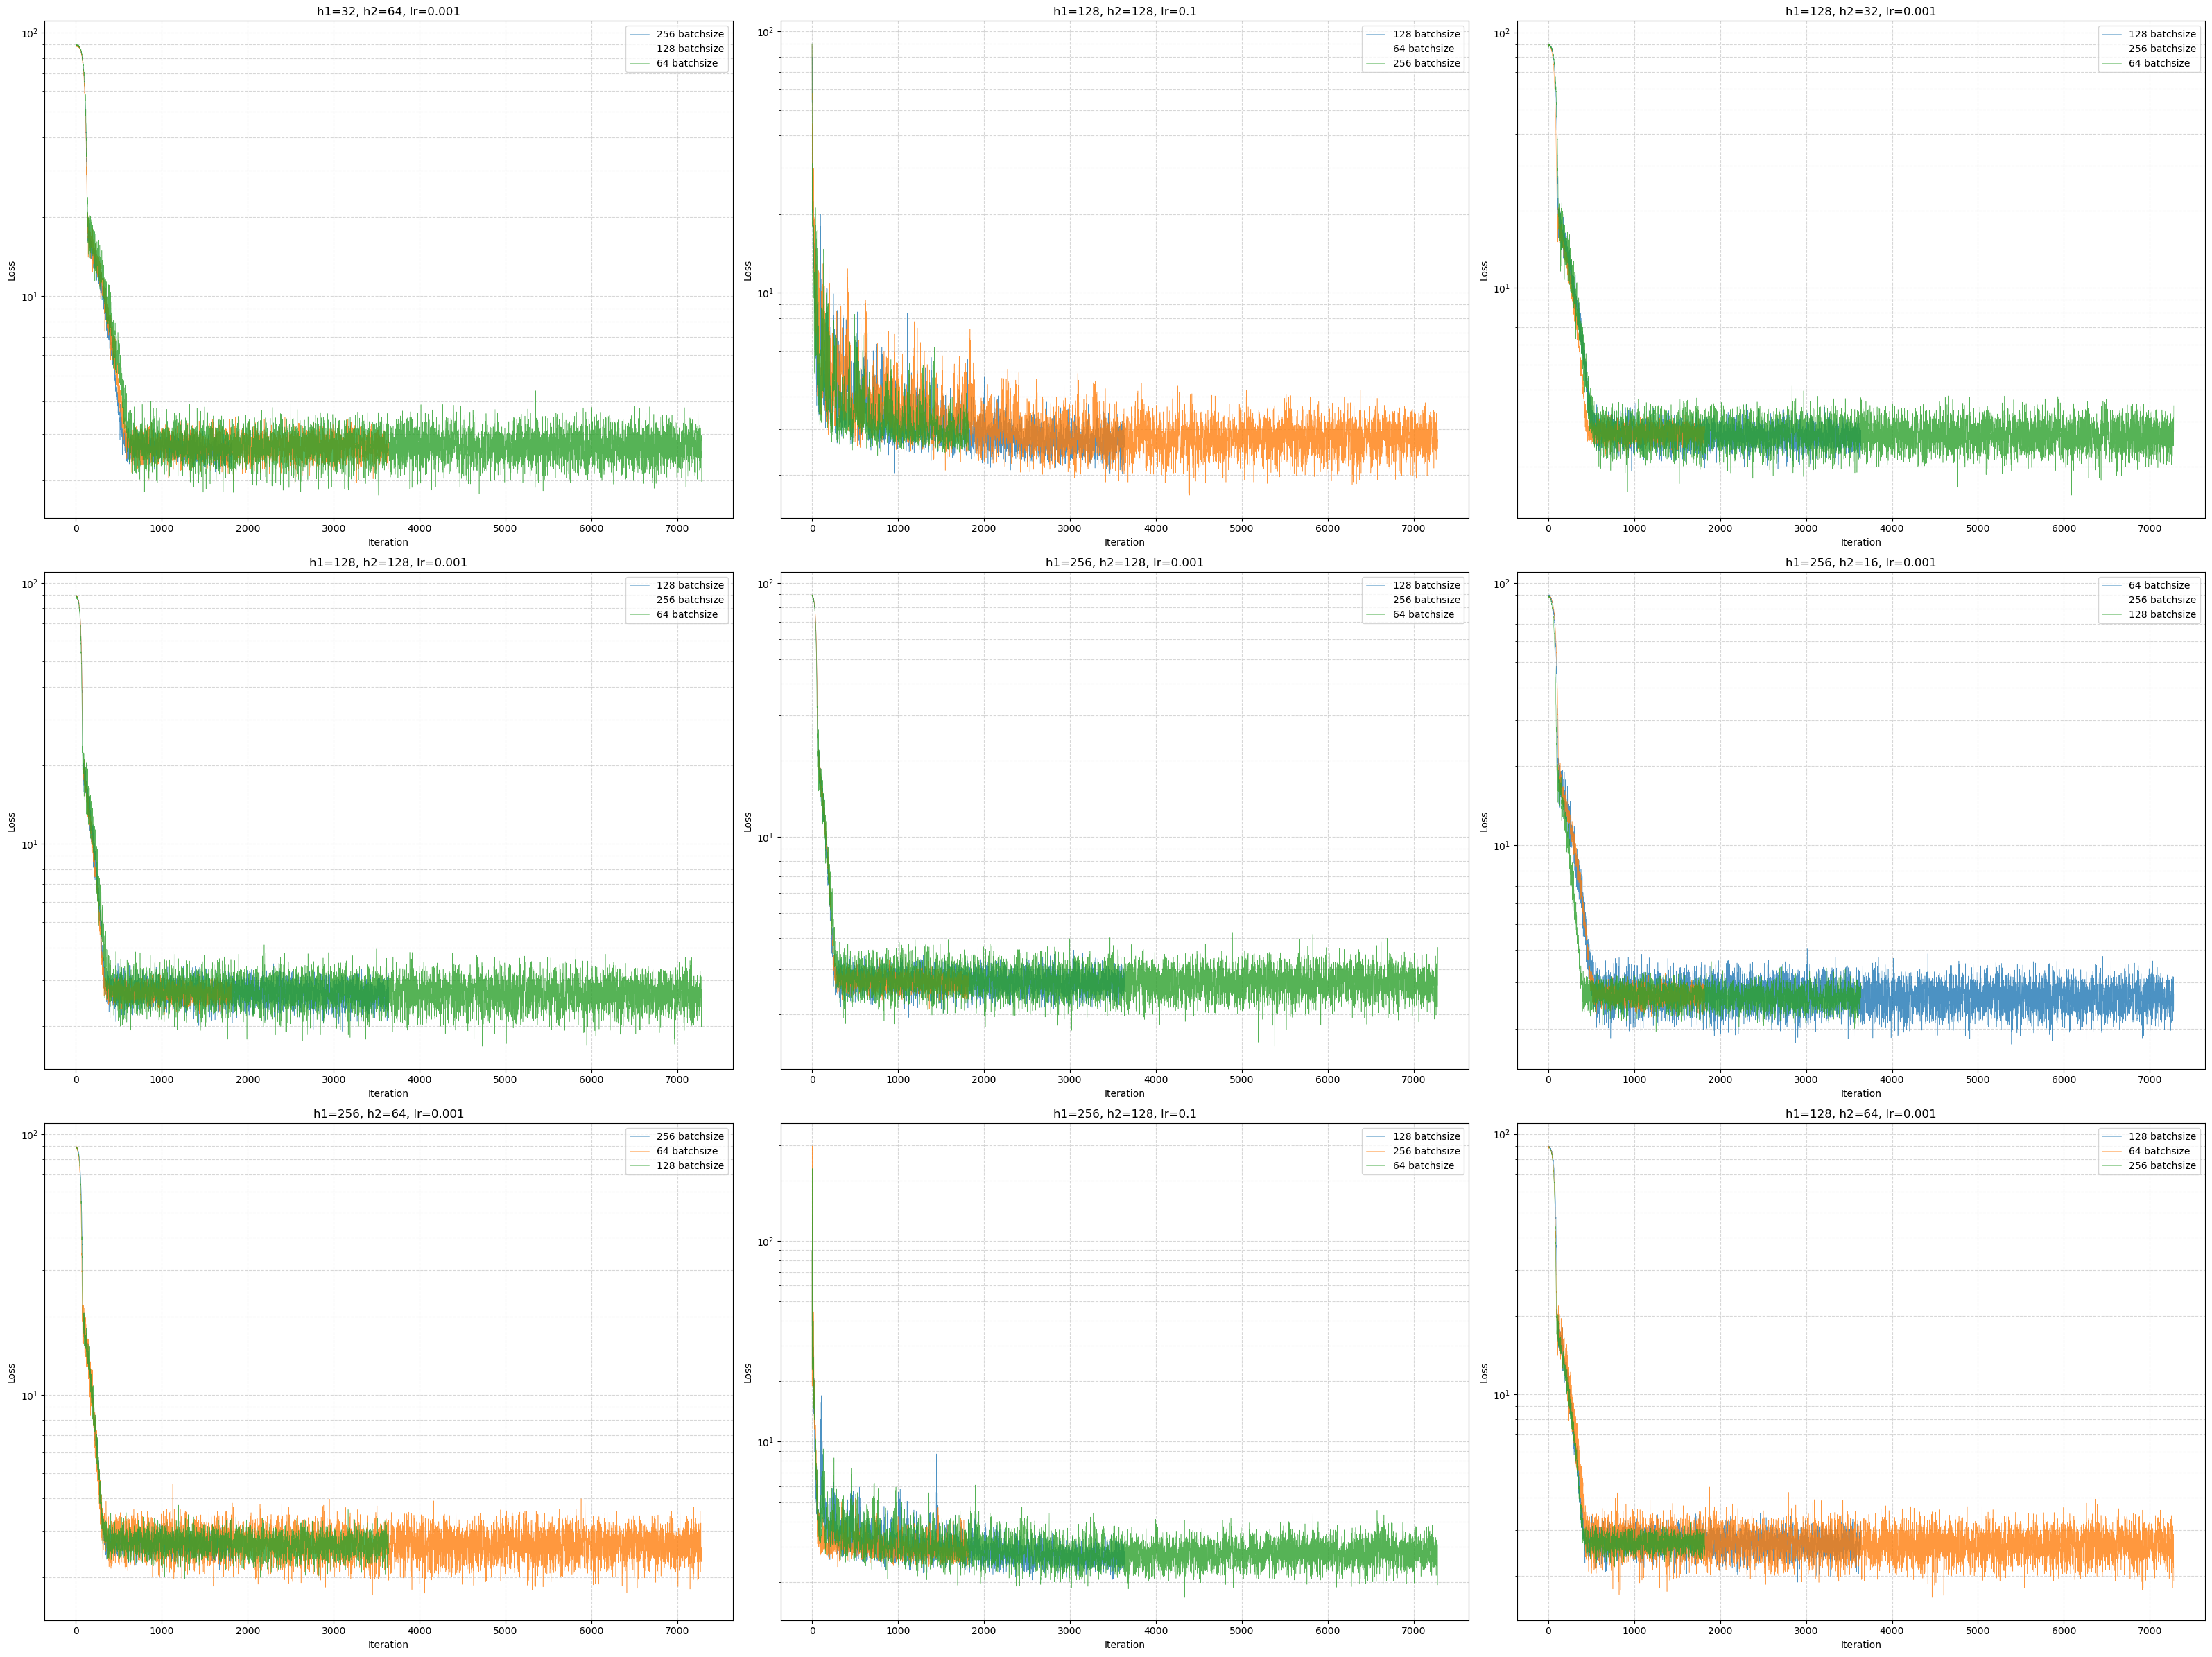

<Figure size 640x480 with 0 Axes>

In [143]:
import numpy as np

import matplotlib.pyplot as plt

# Create a figure that's large enough to see all plots
plt.figure(figsize=(32, 24))

# Group the hyperparameter combinations (excluding epochs)
grouped_params = {}
for params, (loss, loss_data) in params_and_losses:
    # Extract all parameters except epochs (which is the last one)
    key = params[:-2]  # (h1, h2, lr, bs)
    
    # If this combination hasn't been seen before, create a new entry
    if key not in grouped_params:
        grouped_params[key] = []
    
    # Add (batchsize, loss, loss_data) to this combination
    if params[-1] == 20:  # Only take the last epoch
        grouped_params[key].append((params[-2], loss, loss_data))

# Sort the groups by minimum loss
sorted_groups = sorted(grouped_params.items(), 
                       key=lambda x: min(item[1] for item in x[1]))

# Take the top 9 best combinations to avoid overcrowding the plot
top_n = min(9, len(sorted_groups))
best_groups = sorted_groups[:top_n]

# Create subplots for the best combinations
for i, ((h1, h2, lr), epoch_data) in enumerate(best_groups):
    plt.subplot(3, 3, i+1)
    
    for bs, loss, loss_curve in epoch_data:
        plt.semilogy(loss_curve, label=f"{bs} batchsize", linewidth=0.4, alpha=0.8)
    
    plt.title(f"h1={h1}, h2={h2}, lr={lr}")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True, which="both", ls="--", alpha=0.5)

plt.tight_layout()
plt.show()
plt.savefig("hyperparameter_search.png")

Tweaking best result

In [145]:
h1, h2, lr, bs, ep = top_params[0]
train_dataloader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=bs, shuffle=False)
model_optimal = SurvivalRateModel(input_size=input_size, hidden_size1=h1, hidden_size2=h2)
loss_data_optimal = model.train_loop(train_dataloader, num_epochs=ep, learning_rate=lr, device="cpu")


Training Epochs:   5%|▌         | 1/20 [00:00<00:16,  1.14it/s]

Epoch [1/20], Loss: 2.6802


Training Epochs:  10%|█         | 2/20 [00:01<00:12,  1.40it/s]

Epoch [2/20], Loss: 2.6251


Training Epochs:  15%|█▌        | 3/20 [00:02<00:11,  1.53it/s]

Epoch [3/20], Loss: 2.6375


Training Epochs:  20%|██        | 4/20 [00:02<00:09,  1.61it/s]

Epoch [4/20], Loss: 2.6277


Training Epochs:  25%|██▌       | 5/20 [00:03<00:09,  1.66it/s]

Epoch [5/20], Loss: 2.6400


Training Epochs:  30%|███       | 6/20 [00:03<00:08,  1.67it/s]

Epoch [6/20], Loss: 2.6471


Training Epochs:  35%|███▌      | 7/20 [00:04<00:07,  1.69it/s]

Epoch [7/20], Loss: 2.6125


Training Epochs:  40%|████      | 8/20 [00:04<00:06,  1.72it/s]

Epoch [8/20], Loss: 2.6470


Training Epochs:  45%|████▌     | 9/20 [00:05<00:06,  1.74it/s]

Epoch [9/20], Loss: 2.6214


Training Epochs:  50%|█████     | 10/20 [00:06<00:05,  1.70it/s]

Epoch [10/20], Loss: 2.6134


Training Epochs:  55%|█████▌    | 11/20 [00:06<00:05,  1.61it/s]

Epoch [11/20], Loss: 2.6232


Training Epochs:  60%|██████    | 12/20 [00:07<00:04,  1.65it/s]

Epoch [12/20], Loss: 2.6241


Training Epochs:  65%|██████▌   | 13/20 [00:08<00:05,  1.40it/s]

Epoch [13/20], Loss: 2.6272


Training Epochs:  70%|███████   | 14/20 [00:08<00:04,  1.47it/s]

Epoch [14/20], Loss: 2.6143


Training Epochs:  75%|███████▌  | 15/20 [00:09<00:03,  1.54it/s]

Epoch [15/20], Loss: 2.6116


Training Epochs:  80%|████████  | 16/20 [00:10<00:02,  1.56it/s]

Epoch [16/20], Loss: 2.6113


Training Epochs:  85%|████████▌ | 17/20 [00:10<00:01,  1.59it/s]

Epoch [17/20], Loss: 2.6292


Training Epochs:  90%|█████████ | 18/20 [00:11<00:01,  1.64it/s]

Epoch [18/20], Loss: 2.6191


Training Epochs:  95%|█████████▌| 19/20 [00:11<00:00,  1.63it/s]

Epoch [19/20], Loss: 2.6163


Training Epochs: 100%|██████████| 20/20 [00:12<00:00,  1.60it/s]

Epoch [20/20], Loss: 2.6115


In [178]:
sample_input = torch.tensor(np.concatenate([
    np.array([0.05]).reshape(-1, 1), 
    train_dataset.state_encoder.transform([[1]]).reshape(-1, 1), 
    train_dataset.industry_encoder.transform([[1]]).reshape(-1, 1)
], axis=0)).T

/Users/sebastian/opt/anaconda3/envs/PIC16B-25W/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
/Users/sebastian/opt/anaconda3/envs/PIC16B-25W/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(


In [179]:
model.predict(sample_input)

AttributeError: 'SurvivalRateModel' object has no attribute 'predict'